In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from rasterio.merge import merge
import glob

from rasterio.plot import adjust_band
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
import rasterio.features
import rasterio.warp
import rasterio.mask
from rasterio.merge import merge
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.models import load_model

from skimage.transform import resize

In [2]:
#ensure size of tile is uniform, and reshape the numpy into a image format then normalize
def newXpreprocessing(tile,layers,width,height):
    #print(tile.shape,"before")
    tile = resize(tile, (layers,width,height))
    #print(tile.shape,"resize")
    tile = reshape_as_image(tile)
    #print(tile.shape,"reshape")
    #normalising tile
    tile = tile/255
    return tile

In [3]:
#Keras compatible preditor - works tif. Each image is predicted against and then saved as a colour representing the prediction
# to be turned into a mosaic at the next step
def predictingNewX(model,data_dir_list,data_path,width=40,height=40,layers=3):
    #load list of image names in each category
    img_list = os.listdir(os.path.join(data_path))
     #   print ('Loading the images for prediction -'+'{}\n'.format(dataset))
    num_img_files = len(img_list) 

    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,img_name)
        #model expects image formatted a certain way
        X_new = []
        with rasterio.open(img_filename) as ds:
            tile=ds.read()
            #preprocess tille according to model expectations
            pre_tile=newXpreprocessing(tile,layers,width,height)

        # Add tile to array
        X_new.append(pre_tile)
        # Make sure they're numpy arrays (as opposed to lists)
        X_new = np.array(X_new)
        #make prediction against X-new array
        #yNew = model.predict_classes(X_new)
        yNew = model.predict(X_new)
        #classes_y=np.argmax(yNew,axis=1)
        #Transposed value to get easy access to prediction for 1 (prospectable)
        yNewT = yNew.T
        print(yNewT[1])
        y_classes = float(yNewT[1])
        #determine colour of class of interest
        class_image = loadClassTile(y_classes,class_path)
        with rasterio.open(
            str(output_path) +'\\' + str(i) +'_y.tif',
            'w',
            driver='GTiff',
            height=class_image.shape[1],
            width=class_image.shape[2],
            count=class_image.shape[0],
            dtype=class_image.dtype,
            class_image=ds.crs,
            nodata=None,
            transform=ds.transform
            ) as dst:
            dst.write(class_image)
        print('processed: '+ str(i) +'_y.tif')


In [4]:
#Method to replace a detected class with a single colour image representing that class. 
def loadClassTile(yNew,class_path):
    if  yNew >= 0.999:
        classlabel = '99.tiff'
    elif yNew >= 0.998:
        classlabel = '98.tiff'
    elif yNew >= 0.997:
        classlabel = '97.tiff'  
    elif yNew >= 0.996:
        classlabel = '96.tiff'  
    elif yNew >= 0.995:
        classlabel = '95.tiff'
    elif yNew >= 0.994:
        classlabel = '94.tiff'
    elif yNew >= 0.993:
        classlabel = '93.tiff'
    elif yNew >= 0.992:
        classlabel = '92.tiff'
    elif yNew >= 0.991:
        classlabel = '91.tiff'
    elif yNew >= 0.990:
        classlabel = '90.tiff'
    elif yNew >= 0:
        classlabel = '0.tiff'
    else:
        classlabel = 'error.tiff'
    
    with rasterio.open(str(class_path) + '\\' + classlabel) as cs:
        class_image=cs.read()
    return class_image
    

In [5]:
# https://gis.stackexchange.com/questions/348925/merging-rasters-with-rasterio-in-blocks-to-avoid-memoryerror
# https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html
# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html

# this script is performed in memory and is thus memroy intensive TO DO: create a rasterio-in-blocks implementation
#a folder is created containig the class images(with CRS), all images within this folder are mosaiced together into a single raster 
def merge_raster_in_folder(src_dir, dest_dir):
    """Merge all the raster (TIFF extension) within the given directory"""
    #simple merges outputs from model and merges them
    #src_dir = r"C:\Data\Test_dataset"
    out_fp = dest_dir + r"\SAT_Group5_prediction_resnet50.tif"
    # create list of raster files in source folder
    src_files_to_mosaic = []
    os.chdir(src_dir)
    for file in glob.glob("*.tif"):
        src = rasterio.open(file)
        src_files_to_mosaic.append(file)

    # create list of raster objects from the list of raster filename
    sources = [rasterio.open(raster) for raster in src_files_to_mosaic]

    # create array representing all source rasters mosaicked together
    mosaic, out_transform = merge(sources)
    #checkl mosaic is created 
    show(mosaic, cmap='terrain')

    out_meta = src.meta.copy()
    out_meta.update({"driver":"GTiff",
                     "height":mosaic.shape[1],
                     "width":mosaic.shape[2],
                     "transform":out_transform,
                     "crs":'+proj=latlong' #TO DO: Pass in CRS
    }
    )
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

In [6]:
#declare path directories
data_path = r'C:\Data\group5_predict'
output_path = r'C:\Data\output5'
class_path = r'C:\Data\ClassesPredictSat'
result_path = r'C:\Data'
data_dir_list = os.listdir(data_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 7)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 7)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   22016       ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

[1.]
processed: 0_y.tif
[1.]
processed: 1_y.tif
[1.]
processed: 2_y.tif


C:\Users\Gavin\.conda\envs\Visualistion_Rasterio_GPU\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[1.]
processed: 3_y.tif
[1.]
processed: 4_y.tif
[1.]
processed: 5_y.tif
[1.]
processed: 6_y.tif
[1.]
processed: 7_y.tif
[1.]
processed: 8_y.tif
[1.]
processed: 9_y.tif
[1.]
processed: 10_y.tif
[1.]
processed: 11_y.tif
[1.]
processed: 12_y.tif
[1.]
processed: 13_y.tif
[1.]
processed: 14_y.tif
[1.]
processed: 15_y.tif
[1.]
processed: 16_y.tif
[1.]
processed: 17_y.tif
[1.]
processed: 18_y.tif
[1.]
processed: 19_y.tif
[1.]
processed: 20_y.tif
[1.]
processed: 21_y.tif
[1.]
processed: 22_y.tif
[1.]
processed: 23_y.tif
[1.]
processed: 24_y.tif
[1.]
processed: 25_y.tif
[1.]
processed: 26_y.tif
[1.]
processed: 27_y.tif
[1.]
processed: 28_y.tif
[1.]
processed: 29_y.tif
[1.]
processed: 30_y.tif
[1.]
processed: 31_y.tif
[1.]
processed: 32_y.tif
[0.99395365]
processed: 33_y.tif
[0.98917073]
processed: 34_y.tif
[0.99051803]
processed: 35_y.tif
[0.99569243]
processed: 36_y.tif
[0.99545336]
processed: 37_y.tif
[1.]
processed: 38_y.tif
[0.9990165]
processed: 39_y.tif
[0.98413014]
processed: 40_y.tif
[0

[0.8316276]
processed: 266_y.tif
[0.99977905]
processed: 267_y.tif
[0.9602703]
processed: 268_y.tif
[0.9997123]
processed: 269_y.tif
[0.99906653]
processed: 270_y.tif
[1.]
processed: 271_y.tif
[0.896053]
processed: 272_y.tif
[0.9563797]
processed: 273_y.tif
[0.9966151]
processed: 274_y.tif
[0.99887246]
processed: 275_y.tif
[0.9997029]
processed: 276_y.tif
[0.9990736]
processed: 277_y.tif
[0.9999728]
processed: 278_y.tif
[0.9985991]
processed: 279_y.tif
[0.99917954]
processed: 280_y.tif
[0.9999186]
processed: 281_y.tif
[1.]
processed: 282_y.tif
[0.99999356]
processed: 283_y.tif
[0.99996424]
processed: 284_y.tif
[0.99997807]
processed: 285_y.tif
[0.99862623]
processed: 286_y.tif
[0.99998724]
processed: 287_y.tif
[0.9974164]
processed: 288_y.tif
[0.94388276]
processed: 289_y.tif
[0.99652416]
processed: 290_y.tif
[0.9999933]
processed: 291_y.tif
[0.99999535]
processed: 292_y.tif
[1.]
processed: 293_y.tif
[0.99994445]
processed: 294_y.tif
[0.9985531]
processed: 295_y.tif
[0.9999052]
process

processed: 525_y.tif
[1.]
processed: 526_y.tif
[1.]
processed: 527_y.tif
[1.]
processed: 528_y.tif
[1.]
processed: 529_y.tif
[1.]
processed: 530_y.tif
[1.]
processed: 531_y.tif
[1.]
processed: 532_y.tif
[1.]
processed: 533_y.tif
[1.]
processed: 534_y.tif
[1.]
processed: 535_y.tif
[1.]
processed: 536_y.tif
[1.]
processed: 537_y.tif
[1.]
processed: 538_y.tif
[1.]
processed: 539_y.tif
[1.]
processed: 540_y.tif
[1.]
processed: 541_y.tif
[1.]
processed: 542_y.tif
[1.]
processed: 543_y.tif
[1.]
processed: 544_y.tif
[1.]
processed: 545_y.tif
[1.]
processed: 546_y.tif
[1.]
processed: 547_y.tif
[1.]
processed: 548_y.tif
[1.]
processed: 549_y.tif
[1.]
processed: 550_y.tif
[1.]
processed: 551_y.tif
[1.]
processed: 552_y.tif
[1.]
processed: 553_y.tif
[1.]
processed: 554_y.tif
[1.]
processed: 555_y.tif
[1.]
processed: 556_y.tif
[1.]
processed: 557_y.tif
[1.]
processed: 558_y.tif
[1.]
processed: 559_y.tif
[1.]
processed: 560_y.tif
[1.]
processed: 561_y.tif
[1.]
processed: 562_y.tif
[1.]
processed: 5

processed: 787_y.tif
[0.9980615]
processed: 788_y.tif
[0.9992514]
processed: 789_y.tif
[0.99972385]
processed: 790_y.tif
[0.99982446]
processed: 791_y.tif
[0.9962878]
processed: 792_y.tif
[1.]
processed: 793_y.tif
[0.9914494]
processed: 794_y.tif
[0.9956867]
processed: 795_y.tif
[0.99950683]
processed: 796_y.tif
[0.99992824]
processed: 797_y.tif
[0.9998343]
processed: 798_y.tif
[0.99995506]
processed: 799_y.tif
[0.9998629]
processed: 800_y.tif
[0.9923745]
processed: 801_y.tif
[0.9323065]
processed: 802_y.tif
[0.99764436]
processed: 803_y.tif
[1.]
processed: 804_y.tif
[0.99810445]
processed: 805_y.tif
[0.9957539]
processed: 806_y.tif
[0.9937097]
processed: 807_y.tif
[0.9974573]
processed: 808_y.tif
[0.9998228]
processed: 809_y.tif
[0.999887]
processed: 810_y.tif
[0.99957246]
processed: 811_y.tif
[0.9908732]
processed: 812_y.tif
[0.88276625]
processed: 813_y.tif
[0.9820833]
processed: 814_y.tif
[1.]
processed: 815_y.tif
[0.9677656]
processed: 816_y.tif
[0.91852754]
processed: 817_y.tif
[

[1.]
processed: 1040_y.tif
[1.]
processed: 1041_y.tif
[1.]
processed: 1042_y.tif
[1.]
processed: 1043_y.tif
[1.]
processed: 1044_y.tif
[1.]
processed: 1045_y.tif
[1.]
processed: 1046_y.tif
[1.]
processed: 1047_y.tif
[1.]
processed: 1048_y.tif
[1.]
processed: 1049_y.tif
[1.]
processed: 1050_y.tif
[1.]
processed: 1051_y.tif
[1.]
processed: 1052_y.tif
[1.]
processed: 1053_y.tif
[1.]
processed: 1054_y.tif
[1.]
processed: 1055_y.tif
[1.]
processed: 1056_y.tif
[1.]
processed: 1057_y.tif
[1.]
processed: 1058_y.tif
[1.]
processed: 1059_y.tif
[1.]
processed: 1060_y.tif
[1.]
processed: 1061_y.tif
[1.]
processed: 1062_y.tif
[1.]
processed: 1063_y.tif
[1.]
processed: 1064_y.tif
[1.]
processed: 1065_y.tif
[1.]
processed: 1066_y.tif
[1.]
processed: 1067_y.tif
[1.]
processed: 1068_y.tif
[1.]
processed: 1069_y.tif
[1.]
processed: 1070_y.tif
[1.]
processed: 1071_y.tif
[1.]
processed: 1072_y.tif
[1.]
processed: 1073_y.tif
[1.]
processed: 1074_y.tif
[1.]
processed: 1075_y.tif
[1.]
processed: 1076_y.tif
[

processed: 1297_y.tif
[0.79196167]
processed: 1298_y.tif
[0.96266544]
processed: 1299_y.tif
[0.9810656]
processed: 1300_y.tif
[0.68299705]
processed: 1301_y.tif
[0.08092252]
processed: 1302_y.tif
[0.5950651]
processed: 1303_y.tif
[1.]
processed: 1304_y.tif
[0.8079103]
processed: 1305_y.tif
[0.6377813]
processed: 1306_y.tif
[0.9763955]
processed: 1307_y.tif
[0.9871787]
processed: 1308_y.tif
[0.98354566]
processed: 1309_y.tif
[0.91951597]
processed: 1310_y.tif
[0.70116746]
processed: 1311_y.tif
[0.997959]
processed: 1312_y.tif
[0.9352508]
processed: 1313_y.tif
[0.97930783]
processed: 1314_y.tif
[1.]
processed: 1315_y.tif
[0.9465675]
processed: 1316_y.tif
[0.97926027]
processed: 1317_y.tif
[0.98818946]
processed: 1318_y.tif
[0.7648612]
processed: 1319_y.tif
[0.9998418]
processed: 1320_y.tif
[0.9991167]
processed: 1321_y.tif
[0.89679474]
processed: 1322_y.tif
[0.8710748]
processed: 1323_y.tif
[0.9959787]
processed: 1324_y.tif
[0.99730116]
processed: 1325_y.tif
[1.]
processed: 1326_y.tif
[0

[0.98090804]
processed: 1542_y.tif
[0.988872]
processed: 1543_y.tif
[0.9917978]
processed: 1544_y.tif
[0.9539296]
processed: 1545_y.tif
[0.9992742]
processed: 1546_y.tif
[0.97165483]
processed: 1547_y.tif
[1.]
processed: 1548_y.tif
[3.5271073e-06]
processed: 1549_y.tif
[1.2881191e-08]
processed: 1550_y.tif
[0.0377633]
processed: 1551_y.tif
[1.1968042e-08]
processed: 1552_y.tif
[0.00012061]
processed: 1553_y.tif
[1.4388253e-05]
processed: 1554_y.tif
[6.257556e-05]
processed: 1555_y.tif
[3.133263e-05]
processed: 1556_y.tif
[0.41974384]
processed: 1557_y.tif
[0.16290446]
processed: 1558_y.tif
[1.]
processed: 1559_y.tif
[1.]
processed: 1560_y.tif
[0.91256225]
processed: 1561_y.tif
[1.]
processed: 1562_y.tif
[1.]
processed: 1563_y.tif
[1.]
processed: 1564_y.tif
[1.]
processed: 1565_y.tif
[1.]
processed: 1566_y.tif
[1.]
processed: 1567_y.tif
[1.]
processed: 1568_y.tif
[1.]
processed: 1569_y.tif
[1.]
processed: 1570_y.tif
[1.]
processed: 1571_y.tif
[1.]
processed: 1572_y.tif
[1.]
processed: 1

[0.99933016]
processed: 1803_y.tif
[1.]
processed: 1804_y.tif
[0.9154481]
processed: 1805_y.tif
[0.946085]
processed: 1806_y.tif
[0.9947248]
processed: 1807_y.tif
[0.9998234]
processed: 1808_y.tif
[0.9997111]
processed: 1809_y.tif
[0.99082536]
processed: 1810_y.tif
[0.95653933]
processed: 1811_y.tif
[0.9997131]
processed: 1812_y.tif
[0.99499184]
processed: 1813_y.tif
[0.9990958]
processed: 1814_y.tif
[1.]
processed: 1815_y.tif
[0.9997414]
processed: 1816_y.tif
[0.99995637]
processed: 1817_y.tif
[0.9999839]
processed: 1818_y.tif
[0.9999906]
processed: 1819_y.tif
[0.9999882]
processed: 1820_y.tif
[0.9999263]
processed: 1821_y.tif
[0.99994636]
processed: 1822_y.tif
[0.9999639]
processed: 1823_y.tif
[0.13241296]
processed: 1824_y.tif
[0.99996924]
processed: 1825_y.tif
[1.]
processed: 1826_y.tif
[0.99997115]
processed: 1827_y.tif
[0.9997851]
processed: 1828_y.tif
[0.9999634]
processed: 1829_y.tif
[0.9998258]
processed: 1830_y.tif
[0.9978562]
processed: 1831_y.tif
[0.99988484]
processed: 183

[0.99955183]
processed: 2047_y.tif
[1.]
processed: 2048_y.tif
[0.9999198]
processed: 2049_y.tif
[0.9997993]
processed: 2050_y.tif
[0.9999925]
processed: 2051_y.tif
[0.99995136]
processed: 2052_y.tif
[0.9999182]
processed: 2053_y.tif
[0.999071]
processed: 2054_y.tif
[0.970982]
processed: 2055_y.tif
[0.18680042]
processed: 2056_y.tif
[0.9999064]
processed: 2057_y.tif
[0.99986076]
processed: 2058_y.tif
[1.]
processed: 2059_y.tif
[0.99979705]
processed: 2060_y.tif
[0.07271042]
processed: 2061_y.tif
[0.99906594]
processed: 2062_y.tif
[0.9999713]
processed: 2063_y.tif
[0.99993384]
processed: 2064_y.tif
[0.99597245]
processed: 2065_y.tif
[0.99982363]
processed: 2066_y.tif
[0.99998534]
processed: 2067_y.tif
[0.99889576]
processed: 2068_y.tif
[0.9991385]
processed: 2069_y.tif
[1.]
processed: 2070_y.tif
[0.9990277]
processed: 2071_y.tif
[0.9974529]
processed: 2072_y.tif
[0.9948443]
processed: 2073_y.tif
[0.9276605]
processed: 2074_y.tif
[0.33387792]
processed: 2075_y.tif
[0.32791263]
processed: 

processed: 2306_y.tif
[0.99736816]
processed: 2307_y.tif
[0.9659858]
processed: 2308_y.tif
[0.9664673]
processed: 2309_y.tif
[0.9898929]
processed: 2310_y.tif
[0.9933462]
processed: 2311_y.tif
[0.99849904]
processed: 2312_y.tif
[0.98720896]
processed: 2313_y.tif
[0.9806655]
processed: 2314_y.tif
[1.]
processed: 2315_y.tif
[0.9990951]
processed: 2316_y.tif
[0.9753126]
processed: 2317_y.tif
[0.9165265]
processed: 2318_y.tif
[0.9785331]
processed: 2319_y.tif
[0.9966382]
processed: 2320_y.tif
[0.9999622]
processed: 2321_y.tif
[0.9997644]
processed: 2322_y.tif
[0.9849266]
processed: 2323_y.tif
[0.99987936]
processed: 2324_y.tif
[0.99965775]
processed: 2325_y.tif
[1.]
processed: 2326_y.tif
[0.9998485]
processed: 2327_y.tif
[0.99192506]
processed: 2328_y.tif
[0.9967996]
processed: 2329_y.tif
[0.6812926]
processed: 2330_y.tif
[0.93918943]
processed: 2331_y.tif
[0.99137527]
processed: 2332_y.tif
[0.99694604]
processed: 2333_y.tif
[0.99944586]
processed: 2334_y.tif
[0.9998944]
processed: 2335_y.

[0.9670214]
processed: 2553_y.tif
[0.00025911]
processed: 2554_y.tif
[0.99998665]
processed: 2555_y.tif
[0.99989974]
processed: 2556_y.tif
[0.9999647]
processed: 2557_y.tif
[0.99998176]
processed: 2558_y.tif
[1.]
processed: 2559_y.tif
[0.94313014]
processed: 2560_y.tif
[0.99800175]
processed: 2561_y.tif
[0.96701324]
processed: 2562_y.tif
[0.999496]
processed: 2563_y.tif
[0.9968459]
processed: 2564_y.tif
[0.98703927]
processed: 2565_y.tif
[0.97287804]
processed: 2566_y.tif
[0.98473847]
processed: 2567_y.tif
[0.9982944]
processed: 2568_y.tif
[0.988701]
processed: 2569_y.tif
[0.9999062]
processed: 2570_y.tif
[0.8559469]
processed: 2571_y.tif
[0.99987614]
processed: 2572_y.tif
[0.99990845]
processed: 2573_y.tif
[0.9997036]
processed: 2574_y.tif
[0.9998468]
processed: 2575_y.tif
[0.9999759]
processed: 2576_y.tif
[0.85006183]
processed: 2577_y.tif
[0.29206255]
processed: 2578_y.tif
[0.89913887]
processed: 2579_y.tif
[0.9989712]
processed: 2580_y.tif
[0.9677317]
processed: 2581_y.tif
[0.95858

[0.946377]
processed: 2807_y.tif
[0.97780025]
processed: 2808_y.tif
[0.9482371]
processed: 2809_y.tif
[0.9766732]
processed: 2810_y.tif
[0.9972378]
processed: 2811_y.tif
[0.9995735]
processed: 2812_y.tif
[0.9955751]
processed: 2813_y.tif
[0.99996233]
processed: 2814_y.tif
[0.93380535]
processed: 2815_y.tif
[0.9975495]
processed: 2816_y.tif
[0.99933726]
processed: 2817_y.tif
[0.999686]
processed: 2818_y.tif
[0.9996494]
processed: 2819_y.tif
[0.99992096]
processed: 2820_y.tif
[0.99999]
processed: 2821_y.tif
[0.99999726]
processed: 2822_y.tif
[0.99987364]
processed: 2823_y.tif
[0.99533457]
processed: 2824_y.tif
[0.993451]
processed: 2825_y.tif
[0.8458881]
processed: 2826_y.tif
[0.9989894]
processed: 2827_y.tif
[0.9988469]
processed: 2828_y.tif
[0.98971367]
processed: 2829_y.tif
[0.99549603]
processed: 2830_y.tif
[0.998648]
processed: 2831_y.tif
[0.99764365]
processed: 2832_y.tif
[0.9985133]
processed: 2833_y.tif
[0.9722333]
processed: 2834_y.tif
[0.9822938]
processed: 2835_y.tif
[0.998806

[0.7970966]
processed: 3048_y.tif
[0.93998706]
processed: 3049_y.tif
[0.621499]
processed: 3050_y.tif
[0.56640244]
processed: 3051_y.tif
[0.71929455]
processed: 3052_y.tif
[0.90936536]
processed: 3053_y.tif
[0.94346654]
processed: 3054_y.tif
[0.91779184]
processed: 3055_y.tif
[0.9928416]
processed: 3056_y.tif
[0.9996451]
processed: 3057_y.tif
[0.8711651]
processed: 3058_y.tif
[0.01395915]
processed: 3059_y.tif
[0.9999944]
processed: 3060_y.tif
[0.9956488]
processed: 3061_y.tif
[0.282204]
processed: 3062_y.tif
[0.9979691]
processed: 3063_y.tif
[0.9971073]
processed: 3064_y.tif
[0.9864542]
processed: 3065_y.tif
[0.92419803]
processed: 3066_y.tif
[0.97406185]
processed: 3067_y.tif
[0.995378]
processed: 3068_y.tif
[0.9997137]
processed: 3069_y.tif
[0.98088396]
processed: 3070_y.tif
[0.99997926]
processed: 3071_y.tif
[0.9999956]
processed: 3072_y.tif
[0.9999963]
processed: 3073_y.tif
[0.99997175]
processed: 3074_y.tif
[0.99616975]
processed: 3075_y.tif
[0.99458474]
processed: 3076_y.tif
[0.

[0.99661094]
processed: 3303_y.tif
[0.99006826]
processed: 3304_y.tif
[0.99353653]
processed: 3305_y.tif
[0.9842525]
processed: 3306_y.tif
[0.9912208]
processed: 3307_y.tif
[0.99816823]
processed: 3308_y.tif
[0.99867475]
processed: 3309_y.tif
[0.9895573]
processed: 3310_y.tif
[0.9999192]
processed: 3311_y.tif
[0.9997062]
processed: 3312_y.tif
[0.9942468]
processed: 3313_y.tif
[0.96811956]
processed: 3314_y.tif
[0.999376]
processed: 3315_y.tif
[0.99994767]
processed: 3316_y.tif
[0.9760953]
processed: 3317_y.tif
[0.99481744]
processed: 3318_y.tif
[0.99900216]
processed: 3319_y.tif
[0.99704045]
processed: 3320_y.tif
[0.99987626]
processed: 3321_y.tif
[0.9998697]
processed: 3322_y.tif
[0.99993217]
processed: 3323_y.tif
[0.99998665]
processed: 3324_y.tif
[0.86229265]
processed: 3325_y.tif
[0.9992249]
processed: 3326_y.tif
[0.99917066]
processed: 3327_y.tif
[0.9849386]
processed: 3328_y.tif
[0.94598967]
processed: 3329_y.tif
[0.9908886]
processed: 3330_y.tif
[0.97694105]
processed: 3331_y.ti

[0.9872666]
processed: 3545_y.tif
[0.9984629]
processed: 3546_y.tif
[0.992393]
processed: 3547_y.tif
[0.9749273]
processed: 3548_y.tif
[0.99981445]
processed: 3549_y.tif
[0.99995875]
processed: 3550_y.tif
[0.99965954]
processed: 3551_y.tif
[0.99974996]
processed: 3552_y.tif
[0.9999088]
processed: 3553_y.tif
[0.99990535]
processed: 3554_y.tif
[0.9996377]
processed: 3555_y.tif
[0.99992025]
processed: 3556_y.tif
[0.9710089]
processed: 3557_y.tif
[0.9500723]
processed: 3558_y.tif
[1.]
processed: 3559_y.tif
[0.9455415]
processed: 3560_y.tif
[0.9999138]
processed: 3561_y.tif
[0.9998419]
processed: 3562_y.tif
[0.99994683]
processed: 3563_y.tif
[0.98230964]
processed: 3564_y.tif
[0.9999871]
processed: 3565_y.tif
[0.99967766]
processed: 3566_y.tif
[0.9999901]
processed: 3567_y.tif
[0.99756205]
processed: 3568_y.tif
[0.5123479]
processed: 3569_y.tif
[0.4588497]
processed: 3570_y.tif
[0.97089124]
processed: 3571_y.tif
[0.9168049]
processed: 3572_y.tif
[0.97975576]
processed: 3573_y.tif
[0.998784]

[1.]
processed: 3804_y.tif
[0.9997938]
processed: 3805_y.tif
[0.9998404]
processed: 3806_y.tif
[0.999863]
processed: 3807_y.tif
[0.99924636]
processed: 3808_y.tif
[0.9999336]
processed: 3809_y.tif
[0.9994504]
processed: 3810_y.tif
[0.998941]
processed: 3811_y.tif
[0.9999312]
processed: 3812_y.tif
[0.9995994]
processed: 3813_y.tif
[0.99992037]
processed: 3814_y.tif
[1.]
processed: 3815_y.tif
[0.999388]
processed: 3816_y.tif
[0.99739766]
processed: 3817_y.tif
[0.99467397]
processed: 3818_y.tif
[0.9995079]
processed: 3819_y.tif
[0.99994886]
processed: 3820_y.tif
[0.99938774]
processed: 3821_y.tif
[0.9998128]
processed: 3822_y.tif
[0.9975752]
processed: 3823_y.tif
[0.9998529]
processed: 3824_y.tif
[0.9999176]
processed: 3825_y.tif
[1.]
processed: 3826_y.tif
[0.9999443]
processed: 3827_y.tif
[0.99997485]
processed: 3828_y.tif
[0.9999311]
processed: 3829_y.tif
[0.9998012]
processed: 3830_y.tif
[0.9997327]
processed: 3831_y.tif
[0.9999652]
processed: 3832_y.tif
[0.9999584]
processed: 3833_y.t

[0.44072914]
processed: 4049_y.tif
[0.99997485]
processed: 4050_y.tif
[0.999977]
processed: 4051_y.tif
[0.9993685]
processed: 4052_y.tif
[0.27334696]
processed: 4053_y.tif
[0.44122165]
processed: 4054_y.tif
[0.99995065]
processed: 4055_y.tif
[0.9999734]
processed: 4056_y.tif
[0.99999523]
processed: 4057_y.tif
[0.99994826]
processed: 4058_y.tif
[1.]
processed: 4059_y.tif
[0.999778]
processed: 4060_y.tif
[0.9894918]
processed: 4061_y.tif
[0.99999]
processed: 4062_y.tif
[0.99997723]
processed: 4063_y.tif
[0.99503654]
processed: 4064_y.tif
[0.9999424]
processed: 4065_y.tif
[0.9999627]
processed: 4066_y.tif
[0.99997187]
processed: 4067_y.tif
[0.99999166]
processed: 4068_y.tif
[0.99998343]
processed: 4069_y.tif
[1.]
processed: 4070_y.tif
[0.999734]
processed: 4071_y.tif
[0.99998367]
processed: 4072_y.tif
[0.9997607]
processed: 4073_y.tif
[0.99996257]
processed: 4074_y.tif
[0.99998546]
processed: 4075_y.tif
[0.999982]
processed: 4076_y.tif
[0.32497686]
processed: 4077_y.tif
[0.6051968]
proces

processed: 4305_y.tif
[1.]
processed: 4306_y.tif
[1.]
processed: 4307_y.tif
[1.]
processed: 4308_y.tif
[1.]
processed: 4309_y.tif
[1.]
processed: 4310_y.tif
[1.]
processed: 4311_y.tif
[1.]
processed: 4312_y.tif
[1.]
processed: 4313_y.tif
[1.]
processed: 4314_y.tif
[1.]
processed: 4315_y.tif
[1.]
processed: 4316_y.tif
[1.]
processed: 4317_y.tif
[1.]
processed: 4318_y.tif
[1.]
processed: 4319_y.tif
[1.]
processed: 4320_y.tif
[1.]
processed: 4321_y.tif
[0.9992675]
processed: 4322_y.tif
[0.99977]
processed: 4323_y.tif
[0.9996625]
processed: 4324_y.tif
[1.]
processed: 4325_y.tif
[0.99918157]
processed: 4326_y.tif
[0.9991198]
processed: 4327_y.tif
[0.9991196]
processed: 4328_y.tif
[0.9992053]
processed: 4329_y.tif
[0.99950016]
processed: 4330_y.tif
[0.99249166]
processed: 4331_y.tif
[0.9996232]
processed: 4332_y.tif
[0.99315506]
processed: 4333_y.tif
[0.99729496]
processed: 4334_y.tif
[0.9991561]
processed: 4335_y.tif
[1.]
processed: 4336_y.tif
[1.]
processed: 4337_y.tif
[0.99931943]
process

[0.9999888]
processed: 4554_y.tif
[0.9996424]
processed: 4555_y.tif
[0.9990452]
processed: 4556_y.tif
[0.9577952]
processed: 4557_y.tif
[0.9290261]
processed: 4558_y.tif
[1.]
processed: 4559_y.tif
[1.]
processed: 4560_y.tif
[0.9700678]
processed: 4561_y.tif
[0.9952728]
processed: 4562_y.tif
[0.99985194]
processed: 4563_y.tif
[0.9999871]
processed: 4564_y.tif
[0.99984396]
processed: 4565_y.tif
[0.9999565]
processed: 4566_y.tif
[0.98714733]
processed: 4567_y.tif
[0.9999192]
processed: 4568_y.tif
[0.99954456]
processed: 4569_y.tif
[0.98009175]
processed: 4570_y.tif
[1.]
processed: 4571_y.tif
[0.9984749]
processed: 4572_y.tif
[0.9999566]
processed: 4573_y.tif
[0.99979204]
processed: 4574_y.tif
[0.9999778]
processed: 4575_y.tif
[0.999995]
processed: 4576_y.tif
[0.9999658]
processed: 4577_y.tif
[0.9999708]
processed: 4578_y.tif
[0.9997751]
processed: 4579_y.tif
[0.99993587]
processed: 4580_y.tif
[0.9998179]
processed: 4581_y.tif
[1.]
processed: 4582_y.tif
[0.9977126]
processed: 4583_y.tif
[0

[1.]
processed: 4805_y.tif
[1.]
processed: 4806_y.tif
[1.]
processed: 4807_y.tif
[1.]
processed: 4808_y.tif
[1.]
processed: 4809_y.tif
[1.]
processed: 4810_y.tif
[1.]
processed: 4811_y.tif
[1.]
processed: 4812_y.tif
[1.]
processed: 4813_y.tif
[1.]
processed: 4814_y.tif
[1.]
processed: 4815_y.tif
[1.]
processed: 4816_y.tif
[1.]
processed: 4817_y.tif
[1.]
processed: 4818_y.tif
[1.]
processed: 4819_y.tif
[1.]
processed: 4820_y.tif
[1.]
processed: 4821_y.tif
[1.]
processed: 4822_y.tif
[1.]
processed: 4823_y.tif
[1.]
processed: 4824_y.tif
[1.]
processed: 4825_y.tif
[1.]
processed: 4826_y.tif
[1.]
processed: 4827_y.tif
[1.]
processed: 4828_y.tif
[1.]
processed: 4829_y.tif
[1.]
processed: 4830_y.tif
[1.]
processed: 4831_y.tif
[1.]
processed: 4832_y.tif
[1.]
processed: 4833_y.tif
[1.]
processed: 4834_y.tif
[1.]
processed: 4835_y.tif
[1.]
processed: 4836_y.tif
[1.]
processed: 4837_y.tif
[1.]
processed: 4838_y.tif
[1.]
processed: 4839_y.tif
[1.]
processed: 4840_y.tif
[1.]
processed: 4841_y.tif
[

[0.9997639]
processed: 5060_y.tif
[0.9992878]
processed: 5061_y.tif
[0.9996462]
processed: 5062_y.tif
[0.99397427]
processed: 5063_y.tif
[0.9963701]
processed: 5064_y.tif
[0.94933146]
processed: 5065_y.tif
[0.949838]
processed: 5066_y.tif
[0.999059]
processed: 5067_y.tif
[0.7636233]
processed: 5068_y.tif
[0.7987095]
processed: 5069_y.tif
[1.]
processed: 5070_y.tif
[0.8810499]
processed: 5071_y.tif
[0.9926979]
processed: 5072_y.tif
[0.9966568]
processed: 5073_y.tif
[0.99095625]
processed: 5074_y.tif
[0.99483865]
processed: 5075_y.tif
[0.96969956]
processed: 5076_y.tif
[0.99435]
processed: 5077_y.tif
[0.9946344]
processed: 5078_y.tif
[0.9949018]
processed: 5079_y.tif
[0.99948287]
processed: 5080_y.tif
[1.]
processed: 5081_y.tif
[0.9999865]
processed: 5082_y.tif
[0.9999846]
processed: 5083_y.tif
[0.99997616]
processed: 5084_y.tif
[0.99997795]
processed: 5085_y.tif
[0.99997663]
processed: 5086_y.tif
[0.99999535]
processed: 5087_y.tif
[0.9999876]
processed: 5088_y.tif
[0.99998224]
processed

[0.92437154]
processed: 5305_y.tif
[0.9875567]
processed: 5306_y.tif
[0.99718094]
processed: 5307_y.tif
[0.9967243]
processed: 5308_y.tif
[0.9996542]
processed: 5309_y.tif
[0.9889122]
processed: 5310_y.tif
[0.9805132]
processed: 5311_y.tif
[0.9651186]
processed: 5312_y.tif
[0.9674211]
processed: 5313_y.tif
[1.]
processed: 5314_y.tif
[8.525196e-08]
processed: 5315_y.tif
[1.]
processed: 5316_y.tif
[1.]
processed: 5317_y.tif
[1.]
processed: 5318_y.tif
[1.]
processed: 5319_y.tif
[1.]
processed: 5320_y.tif
[1.]
processed: 5321_y.tif
[1.]
processed: 5322_y.tif
[1.]
processed: 5323_y.tif
[1.]
processed: 5324_y.tif
[1.]
processed: 5325_y.tif
[1.]
processed: 5326_y.tif
[1.]
processed: 5327_y.tif
[1.]
processed: 5328_y.tif
[1.]
processed: 5329_y.tif
[1.]
processed: 5330_y.tif
[1.]
processed: 5331_y.tif
[1.]
processed: 5332_y.tif
[1.]
processed: 5333_y.tif
[1.]
processed: 5334_y.tif
[1.]
processed: 5335_y.tif
[1.]
processed: 5336_y.tif
[1.]
processed: 5337_y.tif
[1.]
processed: 5338_y.tif
[1.]
pr

[0.9999207]
processed: 5565_y.tif
[0.99999917]
processed: 5566_y.tif
[0.9999907]
processed: 5567_y.tif
[0.99998283]
processed: 5568_y.tif
[0.99999]
processed: 5569_y.tif
[0.9997342]
processed: 5570_y.tif
[1.]
processed: 5571_y.tif
[0.9999944]
processed: 5572_y.tif
[0.9999956]
processed: 5573_y.tif
[0.99999285]
processed: 5574_y.tif
[0.9999013]
processed: 5575_y.tif
[0.9999038]
processed: 5576_y.tif
[0.99998045]
processed: 5577_y.tif
[0.99996877]
processed: 5578_y.tif
[0.99976534]
processed: 5579_y.tif
[0.99818414]
processed: 5580_y.tif
[0.9999144]
processed: 5581_y.tif
[1.]
processed: 5582_y.tif
[0.9999763]
processed: 5583_y.tif
[0.99938405]
processed: 5584_y.tif
[0.9999571]
processed: 5585_y.tif
[0.9998086]
processed: 5586_y.tif
[0.99627614]
processed: 5587_y.tif
[0.9685513]
processed: 5588_y.tif
[0.5387932]
processed: 5589_y.tif
[0.9567714]
processed: 5590_y.tif
[0.99994147]
processed: 5591_y.tif
[0.99983823]
processed: 5592_y.tif
[1.]
processed: 5593_y.tif
[0.99551517]
processed: 55

[0.99941766]
processed: 5810_y.tif
[0.9994066]
processed: 5811_y.tif
[0.982272]
processed: 5812_y.tif
[0.9999201]
processed: 5813_y.tif
[0.99985886]
processed: 5814_y.tif
[1.]
processed: 5815_y.tif
[0.99998415]
processed: 5816_y.tif
[0.9984316]
processed: 5817_y.tif
[0.99763525]
processed: 5818_y.tif
[0.92966634]
processed: 5819_y.tif
[0.98999035]
processed: 5820_y.tif
[0.98347336]
processed: 5821_y.tif
[0.89943534]
processed: 5822_y.tif
[0.9953571]
processed: 5823_y.tif
[0.997024]
processed: 5824_y.tif
[0.9885718]
processed: 5825_y.tif
[1.]
processed: 5826_y.tif
[0.9980221]
processed: 5827_y.tif
[0.99697745]
processed: 5828_y.tif
[0.99919385]
processed: 5829_y.tif
[0.9998704]
processed: 5830_y.tif
[0.9999622]
processed: 5831_y.tif
[0.9742391]
processed: 5832_y.tif
[0.59633493]
processed: 5833_y.tif
[0.86839646]
processed: 5834_y.tif
[0.32932714]
processed: 5835_y.tif
[0.5456122]
processed: 5836_y.tif
[1.]
processed: 5837_y.tif
[0.827775]
processed: 5838_y.tif
[0.857212]
processed: 583

processed: 6069_y.tif
[1.]
processed: 6070_y.tif
[0.9904807]
processed: 6071_y.tif
[0.99834764]
processed: 6072_y.tif
[0.9968844]
processed: 6073_y.tif
[0.99521905]
processed: 6074_y.tif
[0.99876416]
processed: 6075_y.tif
[0.99859196]
processed: 6076_y.tif
[0.97169447]
processed: 6077_y.tif
[0.9971505]
processed: 6078_y.tif
[0.99987745]
processed: 6079_y.tif
[0.99997866]
processed: 6080_y.tif
[1.]
processed: 6081_y.tif
[0.9999759]
processed: 6082_y.tif
[0.99998283]
processed: 6083_y.tif
[0.9999609]
processed: 6084_y.tif
[0.9995208]
processed: 6085_y.tif
[0.99994683]
processed: 6086_y.tif
[0.99992657]
processed: 6087_y.tif
[0.9976291]
processed: 6088_y.tif
[0.9997869]
processed: 6089_y.tif
[0.99983895]
processed: 6090_y.tif
[0.99998915]
processed: 6091_y.tif
[1.]
processed: 6092_y.tif
[0.9999831]
processed: 6093_y.tif
[0.9999628]
processed: 6094_y.tif
[0.9991966]
processed: 6095_y.tif
[0.9999845]
processed: 6096_y.tif
[0.9999982]
processed: 6097_y.tif
[0.9999732]
processed: 6098_y.tif
[

processed: 6314_y.tif
[0.958223]
processed: 6315_y.tif
[0.9457098]
processed: 6316_y.tif
[0.9996092]
processed: 6317_y.tif
[0.99999535]
processed: 6318_y.tif
[0.99675864]
processed: 6319_y.tif
[0.9998808]
processed: 6320_y.tif
[0.99996805]
processed: 6321_y.tif
[0.95844406]
processed: 6322_y.tif
[0.9814206]
processed: 6323_y.tif
[0.9989604]
processed: 6324_y.tif
[1.]
processed: 6325_y.tif
[0.99723536]
processed: 6326_y.tif
[0.9973169]
processed: 6327_y.tif
[0.99992466]
processed: 6328_y.tif
[0.99975175]
processed: 6329_y.tif
[0.99726725]
processed: 6330_y.tif
[0.97815746]
processed: 6331_y.tif
[0.874426]
processed: 6332_y.tif
[0.99843246]
processed: 6333_y.tif
[0.9858438]
processed: 6334_y.tif
[0.97722626]
processed: 6335_y.tif
[0.9947489]
processed: 6336_y.tif
[1.]
processed: 6337_y.tif
[0.9739363]
processed: 6338_y.tif
[0.9615242]
processed: 6339_y.tif
[0.9878092]
processed: 6340_y.tif
[0.99685305]
processed: 6341_y.tif
[0.9974366]
processed: 6342_y.tif
[0.99917346]
processed: 6343_y

[0.99993134]
processed: 6575_y.tif
[0.9998468]
processed: 6576_y.tif
[0.99751484]
processed: 6577_y.tif
[0.99208343]
processed: 6578_y.tif
[0.99610895]
processed: 6579_y.tif
[0.9987344]
processed: 6580_y.tif
[1.]
processed: 6581_y.tif
[0.9976776]
processed: 6582_y.tif
[0.9996232]
processed: 6583_y.tif
[0.9999671]
processed: 6584_y.tif
[0.9997085]
processed: 6585_y.tif
[0.9842265]
processed: 6586_y.tif
[0.9861077]
processed: 6587_y.tif
[0.9520636]
processed: 6588_y.tif
[0.9682004]
processed: 6589_y.tif
[0.9944048]
processed: 6590_y.tif
[0.99732095]
processed: 6591_y.tif
[1.]
processed: 6592_y.tif
[0.9827041]
processed: 6593_y.tif
[0.984567]
processed: 6594_y.tif
[0.9890253]
processed: 6595_y.tif
[0.9419872]
processed: 6596_y.tif
[0.9538182]
processed: 6597_y.tif
[0.9943573]
processed: 6598_y.tif
[0.99732435]
processed: 6599_y.tif
[0.99940896]
processed: 6600_y.tif
[0.9939235]
processed: 6601_y.tif
[0.9996074]
processed: 6602_y.tif
[1.]
processed: 6603_y.tif
[0.9997607]
processed: 6604_y

[0.99875855]
processed: 6820_y.tif
[0.95159394]
processed: 6821_y.tif
[0.9977174]
processed: 6822_y.tif
[0.99575776]
processed: 6823_y.tif
[0.99998236]
processed: 6824_y.tif
[0.99947184]
processed: 6825_y.tif
[1.]
processed: 6826_y.tif
[0.04754864]
processed: 6827_y.tif
[0.99961203]
processed: 6828_y.tif
[0.96523273]
processed: 6829_y.tif
[0.79495066]
processed: 6830_y.tif
[0.956077]
processed: 6831_y.tif
[0.9983583]
processed: 6832_y.tif
[0.9999982]
processed: 6833_y.tif
[0.99996746]
processed: 6834_y.tif
[0.9944608]
processed: 6835_y.tif
[0.9964036]
processed: 6836_y.tif
[1.]
processed: 6837_y.tif
[0.99983203]
processed: 6838_y.tif
[0.9994005]
processed: 6839_y.tif
[0.99975985]
processed: 6840_y.tif
[0.9999231]
processed: 6841_y.tif
[0.99990356]
processed: 6842_y.tif
[0.9996107]
processed: 6843_y.tif
[0.99984324]
processed: 6844_y.tif
[0.9963026]
processed: 6845_y.tif
[0.996384]
processed: 6846_y.tif
[0.9886967]
processed: 6847_y.tif
[1.]
processed: 6848_y.tif
[0.9998264]
processed: 

[0.9995535]
processed: 7080_y.tif
[1.]
processed: 7081_y.tif
[0.99805754]
processed: 7082_y.tif
[0.99991846]
processed: 7083_y.tif
[0.99932456]
processed: 7084_y.tif
[0.98909926]
processed: 7085_y.tif
[0.9830661]
processed: 7086_y.tif
[0.98591775]
processed: 7087_y.tif
[0.9772803]
processed: 7088_y.tif
[0.99355537]
processed: 7089_y.tif
[0.9736102]
processed: 7090_y.tif
[0.94538295]
processed: 7091_y.tif
[1.]
processed: 7092_y.tif
[0.95836323]
processed: 7093_y.tif
[0.9937389]
processed: 7094_y.tif
[0.9599122]
processed: 7095_y.tif
[0.9921719]
processed: 7096_y.tif
[0.98948014]
processed: 7097_y.tif
[0.9916432]
processed: 7098_y.tif
[0.9952678]
processed: 7099_y.tif
[0.99749076]
processed: 7100_y.tif
[0.998808]
processed: 7101_y.tif
[0.9997409]
processed: 7102_y.tif
[1.]
processed: 7103_y.tif
[0.97240674]
processed: 7104_y.tif
[0.97467875]
processed: 7105_y.tif
[0.90608215]
processed: 7106_y.tif
[0.9057008]
processed: 7107_y.tif
[0.98496836]
processed: 7108_y.tif
[0.9805202]
processed:

[1.]
processed: 7325_y.tif
[0.9996674]
processed: 7326_y.tif
[0.99919695]
processed: 7327_y.tif
[0.9999665]
processed: 7328_y.tif
[0.9999846]
processed: 7329_y.tif
[0.9999807]
processed: 7330_y.tif
[0.99989176]
processed: 7331_y.tif
[0.9999937]
processed: 7332_y.tif
[0.99816704]
processed: 7333_y.tif
[0.9996045]
processed: 7334_y.tif
[0.99899536]
processed: 7335_y.tif
[8.25152e-11]
processed: 7336_y.tif
[1.]
processed: 7337_y.tif
[0.9981323]
processed: 7338_y.tif
[0.9884375]
processed: 7339_y.tif
[0.9847357]
processed: 7340_y.tif
[0.9789811]
processed: 7341_y.tif
[0.89614344]
processed: 7342_y.tif
[0.96511126]
processed: 7343_y.tif
[0.96942264]
processed: 7344_y.tif
[0.9712984]
processed: 7345_y.tif
[0.9989459]
processed: 7346_y.tif
[0.97470856]
processed: 7347_y.tif
[1.]
processed: 7348_y.tif
[0.9142831]
processed: 7349_y.tif
[0.96525526]
processed: 7350_y.tif
[0.9140986]
processed: 7351_y.tif
[0.9832707]
processed: 7352_y.tif
[0.48987582]
processed: 7353_y.tif
[0.7649864]
processed: 

processed: 7585_y.tif
[0.9999336]
processed: 7586_y.tif
[0.99988747]
processed: 7587_y.tif
[0.9982495]
processed: 7588_y.tif
[0.98599154]
processed: 7589_y.tif
[0.99102366]
processed: 7590_y.tif
[0.65170354]
processed: 7591_y.tif
[1.]
processed: 7592_y.tif
[0.9969116]
processed: 7593_y.tif
[0.99995446]
processed: 7594_y.tif
[0.9995666]
processed: 7595_y.tif
[0.99222153]
processed: 7596_y.tif
[0.9999026]
processed: 7597_y.tif
[0.99932027]
processed: 7598_y.tif
[0.9997223]
processed: 7599_y.tif
[0.9999827]
processed: 7600_y.tif
[0.9999862]
processed: 7601_y.tif
[0.99261695]
processed: 7602_y.tif
[1.]
processed: 7603_y.tif
[0.99977654]
processed: 7604_y.tif
[0.9995535]
processed: 7605_y.tif
[0.99465525]
processed: 7606_y.tif
[0.9981729]
processed: 7607_y.tif
[0.99843425]
processed: 7608_y.tif
[0.9999305]
processed: 7609_y.tif
[0.9999391]
processed: 7610_y.tif
[0.9997366]
processed: 7611_y.tif
[0.9996902]
processed: 7612_y.tif
[0.99986136]
processed: 7613_y.tif
[1.]
processed: 7614_y.tif
[

processed: 7830_y.tif
[0.7987329]
processed: 7831_y.tif
[0.771223]
processed: 7832_y.tif
[0.769045]
processed: 7833_y.tif
[0.76467496]
processed: 7834_y.tif
[0.979369]
processed: 7835_y.tif
[0.982454]
processed: 7836_y.tif
[1.]
processed: 7837_y.tif
[0.9824385]
processed: 7838_y.tif
[0.93918186]
processed: 7839_y.tif
[0.35019374]
processed: 7840_y.tif
[0.8275843]
processed: 7841_y.tif
[0.9623119]
processed: 7842_y.tif
[0.9706032]
processed: 7843_y.tif
[0.9193008]
processed: 7844_y.tif
[0.95603937]
processed: 7845_y.tif
[0.81279415]
processed: 7846_y.tif
[0.6695182]
processed: 7847_y.tif
[1.]
processed: 7848_y.tif
[0.67729974]
processed: 7849_y.tif
[0.9498531]
processed: 7850_y.tif
[0.9508868]
processed: 7851_y.tif
[0.9933513]
processed: 7852_y.tif
[0.9828257]
processed: 7853_y.tif
[0.95240784]
processed: 7854_y.tif
[0.9975624]
processed: 7855_y.tif
[0.98763674]
processed: 7856_y.tif
[0.99992263]
processed: 7857_y.tif
[0.99493474]
processed: 7858_y.tif
[1.]
processed: 7859_y.tif
[0.9609

processed: 8087_y.tif
[0.9990847]
processed: 8088_y.tif
[0.9987482]
processed: 8089_y.tif
[0.9999511]
processed: 8090_y.tif
[0.9998253]
processed: 8091_y.tif
[0.9621411]
processed: 8092_y.tif
[0.9999492]
processed: 8093_y.tif
[0.9999223]
processed: 8094_y.tif
[0.99984515]
processed: 8095_y.tif
[0.9999521]
processed: 8096_y.tif
[0.99995506]
processed: 8097_y.tif
[0.99991167]
processed: 8098_y.tif
[0.9994784]
processed: 8099_y.tif
[0.99861753]
processed: 8100_y.tif
[0.99865085]
processed: 8101_y.tif
[0.99904615]
processed: 8102_y.tif
[0.9814372]
processed: 8103_y.tif
[0.9514672]
processed: 8104_y.tif
[0.91992164]
processed: 8105_y.tif
[0.9693601]
processed: 8106_y.tif
[0.99596065]
processed: 8107_y.tif
[0.9995427]
processed: 8108_y.tif
[0.99874437]
processed: 8109_y.tif
[0.9996232]
processed: 8110_y.tif
[0.999689]
processed: 8111_y.tif
[0.9999254]
processed: 8112_y.tif
[0.99985313]
processed: 8113_y.tif
[1.]
processed: 8114_y.tif
[0.75991106]
processed: 8115_y.tif
[0.9989808]
processed: 

processed: 8327_y.tif
[0.96719646]
processed: 8328_y.tif
[0.20515956]
processed: 8329_y.tif
[0.9999901]
processed: 8330_y.tif
[0.9999944]
processed: 8331_y.tif
[0.9999871]
processed: 8332_y.tif
[0.99771845]
processed: 8333_y.tif
[0.99997103]
processed: 8334_y.tif
[0.9998927]
processed: 8335_y.tif
[1.]
processed: 8336_y.tif
[0.9979241]
processed: 8337_y.tif
[0.99998844]
processed: 8338_y.tif
[0.9998764]
processed: 8339_y.tif
[0.9996934]
processed: 8340_y.tif
[0.9999143]
processed: 8341_y.tif
[0.99996746]
processed: 8342_y.tif
[0.9999517]
processed: 8343_y.tif
[0.99263436]
processed: 8344_y.tif
[0.9953329]
processed: 8345_y.tif
[0.98850936]
processed: 8346_y.tif
[0.9427753]
processed: 8347_y.tif
[0.9968183]
processed: 8348_y.tif
[0.960382]
processed: 8349_y.tif
[0.99712104]
processed: 8350_y.tif
[0.9999194]
processed: 8351_y.tif
[0.99974996]
processed: 8352_y.tif
[0.99999774]
processed: 8353_y.tif
[0.9999815]
processed: 8354_y.tif
[0.99998116]
processed: 8355_y.tif
[0.99999213]
processed

[1.]
processed: 8575_y.tif
[1.]
processed: 8576_y.tif
[1.]
processed: 8577_y.tif
[1.]
processed: 8578_y.tif
[1.]
processed: 8579_y.tif
[1.]
processed: 8580_y.tif
[0.99428964]
processed: 8581_y.tif
[1.]
processed: 8582_y.tif
[1.]
processed: 8583_y.tif
[1.]
processed: 8584_y.tif
[1.]
processed: 8585_y.tif
[1.]
processed: 8586_y.tif
[1.]
processed: 8587_y.tif
[1.]
processed: 8588_y.tif
[1.]
processed: 8589_y.tif
[1.]
processed: 8590_y.tif
[1.]
processed: 8591_y.tif
[0.9998734]
processed: 8592_y.tif
[1.]
processed: 8593_y.tif
[1.]
processed: 8594_y.tif
[1.]
processed: 8595_y.tif
[1.]
processed: 8596_y.tif
[1.]
processed: 8597_y.tif
[1.]
processed: 8598_y.tif
[1.]
processed: 8599_y.tif
[1.]
processed: 8600_y.tif
[1.]
processed: 8601_y.tif
[1.]
processed: 8602_y.tif
[0.99981064]
processed: 8603_y.tif
[1.]
processed: 8604_y.tif
[1.]
processed: 8605_y.tif
[1.]
processed: 8606_y.tif
[1.]
processed: 8607_y.tif
[1.]
processed: 8608_y.tif
[1.]
processed: 8609_y.tif
[1.]
processed: 8610_y.tif
[1.]


processed: 8822_y.tif
[0.64666426]
processed: 8823_y.tif
[0.94122344]
processed: 8824_y.tif
[0.59697074]
processed: 8825_y.tif
[0.998565]
processed: 8826_y.tif
[0.9982192]
processed: 8827_y.tif
[0.8142633]
processed: 8828_y.tif
[0.97347325]
processed: 8829_y.tif
[0.990104]
processed: 8830_y.tif
[0.9988913]
processed: 8831_y.tif
[0.9998715]
processed: 8832_y.tif
[0.99991727]
processed: 8833_y.tif
[0.9999727]
processed: 8834_y.tif
[0.999954]
processed: 8835_y.tif
[0.5305226]
processed: 8836_y.tif
[0.9999856]
processed: 8837_y.tif
[0.9999497]
processed: 8838_y.tif
[0.99994886]
processed: 8839_y.tif
[0.9984993]
processed: 8840_y.tif
[0.99720395]
processed: 8841_y.tif
[0.99176204]
processed: 8842_y.tif
[0.95119786]
processed: 8843_y.tif
[0.9575311]
processed: 8844_y.tif
[0.65044963]
processed: 8845_y.tif
[0.66943127]
processed: 8846_y.tif
[0.5930969]
processed: 8847_y.tif
[0.97042155]
processed: 8848_y.tif
[0.9999509]
processed: 8849_y.tif
[0.9999516]
processed: 8850_y.tif
[0.9998282]
proce

processed: 9062_y.tif
[0.41909525]
processed: 9063_y.tif
[0.91132987]
processed: 9064_y.tif
[0.9988721]
processed: 9065_y.tif
[0.9982937]
processed: 9066_y.tif
[0.9964045]
processed: 9067_y.tif
[0.9963806]
processed: 9068_y.tif
[0.9864042]
processed: 9069_y.tif
[1.]
processed: 9070_y.tif
[1.]
processed: 9071_y.tif
[1.]
processed: 9072_y.tif
[1.]
processed: 9073_y.tif
[1.]
processed: 9074_y.tif
[1.]
processed: 9075_y.tif
[1.]
processed: 9076_y.tif
[1.]
processed: 9077_y.tif
[1.]
processed: 9078_y.tif
[1.]
processed: 9079_y.tif
[1.]
processed: 9080_y.tif
[1.]
processed: 9081_y.tif
[1.]
processed: 9082_y.tif
[1.]
processed: 9083_y.tif
[1.]
processed: 9084_y.tif
[1.]
processed: 9085_y.tif
[1.]
processed: 9086_y.tif
[1.]
processed: 9087_y.tif
[1.]
processed: 9088_y.tif
[1.]
processed: 9089_y.tif
[1.]
processed: 9090_y.tif
[1.]
processed: 9091_y.tif
[1.]
processed: 9092_y.tif
[1.]
processed: 9093_y.tif
[1.]
processed: 9094_y.tif
[1.]
processed: 9095_y.tif
[1.]
processed: 9096_y.tif
[1.]
proc

processed: 9322_y.tif
[0.9964328]
processed: 9323_y.tif
[0.9985514]
processed: 9324_y.tif
[1.]
processed: 9325_y.tif
[0.9970927]
processed: 9326_y.tif
[0.9932306]
processed: 9327_y.tif
[0.94313735]
processed: 9328_y.tif
[0.9645201]
processed: 9329_y.tif
[0.9606457]
processed: 9330_y.tif
[0.97668207]
processed: 9331_y.tif
[0.9408664]
processed: 9332_y.tif
[0.4891119]
processed: 9333_y.tif
[0.95051825]
processed: 9334_y.tif
[0.9959686]
processed: 9335_y.tif
[1.]
processed: 9336_y.tif
[1.]
processed: 9337_y.tif
[0.99977595]
processed: 9338_y.tif
[0.99997056]
processed: 9339_y.tif
[0.99999607]
processed: 9340_y.tif
[0.99995124]
processed: 9341_y.tif
[0.9998227]
processed: 9342_y.tif
[0.99997663]
processed: 9343_y.tif
[0.9999763]
processed: 9344_y.tif
[0.9996544]
processed: 9345_y.tif
[0.9980153]
processed: 9346_y.tif
[0.9418584]
processed: 9347_y.tif
[1.]
processed: 9348_y.tif
[0.9334588]
processed: 9349_y.tif
[0.9684164]
processed: 9350_y.tif
[0.9731479]
processed: 9351_y.tif
[0.98878133]

[0.7067379]
processed: 9568_y.tif
[0.7366642]
processed: 9569_y.tif
[1.]
processed: 9570_y.tif
[0.8145696]
processed: 9571_y.tif
[0.9907901]
processed: 9572_y.tif
[0.552591]
processed: 9573_y.tif
[0.55512923]
processed: 9574_y.tif
[0.9946843]
processed: 9575_y.tif
[0.9980869]
processed: 9576_y.tif
[0.99794835]
processed: 9577_y.tif
[0.9999343]
processed: 9578_y.tif
[0.9998915]
processed: 9579_y.tif
[0.9993585]
processed: 9580_y.tif
[1.]
processed: 9581_y.tif
[0.9998908]
processed: 9582_y.tif
[0.99895513]
processed: 9583_y.tif
[0.21896727]
processed: 9584_y.tif
[2.4564656e-07]
processed: 9585_y.tif
[3.4612895e-06]
processed: 9586_y.tif
[0.00063573]
processed: 9587_y.tif
[0.27940425]
processed: 9588_y.tif
[0.9942473]
processed: 9589_y.tif
[0.9647006]
processed: 9590_y.tif
[1.8355612e-06]
processed: 9591_y.tif
[1.]
processed: 9592_y.tif
[0.0021038]
processed: 9593_y.tif
[0.99345654]
processed: 9594_y.tif
[0.6686884]
processed: 9595_y.tif
[0.8392315]
processed: 9596_y.tif
[0.97902095]
proc

processed: 9827_y.tif
[0.9987589]
processed: 9828_y.tif
[0.99886274]
processed: 9829_y.tif
[0.99496764]
processed: 9830_y.tif
[0.9845775]
processed: 9831_y.tif
[0.99563134]
processed: 9832_y.tif
[0.99141383]
processed: 9833_y.tif
[0.9997905]
processed: 9834_y.tif
[0.99892527]
processed: 9835_y.tif
[1.]
processed: 9836_y.tif
[0.99047124]
processed: 9837_y.tif
[0.9673735]
processed: 9838_y.tif
[0.9812548]
processed: 9839_y.tif
[0.99481565]
processed: 9840_y.tif
[0.96976376]
processed: 9841_y.tif
[0.98725164]
processed: 9842_y.tif
[0.9975726]
processed: 9843_y.tif
[0.99859184]
processed: 9844_y.tif
[0.9998574]
processed: 9845_y.tif
[0.9998287]
processed: 9846_y.tif
[1.]
processed: 9847_y.tif
[0.99998474]
processed: 9848_y.tif
[0.99999154]
processed: 9849_y.tif
[0.9999231]
processed: 9850_y.tif
[0.99998343]
processed: 9851_y.tif
[0.9999734]
processed: 9852_y.tif
[0.9992132]
processed: 9853_y.tif
[0.99997926]
processed: 9854_y.tif
[0.99997675]
processed: 9855_y.tif
[0.99979335]
processed: 9

[0.9999939]
processed: 10069_y.tif
[1.]
processed: 10070_y.tif
[0.99997544]
processed: 10071_y.tif
[0.9999957]
processed: 10072_y.tif
[0.9999683]
processed: 10073_y.tif
[0.9999598]
processed: 10074_y.tif
[0.9998023]
processed: 10075_y.tif
[0.99994814]
processed: 10076_y.tif
[0.01449196]
processed: 10077_y.tif
[0.8820662]
processed: 10078_y.tif
[0.99997306]
processed: 10079_y.tif
[0.9999236]
processed: 10080_y.tif
[1.]
processed: 10081_y.tif
[0.99989676]
processed: 10082_y.tif
[0.9998927]
processed: 10083_y.tif
[0.99998426]
processed: 10084_y.tif
[0.9986696]
processed: 10085_y.tif
[0.9964244]
processed: 10086_y.tif
[0.99992895]
processed: 10087_y.tif
[0.99006784]
processed: 10088_y.tif
[0.8835173]
processed: 10089_y.tif
[0.7119337]
processed: 10090_y.tif
[0.7626127]
processed: 10091_y.tif
[1.]
processed: 10092_y.tif
[0.7323824]
processed: 10093_y.tif
[0.96829337]
processed: 10094_y.tif
[0.7478799]
processed: 10095_y.tif
[0.8435886]
processed: 10096_y.tif
[0.7148356]
processed: 10097_y.t

[0.99320036]
processed: 10322_y.tif
[0.9967379]
processed: 10323_y.tif
[0.98157585]
processed: 10324_y.tif
[1.]
processed: 10325_y.tif
[0.9698613]
processed: 10326_y.tif
[0.98068845]
processed: 10327_y.tif
[0.99296796]
processed: 10328_y.tif
[0.99411315]
processed: 10329_y.tif
[0.9947897]
processed: 10330_y.tif
[0.98867524]
processed: 10331_y.tif
[0.9941287]
processed: 10332_y.tif
[0.9951963]
processed: 10333_y.tif
[0.98560065]
processed: 10334_y.tif
[0.97321755]
processed: 10335_y.tif
[1.]
processed: 10336_y.tif
[1.]
processed: 10337_y.tif
[0.9882079]
processed: 10338_y.tif
[0.9669038]
processed: 10339_y.tif
[0.96701974]
processed: 10340_y.tif
[0.94531614]
processed: 10341_y.tif
[0.6641233]
processed: 10342_y.tif
[0.98597217]
processed: 10343_y.tif
[0.59815115]
processed: 10344_y.tif
[0.9474904]
processed: 10345_y.tif
[0.9579005]
processed: 10346_y.tif
[0.99879515]
processed: 10347_y.tif
[1.]
processed: 10348_y.tif
[0.9980394]
processed: 10349_y.tif
[0.9973015]
processed: 10350_y.tif


[0.99978477]
processed: 10561_y.tif
[0.9999347]
processed: 10562_y.tif
[0.9991098]
processed: 10563_y.tif
[0.999819]
processed: 10564_y.tif
[0.9998865]
processed: 10565_y.tif
[0.99978966]
processed: 10566_y.tif
[0.9999616]
processed: 10567_y.tif
[0.9999732]
processed: 10568_y.tif
[0.999977]
processed: 10569_y.tif
[1.]
processed: 10570_y.tif
[0.99834096]
processed: 10571_y.tif
[0.9996916]
processed: 10572_y.tif
[0.999833]
processed: 10573_y.tif
[0.9997588]
processed: 10574_y.tif
[0.99998605]
processed: 10575_y.tif
[0.99991107]
processed: 10576_y.tif
[0.00589814]
processed: 10577_y.tif
[0.9999877]
processed: 10578_y.tif
[0.9999876]
processed: 10579_y.tif
[0.9999951]
processed: 10580_y.tif
[1.]
processed: 10581_y.tif
[0.9998933]
processed: 10582_y.tif
[0.9999851]
processed: 10583_y.tif
[0.9999912]
processed: 10584_y.tif
[0.99982077]
processed: 10585_y.tif
[0.6891709]
processed: 10586_y.tif
[0.9828115]
processed: 10587_y.tif
[0.9996691]
processed: 10588_y.tif
[0.99968433]
processed: 10589_

[0.98492646]
processed: 10815_y.tif
[0.71546936]
processed: 10816_y.tif
[0.86540645]
processed: 10817_y.tif
[0.9947813]
processed: 10818_y.tif
[0.99233574]
processed: 10819_y.tif
[0.99389017]
processed: 10820_y.tif
[0.9950374]
processed: 10821_y.tif
[0.99373674]
processed: 10822_y.tif
[0.999592]
processed: 10823_y.tif
[0.999532]
processed: 10824_y.tif
[1.]
processed: 10825_y.tif
[0.9982571]
processed: 10826_y.tif
[0.98777604]
processed: 10827_y.tif
[0.9982014]
processed: 10828_y.tif
[0.9927769]
processed: 10829_y.tif
[0.9982451]
processed: 10830_y.tif
[0.99447846]
processed: 10831_y.tif
[0.9137966]
processed: 10832_y.tif
[0.9805423]
processed: 10833_y.tif
[0.985357]
processed: 10834_y.tif
[0.98939556]
processed: 10835_y.tif
[1.]
processed: 10836_y.tif
[0.99114436]
processed: 10837_y.tif
[0.9758277]
processed: 10838_y.tif
[0.97620195]
processed: 10839_y.tif
[0.96111524]
processed: 10840_y.tif
[0.9741445]
processed: 10841_y.tif
[0.9088355]
processed: 10842_y.tif
[0.95685333]
processed: 1

[0.8347958]
processed: 11054_y.tif
[0.8722806]
processed: 11055_y.tif
[0.7540254]
processed: 11056_y.tif
[0.834941]
processed: 11057_y.tif
[1.]
processed: 11058_y.tif
[0.84714323]
processed: 11059_y.tif
[0.95655274]
processed: 11060_y.tif
[0.98619103]
processed: 11061_y.tif
[0.9340901]
processed: 11062_y.tif
[0.93482417]
processed: 11063_y.tif
[0.974078]
processed: 11064_y.tif
[0.81317115]
processed: 11065_y.tif
[0.7490624]
processed: 11066_y.tif
[0.96997416]
processed: 11067_y.tif
[0.9963329]
processed: 11068_y.tif
[1.]
processed: 11069_y.tif
[0.99572927]
processed: 11070_y.tif
[0.9909859]
processed: 11071_y.tif
[0.9999641]
processed: 11072_y.tif
[0.99991596]
processed: 11073_y.tif
[0.80486614]
processed: 11074_y.tif
[0.95646465]
processed: 11075_y.tif
[0.9922322]
processed: 11076_y.tif
[0.9988416]
processed: 11077_y.tif
[0.9639943]
processed: 11078_y.tif
[0.97546715]
processed: 11079_y.tif
[1.]
processed: 11080_y.tif
[0.994087]
processed: 11081_y.tif
[0.9999517]
processed: 11082_y.ti

[0.9999044]
processed: 11307_y.tif
[0.9999628]
processed: 11308_y.tif
[0.9970878]
processed: 11309_y.tif
[0.9806264]
processed: 11310_y.tif
[0.9995055]
processed: 11311_y.tif
[0.99982494]
processed: 11312_y.tif
[0.99969995]
processed: 11313_y.tif
[0.99994814]
processed: 11314_y.tif
[1.]
processed: 11315_y.tif
[0.99977404]
processed: 11316_y.tif
[0.9987017]
processed: 11317_y.tif
[0.9994634]
processed: 11318_y.tif
[0.9998721]
processed: 11319_y.tif
[0.99777275]
processed: 11320_y.tif
[0.99940467]
processed: 11321_y.tif
[0.990957]
processed: 11322_y.tif
[0.99422365]
processed: 11323_y.tif
[0.99996054]
processed: 11324_y.tif
[0.99990535]
processed: 11325_y.tif
[1.]
processed: 11326_y.tif
[0.99605906]
processed: 11327_y.tif
[0.96305704]
processed: 11328_y.tif
[0.95753765]
processed: 11329_y.tif
[0.96445537]
processed: 11330_y.tif
[0.9693452]
processed: 11331_y.tif
[0.99724567]
processed: 11332_y.tif
[0.99703574]
processed: 11333_y.tif
[0.9741509]
processed: 11334_y.tif
[0.9955011]
processe

[0.99998116]
processed: 11544_y.tif
[0.6752855]
processed: 11545_y.tif
[0.9999422]
processed: 11546_y.tif
[0.9999721]
processed: 11547_y.tif
[1.]
processed: 11548_y.tif
[0.99932706]
processed: 11549_y.tif
[0.8570508]
processed: 11550_y.tif
[0.9686941]
processed: 11551_y.tif
[0.99931324]
processed: 11552_y.tif
[0.94255877]
processed: 11553_y.tif
[0.91294104]
processed: 11554_y.tif
[0.7453477]
processed: 11555_y.tif
[0.9979797]
processed: 11556_y.tif
[0.9838545]
processed: 11557_y.tif
[0.9923239]
processed: 11558_y.tif
[1.]
processed: 11559_y.tif
[1.]
processed: 11560_y.tif
[0.98483175]
processed: 11561_y.tif
[0.9964193]
processed: 11562_y.tif
[0.9582863]
processed: 11563_y.tif
[0.9717729]
processed: 11564_y.tif
[0.99752265]
processed: 11565_y.tif
[0.9973483]
processed: 11566_y.tif
[0.9906109]
processed: 11567_y.tif
[0.9747874]
processed: 11568_y.tif
[0.99390334]
processed: 11569_y.tif
[0.9916881]
processed: 11570_y.tif
[1.]
processed: 11571_y.tif
[0.9770932]
processed: 11572_y.tif
[0.93

[1.]
processed: 11789_y.tif
[1.]
processed: 11790_y.tif
[1.]
processed: 11791_y.tif
[1.]
processed: 11792_y.tif
[1.]
processed: 11793_y.tif
[1.]
processed: 11794_y.tif
[1.]
processed: 11795_y.tif
[1.]
processed: 11796_y.tif
[1.]
processed: 11797_y.tif
[1.]
processed: 11798_y.tif
[1.]
processed: 11799_y.tif
[1.]
processed: 11800_y.tif
[1.]
processed: 11801_y.tif
[1.]
processed: 11802_y.tif
[1.]
processed: 11803_y.tif
[1.]
processed: 11804_y.tif
[1.]
processed: 11805_y.tif
[1.]
processed: 11806_y.tif
[1.]
processed: 11807_y.tif
[1.]
processed: 11808_y.tif
[1.]
processed: 11809_y.tif
[1.]
processed: 11810_y.tif
[1.]
processed: 11811_y.tif
[1.]
processed: 11812_y.tif
[1.]
processed: 11813_y.tif
[1.]
processed: 11814_y.tif
[1.]
processed: 11815_y.tif
[1.]
processed: 11816_y.tif
[1.]
processed: 11817_y.tif
[1.]
processed: 11818_y.tif
[1.]
processed: 11819_y.tif
[1.]
processed: 11820_y.tif
[1.]
processed: 11821_y.tif
[1.]
processed: 11822_y.tif
[1.]
processed: 11823_y.tif
[1.]
processed: 1182

[0.9999745]
processed: 12035_y.tif
[0.9881038]
processed: 12036_y.tif
[1.]
processed: 12037_y.tif
[0.99859816]
processed: 12038_y.tif
[0.99278766]
processed: 12039_y.tif
[0.9960897]
processed: 12040_y.tif
[0.9241075]
processed: 12041_y.tif
[0.98627603]
processed: 12042_y.tif
[0.9272868]
processed: 12043_y.tif
[0.99917066]
processed: 12044_y.tif
[0.9995111]
processed: 12045_y.tif
[0.99995494]
processed: 12046_y.tif
[0.999979]
processed: 12047_y.tif
[1.]
processed: 12048_y.tif
[0.99970895]
processed: 12049_y.tif
[0.9996039]
processed: 12050_y.tif
[0.9999101]
processed: 12051_y.tif
[0.9974776]
processed: 12052_y.tif
[0.9907809]
processed: 12053_y.tif
[0.9999666]
processed: 12054_y.tif
[0.9983499]
processed: 12055_y.tif
[0.9985361]
processed: 12056_y.tif
[0.9833208]
processed: 12057_y.tif
[0.8140373]
processed: 12058_y.tif
[1.]
processed: 12059_y.tif
[0.9935621]
processed: 12060_y.tif
[0.99216664]
processed: 12061_y.tif
[0.9997212]
processed: 12062_y.tif
[0.97801036]
processed: 12063_y.tif

[0.92385995]
processed: 12273_y.tif
[0.55207783]
processed: 12274_y.tif
[0.53229463]
processed: 12275_y.tif
[0.99334717]
processed: 12276_y.tif
[0.82424504]
processed: 12277_y.tif
[0.99329305]
processed: 12278_y.tif
[0.92255884]
processed: 12279_y.tif
[0.8613565]
processed: 12280_y.tif
[0.99721354]
processed: 12281_y.tif
[1.]
processed: 12282_y.tif
[0.94082826]
processed: 12283_y.tif
[0.9393008]
processed: 12284_y.tif
[0.4132769]
processed: 12285_y.tif
[0.40245363]
processed: 12286_y.tif
[0.50818056]
processed: 12287_y.tif
[0.71263176]
processed: 12288_y.tif
[3.2358867e-07]
processed: 12289_y.tif
[1.]
processed: 12290_y.tif
[1.]
processed: 12291_y.tif
[1.]
processed: 12292_y.tif
[1.]
processed: 12293_y.tif
[1.]
processed: 12294_y.tif
[1.]
processed: 12295_y.tif
[1.]
processed: 12296_y.tif
[1.]
processed: 12297_y.tif
[1.]
processed: 12298_y.tif
[1.]
processed: 12299_y.tif
[1.]
processed: 12300_y.tif
[1.]
processed: 12301_y.tif
[1.]
processed: 12302_y.tif
[1.]
processed: 12303_y.tif
[1.]

[0.9764213]
processed: 12527_y.tif
[0.9991253]
processed: 12528_y.tif
[0.99270684]
processed: 12529_y.tif
[0.948275]
processed: 12530_y.tif
[0.9944782]
processed: 12531_y.tif
[0.9692178]
processed: 12532_y.tif
[0.97962713]
processed: 12533_y.tif
[0.9991787]
processed: 12534_y.tif
[0.99399793]
processed: 12535_y.tif
[0.9999201]
processed: 12536_y.tif
[1.]
processed: 12537_y.tif
[0.9999484]
processed: 12538_y.tif
[0.99989104]
processed: 12539_y.tif
[0.9999263]
processed: 12540_y.tif
[0.99996984]
processed: 12541_y.tif
[0.9960271]
processed: 12542_y.tif
[0.9988176]
processed: 12543_y.tif
[0.9996737]
processed: 12544_y.tif
[0.976388]
processed: 12545_y.tif
[0.99451137]
processed: 12546_y.tif
[0.99878377]
processed: 12547_y.tif
[1.]
processed: 12548_y.tif
[0.9998828]
processed: 12549_y.tif
[0.9997737]
processed: 12550_y.tif
[0.9998703]
processed: 12551_y.tif
[0.9999777]
processed: 12552_y.tif
[0.9999442]
processed: 12553_y.tif
[0.99997723]
processed: 12554_y.tif
[0.99998486]
processed: 1255

[0.80318224]
processed: 12766_y.tif
[0.86067176]
processed: 12767_y.tif
[0.89338946]
processed: 12768_y.tif
[0.81115144]
processed: 12769_y.tif
[1.]
processed: 12770_y.tif
[0.99627626]
processed: 12771_y.tif
[0.99744713]
processed: 12772_y.tif
[0.882627]
processed: 12773_y.tif
[0.2835921]
processed: 12774_y.tif
[0.4895889]
processed: 12775_y.tif
[0.9725972]
processed: 12776_y.tif
[0.6122761]
processed: 12777_y.tif
[0.6408158]
processed: 12778_y.tif
[0.81983554]
processed: 12779_y.tif
[0.8463311]
processed: 12780_y.tif
[1.]
processed: 12781_y.tif
[1.]
processed: 12782_y.tif
[0.87823266]
processed: 12783_y.tif
[0.983273]
processed: 12784_y.tif
[0.96299875]
processed: 12785_y.tif
[0.9943118]
processed: 12786_y.tif
[0.9560856]
processed: 12787_y.tif
[0.92157805]
processed: 12788_y.tif
[0.970228]
processed: 12789_y.tif
[0.957266]
processed: 12790_y.tif
[0.7078199]
processed: 12791_y.tif
[0.9802532]
processed: 12792_y.tif
[1.]
processed: 12793_y.tif
[0.9551306]
processed: 12794_y.tif
[0.8731

[0.9974235]
processed: 13018_y.tif
[0.9944383]
processed: 13019_y.tif
[0.9815066]
processed: 13020_y.tif
[0.9979517]
processed: 13021_y.tif
[0.9925079]
processed: 13022_y.tif
[0.9480482]
processed: 13023_y.tif
[0.95914125]
processed: 13024_y.tif
[0.96836454]
processed: 13025_y.tif
[1.]
processed: 13026_y.tif
[0.9912123]
processed: 13027_y.tif
[0.99516606]
processed: 13028_y.tif
[0.988171]
processed: 13029_y.tif
[0.9931959]
processed: 13030_y.tif
[0.96672183]
processed: 13031_y.tif
[0.9615652]
processed: 13032_y.tif
[0.7997005]
processed: 13033_y.tif
[0.81134707]
processed: 13034_y.tif
[0.9034847]
processed: 13035_y.tif
[0.92922443]
processed: 13036_y.tif
[1.]
processed: 13037_y.tif
[0.90565026]
processed: 13038_y.tif
[0.98060554]
processed: 13039_y.tif
[0.9959125]
processed: 13040_y.tif
[0.9903689]
processed: 13041_y.tif
[0.97251487]
processed: 13042_y.tif
[0.9998907]
processed: 13043_y.tif
[0.9998153]
processed: 13044_y.tif
[0.99978036]
processed: 13045_y.tif
[0.9977672]
processed: 13

processed: 13256_y.tif
[0.99993396]
processed: 13257_y.tif
[0.9999753]
processed: 13258_y.tif
[1.]
processed: 13259_y.tif
[0.9999883]
processed: 13260_y.tif
[0.99897254]
processed: 13261_y.tif
[0.98908305]
processed: 13262_y.tif
[0.9902132]
processed: 13263_y.tif
[0.99997914]
processed: 13264_y.tif
[0.9998832]
processed: 13265_y.tif
[0.9998934]
processed: 13266_y.tif
[0.99877125]
processed: 13267_y.tif
[0.99992335]
processed: 13268_y.tif
[0.19911376]
processed: 13269_y.tif
[1.]
processed: 13270_y.tif
[0.00145731]
processed: 13271_y.tif
[0.9997969]
processed: 13272_y.tif
[0.9999498]
processed: 13273_y.tif
[0.6893067]
processed: 13274_y.tif
[0.98637134]
processed: 13275_y.tif
[0.99951994]
processed: 13276_y.tif
[0.9985489]
processed: 13277_y.tif
[0.99312866]
processed: 13278_y.tif
[0.9977847]
processed: 13279_y.tif
[0.998698]
processed: 13280_y.tif
[1.]
processed: 13281_y.tif
[0.9999604]
processed: 13282_y.tif
[0.9998286]
processed: 13283_y.tif
[0.9999703]
processed: 13284_y.tif
[0.99986

processed: 13504_y.tif
[0.94565886]
processed: 13505_y.tif
[0.98296654]
processed: 13506_y.tif
[0.99520135]
processed: 13507_y.tif
[0.9936325]
processed: 13508_y.tif
[0.99196917]
processed: 13509_y.tif
[0.9913701]
processed: 13510_y.tif
[0.98595923]
processed: 13511_y.tif
[0.94554174]
processed: 13512_y.tif
[0.98189306]
processed: 13513_y.tif
[0.9541461]
processed: 13514_y.tif
[0.51620334]
processed: 13515_y.tif
[0.9653849]
processed: 13516_y.tif
[0.99293184]
processed: 13517_y.tif
[0.99677247]
processed: 13518_y.tif
[0.98047113]
processed: 13519_y.tif
[0.94536173]
processed: 13520_y.tif
[0.77453905]
processed: 13521_y.tif
[0.97040516]
processed: 13522_y.tif
[0.98337907]
processed: 13523_y.tif
[0.9007137]
processed: 13524_y.tif
[0.7563844]
processed: 13525_y.tif
[0.9311516]
processed: 13526_y.tif
[0.9753049]
processed: 13527_y.tif
[0.986753]
processed: 13528_y.tif
[0.97461855]
processed: 13529_y.tif
[0.9891384]
processed: 13530_y.tif
[0.9955499]
processed: 13531_y.tif
[0.6281]
processe

processed: 13738_y.tif
[0.0858945]
processed: 13739_y.tif
[0.96150476]
processed: 13740_y.tif
[0.8643395]
processed: 13741_y.tif
[0.94154114]
processed: 13742_y.tif
[0.9518546]
processed: 13743_y.tif
[0.95026785]
processed: 13744_y.tif
[0.9889072]
processed: 13745_y.tif
[0.95586956]
processed: 13746_y.tif
[0.97581804]
processed: 13747_y.tif
[0.9951911]
processed: 13748_y.tif
[0.71533877]
processed: 13749_y.tif
[0.86437535]
processed: 13750_y.tif
[0.9530315]
processed: 13751_y.tif
[0.98146504]
processed: 13752_y.tif
[0.87701666]
processed: 13753_y.tif
[0.8532811]
processed: 13754_y.tif
[0.9851703]
processed: 13755_y.tif
[0.9936598]
processed: 13756_y.tif
[0.9982886]
processed: 13757_y.tif
[0.98147696]
processed: 13758_y.tif
[0.80155236]
processed: 13759_y.tif
[0.95689493]
processed: 13760_y.tif
[0.69809204]
processed: 13761_y.tif
[0.95953107]
processed: 13762_y.tif
[0.9940293]
processed: 13763_y.tif
[0.99931896]
processed: 13764_y.tif
[0.9995958]
processed: 13765_y.tif
[0.9974554]
proce

[0.99996495]
processed: 13985_y.tif
[0.99823844]
processed: 13986_y.tif
[0.99963665]
processed: 13987_y.tif
[0.9986191]
processed: 13988_y.tif
[0.99809366]
processed: 13989_y.tif
[0.9972928]
processed: 13990_y.tif
[0.99995077]
processed: 13991_y.tif
[0.9997683]
processed: 13992_y.tif
[0.99997246]
processed: 13993_y.tif
[0.99968183]
processed: 13994_y.tif
[0.9990038]
processed: 13995_y.tif
[0.9789629]
processed: 13996_y.tif
[0.9690341]
processed: 13997_y.tif
[0.9919268]
processed: 13998_y.tif
[0.99579984]
processed: 13999_y.tif
[0.996073]
processed: 14000_y.tif
[0.98791444]
processed: 14001_y.tif
[0.9820679]
processed: 14002_y.tif
[1.]
processed: 14003_y.tif
[0.9930876]
processed: 14004_y.tif
[0.9952885]
processed: 14005_y.tif
[0.9921697]
processed: 14006_y.tif
[0.9857986]
processed: 14007_y.tif
[0.9904004]
processed: 14008_y.tif
[0.98406893]
processed: 14009_y.tif
[0.9798099]
processed: 14010_y.tif
[0.9945787]
processed: 14011_y.tif
[0.93354285]
processed: 14012_y.tif
[0.7971643]
proce

[0.9995784]
processed: 14219_y.tif
[0.99984705]
processed: 14220_y.tif
[0.9980616]
processed: 14221_y.tif
[0.99992573]
processed: 14222_y.tif
[0.9998481]
processed: 14223_y.tif
[0.9999522]
processed: 14224_y.tif
[1.]
processed: 14225_y.tif
[0.74976224]
processed: 14226_y.tif
[0.99997187]
processed: 14227_y.tif
[0.99997056]
processed: 14228_y.tif
[0.9993024]
processed: 14229_y.tif
[0.99996877]
processed: 14230_y.tif
[0.9998747]
processed: 14231_y.tif
[0.9996716]
processed: 14232_y.tif
[0.99999154]
processed: 14233_y.tif
[0.99536264]
processed: 14234_y.tif
[0.9765461]
processed: 14235_y.tif
[0.88390625]
processed: 14236_y.tif
[0.957059]
processed: 14237_y.tif
[0.54258865]
processed: 14238_y.tif
[0.50676244]
processed: 14239_y.tif
[0.8540639]
processed: 14240_y.tif
[0.6281343]
processed: 14241_y.tif
[0.6769836]
processed: 14242_y.tif
[0.51444316]
processed: 14243_y.tif
[0.66885114]
processed: 14244_y.tif
[0.8144249]
processed: 14245_y.tif
[0.9666371]
processed: 14246_y.tif
[0.60774654]
pr

[1.]
processed: 14456_y.tif
[1.]
processed: 14457_y.tif
[1.]
processed: 14458_y.tif
[1.]
processed: 14459_y.tif
[1.]
processed: 14460_y.tif
[1.]
processed: 14461_y.tif
[1.]
processed: 14462_y.tif
[1.]
processed: 14463_y.tif
[1.]
processed: 14464_y.tif
[1.]
processed: 14465_y.tif
[1.]
processed: 14466_y.tif
[1.]
processed: 14467_y.tif
[1.]
processed: 14468_y.tif
[1.]
processed: 14469_y.tif
[1.]
processed: 14470_y.tif
[1.]
processed: 14471_y.tif
[1.]
processed: 14472_y.tif
[1.]
processed: 14473_y.tif
[1.]
processed: 14474_y.tif
[1.]
processed: 14475_y.tif
[1.]
processed: 14476_y.tif
[1.]
processed: 14477_y.tif
[1.]
processed: 14478_y.tif
[1.]
processed: 14479_y.tif
[1.]
processed: 14480_y.tif
[1.]
processed: 14481_y.tif
[1.]
processed: 14482_y.tif
[1.]
processed: 14483_y.tif
[1.]
processed: 14484_y.tif
[1.]
processed: 14485_y.tif
[1.]
processed: 14486_y.tif
[1.]
processed: 14487_y.tif
[1.]
processed: 14488_y.tif
[1.]
processed: 14489_y.tif
[1.]
processed: 14490_y.tif
[1.]
processed: 1449

[0.99899894]
processed: 14707_y.tif
[0.99997866]
processed: 14708_y.tif
[0.99999297]
processed: 14709_y.tif
[0.9850109]
processed: 14710_y.tif
[0.1777724]
processed: 14711_y.tif
[0.9992459]
processed: 14712_y.tif
[0.5385987]
processed: 14713_y.tif
[0.99950325]
processed: 14714_y.tif
[1.]
processed: 14715_y.tif
[0.96524495]
processed: 14716_y.tif
[0.94060266]
processed: 14717_y.tif
[0.9976428]
processed: 14718_y.tif
[0.9965269]
processed: 14719_y.tif
[0.93169314]
processed: 14720_y.tif
[0.9885754]
processed: 14721_y.tif
[0.98256665]
processed: 14722_y.tif
[0.9715186]
processed: 14723_y.tif
[0.9997507]
processed: 14724_y.tif
[0.991919]
processed: 14725_y.tif
[1.]
processed: 14726_y.tif
[0.9997795]
processed: 14727_y.tif
[0.9984263]
processed: 14728_y.tif
[0.99978584]
processed: 14729_y.tif
[0.99827814]
processed: 14730_y.tif
[0.9996798]
processed: 14731_y.tif
[0.99817157]
processed: 14732_y.tif
[0.5469198]
processed: 14733_y.tif
[0.9389433]
processed: 14734_y.tif
[0.9988236]
processed: 1

[0.9754076]
processed: 14946_y.tif
[0.9998536]
processed: 14947_y.tif
[1.]
processed: 14948_y.tif
[0.60595435]
processed: 14949_y.tif
[0.41133413]
processed: 14950_y.tif
[0.94658536]
processed: 14951_y.tif
[0.95685226]
processed: 14952_y.tif
[0.888244]
processed: 14953_y.tif
[0.98902214]
processed: 14954_y.tif
[0.99997663]
processed: 14955_y.tif
[0.999964]
processed: 14956_y.tif
[0.9973018]
processed: 14957_y.tif
[0.08636211]
processed: 14958_y.tif
[1.]
processed: 14959_y.tif
[0.41082495]
processed: 14960_y.tif
[2.1375203e-05]
processed: 14961_y.tif
[6.53056e-09]
processed: 14962_y.tif
[0.99912196]
processed: 14963_y.tif
[0.99985933]
processed: 14964_y.tif
[0.99986637]
processed: 14965_y.tif
[0.99967957]
processed: 14966_y.tif
[0.95829636]
processed: 14967_y.tif
[0.95251304]
processed: 14968_y.tif
[0.5342678]
processed: 14969_y.tif
[1.]
processed: 14970_y.tif
[7.883276e-14]
processed: 14971_y.tif
[1.]
processed: 14972_y.tif
[1.]
processed: 14973_y.tif
[1.]
processed: 14974_y.tif
[1.]
p

[0.99937385]
processed: 15199_y.tif
[0.9999163]
processed: 15200_y.tif
[0.9980077]
processed: 15201_y.tif
[0.99871576]
processed: 15202_y.tif
[1.]
processed: 15203_y.tif
[0.9995515]
processed: 15204_y.tif
[0.9996141]
processed: 15205_y.tif
[0.9951793]
processed: 15206_y.tif
[0.9961033]
processed: 15207_y.tif
[0.99965954]
processed: 15208_y.tif
[0.9997893]
processed: 15209_y.tif
[0.9990277]
processed: 15210_y.tif
[0.99585587]
processed: 15211_y.tif
[0.98384285]
processed: 15212_y.tif
[0.98467594]
processed: 15213_y.tif
[1.]
processed: 15214_y.tif
[0.99894947]
processed: 15215_y.tif
[0.99989724]
processed: 15216_y.tif
[0.9842944]
processed: 15217_y.tif
[0.9618374]
processed: 15218_y.tif
[0.995754]
processed: 15219_y.tif
[0.9936566]
processed: 15220_y.tif
[0.99981254]
processed: 15221_y.tif
[0.9996911]
processed: 15222_y.tif
[0.9997552]
processed: 15223_y.tif
[0.9997415]
processed: 15224_y.tif
[1.]
processed: 15225_y.tif
[1.]
processed: 15226_y.tif
[0.9997204]
processed: 15227_y.tif
[0.99

[2.4318366e-08]
processed: 15438_y.tif
[0.02964654]
processed: 15439_y.tif
[0.1117064]
processed: 15440_y.tif
[0.99996865]
processed: 15441_y.tif
[0.9897764]
processed: 15442_y.tif
[0.9999527]
processed: 15443_y.tif
[0.4547616]
processed: 15444_y.tif
[0.9383542]
processed: 15445_y.tif
[0.91564536]
processed: 15446_y.tif
[1.]
processed: 15447_y.tif
[1.]
processed: 15448_y.tif
[0.9637543]
processed: 15449_y.tif
[0.9529304]
processed: 15450_y.tif
[0.6737217]
processed: 15451_y.tif
[0.36556393]
processed: 15452_y.tif
[0.7367146]
processed: 15453_y.tif
[0.8961023]
processed: 15454_y.tif
[0.9984711]
processed: 15455_y.tif
[0.9304784]
processed: 15456_y.tif
[0.78309387]
processed: 15457_y.tif
[0.9949044]
processed: 15458_y.tif
[1.]
processed: 15459_y.tif
[0.9980299]
processed: 15460_y.tif
[0.99564207]
processed: 15461_y.tif
[0.99107134]
processed: 15462_y.tif
[0.95193386]
processed: 15463_y.tif
[0.9876654]
processed: 15464_y.tif
[0.9695537]
processed: 15465_y.tif
[0.949559]
processed: 15466_y

[1.]
processed: 15693_y.tif
[0.9616649]
processed: 15694_y.tif
[0.9872295]
processed: 15695_y.tif
[0.95503455]
processed: 15696_y.tif
[0.9974814]
processed: 15697_y.tif
[0.9970481]
processed: 15698_y.tif
[0.999711]
processed: 15699_y.tif
[0.99473614]
processed: 15700_y.tif
[0.96375716]
processed: 15701_y.tif
[0.9220734]
processed: 15702_y.tif
[0.77289283]
processed: 15703_y.tif
[1.]
processed: 15704_y.tif
[0.94669324]
processed: 15705_y.tif
[0.9527305]
processed: 15706_y.tif
[0.9021999]
processed: 15707_y.tif
[0.993274]
processed: 15708_y.tif
[0.9986558]
processed: 15709_y.tif
[0.99585813]
processed: 15710_y.tif
[0.9783879]
processed: 15711_y.tif
[0.9518058]
processed: 15712_y.tif
[0.99009234]
processed: 15713_y.tif
[0.99979025]
processed: 15714_y.tif
[1.]
processed: 15715_y.tif
[0.9993942]
processed: 15716_y.tif
[0.98741025]
processed: 15717_y.tif
[0.9888222]
processed: 15718_y.tif
[0.9993381]
processed: 15719_y.tif
[0.9988771]
processed: 15720_y.tif
[0.9995877]
processed: 15721_y.tif

[0.9994796]
processed: 15931_y.tif
[0.99644]
processed: 15932_y.tif
[0.95069224]
processed: 15933_y.tif
[0.9537874]
processed: 15934_y.tif
[0.9944424]
processed: 15935_y.tif
[0.9999565]
processed: 15936_y.tif
[1.]
processed: 15937_y.tif
[0.9956617]
processed: 15938_y.tif
[0.9999515]
processed: 15939_y.tif
[0.9998901]
processed: 15940_y.tif
[0.999984]
processed: 15941_y.tif
[0.99995875]
processed: 15942_y.tif
[0.99993145]
processed: 15943_y.tif
[0.999974]
processed: 15944_y.tif
[0.9999789]
processed: 15945_y.tif
[0.9999939]
processed: 15946_y.tif
[0.9999957]
processed: 15947_y.tif
[1.]
processed: 15948_y.tif
[0.99999654]
processed: 15949_y.tif
[0.9838018]
processed: 15950_y.tif
[0.95334095]
processed: 15951_y.tif
[0.08797834]
processed: 15952_y.tif
[0.99986064]
processed: 15953_y.tif
[0.9999931]
processed: 15954_y.tif
[0.99979204]
processed: 15955_y.tif
[0.462021]
processed: 15956_y.tif
[0.99718314]
processed: 15957_y.tif
[0.00074337]
processed: 15958_y.tif
[1.]
processed: 15959_y.tif
[

[0.9972631]
processed: 16183_y.tif
[0.9617215]
processed: 16184_y.tif
[0.91429806]
processed: 16185_y.tif
[0.9746684]
processed: 16186_y.tif
[0.9724743]
processed: 16187_y.tif
[0.98992705]
processed: 16188_y.tif
[0.99812883]
processed: 16189_y.tif
[0.99918073]
processed: 16190_y.tif
[0.9999938]
processed: 16191_y.tif
[1.]
processed: 16192_y.tif
[0.99252945]
processed: 16193_y.tif
[0.8459846]
processed: 16194_y.tif
[0.7227419]
processed: 16195_y.tif
[0.98783964]
processed: 16196_y.tif
[0.97737426]
processed: 16197_y.tif
[0.9582418]
processed: 16198_y.tif
[0.95548576]
processed: 16199_y.tif
[0.94155157]
processed: 16200_y.tif
[0.48721847]
processed: 16201_y.tif
[0.6823293]
processed: 16202_y.tif
[1.]
processed: 16203_y.tif
[0.5990259]
processed: 16204_y.tif
[0.59216315]
processed: 16205_y.tif
[0.66916996]
processed: 16206_y.tif
[0.3974692]
processed: 16207_y.tif
[0.7521042]
processed: 16208_y.tif
[0.95737624]
processed: 16209_y.tif
[0.9358176]
processed: 16210_y.tif
[0.9692599]
processed

[0.9093898]
processed: 16422_y.tif
[0.983698]
processed: 16423_y.tif
[0.98075104]
processed: 16424_y.tif
[1.]
processed: 16425_y.tif
[0.92022365]
processed: 16426_y.tif
[0.95123816]
processed: 16427_y.tif
[0.9828788]
processed: 16428_y.tif
[0.9855005]
processed: 16429_y.tif
[0.9857664]
processed: 16430_y.tif
[0.9957765]
processed: 16431_y.tif
[0.998836]
processed: 16432_y.tif
[0.97732246]
processed: 16433_y.tif
[0.96980155]
processed: 16434_y.tif
[0.9998549]
processed: 16435_y.tif
[1.]
processed: 16436_y.tif
[0.94658726]
processed: 16437_y.tif
[0.9999044]
processed: 16438_y.tif
[0.99972194]
processed: 16439_y.tif
[0.97303706]
processed: 16440_y.tif
[0.986782]
processed: 16441_y.tif
[0.9889769]
processed: 16442_y.tif
[0.999796]
processed: 16443_y.tif
[0.9999043]
processed: 16444_y.tif
[0.9950589]
processed: 16445_y.tif
[0.99794906]
processed: 16446_y.tif
[1.]
processed: 16447_y.tif
[1.]
processed: 16448_y.tif
[0.97696835]
processed: 16449_y.tif
[0.98878187]
processed: 16450_y.tif
[0.993

[0.9997875]
processed: 16674_y.tif
[0.9999759]
processed: 16675_y.tif
[0.99999774]
processed: 16676_y.tif
[0.9999974]
processed: 16677_y.tif
[0.9999888]
processed: 16678_y.tif
[0.99999225]
processed: 16679_y.tif
[0.99996066]
processed: 16680_y.tif
[0.99999034]
processed: 16681_y.tif
[1.]
processed: 16682_y.tif
[0.9999434]
processed: 16683_y.tif
[0.9941691]
processed: 16684_y.tif
[0.9988708]
processed: 16685_y.tif
[0.99990845]
processed: 16686_y.tif
[0.9706946]
processed: 16687_y.tif
[0.99944156]
processed: 16688_y.tif
[0.9996747]
processed: 16689_y.tif
[0.9967938]
processed: 16690_y.tif
[0.98861885]
processed: 16691_y.tif
[0.9954159]
processed: 16692_y.tif
[1.]
processed: 16693_y.tif
[0.99965346]
processed: 16694_y.tif
[0.9889576]
processed: 16695_y.tif
[0.98870987]
processed: 16696_y.tif
[0.99818295]
processed: 16697_y.tif
[0.99764985]
processed: 16698_y.tif
[0.9937277]
processed: 16699_y.tif
[0.9972838]
processed: 16700_y.tif
[0.9952514]
processed: 16701_y.tif
[0.9992507]
processed: 

processed: 16912_y.tif
[0.99744666]
processed: 16913_y.tif
[0.99946755]
processed: 16914_y.tif
[1.]
processed: 16915_y.tif
[0.99516845]
processed: 16916_y.tif
[0.6885416]
processed: 16917_y.tif
[0.6038865]
processed: 16918_y.tif
[0.9191844]
processed: 16919_y.tif
[0.8119595]
processed: 16920_y.tif
[0.9555342]
processed: 16921_y.tif
[0.96469027]
processed: 16922_y.tif
[0.9720353]
processed: 16923_y.tif
[0.16361602]
processed: 16924_y.tif
[0.26848993]
processed: 16925_y.tif
[1.]
processed: 16926_y.tif
[0.8585912]
processed: 16927_y.tif
[0.99406636]
processed: 16928_y.tif
[0.90092516]
processed: 16929_y.tif
[0.98315156]
processed: 16930_y.tif
[0.7088527]
processed: 16931_y.tif
[0.8984407]
processed: 16932_y.tif
[0.89702517]
processed: 16933_y.tif
[0.9861267]
processed: 16934_y.tif
[0.94928247]
processed: 16935_y.tif
[0.9627272]
processed: 16936_y.tif
[1.]
processed: 16937_y.tif
[0.8317447]
processed: 16938_y.tif
[0.985366]
processed: 16939_y.tif
[0.997752]
processed: 16940_y.tif
[0.995992

[1.]
processed: 17156_y.tif
[1.]
processed: 17157_y.tif
[1.]
processed: 17158_y.tif
[1.]
processed: 17159_y.tif
[1.]
processed: 17160_y.tif
[1.]
processed: 17161_y.tif
[1.]
processed: 17162_y.tif
[1.]
processed: 17163_y.tif
[1.]
processed: 17164_y.tif
[1.]
processed: 17165_y.tif
[1.]
processed: 17166_y.tif
[1.]
processed: 17167_y.tif
[1.]
processed: 17168_y.tif
[1.]
processed: 17169_y.tif
[1.]
processed: 17170_y.tif
[1.]
processed: 17171_y.tif
[1.]
processed: 17172_y.tif
[1.]
processed: 17173_y.tif
[1.]
processed: 17174_y.tif
[1.]
processed: 17175_y.tif
[1.]
processed: 17176_y.tif
[1.]
processed: 17177_y.tif
[1.]
processed: 17178_y.tif
[1.]
processed: 17179_y.tif
[1.]
processed: 17180_y.tif
[1.]
processed: 17181_y.tif
[1.]
processed: 17182_y.tif
[1.]
processed: 17183_y.tif
[1.]
processed: 17184_y.tif
[1.]
processed: 17185_y.tif
[1.]
processed: 17186_y.tif
[1.]
processed: 17187_y.tif
[1.]
processed: 17188_y.tif
[1.]
processed: 17189_y.tif
[1.]
processed: 17190_y.tif
[1.]
processed: 1719

processed: 17402_y.tif
[1.]
processed: 17403_y.tif
[0.6763642]
processed: 17404_y.tif
[0.673054]
processed: 17405_y.tif
[0.9969271]
processed: 17406_y.tif
[0.98520666]
processed: 17407_y.tif
[0.9867439]
processed: 17408_y.tif
[0.98819923]
processed: 17409_y.tif
[0.9925168]
processed: 17410_y.tif
[0.9618935]
processed: 17411_y.tif
[0.9934277]
processed: 17412_y.tif
[0.87126935]
processed: 17413_y.tif
[1.]
processed: 17414_y.tif
[0.95795447]
processed: 17415_y.tif
[0.9931045]
processed: 17416_y.tif
[0.9655272]
processed: 17417_y.tif
[0.9966665]
processed: 17418_y.tif
[0.9920333]
processed: 17419_y.tif
[0.9992822]
processed: 17420_y.tif
[0.99987316]
processed: 17421_y.tif
[0.99729615]
processed: 17422_y.tif
[0.34142828]
processed: 17423_y.tif
[0.6195311]
processed: 17424_y.tif
[1.]
processed: 17425_y.tif
[0.99990404]
processed: 17426_y.tif
[0.99987006]
processed: 17427_y.tif
[0.99885905]
processed: 17428_y.tif
[0.9958638]
processed: 17429_y.tif
[0.99988306]
processed: 17430_y.tif
[0.99988

[0.83756953]
processed: 17641_y.tif
[0.9597875]
processed: 17642_y.tif
[0.9836676]
processed: 17643_y.tif
[0.01415097]
processed: 17644_y.tif
[2.6639462e-08]
processed: 17645_y.tif
[9.294875e-08]
processed: 17646_y.tif
[1.]
processed: 17647_y.tif
[3.1499667e-06]
processed: 17648_y.tif
[6.552434e-08]
processed: 17649_y.tif
[9.772182e-10]
processed: 17650_y.tif
[0.00199686]
processed: 17651_y.tif
[0.993867]
processed: 17652_y.tif
[1.]
processed: 17653_y.tif
[1.]
processed: 17654_y.tif
[1.]
processed: 17655_y.tif
[1.]
processed: 17656_y.tif
[1.]
processed: 17657_y.tif
[1.]
processed: 17658_y.tif
[1.]
processed: 17659_y.tif
[1.]
processed: 17660_y.tif
[1.]
processed: 17661_y.tif
[1.]
processed: 17662_y.tif
[1.]
processed: 17663_y.tif
[1.]
processed: 17664_y.tif
[1.]
processed: 17665_y.tif
[1.]
processed: 17666_y.tif
[1.]
processed: 17667_y.tif
[1.]
processed: 17668_y.tif
[1.]
processed: 17669_y.tif
[1.]
processed: 17670_y.tif
[1.]
processed: 17671_y.tif
[1.]
processed: 17672_y.tif
[1.]
pro

[0.9877429]
processed: 17894_y.tif
[0.9902014]
processed: 17895_y.tif
[0.96866155]
processed: 17896_y.tif
[0.93555343]
processed: 17897_y.tif
[0.9464579]
processed: 17898_y.tif
[0.994517]
processed: 17899_y.tif
[0.97760594]
processed: 17900_y.tif
[0.9583339]
processed: 17901_y.tif
[0.99654883]
processed: 17902_y.tif
[0.9975169]
processed: 17903_y.tif
[1.]
processed: 17904_y.tif
[0.99973565]
processed: 17905_y.tif
[0.99993134]
processed: 17906_y.tif
[0.9999746]
processed: 17907_y.tif
[0.99997866]
processed: 17908_y.tif
[0.99998724]
processed: 17909_y.tif
[0.99999464]
processed: 17910_y.tif
[0.9999467]
processed: 17911_y.tif
[0.99893004]
processed: 17912_y.tif
[0.9999615]
processed: 17913_y.tif
[0.99887305]
processed: 17914_y.tif
[1.]
processed: 17915_y.tif
[0.9996954]
processed: 17916_y.tif
[0.9998938]
processed: 17917_y.tif
[0.9999839]
processed: 17918_y.tif
[0.99993455]
processed: 17919_y.tif
[0.9999943]
processed: 17920_y.tif
[0.999984]
processed: 17921_y.tif
[0.9999913]
processed: 1

[0.69093734]
processed: 18132_y.tif
[0.73066974]
processed: 18133_y.tif
[0.3063458]
processed: 18134_y.tif
[0.7784552]
processed: 18135_y.tif
[0.7359887]
processed: 18136_y.tif
[1.]
processed: 18137_y.tif
[0.9453269]
processed: 18138_y.tif
[0.8206027]
processed: 18139_y.tif
[0.877017]
processed: 18140_y.tif
[0.982637]
processed: 18141_y.tif
[0.98796785]
processed: 18142_y.tif
[0.9979266]
processed: 18143_y.tif
[0.99028254]
processed: 18144_y.tif
[0.97798]
processed: 18145_y.tif
[0.99247545]
processed: 18146_y.tif
[0.9639646]
processed: 18147_y.tif
[1.]
processed: 18148_y.tif
[0.7872678]
processed: 18149_y.tif
[0.61809003]
processed: 18150_y.tif
[0.9679042]
processed: 18151_y.tif
[0.9596331]
processed: 18152_y.tif
[0.99837273]
processed: 18153_y.tif
[0.96554035]
processed: 18154_y.tif
[0.936723]
processed: 18155_y.tif
[0.9992663]
processed: 18156_y.tif
[0.99989283]
processed: 18157_y.tif
[0.9998677]
processed: 18158_y.tif
[1.]
processed: 18159_y.tif
[0.99730873]
processed: 18160_y.tif
[

processed: 18384_y.tif
[0.9998921]
processed: 18385_y.tif
[0.999619]
processed: 18386_y.tif
[0.9988851]
processed: 18387_y.tif
[0.9662696]
processed: 18388_y.tif
[0.7921091]
processed: 18389_y.tif
[0.68085694]
processed: 18390_y.tif
[0.97757715]
processed: 18391_y.tif
[1.]
processed: 18392_y.tif
[0.9989741]
processed: 18393_y.tif
[0.9983041]
processed: 18394_y.tif
[0.96541893]
processed: 18395_y.tif
[0.9945263]
processed: 18396_y.tif
[0.9990478]
processed: 18397_y.tif
[0.9987882]
processed: 18398_y.tif
[0.999689]
processed: 18399_y.tif
[0.99973804]
processed: 18400_y.tif
[0.99996233]
processed: 18401_y.tif
[0.9991873]
processed: 18402_y.tif
[1.]
processed: 18403_y.tif
[0.9496802]
processed: 18404_y.tif
[0.9617143]
processed: 18405_y.tif
[0.9761338]
processed: 18406_y.tif
[0.9112258]
processed: 18407_y.tif
[0.96006]
processed: 18408_y.tif
[0.9677778]
processed: 18409_y.tif
[0.98489606]
processed: 18410_y.tif
[0.9922815]
processed: 18411_y.tif
[0.9700057]
processed: 18412_y.tif
[0.960047

processed: 18623_y.tif
[0.14718416]
processed: 18624_y.tif
[1.]
processed: 18625_y.tif
[0.99997294]
processed: 18626_y.tif
[0.99802315]
processed: 18627_y.tif
[0.99700963]
processed: 18628_y.tif
[0.7681086]
processed: 18629_y.tif
[0.9983291]
processed: 18630_y.tif
[0.94171524]
processed: 18631_y.tif
[0.9993962]
processed: 18632_y.tif
[0.99998474]
processed: 18633_y.tif
[0.99944264]
processed: 18634_y.tif
[0.9999796]
processed: 18635_y.tif
[1.]
processed: 18636_y.tif
[0.9097283]
processed: 18637_y.tif
[0.94246507]
processed: 18638_y.tif
[0.9996923]
processed: 18639_y.tif
[0.9930401]
processed: 18640_y.tif
[0.9990551]
processed: 18641_y.tif
[0.9999325]
processed: 18642_y.tif
[0.9816442]
processed: 18643_y.tif
[0.36275882]
processed: 18644_y.tif
[0.00087428]
processed: 18645_y.tif
[1.140236e-07]
processed: 18646_y.tif
[0.76629233]
processed: 18647_y.tif
[0.00125869]
processed: 18648_y.tif
[0.01363065]
processed: 18649_y.tif
[0.02503575]
processed: 18650_y.tif
[0.99997807]
processed: 18651

[0.99997413]
processed: 18873_y.tif
[0.9988187]
processed: 18874_y.tif
[0.9996805]
processed: 18875_y.tif
[0.9981686]
processed: 18876_y.tif
[0.9963212]
processed: 18877_y.tif
[0.9770716]
processed: 18878_y.tif
[0.99601233]
processed: 18879_y.tif
[0.9393779]
processed: 18880_y.tif
[0.9961992]
processed: 18881_y.tif
[0.9944378]
processed: 18882_y.tif
[0.9879935]
processed: 18883_y.tif
[0.99542457]
processed: 18884_y.tif
[0.9909802]
processed: 18885_y.tif
[0.98073316]
processed: 18886_y.tif
[0.66834325]
processed: 18887_y.tif
[0.84581774]
processed: 18888_y.tif
[0.9760177]
processed: 18889_y.tif
[0.9683183]
processed: 18890_y.tif
[1.]
processed: 18891_y.tif
[1.]
processed: 18892_y.tif
[0.894359]
processed: 18893_y.tif
[0.95899713]
processed: 18894_y.tif
[0.8839983]
processed: 18895_y.tif
[0.9476842]
processed: 18896_y.tif
[0.78472096]
processed: 18897_y.tif
[0.61490446]
processed: 18898_y.tif
[0.5699339]
processed: 18899_y.tif
[0.68299496]
processed: 18900_y.tif
[0.9072725]
processed: 18

processed: 19105_y.tif
[0.99646616]
processed: 19106_y.tif
[0.99303764]
processed: 19107_y.tif
[0.9965198]
processed: 19108_y.tif
[0.99989223]
processed: 19109_y.tif
[0.99949765]
processed: 19110_y.tif
[0.9519002]
processed: 19111_y.tif
[0.9962447]
processed: 19112_y.tif
[0.999864]
processed: 19113_y.tif
[1.]
processed: 19114_y.tif
[0.98271644]
processed: 19115_y.tif
[0.9999231]
processed: 19116_y.tif
[0.9999683]
processed: 19117_y.tif
[0.9963399]
processed: 19118_y.tif
[0.9879958]
processed: 19119_y.tif
[0.99643517]
processed: 19120_y.tif
[0.9948314]
processed: 19121_y.tif
[0.98982936]
processed: 19122_y.tif
[0.99875677]
processed: 19123_y.tif
[0.99998975]
processed: 19124_y.tif
[0.99999297]
processed: 19125_y.tif
[0.78299063]
processed: 19126_y.tif
[0.99929464]
processed: 19127_y.tif
[0.9999577]
processed: 19128_y.tif
[0.99999344]
processed: 19129_y.tif
[0.99988997]
processed: 19130_y.tif
[0.9999788]
processed: 19131_y.tif
[0.9999616]
processed: 19132_y.tif
[0.9975243]
processed: 191

[0.99986196]
processed: 19354_y.tif
[0.99924195]
processed: 19355_y.tif
[0.9967842]
processed: 19356_y.tif
[0.9987244]
processed: 19357_y.tif
[0.99969506]
processed: 19358_y.tif
[0.9998235]
processed: 19359_y.tif
[0.99183935]
processed: 19360_y.tif
[0.99400216]
processed: 19361_y.tif
[0.9983967]
processed: 19362_y.tif
[0.99918467]
processed: 19363_y.tif
[0.9999831]
processed: 19364_y.tif
[0.9999176]
processed: 19365_y.tif
[0.9998636]
processed: 19366_y.tif
[0.99984753]
processed: 19367_y.tif
[0.99998903]
processed: 19368_y.tif
[0.9962094]
processed: 19369_y.tif
[0.99962306]
processed: 19370_y.tif
[0.9796299]
processed: 19371_y.tif
[0.993212]
processed: 19372_y.tif
[0.97347486]
processed: 19373_y.tif
[0.9586375]
processed: 19374_y.tif
[0.96969324]
processed: 19375_y.tif
[0.99890614]
processed: 19376_y.tif
[0.99999094]
processed: 19377_y.tif
[0.9858261]
processed: 19378_y.tif
[0.934576]
processed: 19379_y.tif
[0.97034776]
processed: 19380_y.tif
[0.9851946]
processed: 19381_y.tif
[0.98061

[0.9797499]
processed: 19588_y.tif
[0.95629996]
processed: 19589_y.tif
[0.46723515]
processed: 19590_y.tif
[0.93393075]
processed: 19591_y.tif
[0.9461922]
processed: 19592_y.tif
[0.96703655]
processed: 19593_y.tif
[0.99781656]
processed: 19594_y.tif
[0.9999161]
processed: 19595_y.tif
[0.9999713]
processed: 19596_y.tif
[0.9998379]
processed: 19597_y.tif
[0.9997819]
processed: 19598_y.tif
[0.9999914]
processed: 19599_y.tif
[0.9998975]
processed: 19600_y.tif
[0.999718]
processed: 19601_y.tif
[0.9977869]
processed: 19602_y.tif
[0.9518991]
processed: 19603_y.tif
[0.97024596]
processed: 19604_y.tif
[0.99490273]
processed: 19605_y.tif
[0.99992704]
processed: 19606_y.tif
[0.99733174]
processed: 19607_y.tif
[0.972274]
processed: 19608_y.tif
[0.99920624]
processed: 19609_y.tif
[0.99829656]
processed: 19610_y.tif
[0.7317748]
processed: 19611_y.tif
[0.6351203]
processed: 19612_y.tif
[0.9992238]
processed: 19613_y.tif
[0.9919526]
processed: 19614_y.tif
[0.9873704]
processed: 19615_y.tif
[0.64393586

[1.]
processed: 19826_y.tif
[1.]
processed: 19827_y.tif
[1.]
processed: 19828_y.tif
[1.]
processed: 19829_y.tif
[1.]
processed: 19830_y.tif
[1.]
processed: 19831_y.tif
[1.]
processed: 19832_y.tif
[1.]
processed: 19833_y.tif
[1.]
processed: 19834_y.tif
[1.]
processed: 19835_y.tif
[0.9848791]
processed: 19836_y.tif
[1.]
processed: 19837_y.tif
[1.]
processed: 19838_y.tif
[1.]
processed: 19839_y.tif
[1.]
processed: 19840_y.tif
[1.]
processed: 19841_y.tif
[1.]
processed: 19842_y.tif
[1.]
processed: 19843_y.tif
[1.]
processed: 19844_y.tif
[1.]
processed: 19845_y.tif
[1.]
processed: 19846_y.tif
[0.5420087]
processed: 19847_y.tif
[1.]
processed: 19848_y.tif
[1.]
processed: 19849_y.tif
[1.]
processed: 19850_y.tif
[1.]
processed: 19851_y.tif
[1.]
processed: 19852_y.tif
[1.]
processed: 19853_y.tif
[1.]
processed: 19854_y.tif
[1.]
processed: 19855_y.tif
[1.]
processed: 19856_y.tif
[1.]
processed: 19857_y.tif
[7.949576e-06]
processed: 19858_y.tif
[1.]
processed: 19859_y.tif
[1.]
processed: 19860_y.

[0.9933749]
processed: 20074_y.tif
[0.99909115]
processed: 20075_y.tif
[0.9938334]
processed: 20076_y.tif
[0.9781292]
processed: 20077_y.tif
[0.9510766]
processed: 20078_y.tif
[0.9746568]
processed: 20079_y.tif
[0.99868613]
processed: 20080_y.tif
[1.]
processed: 20081_y.tif
[0.99939144]
processed: 20082_y.tif
[0.9999901]
processed: 20083_y.tif
[0.99992573]
processed: 20084_y.tif
[0.9999831]
processed: 20085_y.tif
[0.9433478]
processed: 20086_y.tif
[0.9515959]
processed: 20087_y.tif
[0.990071]
processed: 20088_y.tif
[0.9633145]
processed: 20089_y.tif
[0.87655395]
processed: 20090_y.tif
[0.67205083]
processed: 20091_y.tif
[1.]
processed: 20092_y.tif
[0.9109798]
processed: 20093_y.tif
[0.965826]
processed: 20094_y.tif
[0.98155403]
processed: 20095_y.tif
[0.94460595]
processed: 20096_y.tif
[0.9694202]
processed: 20097_y.tif
[0.9884332]
processed: 20098_y.tif
[0.93336236]
processed: 20099_y.tif
[0.9887289]
processed: 20100_y.tif
[0.994221]
processed: 20101_y.tif
[0.99910754]
processed: 2010

processed: 20311_y.tif
[0.9825482]
processed: 20312_y.tif
[0.9995484]
processed: 20313_y.tif
[1.]
processed: 20314_y.tif
[0.9824584]
processed: 20315_y.tif
[0.86228484]
processed: 20316_y.tif
[0.26537126]
processed: 20317_y.tif
[0.7877734]
processed: 20318_y.tif
[0.8980354]
processed: 20319_y.tif
[0.69787335]
processed: 20320_y.tif
[0.9790471]
processed: 20321_y.tif
[0.9990263]
processed: 20322_y.tif
[0.9828804]
processed: 20323_y.tif
[0.94931537]
processed: 20324_y.tif
[1.]
processed: 20325_y.tif
[0.9550331]
processed: 20326_y.tif
[0.95818335]
processed: 20327_y.tif
[0.59036803]
processed: 20328_y.tif
[0.9976336]
processed: 20329_y.tif
[0.82668996]
processed: 20330_y.tif
[0.8960935]
processed: 20331_y.tif
[0.6930622]
processed: 20332_y.tif
[0.9878807]
processed: 20333_y.tif
[1.]
processed: 20334_y.tif
[1.]
processed: 20335_y.tif
[1.]
processed: 20336_y.tif
[1.]
processed: 20337_y.tif
[1.]
processed: 20338_y.tif
[1.]
processed: 20339_y.tif
[1.]
processed: 20340_y.tif
[1.]
processed: 20

processed: 20565_y.tif
[0.9970415]
processed: 20566_y.tif
[0.99997437]
processed: 20567_y.tif
[0.9998379]
processed: 20568_y.tif
[0.9999161]
processed: 20569_y.tif
[1.]
processed: 20570_y.tif
[0.99682814]
processed: 20571_y.tif
[0.990253]
processed: 20572_y.tif
[0.99846196]
processed: 20573_y.tif
[0.97930455]
processed: 20574_y.tif
[0.99582964]
processed: 20575_y.tif
[0.93422085]
processed: 20576_y.tif
[0.88259673]
processed: 20577_y.tif
[0.98045623]
processed: 20578_y.tif
[0.99288404]
processed: 20579_y.tif
[0.9992741]
processed: 20580_y.tif
[1.]
processed: 20581_y.tif
[0.9964804]
processed: 20582_y.tif
[0.7282318]
processed: 20583_y.tif
[0.8774344]
processed: 20584_y.tif
[0.8334791]
processed: 20585_y.tif
[0.7951383]
processed: 20586_y.tif
[0.7266698]
processed: 20587_y.tif
[0.99173707]
processed: 20588_y.tif
[0.9984028]
processed: 20589_y.tif
[0.9994548]
processed: 20590_y.tif
[0.99858725]
processed: 20591_y.tif
[1.]
processed: 20592_y.tif
[0.99876773]
processed: 20593_y.tif
[0.9999

[0.51159424]
processed: 20802_y.tif
[1.]
processed: 20803_y.tif
[0.65978944]
processed: 20804_y.tif
[0.595451]
processed: 20805_y.tif
[0.97969717]
processed: 20806_y.tif
[0.3026161]
processed: 20807_y.tif
[0.66226727]
processed: 20808_y.tif
[0.9756973]
processed: 20809_y.tif
[0.75931716]
processed: 20810_y.tif
[0.637352]
processed: 20811_y.tif
[0.73986095]
processed: 20812_y.tif
[0.8121177]
processed: 20813_y.tif
[1.]
processed: 20814_y.tif
[0.83161384]
processed: 20815_y.tif
[0.5817532]
processed: 20816_y.tif
[0.72797996]
processed: 20817_y.tif
[0.98002464]
processed: 20818_y.tif
[0.9986405]
processed: 20819_y.tif
[0.95611537]
processed: 20820_y.tif
[0.6350564]
processed: 20821_y.tif
[0.7047859]
processed: 20822_y.tif
[0.4688834]
processed: 20823_y.tif
[0.44694617]
processed: 20824_y.tif
[1.]
processed: 20825_y.tif
[0.973189]
processed: 20826_y.tif
[0.99903834]
processed: 20827_y.tif
[0.9999019]
processed: 20828_y.tif
[0.97976387]
processed: 20829_y.tif
[0.77664495]
processed: 20830_y

[0.9796749]
processed: 21056_y.tif
[0.9944043]
processed: 21057_y.tif
[1.]
processed: 21058_y.tif
[0.99852717]
processed: 21059_y.tif
[0.99573505]
processed: 21060_y.tif
[0.99964535]
processed: 21061_y.tif
[0.9999883]
processed: 21062_y.tif
[0.99999297]
processed: 21063_y.tif
[0.9999933]
processed: 21064_y.tif
[0.9999788]
processed: 21065_y.tif
[0.9999523]
processed: 21066_y.tif
[0.99970263]
processed: 21067_y.tif
[0.9999542]
processed: 21068_y.tif
[1.]
processed: 21069_y.tif
[0.9998147]
processed: 21070_y.tif
[0.99937963]
processed: 21071_y.tif
[0.9783926]
processed: 21072_y.tif
[0.7206682]
processed: 21073_y.tif
[0.98465675]
processed: 21074_y.tif
[0.99582845]
processed: 21075_y.tif
[0.99818283]
processed: 21076_y.tif
[0.9972282]
processed: 21077_y.tif
[0.8429984]
processed: 21078_y.tif
[0.6318871]
processed: 21079_y.tif
[1.]
processed: 21080_y.tif
[0.4816242]
processed: 21081_y.tif
[0.65892136]
processed: 21082_y.tif
[0.9250335]
processed: 21083_y.tif
[0.99835265]
processed: 21084_y

processed: 21293_y.tif
[0.9999378]
processed: 21294_y.tif
[0.9998996]
processed: 21295_y.tif
[0.9999753]
processed: 21296_y.tif
[0.9993247]
processed: 21297_y.tif
[0.9503058]
processed: 21298_y.tif
[0.3280838]
processed: 21299_y.tif
[0.39388245]
processed: 21300_y.tif
[0.65446955]
processed: 21301_y.tif
[0.60985315]
processed: 21302_y.tif
[1.]
processed: 21303_y.tif
[0.9698233]
processed: 21304_y.tif
[0.7894799]
processed: 21305_y.tif
[0.4178946]
processed: 21306_y.tif
[0.29271537]
processed: 21307_y.tif
[0.99900717]
processed: 21308_y.tif
[0.2380316]
processed: 21309_y.tif
[0.5211694]
processed: 21310_y.tif
[0.9999881]
processed: 21311_y.tif
[0.9999645]
processed: 21312_y.tif
[0.99994576]
processed: 21313_y.tif
[1.]
processed: 21314_y.tif
[0.9999145]
processed: 21315_y.tif
[0.99128413]
processed: 21316_y.tif
[0.8342713]
processed: 21317_y.tif
[0.8735138]
processed: 21318_y.tif
[0.00057315]
processed: 21319_y.tif
[0.00012921]
processed: 21320_y.tif
[0.00210242]
processed: 21321_y.tif
[

processed: 21546_y.tif
[1.]
processed: 21547_y.tif
[0.99990785]
processed: 21548_y.tif
[0.99966455]
processed: 21549_y.tif
[0.99934965]
processed: 21550_y.tif
[0.9998628]
processed: 21551_y.tif
[0.9997428]
processed: 21552_y.tif
[0.9995332]
processed: 21553_y.tif
[0.99785656]
processed: 21554_y.tif
[0.99000657]
processed: 21555_y.tif
[0.98949146]
processed: 21556_y.tif
[0.9695518]
processed: 21557_y.tif
[1.]
processed: 21558_y.tif
[1.]
processed: 21559_y.tif
[0.9537577]
processed: 21560_y.tif
[0.9953513]
processed: 21561_y.tif
[0.99553865]
processed: 21562_y.tif
[0.9978593]
processed: 21563_y.tif
[0.9913384]
processed: 21564_y.tif
[0.9543727]
processed: 21565_y.tif
[0.9291817]
processed: 21566_y.tif
[0.9653104]
processed: 21567_y.tif
[0.9885035]
processed: 21568_y.tif
[0.99565864]
processed: 21569_y.tif
[1.]
processed: 21570_y.tif
[0.9935725]
processed: 21571_y.tif
[0.9932975]
processed: 21572_y.tif
[0.97620416]
processed: 21573_y.tif
[0.7657823]
processed: 21574_y.tif
[0.8816548]
proc

processed: 21783_y.tif
[0.9975981]
processed: 21784_y.tif
[0.99934393]
processed: 21785_y.tif
[0.9984983]
processed: 21786_y.tif
[0.99981934]
processed: 21787_y.tif
[0.99928635]
processed: 21788_y.tif
[0.9728914]
processed: 21789_y.tif
[0.9984201]
processed: 21790_y.tif
[0.94267684]
processed: 21791_y.tif
[1.]
processed: 21792_y.tif
[0.95911723]
processed: 21793_y.tif
[0.9963642]
processed: 21794_y.tif
[0.98736095]
processed: 21795_y.tif
[0.8296758]
processed: 21796_y.tif
[0.995832]
processed: 21797_y.tif
[0.99531186]
processed: 21798_y.tif
[0.95762223]
processed: 21799_y.tif
[0.8747549]
processed: 21800_y.tif
[0.9937849]
processed: 21801_y.tif
[0.9866089]
processed: 21802_y.tif
[1.]
processed: 21803_y.tif
[0.9916294]
processed: 21804_y.tif
[0.67631453]
processed: 21805_y.tif
[0.99152714]
processed: 21806_y.tif
[0.97065556]
processed: 21807_y.tif
[0.97855055]
processed: 21808_y.tif
[0.9880164]
processed: 21809_y.tif
[0.9995757]
processed: 21810_y.tif
[0.99991107]
processed: 21811_y.tif

processed: 22035_y.tif
[1.]
processed: 22036_y.tif
[0.99989736]
processed: 22037_y.tif
[0.9999466]
processed: 22038_y.tif
[0.9971624]
processed: 22039_y.tif
[0.9986765]
processed: 22040_y.tif
[0.99992895]
processed: 22041_y.tif
[0.9998357]
processed: 22042_y.tif
[0.99582726]
processed: 22043_y.tif
[0.9965018]
processed: 22044_y.tif
[0.9939779]
processed: 22045_y.tif
[0.9999542]
processed: 22046_y.tif
[1.]
processed: 22047_y.tif
[0.99990845]
processed: 22048_y.tif
[0.99986386]
processed: 22049_y.tif
[0.99999595]
processed: 22050_y.tif
[0.9984901]
processed: 22051_y.tif
[0.99501425]
processed: 22052_y.tif
[0.9995795]
processed: 22053_y.tif
[0.99997437]
processed: 22054_y.tif
[0.9995945]
processed: 22055_y.tif
[0.99554354]
processed: 22056_y.tif
[0.6350958]
processed: 22057_y.tif
[1.]
processed: 22058_y.tif
[0.8592887]
processed: 22059_y.tif
[0.6216385]
processed: 22060_y.tif
[0.97025675]
processed: 22061_y.tif
[0.98416024]
processed: 22062_y.tif
[0.95434105]
processed: 22063_y.tif
[0.984

[0.98196596]
processed: 22275_y.tif
[0.9945749]
processed: 22276_y.tif
[0.9995863]
processed: 22277_y.tif
[0.9983525]
processed: 22278_y.tif
[0.9831476]
processed: 22279_y.tif
[0.07762874]
processed: 22280_y.tif
[0.99913234]
processed: 22281_y.tif
[1.]
processed: 22282_y.tif
[0.9999912]
processed: 22283_y.tif
[0.99999]
processed: 22284_y.tif
[0.99998164]
processed: 22285_y.tif
[0.9432843]
processed: 22286_y.tif
[0.12352085]
processed: 22287_y.tif
[0.89547604]
processed: 22288_y.tif
[0.99997616]
processed: 22289_y.tif
[0.9977457]
processed: 22290_y.tif
[0.78083575]
processed: 22291_y.tif
[0.7755939]
processed: 22292_y.tif
[1.]
processed: 22293_y.tif
[0.8945031]
processed: 22294_y.tif
[0.46637496]
processed: 22295_y.tif
[0.89476633]
processed: 22296_y.tif
[0.846172]
processed: 22297_y.tif
[0.881455]
processed: 22298_y.tif
[0.89484763]
processed: 22299_y.tif
[0.6290214]
processed: 22300_y.tif
[0.96675694]
processed: 22301_y.tif
[0.9997334]
processed: 22302_y.tif
[0.9763623]
processed: 223

[1.]
processed: 22520_y.tif
[1.]
processed: 22521_y.tif
[1.]
processed: 22522_y.tif
[1.]
processed: 22523_y.tif
[1.]
processed: 22524_y.tif
[1.]
processed: 22525_y.tif
[1.]
processed: 22526_y.tif
[1.]
processed: 22527_y.tif
[1.]
processed: 22528_y.tif
[1.]
processed: 22529_y.tif
[1.]
processed: 22530_y.tif
[1.]
processed: 22531_y.tif
[1.]
processed: 22532_y.tif
[1.]
processed: 22533_y.tif
[1.]
processed: 22534_y.tif
[1.]
processed: 22535_y.tif
[1.]
processed: 22536_y.tif
[1.]
processed: 22537_y.tif
[1.]
processed: 22538_y.tif
[1.]
processed: 22539_y.tif
[1.]
processed: 22540_y.tif
[1.]
processed: 22541_y.tif
[1.]
processed: 22542_y.tif
[1.]
processed: 22543_y.tif
[1.]
processed: 22544_y.tif
[1.]
processed: 22545_y.tif
[1.]
processed: 22546_y.tif
[1.]
processed: 22547_y.tif
[1.]
processed: 22548_y.tif
[1.]
processed: 22549_y.tif
[1.]
processed: 22550_y.tif
[1.]
processed: 22551_y.tif
[1.]
processed: 22552_y.tif
[1.]
processed: 22553_y.tif
[1.]
processed: 22554_y.tif
[1.]
processed: 2255

[0.99998665]
processed: 22766_y.tif
[0.99998856]
processed: 22767_y.tif
[0.9995184]
processed: 22768_y.tif
[0.9999161]
processed: 22769_y.tif
[1.]
processed: 22770_y.tif
[0.99999213]
processed: 22771_y.tif
[0.9999914]
processed: 22772_y.tif
[0.99996865]
processed: 22773_y.tif
[0.9999949]
processed: 22774_y.tif
[0.9999877]
processed: 22775_y.tif
[0.99991095]
processed: 22776_y.tif
[0.9999944]
processed: 22777_y.tif
[0.9996847]
processed: 22778_y.tif
[0.9999845]
processed: 22779_y.tif
[0.999997]
processed: 22780_y.tif
[1.]
processed: 22781_y.tif
[1.]
processed: 22782_y.tif
[0.99051815]
processed: 22783_y.tif
[0.99942696]
processed: 22784_y.tif
[0.9997304]
processed: 22785_y.tif
[0.9997669]
processed: 22786_y.tif
[0.9997986]
processed: 22787_y.tif
[0.99863523]
processed: 22788_y.tif
[0.99929714]
processed: 22789_y.tif
[0.9637449]
processed: 22790_y.tif
[0.9815279]
processed: 22791_y.tif
[0.99930847]
processed: 22792_y.tif
[1.]
processed: 22793_y.tif
[0.9969586]
processed: 22794_y.tif
[0.9

[1.]
processed: 23004_y.tif
[0.64799136]
processed: 23005_y.tif
[0.5287629]
processed: 23006_y.tif
[0.48039246]
processed: 23007_y.tif
[0.6547869]
processed: 23008_y.tif
[0.90763897]
processed: 23009_y.tif
[0.8005003]
processed: 23010_y.tif
[0.86648506]
processed: 23011_y.tif
[0.8104423]
processed: 23012_y.tif
[0.82242095]
processed: 23013_y.tif
[0.46868747]
processed: 23014_y.tif
[1.]
processed: 23015_y.tif
[0.9746037]
processed: 23016_y.tif
[0.9870908]
processed: 23017_y.tif
[1.]
processed: 23018_y.tif
[1.]
processed: 23019_y.tif
[1.]
processed: 23020_y.tif
[1.]
processed: 23021_y.tif
[1.]
processed: 23022_y.tif
[1.]
processed: 23023_y.tif
[1.]
processed: 23024_y.tif
[1.]
processed: 23025_y.tif
[1.]
processed: 23026_y.tif
[1.]
processed: 23027_y.tif
[1.]
processed: 23028_y.tif
[1.]
processed: 23029_y.tif
[1.]
processed: 23030_y.tif
[1.]
processed: 23031_y.tif
[1.]
processed: 23032_y.tif
[1.]
processed: 23033_y.tif
[1.]
processed: 23034_y.tif
[1.]
processed: 23035_y.tif
[1.]
processed

[0.9998642]
processed: 23258_y.tif
[1.]
processed: 23259_y.tif
[0.99994576]
processed: 23260_y.tif
[0.99975914]
processed: 23261_y.tif
[0.98398685]
processed: 23262_y.tif
[0.98691547]
processed: 23263_y.tif
[0.8932249]
processed: 23264_y.tif
[0.97291845]
processed: 23265_y.tif
[0.99981445]
processed: 23266_y.tif
[0.99743336]
processed: 23267_y.tif
[0.99050385]
processed: 23268_y.tif
[0.90557045]
processed: 23269_y.tif
[1.]
processed: 23270_y.tif
[0.99760675]
processed: 23271_y.tif
[0.9997445]
processed: 23272_y.tif
[0.9999287]
processed: 23273_y.tif
[0.9999541]
processed: 23274_y.tif
[0.9999455]
processed: 23275_y.tif
[0.9999074]
processed: 23276_y.tif
[0.9927295]
processed: 23277_y.tif
[0.9999044]
processed: 23278_y.tif
[0.9999603]
processed: 23279_y.tif
[0.99967945]
processed: 23280_y.tif
[1.]
processed: 23281_y.tif
[0.9999887]
processed: 23282_y.tif
[0.9999567]
processed: 23283_y.tif
[0.9999671]
processed: 23284_y.tif
[0.9996997]
processed: 23285_y.tif
[0.9999746]
processed: 23286_y

[0.50147617]
processed: 23497_y.tif
[0.535576]
processed: 23498_y.tif
[0.41204175]
processed: 23499_y.tif
[0.47203654]
processed: 23500_y.tif
[0.34864983]
processed: 23501_y.tif
[0.44772056]
processed: 23502_y.tif
[0.819961]
processed: 23503_y.tif
[1.]
processed: 23504_y.tif
[0.9621718]
processed: 23505_y.tif
[0.600806]
processed: 23506_y.tif
[0.6501708]
processed: 23507_y.tif
[0.9780538]
processed: 23508_y.tif
[0.80758756]
processed: 23509_y.tif
[0.7106514]
processed: 23510_y.tif
[0.91997397]
processed: 23511_y.tif
[0.9905912]
processed: 23512_y.tif
[0.9940817]
processed: 23513_y.tif
[0.94858086]
processed: 23514_y.tif
[1.]
processed: 23515_y.tif
[0.8029834]
processed: 23516_y.tif
[0.8241104]
processed: 23517_y.tif
[0.9017841]
processed: 23518_y.tif
[0.9335087]
processed: 23519_y.tif
[0.9920735]
processed: 23520_y.tif
[0.98863775]
processed: 23521_y.tif
[0.9378189]
processed: 23522_y.tif
[0.9960639]
processed: 23523_y.tif
[0.99050224]
processed: 23524_y.tif
[0.9997917]
processed: 2352

[0.9999677]
processed: 23751_y.tif
[0.99998033]
processed: 23752_y.tif
[0.99964917]
processed: 23753_y.tif
[0.9997726]
processed: 23754_y.tif
[0.9999745]
processed: 23755_y.tif
[0.99994004]
processed: 23756_y.tif
[0.7819441]
processed: 23757_y.tif
[0.9538694]
processed: 23758_y.tif
[1.]
processed: 23759_y.tif
[0.9972983]
processed: 23760_y.tif
[0.9932463]
processed: 23761_y.tif
[0.9504022]
processed: 23762_y.tif
[0.9541322]
processed: 23763_y.tif
[0.8353535]
processed: 23764_y.tif
[0.8167313]
processed: 23765_y.tif
[0.9132981]
processed: 23766_y.tif
[0.7942782]
processed: 23767_y.tif
[0.96331125]
processed: 23768_y.tif
[0.87061435]
processed: 23769_y.tif
[1.]
processed: 23770_y.tif
[0.9775385]
processed: 23771_y.tif
[0.99428046]
processed: 23772_y.tif
[0.99963546]
processed: 23773_y.tif
[0.9984427]
processed: 23774_y.tif
[0.9971944]
processed: 23775_y.tif
[0.99525476]
processed: 23776_y.tif
[0.98554]
processed: 23777_y.tif
[0.97485924]
processed: 23778_y.tif
[0.9766967]
processed: 2377

[0.716536]
processed: 23989_y.tif
[0.41537392]
processed: 23990_y.tif
[0.5395039]
processed: 23991_y.tif
[1.]
processed: 23992_y.tif
[0.951862]
processed: 23993_y.tif
[0.9993641]
processed: 23994_y.tif
[0.5497]
processed: 23995_y.tif
[0.00032515]
processed: 23996_y.tif
[8.4905815e-16]
processed: 23997_y.tif
[0.]
processed: 23998_y.tif
[0.]
processed: 23999_y.tif
[0.]
processed: 24000_y.tif
[0.]
processed: 24001_y.tif
[0.02202141]
processed: 24002_y.tif
[1.]
processed: 24003_y.tif
[1.]
processed: 24004_y.tif
[5.9110394e-06]
processed: 24005_y.tif
[0.5258213]
processed: 24006_y.tif
[0.9629787]
processed: 24007_y.tif
[0.99974555]
processed: 24008_y.tif
[0.9985972]
processed: 24009_y.tif
[0.9999901]
processed: 24010_y.tif
[0.99983275]
processed: 24011_y.tif
[0.8761495]
processed: 24012_y.tif
[0.36256933]
processed: 24013_y.tif
[0.20953307]
processed: 24014_y.tif
[0.88364804]
processed: 24015_y.tif
[0.53080696]
processed: 24016_y.tif
[0.96817243]
processed: 24017_y.tif
[0.61829865]
processe

processed: 24238_y.tif
[0.9869265]
processed: 24239_y.tif
[0.99673873]
processed: 24240_y.tif
[0.98486406]
processed: 24241_y.tif
[0.9999293]
processed: 24242_y.tif
[0.999997]
processed: 24243_y.tif
[0.99998546]
processed: 24244_y.tif
[0.99997485]
processed: 24245_y.tif
[0.99995315]
processed: 24246_y.tif
[0.9999708]
processed: 24247_y.tif
[0.3320794]
processed: 24248_y.tif
[0.989613]
processed: 24249_y.tif
[0.9995709]
processed: 24250_y.tif
[0.9949884]
processed: 24251_y.tif
[0.92220116]
processed: 24252_y.tif
[0.5917738]
processed: 24253_y.tif
[0.5117659]
processed: 24254_y.tif
[0.40598843]
processed: 24255_y.tif
[0.38488355]
processed: 24256_y.tif
[0.953045]
processed: 24257_y.tif
[0.9991272]
processed: 24258_y.tif
[0.8024985]
processed: 24259_y.tif
[0.98705626]
processed: 24260_y.tif
[0.9993393]
processed: 24261_y.tif
[0.9911445]
processed: 24262_y.tif
[0.98552644]
processed: 24263_y.tif
[0.9472083]
processed: 24264_y.tif
[0.7083448]
processed: 24265_y.tif
[0.2888685]
processed: 24

[0.94835097]
processed: 24471_y.tif
[0.96912885]
processed: 24472_y.tif
[0.96511257]
processed: 24473_y.tif
[0.9187462]
processed: 24474_y.tif
[0.9987159]
processed: 24475_y.tif
[0.9965166]
processed: 24476_y.tif
[0.9494166]
processed: 24477_y.tif
[0.9615874]
processed: 24478_y.tif
[0.4124984]
processed: 24479_y.tif
[0.40404874]
processed: 24480_y.tif
[0.7490206]
processed: 24481_y.tif
[0.94460243]
processed: 24482_y.tif
[0.37376195]
processed: 24483_y.tif
[0.]
processed: 24484_y.tif
[5.176484e-09]
processed: 24485_y.tif
[0.9912525]
processed: 24486_y.tif
[2.9212585e-10]
processed: 24487_y.tif
[0.]
processed: 24488_y.tif
[0.]
processed: 24489_y.tif
[0.]
processed: 24490_y.tif
[0.91629124]
processed: 24491_y.tif
[0.9744085]
processed: 24492_y.tif
[0.9431571]
processed: 24493_y.tif
[0.9955544]
processed: 24494_y.tif
[0.99840945]
processed: 24495_y.tif
[0.99852437]
processed: 24496_y.tif
[0.99028933]
processed: 24497_y.tif
[0.9819187]
processed: 24498_y.tif
[0.9992694]
processed: 24499_y.

[0.9886708]
processed: 24715_y.tif
[0.98684585]
processed: 24716_y.tif
[0.9937218]
processed: 24717_y.tif
[0.98800105]
processed: 24718_y.tif
[0.9159504]
processed: 24719_y.tif
[0.98051435]
processed: 24720_y.tif
[0.9915495]
processed: 24721_y.tif
[0.9777753]
processed: 24722_y.tif
[0.8465506]
processed: 24723_y.tif
[1.]
processed: 24724_y.tif
[0.77344686]
processed: 24725_y.tif
[0.98996794]
processed: 24726_y.tif
[0.999062]
processed: 24727_y.tif
[0.9994567]
processed: 24728_y.tif
[0.00069728]
processed: 24729_y.tif
[5.255636e-09]
processed: 24730_y.tif
[1.]
processed: 24731_y.tif
[1.]
processed: 24732_y.tif
[1.]
processed: 24733_y.tif
[1.]
processed: 24734_y.tif
[1.]
processed: 24735_y.tif
[1.]
processed: 24736_y.tif
[1.]
processed: 24737_y.tif
[1.]
processed: 24738_y.tif
[1.]
processed: 24739_y.tif
[1.]
processed: 24740_y.tif
[1.]
processed: 24741_y.tif
[1.]
processed: 24742_y.tif
[1.]
processed: 24743_y.tif
[1.]
processed: 24744_y.tif
[1.]
processed: 24745_y.tif
[1.]
processed: 247

[1.]
processed: 25004_y.tif
[1.]
processed: 25005_y.tif
[1.]
processed: 25006_y.tif
[1.]
processed: 25007_y.tif
[1.]
processed: 25008_y.tif
[1.]
processed: 25009_y.tif
[1.]
processed: 25010_y.tif
[1.]
processed: 25011_y.tif
[1.]
processed: 25012_y.tif
[1.]
processed: 25013_y.tif
[1.]
processed: 25014_y.tif
[1.]
processed: 25015_y.tif
[1.]
processed: 25016_y.tif
[1.]
processed: 25017_y.tif
[1.]
processed: 25018_y.tif
[1.]
processed: 25019_y.tif
[1.]
processed: 25020_y.tif
[1.]
processed: 25021_y.tif
[1.]
processed: 25022_y.tif
[1.]
processed: 25023_y.tif
[1.]
processed: 25024_y.tif
[1.]
processed: 25025_y.tif
[1.]
processed: 25026_y.tif
[1.]
processed: 25027_y.tif
[1.]
processed: 25028_y.tif
[1.]
processed: 25029_y.tif
[1.]
processed: 25030_y.tif
[1.]
processed: 25031_y.tif
[1.]
processed: 25032_y.tif
[1.]
processed: 25033_y.tif
[1.]
processed: 25034_y.tif
[1.]
processed: 25035_y.tif
[1.]
processed: 25036_y.tif
[1.]
processed: 25037_y.tif
[1.]
processed: 25038_y.tif
[1.]
processed: 2503

[0.9714636]
processed: 25269_y.tif
[0.02942754]
processed: 25270_y.tif
[3.484374e-09]
processed: 25271_y.tif
[1.]
processed: 25272_y.tif
[1.]
processed: 25273_y.tif
[1.]
processed: 25274_y.tif
[1.]
processed: 25275_y.tif
[1.]
processed: 25276_y.tif
[1.]
processed: 25277_y.tif
[1.]
processed: 25278_y.tif
[1.]
processed: 25279_y.tif
[1.]
processed: 25280_y.tif
[1.]
processed: 25281_y.tif
[1.]
processed: 25282_y.tif
[1.]
processed: 25283_y.tif
[1.]
processed: 25284_y.tif
[1.]
processed: 25285_y.tif
[1.]
processed: 25286_y.tif
[1.]
processed: 25287_y.tif
[1.]
processed: 25288_y.tif
[1.]
processed: 25289_y.tif
[1.]
processed: 25290_y.tif
[1.]
processed: 25291_y.tif
[1.]
processed: 25292_y.tif
[1.]
processed: 25293_y.tif
[1.]
processed: 25294_y.tif
[1.]
processed: 25295_y.tif
[1.]
processed: 25296_y.tif
[1.]
processed: 25297_y.tif
[1.]
processed: 25298_y.tif
[1.]
processed: 25299_y.tif
[1.]
processed: 25300_y.tif
[1.]
processed: 25301_y.tif
[1.]
processed: 25302_y.tif
[1.]
processed: 25303_y

[1.]
processed: 25562_y.tif
[1.]
processed: 25563_y.tif
[1.]
processed: 25564_y.tif
[1.]
processed: 25565_y.tif
[1.]
processed: 25566_y.tif
[1.]
processed: 25567_y.tif
[1.]
processed: 25568_y.tif
[1.]
processed: 25569_y.tif
[1.]
processed: 25570_y.tif
[1.]
processed: 25571_y.tif
[1.]
processed: 25572_y.tif
[1.]
processed: 25573_y.tif
[1.]
processed: 25574_y.tif
[1.]
processed: 25575_y.tif
[1.]
processed: 25576_y.tif
[1.]
processed: 25577_y.tif
[1.]
processed: 25578_y.tif
[1.]
processed: 25579_y.tif
[1.]
processed: 25580_y.tif
[1.]
processed: 25581_y.tif
[1.]
processed: 25582_y.tif
[1.]
processed: 25583_y.tif
[1.]
processed: 25584_y.tif
[1.]
processed: 25585_y.tif
[1.]
processed: 25586_y.tif
[1.]
processed: 25587_y.tif
[1.]
processed: 25588_y.tif
[1.]
processed: 25589_y.tif
[1.]
processed: 25590_y.tif
[1.]
processed: 25591_y.tif
[1.]
processed: 25592_y.tif
[1.]
processed: 25593_y.tif
[1.]
processed: 25594_y.tif
[1.]
processed: 25595_y.tif
[1.]
processed: 25596_y.tif
[1.]
processed: 2559

[1.]
processed: 25825_y.tif
[1.]
processed: 25826_y.tif
[1.]
processed: 25827_y.tif
[1.]
processed: 25828_y.tif
[1.]
processed: 25829_y.tif
[1.]
processed: 25830_y.tif
[1.]
processed: 25831_y.tif
[1.]
processed: 25832_y.tif
[1.]
processed: 25833_y.tif
[1.]
processed: 25834_y.tif
[1.]
processed: 25835_y.tif
[1.]
processed: 25836_y.tif
[1.]
processed: 25837_y.tif
[1.]
processed: 25838_y.tif
[1.]
processed: 25839_y.tif
[1.]
processed: 25840_y.tif
[1.]
processed: 25841_y.tif
[1.]
processed: 25842_y.tif
[1.]
processed: 25843_y.tif
[1.]
processed: 25844_y.tif
[1.]
processed: 25845_y.tif
[1.]
processed: 25846_y.tif
[1.]
processed: 25847_y.tif
[1.]
processed: 25848_y.tif
[1.]
processed: 25849_y.tif
[1.]
processed: 25850_y.tif
[1.]
processed: 25851_y.tif
[1.]
processed: 25852_y.tif
[1.]
processed: 25853_y.tif
[1.]
processed: 25854_y.tif
[1.]
processed: 25855_y.tif
[1.]
processed: 25856_y.tif
[1.]
processed: 25857_y.tif
[1.]
processed: 25858_y.tif
[1.]
processed: 25859_y.tif
[1.]
processed: 2586

[1.]
processed: 26120_y.tif
[1.]
processed: 26121_y.tif
[1.]
processed: 26122_y.tif
[1.]
processed: 26123_y.tif
[1.]
processed: 26124_y.tif
[1.]
processed: 26125_y.tif
[1.]
processed: 26126_y.tif
[1.]
processed: 26127_y.tif
[1.]
processed: 26128_y.tif
[1.]
processed: 26129_y.tif
[1.]
processed: 26130_y.tif
[1.]
processed: 26131_y.tif
[1.]
processed: 26132_y.tif
[1.]
processed: 26133_y.tif
[1.]
processed: 26134_y.tif
[1.]
processed: 26135_y.tif
[1.]
processed: 26136_y.tif
[1.]
processed: 26137_y.tif
[1.]
processed: 26138_y.tif
[1.]
processed: 26139_y.tif
[1.]
processed: 26140_y.tif
[1.]
processed: 26141_y.tif
[1.]
processed: 26142_y.tif
[1.]
processed: 26143_y.tif
[1.]
processed: 26144_y.tif
[1.]
processed: 26145_y.tif
[1.]
processed: 26146_y.tif
[1.]
processed: 26147_y.tif
[1.]
processed: 26148_y.tif
[1.]
processed: 26149_y.tif
[1.]
processed: 26150_y.tif
[1.]
processed: 26151_y.tif
[1.]
processed: 26152_y.tif
[1.]
processed: 26153_y.tif
[1.]
processed: 26154_y.tif
[1.]
processed: 2615

processed: 26379_y.tif
[1.]
processed: 26380_y.tif
[1.]
processed: 26381_y.tif
[1.]
processed: 26382_y.tif
[1.]
processed: 26383_y.tif
[1.]
processed: 26384_y.tif
[1.]
processed: 26385_y.tif
[1.]
processed: 26386_y.tif
[1.]
processed: 26387_y.tif
[1.]
processed: 26388_y.tif
[1.]
processed: 26389_y.tif
[1.]
processed: 26390_y.tif
[1.]
processed: 26391_y.tif
[1.]
processed: 26392_y.tif
[1.]
processed: 26393_y.tif
[1.]
processed: 26394_y.tif
[1.]
processed: 26395_y.tif
[1.]
processed: 26396_y.tif
[1.]
processed: 26397_y.tif
[1.]
processed: 26398_y.tif
[1.]
processed: 26399_y.tif
[1.]
processed: 26400_y.tif
[1.]
processed: 26401_y.tif
[1.]
processed: 26402_y.tif
[1.]
processed: 26403_y.tif
[1.]
processed: 26404_y.tif
[1.]
processed: 26405_y.tif
[1.]
processed: 26406_y.tif
[1.]
processed: 26407_y.tif
[1.]
processed: 26408_y.tif
[1.]
processed: 26409_y.tif
[1.]
processed: 26410_y.tif
[1.]
processed: 26411_y.tif
[1.]
processed: 26412_y.tif
[1.]
processed: 26413_y.tif
[1.]
processed: 26414_y.t

processed: 26673_y.tif
[1.]
processed: 26674_y.tif
[1.]
processed: 26675_y.tif
[1.]
processed: 26676_y.tif
[1.]
processed: 26677_y.tif
[1.]
processed: 26678_y.tif
[1.]
processed: 26679_y.tif
[1.]
processed: 26680_y.tif
[1.]
processed: 26681_y.tif
[1.]
processed: 26682_y.tif
[1.]
processed: 26683_y.tif
[1.]
processed: 26684_y.tif
[1.]
processed: 26685_y.tif
[1.]
processed: 26686_y.tif
[1.]
processed: 26687_y.tif
[1.]
processed: 26688_y.tif
[1.]
processed: 26689_y.tif
[1.]
processed: 26690_y.tif
[1.]
processed: 26691_y.tif
[1.]
processed: 26692_y.tif
[1.]
processed: 26693_y.tif
[1.]
processed: 26694_y.tif
[1.]
processed: 26695_y.tif
[1.]
processed: 26696_y.tif
[1.]
processed: 26697_y.tif
[1.]
processed: 26698_y.tif
[1.]
processed: 26699_y.tif
[1.]
processed: 26700_y.tif
[1.]
processed: 26701_y.tif
[1.]
processed: 26702_y.tif
[1.]
processed: 26703_y.tif
[1.]
processed: 26704_y.tif
[1.]
processed: 26705_y.tif
[1.]
processed: 26706_y.tif
[1.]
processed: 26707_y.tif
[1.]
processed: 26708_y.t

[1.]
processed: 26932_y.tif
[1.]
processed: 26933_y.tif
[1.]
processed: 26934_y.tif
[1.]
processed: 26935_y.tif
[1.]
processed: 26936_y.tif
[1.]
processed: 26937_y.tif
[1.]
processed: 26938_y.tif
[1.]
processed: 26939_y.tif
[1.]
processed: 26940_y.tif
[1.]
processed: 26941_y.tif
[1.]
processed: 26942_y.tif
[1.]
processed: 26943_y.tif
[1.]
processed: 26944_y.tif
[1.]
processed: 26945_y.tif
[1.]
processed: 26946_y.tif
[1.]
processed: 26947_y.tif
[1.]
processed: 26948_y.tif
[1.]
processed: 26949_y.tif
[1.]
processed: 26950_y.tif
[1.]
processed: 26951_y.tif
[1.]
processed: 26952_y.tif
[1.]
processed: 26953_y.tif
[1.]
processed: 26954_y.tif
[1.]
processed: 26955_y.tif
[1.]
processed: 26956_y.tif
[1.]
processed: 26957_y.tif
[1.]
processed: 26958_y.tif
[1.]
processed: 26959_y.tif
[1.]
processed: 26960_y.tif
[1.]
processed: 26961_y.tif
[1.]
processed: 26962_y.tif
[1.]
processed: 26963_y.tif
[1.]
processed: 26964_y.tif
[1.]
processed: 26965_y.tif
[1.]
processed: 26966_y.tif
[1.]
processed: 2696

[1.]
processed: 27225_y.tif
[1.]
processed: 27226_y.tif
[1.]
processed: 27227_y.tif
[1.]
processed: 27228_y.tif
[1.]
processed: 27229_y.tif
[1.]
processed: 27230_y.tif
[1.]
processed: 27231_y.tif
[1.]
processed: 27232_y.tif
[1.]
processed: 27233_y.tif
[1.]
processed: 27234_y.tif
[1.]
processed: 27235_y.tif
[1.]
processed: 27236_y.tif
[1.]
processed: 27237_y.tif
[1.]
processed: 27238_y.tif
[1.]
processed: 27239_y.tif
[1.]
processed: 27240_y.tif
[1.]
processed: 27241_y.tif
[1.]
processed: 27242_y.tif
[1.]
processed: 27243_y.tif
[1.]
processed: 27244_y.tif
[1.]
processed: 27245_y.tif
[1.]
processed: 27246_y.tif
[1.]
processed: 27247_y.tif
[1.]
processed: 27248_y.tif
[1.]
processed: 27249_y.tif
[1.]
processed: 27250_y.tif
[1.]
processed: 27251_y.tif
[1.]
processed: 27252_y.tif
[1.]
processed: 27253_y.tif
[1.]
processed: 27254_y.tif
[1.]
processed: 27255_y.tif
[1.]
processed: 27256_y.tif
[1.]
processed: 27257_y.tif
[1.]
processed: 27258_y.tif
[1.]
processed: 27259_y.tif
[1.]
processed: 2726

processed: 27482_y.tif
[1.]
processed: 27483_y.tif
[1.]
processed: 27484_y.tif
[1.]
processed: 27485_y.tif
[1.]
processed: 27486_y.tif
[1.]
processed: 27487_y.tif
[1.]
processed: 27488_y.tif
[1.]
processed: 27489_y.tif
[1.]
processed: 27490_y.tif
[1.]
processed: 27491_y.tif
[1.]
processed: 27492_y.tif
[1.]
processed: 27493_y.tif
[1.]
processed: 27494_y.tif
[1.]
processed: 27495_y.tif
[1.]
processed: 27496_y.tif
[1.]
processed: 27497_y.tif
[1.]
processed: 27498_y.tif
[1.]
processed: 27499_y.tif
[1.]
processed: 27500_y.tif
[1.]
processed: 27501_y.tif
[1.]
processed: 27502_y.tif
[1.]
processed: 27503_y.tif
[1.]
processed: 27504_y.tif
[1.]
processed: 27505_y.tif
[1.]
processed: 27506_y.tif
[1.]
processed: 27507_y.tif
[1.]
processed: 27508_y.tif
[1.]
processed: 27509_y.tif
[1.]
processed: 27510_y.tif
[1.]
processed: 27511_y.tif
[1.]
processed: 27512_y.tif
[1.]
processed: 27513_y.tif
[1.]
processed: 27514_y.tif
[1.]
processed: 27515_y.tif
[1.]
processed: 27516_y.tif
[1.]
processed: 27517_y.t

[1.]
processed: 27775_y.tif
[1.]
processed: 27776_y.tif
[1.]
processed: 27777_y.tif
[1.]
processed: 27778_y.tif
[1.]
processed: 27779_y.tif
[1.]
processed: 27780_y.tif
[1.]
processed: 27781_y.tif
[1.]
processed: 27782_y.tif
[1.]
processed: 27783_y.tif
[1.]
processed: 27784_y.tif
[1.]
processed: 27785_y.tif
[1.]
processed: 27786_y.tif
[1.]
processed: 27787_y.tif
[1.]
processed: 27788_y.tif
[1.]
processed: 27789_y.tif
[1.]
processed: 27790_y.tif
[1.]
processed: 27791_y.tif
[1.]
processed: 27792_y.tif
[1.]
processed: 27793_y.tif
[1.]
processed: 27794_y.tif
[1.]
processed: 27795_y.tif
[1.]
processed: 27796_y.tif
[1.]
processed: 27797_y.tif
[1.]
processed: 27798_y.tif
[1.]
processed: 27799_y.tif
[1.]
processed: 27800_y.tif
[1.]
processed: 27801_y.tif
[1.]
processed: 27802_y.tif
[1.]
processed: 27803_y.tif
[1.]
processed: 27804_y.tif
[1.]
processed: 27805_y.tif
[1.]
processed: 27806_y.tif
[1.]
processed: 27807_y.tif
[1.]
processed: 27808_y.tif
[1.]
processed: 27809_y.tif
[1.]
processed: 2781

[1.]
processed: 28033_y.tif
[1.]
processed: 28034_y.tif
[1.]
processed: 28035_y.tif
[1.]
processed: 28036_y.tif
[1.]
processed: 28037_y.tif
[1.]
processed: 28038_y.tif
[1.]
processed: 28039_y.tif
[1.]
processed: 28040_y.tif
[1.]
processed: 28041_y.tif
[1.]
processed: 28042_y.tif
[1.]
processed: 28043_y.tif
[1.]
processed: 28044_y.tif
[1.]
processed: 28045_y.tif
[1.]
processed: 28046_y.tif
[1.]
processed: 28047_y.tif
[1.]
processed: 28048_y.tif
[1.]
processed: 28049_y.tif
[1.]
processed: 28050_y.tif
[1.]
processed: 28051_y.tif
[1.]
processed: 28052_y.tif
[1.]
processed: 28053_y.tif
[1.]
processed: 28054_y.tif
[1.]
processed: 28055_y.tif
[1.]
processed: 28056_y.tif
[1.]
processed: 28057_y.tif
[1.]
processed: 28058_y.tif
[1.]
processed: 28059_y.tif
[1.]
processed: 28060_y.tif
[1.]
processed: 28061_y.tif
[1.]
processed: 28062_y.tif
[1.]
processed: 28063_y.tif
[1.]
processed: 28064_y.tif
[1.]
processed: 28065_y.tif
[1.]
processed: 28066_y.tif
[1.]
processed: 28067_y.tif
[1.]
processed: 2806

processed: 28324_y.tif
[1.]
processed: 28325_y.tif
[1.]
processed: 28326_y.tif
[1.]
processed: 28327_y.tif
[1.]
processed: 28328_y.tif
[1.]
processed: 28329_y.tif
[1.]
processed: 28330_y.tif
[1.]
processed: 28331_y.tif
[1.]
processed: 28332_y.tif
[1.]
processed: 28333_y.tif
[1.]
processed: 28334_y.tif
[0.4237561]
processed: 28335_y.tif
[1.]
processed: 28336_y.tif
[1.]
processed: 28337_y.tif
[1.]
processed: 28338_y.tif
[1.]
processed: 28339_y.tif
[1.]
processed: 28340_y.tif
[1.]
processed: 28341_y.tif
[1.]
processed: 28342_y.tif
[1.]
processed: 28343_y.tif
[1.]
processed: 28344_y.tif
[1.]
processed: 28345_y.tif
[3.3933674e-07]
processed: 28346_y.tif
[1.]
processed: 28347_y.tif
[1.]
processed: 28348_y.tif
[1.]
processed: 28349_y.tif
[1.]
processed: 28350_y.tif
[1.]
processed: 28351_y.tif
[1.]
processed: 28352_y.tif
[1.]
processed: 28353_y.tif
[1.]
processed: 28354_y.tif
[1.]
processed: 28355_y.tif
[1.]
processed: 28356_y.tif
[0.9995227]
processed: 28357_y.tif
[0.9998386]
processed: 28358

processed: 28578_y.tif
[1.]
processed: 28579_y.tif
[1.]
processed: 28580_y.tif
[1.]
processed: 28581_y.tif
[1.]
processed: 28582_y.tif
[1.]
processed: 28583_y.tif
[1.]
processed: 28584_y.tif
[1.]
processed: 28585_y.tif
[1.]
processed: 28586_y.tif
[1.]
processed: 28587_y.tif
[1.]
processed: 28588_y.tif
[1.]
processed: 28589_y.tif
[1.]
processed: 28590_y.tif
[1.]
processed: 28591_y.tif
[1.]
processed: 28592_y.tif
[1.]
processed: 28593_y.tif
[1.]
processed: 28594_y.tif
[1.]
processed: 28595_y.tif
[1.]
processed: 28596_y.tif
[1.]
processed: 28597_y.tif
[1.]
processed: 28598_y.tif
[1.]
processed: 28599_y.tif
[1.]
processed: 28600_y.tif
[1.]
processed: 28601_y.tif
[1.]
processed: 28602_y.tif
[1.]
processed: 28603_y.tif
[1.]
processed: 28604_y.tif
[1.]
processed: 28605_y.tif
[1.]
processed: 28606_y.tif
[1.]
processed: 28607_y.tif
[1.]
processed: 28608_y.tif
[1.]
processed: 28609_y.tif
[1.]
processed: 28610_y.tif
[1.]
processed: 28611_y.tif
[1.]
processed: 28612_y.tif
[1.]
processed: 28613_y.t

[1.]
processed: 28871_y.tif
[1.]
processed: 28872_y.tif
[1.]
processed: 28873_y.tif
[1.]
processed: 28874_y.tif
[1.]
processed: 28875_y.tif
[1.]
processed: 28876_y.tif
[1.]
processed: 28877_y.tif
[1.]
processed: 28878_y.tif
[1.]
processed: 28879_y.tif
[1.]
processed: 28880_y.tif
[1.]
processed: 28881_y.tif
[1.]
processed: 28882_y.tif
[1.]
processed: 28883_y.tif
[1.]
processed: 28884_y.tif
[1.]
processed: 28885_y.tif
[1.]
processed: 28886_y.tif
[1.]
processed: 28887_y.tif
[1.]
processed: 28888_y.tif
[1.]
processed: 28889_y.tif
[1.]
processed: 28890_y.tif
[1.]
processed: 28891_y.tif
[1.]
processed: 28892_y.tif
[1.]
processed: 28893_y.tif
[1.]
processed: 28894_y.tif
[0.974182]
processed: 28895_y.tif
[0.9621095]
processed: 28896_y.tif
[0.96929014]
processed: 28897_y.tif
[0.9539051]
processed: 28898_y.tif
[0.97923446]
processed: 28899_y.tif
[0.53335565]
processed: 28900_y.tif
[0.75610757]
processed: 28901_y.tif
[1.]
processed: 28902_y.tif
[0.78160715]
processed: 28903_y.tif
[0.24326953]
pro

[1.]
processed: 29125_y.tif
[1.]
processed: 29126_y.tif
[1.]
processed: 29127_y.tif
[1.]
processed: 29128_y.tif
[1.]
processed: 29129_y.tif
[1.]
processed: 29130_y.tif
[1.]
processed: 29131_y.tif
[1.]
processed: 29132_y.tif
[1.]
processed: 29133_y.tif
[1.]
processed: 29134_y.tif
[1.]
processed: 29135_y.tif
[1.]
processed: 29136_y.tif
[1.]
processed: 29137_y.tif
[1.]
processed: 29138_y.tif
[1.]
processed: 29139_y.tif
[1.]
processed: 29140_y.tif
[1.]
processed: 29141_y.tif
[1.]
processed: 29142_y.tif
[1.]
processed: 29143_y.tif
[1.]
processed: 29144_y.tif
[1.]
processed: 29145_y.tif
[1.]
processed: 29146_y.tif
[1.]
processed: 29147_y.tif
[1.]
processed: 29148_y.tif
[1.]
processed: 29149_y.tif
[1.]
processed: 29150_y.tif
[1.]
processed: 29151_y.tif
[1.]
processed: 29152_y.tif
[1.]
processed: 29153_y.tif
[1.]
processed: 29154_y.tif
[1.]
processed: 29155_y.tif
[1.]
processed: 29156_y.tif
[1.]
processed: 29157_y.tif
[1.]
processed: 29158_y.tif
[1.]
processed: 29159_y.tif
[1.]
processed: 2916

processed: 29418_y.tif
[1.]
processed: 29419_y.tif
[1.]
processed: 29420_y.tif
[1.]
processed: 29421_y.tif
[1.]
processed: 29422_y.tif
[1.]
processed: 29423_y.tif
[1.]
processed: 29424_y.tif
[1.]
processed: 29425_y.tif
[1.]
processed: 29426_y.tif
[1.]
processed: 29427_y.tif
[1.]
processed: 29428_y.tif
[1.]
processed: 29429_y.tif
[1.]
processed: 29430_y.tif
[0.68766844]
processed: 29431_y.tif
[0.9615913]
processed: 29432_y.tif
[0.3450387]
processed: 29433_y.tif
[0.7109816]
processed: 29434_y.tif
[1.]
processed: 29435_y.tif
[0.83512044]
processed: 29436_y.tif
[0.8087166]
processed: 29437_y.tif
[0.4966592]
processed: 29438_y.tif
[0.86027235]
processed: 29439_y.tif
[0.9948395]
processed: 29440_y.tif
[0.9531129]
processed: 29441_y.tif
[0.9986008]
processed: 29442_y.tif
[0.9761193]
processed: 29443_y.tif
[0.99064916]
processed: 29444_y.tif
[0.99697125]
processed: 29445_y.tif
[1.]
processed: 29446_y.tif
[0.88873804]
processed: 29447_y.tif
[0.82331413]
processed: 29448_y.tif
[0.95225406]
proce

processed: 29671_y.tif
[1.]
processed: 29672_y.tif
[1.]
processed: 29673_y.tif
[1.]
processed: 29674_y.tif
[1.]
processed: 29675_y.tif
[1.]
processed: 29676_y.tif
[1.]
processed: 29677_y.tif
[1.]
processed: 29678_y.tif
[1.]
processed: 29679_y.tif
[1.]
processed: 29680_y.tif
[1.]
processed: 29681_y.tif
[1.]
processed: 29682_y.tif
[1.]
processed: 29683_y.tif
[1.]
processed: 29684_y.tif
[1.]
processed: 29685_y.tif
[1.]
processed: 29686_y.tif
[1.]
processed: 29687_y.tif
[1.]
processed: 29688_y.tif
[1.]
processed: 29689_y.tif
[1.]
processed: 29690_y.tif
[1.]
processed: 29691_y.tif
[1.]
processed: 29692_y.tif
[1.]
processed: 29693_y.tif
[1.]
processed: 29694_y.tif
[1.]
processed: 29695_y.tif
[1.]
processed: 29696_y.tif
[1.]
processed: 29697_y.tif
[1.]
processed: 29698_y.tif
[1.]
processed: 29699_y.tif
[1.]
processed: 29700_y.tif
[1.]
processed: 29701_y.tif
[1.]
processed: 29702_y.tif
[1.]
processed: 29703_y.tif
[1.]
processed: 29704_y.tif
[1.]
processed: 29705_y.tif
[1.]
processed: 29706_y.t

[0.87004673]
processed: 29966_y.tif
[1.]
processed: 29967_y.tif
[0.71102464]
processed: 29968_y.tif
[0.94845337]
processed: 29969_y.tif
[0.9850133]
processed: 29970_y.tif
[0.7081405]
processed: 29971_y.tif
[0.78058636]
processed: 29972_y.tif
[0.94173634]
processed: 29973_y.tif
[0.80427295]
processed: 29974_y.tif
[0.8993149]
processed: 29975_y.tif
[0.73612815]
processed: 29976_y.tif
[0.7798831]
processed: 29977_y.tif
[1.]
processed: 29978_y.tif
[1.]
processed: 29979_y.tif
[1.]
processed: 29980_y.tif
[0.9755426]
processed: 29981_y.tif
[0.9697702]
processed: 29982_y.tif
[0.9927464]
processed: 29983_y.tif
[0.7368745]
processed: 29984_y.tif
[0.7500132]
processed: 29985_y.tif
[0.96525985]
processed: 29986_y.tif
[0.9729425]
processed: 29987_y.tif
[0.92813885]
processed: 29988_y.tif
[0.9724831]
processed: 29989_y.tif
[0.90667003]
processed: 29990_y.tif
[1.]
processed: 29991_y.tif
[0.9905681]
processed: 29992_y.tif
[0.95810974]
processed: 29993_y.tif
[0.9974177]
processed: 29994_y.tif
[0.966281

processed: 30218_y.tif
[1.]
processed: 30219_y.tif
[1.]
processed: 30220_y.tif
[1.]
processed: 30221_y.tif
[1.]
processed: 30222_y.tif
[1.]
processed: 30223_y.tif
[1.]
processed: 30224_y.tif
[1.]
processed: 30225_y.tif
[1.]
processed: 30226_y.tif
[1.]
processed: 30227_y.tif
[1.]
processed: 30228_y.tif
[1.]
processed: 30229_y.tif
[1.]
processed: 30230_y.tif
[1.]
processed: 30231_y.tif
[1.]
processed: 30232_y.tif
[1.]
processed: 30233_y.tif
[1.]
processed: 30234_y.tif
[1.]
processed: 30235_y.tif
[1.]
processed: 30236_y.tif
[1.]
processed: 30237_y.tif
[1.]
processed: 30238_y.tif
[1.]
processed: 30239_y.tif
[1.]
processed: 30240_y.tif
[1.]
processed: 30241_y.tif
[1.]
processed: 30242_y.tif
[1.]
processed: 30243_y.tif
[1.]
processed: 30244_y.tif
[1.]
processed: 30245_y.tif
[1.]
processed: 30246_y.tif
[1.]
processed: 30247_y.tif
[1.]
processed: 30248_y.tif
[1.]
processed: 30249_y.tif
[1.]
processed: 30250_y.tif
[1.]
processed: 30251_y.tif
[1.]
processed: 30252_y.tif
[1.]
processed: 30253_y.t

processed: 30511_y.tif
[1.]
processed: 30512_y.tif
[0.6639018]
processed: 30513_y.tif
[0.8622455]
processed: 30514_y.tif
[0.9676858]
processed: 30515_y.tif
[0.9871269]
processed: 30516_y.tif
[0.00013849]
processed: 30517_y.tif
[0.85986465]
processed: 30518_y.tif
[0.9073202]
processed: 30519_y.tif
[0.9429654]
processed: 30520_y.tif
[0.9360079]
processed: 30521_y.tif
[0.93936557]
processed: 30522_y.tif
[1.]
processed: 30523_y.tif
[0.95097417]
processed: 30524_y.tif
[0.9780281]
processed: 30525_y.tif
[0.9806231]
processed: 30526_y.tif
[0.99524635]
processed: 30527_y.tif
[0.9996524]
processed: 30528_y.tif
[0.9997887]
processed: 30529_y.tif
[0.9960609]
processed: 30530_y.tif
[0.92905176]
processed: 30531_y.tif
[0.9394959]
processed: 30532_y.tif
[0.9931421]
processed: 30533_y.tif
[1.]
processed: 30534_y.tif
[1.]
processed: 30535_y.tif
[0.8813063]
processed: 30536_y.tif
[0.9597068]
processed: 30537_y.tif
[0.99931633]
processed: 30538_y.tif
[0.9942006]
processed: 30539_y.tif
[0.4717425]
proces

processed: 30763_y.tif
[1.]
processed: 30764_y.tif
[1.]
processed: 30765_y.tif
[1.]
processed: 30766_y.tif
[1.]
processed: 30767_y.tif
[1.]
processed: 30768_y.tif
[1.]
processed: 30769_y.tif
[1.]
processed: 30770_y.tif
[1.]
processed: 30771_y.tif
[1.]
processed: 30772_y.tif
[1.]
processed: 30773_y.tif
[1.]
processed: 30774_y.tif
[1.]
processed: 30775_y.tif
[1.]
processed: 30776_y.tif
[1.]
processed: 30777_y.tif
[1.]
processed: 30778_y.tif
[1.]
processed: 30779_y.tif
[1.]
processed: 30780_y.tif
[1.]
processed: 30781_y.tif
[1.]
processed: 30782_y.tif
[1.]
processed: 30783_y.tif
[1.]
processed: 30784_y.tif
[1.]
processed: 30785_y.tif
[1.]
processed: 30786_y.tif
[1.]
processed: 30787_y.tif
[1.]
processed: 30788_y.tif
[1.]
processed: 30789_y.tif
[1.]
processed: 30790_y.tif
[1.]
processed: 30791_y.tif
[1.]
processed: 30792_y.tif
[1.]
processed: 30793_y.tif
[1.]
processed: 30794_y.tif
[1.]
processed: 30795_y.tif
[1.]
processed: 30796_y.tif
[1.]
processed: 30797_y.tif
[1.]
processed: 30798_y.t

processed: 31054_y.tif
[0.8691341]
processed: 31055_y.tif
[1.]
processed: 31056_y.tif
[0.92585844]
processed: 31057_y.tif
[0.9504166]
processed: 31058_y.tif
[0.9820019]
processed: 31059_y.tif
[0.7796524]
processed: 31060_y.tif
[0.9565824]
processed: 31061_y.tif
[0.998686]
processed: 31062_y.tif
[0.9985984]
processed: 31063_y.tif
[0.99862957]
processed: 31064_y.tif
[0.99931204]
processed: 31065_y.tif
[0.9835549]
processed: 31066_y.tif
[1.]
processed: 31067_y.tif
[0.9908708]
processed: 31068_y.tif
[0.99295115]
processed: 31069_y.tif
[0.9652907]
processed: 31070_y.tif
[0.76832896]
processed: 31071_y.tif
[0.99714595]
processed: 31072_y.tif
[0.9706198]
processed: 31073_y.tif
[0.96520275]
processed: 31074_y.tif
[0.99495417]
processed: 31075_y.tif
[0.99338996]
processed: 31076_y.tif
[0.99563956]
processed: 31077_y.tif
[1.]
processed: 31078_y.tif
[0.99152434]
processed: 31079_y.tif
[0.89266187]
processed: 31080_y.tif
[0.69196206]
processed: 31081_y.tif
[0.9725271]
processed: 31082_y.tif
[0.993

[1.]
processed: 31309_y.tif
[1.]
processed: 31310_y.tif
[1.]
processed: 31311_y.tif
[1.]
processed: 31312_y.tif
[1.]
processed: 31313_y.tif
[1.]
processed: 31314_y.tif
[1.]
processed: 31315_y.tif
[1.]
processed: 31316_y.tif
[1.]
processed: 31317_y.tif
[1.]
processed: 31318_y.tif
[1.]
processed: 31319_y.tif
[1.]
processed: 31320_y.tif
[1.]
processed: 31321_y.tif
[1.]
processed: 31322_y.tif
[1.]
processed: 31323_y.tif
[1.]
processed: 31324_y.tif
[1.]
processed: 31325_y.tif
[1.]
processed: 31326_y.tif
[1.]
processed: 31327_y.tif
[1.]
processed: 31328_y.tif
[1.]
processed: 31329_y.tif
[1.]
processed: 31330_y.tif
[1.]
processed: 31331_y.tif
[1.]
processed: 31332_y.tif
[1.]
processed: 31333_y.tif
[1.]
processed: 31334_y.tif
[1.]
processed: 31335_y.tif
[1.]
processed: 31336_y.tif
[1.]
processed: 31337_y.tif
[1.]
processed: 31338_y.tif
[1.]
processed: 31339_y.tif
[1.]
processed: 31340_y.tif
[1.]
processed: 31341_y.tif
[1.]
processed: 31342_y.tif
[1.]
processed: 31343_y.tif
[1.]
processed: 3134

[0.9992749]
processed: 31599_y.tif
[0.9992648]
processed: 31600_y.tif
[1.]
processed: 31601_y.tif
[0.995659]
processed: 31602_y.tif
[0.99371934]
processed: 31603_y.tif
[0.9986387]
processed: 31604_y.tif
[0.99498886]
processed: 31605_y.tif
[0.97901434]
processed: 31606_y.tif
[0.9941742]
processed: 31607_y.tif
[0.965002]
processed: 31608_y.tif
[0.6082479]
processed: 31609_y.tif
[0.9528334]
processed: 31610_y.tif
[0.98193616]
processed: 31611_y.tif
[1.]
processed: 31612_y.tif
[0.9614314]
processed: 31613_y.tif
[0.9829684]
processed: 31614_y.tif
[0.9913458]
processed: 31615_y.tif
[0.9919538]
processed: 31616_y.tif
[0.9986027]
processed: 31617_y.tif
[0.8985217]
processed: 31618_y.tif
[0.99361837]
processed: 31619_y.tif
[0.7975921]
processed: 31620_y.tif
[0.92189497]
processed: 31621_y.tif
[0.94386345]
processed: 31622_y.tif
[1.]
processed: 31623_y.tif
[0.9864298]
processed: 31624_y.tif
[0.9999994]
processed: 31625_y.tif
[0.9991347]
processed: 31626_y.tif
[0.9973686]
processed: 31627_y.tif
[

[1.]
processed: 31851_y.tif
[1.]
processed: 31852_y.tif
[1.]
processed: 31853_y.tif
[1.]
processed: 31854_y.tif
[1.]
processed: 31855_y.tif
[1.]
processed: 31856_y.tif
[1.]
processed: 31857_y.tif
[1.]
processed: 31858_y.tif
[1.]
processed: 31859_y.tif
[1.]
processed: 31860_y.tif
[1.]
processed: 31861_y.tif
[1.]
processed: 31862_y.tif
[1.]
processed: 31863_y.tif
[1.]
processed: 31864_y.tif
[1.]
processed: 31865_y.tif
[1.]
processed: 31866_y.tif
[1.]
processed: 31867_y.tif
[1.]
processed: 31868_y.tif
[1.]
processed: 31869_y.tif
[1.]
processed: 31870_y.tif
[1.]
processed: 31871_y.tif
[1.]
processed: 31872_y.tif
[1.]
processed: 31873_y.tif
[1.]
processed: 31874_y.tif
[1.]
processed: 31875_y.tif
[1.]
processed: 31876_y.tif
[1.]
processed: 31877_y.tif
[1.]
processed: 31878_y.tif
[1.]
processed: 31879_y.tif
[1.]
processed: 31880_y.tif
[1.]
processed: 31881_y.tif
[1.]
processed: 31882_y.tif
[1.]
processed: 31883_y.tif
[1.]
processed: 31884_y.tif
[1.]
processed: 31885_y.tif
[1.]
processed: 3188

[0.9946017]
processed: 32139_y.tif
[0.991994]
processed: 32140_y.tif
[0.9566011]
processed: 32141_y.tif
[0.9909362]
processed: 32142_y.tif
[0.92253006]
processed: 32143_y.tif
[0.7712983]
processed: 32144_y.tif
[1.]
processed: 32145_y.tif
[0.9330969]
processed: 32146_y.tif
[0.99220616]
processed: 32147_y.tif
[0.9954194]
processed: 32148_y.tif
[0.9897071]
processed: 32149_y.tif
[0.98046243]
processed: 32150_y.tif
[0.99117005]
processed: 32151_y.tif
[0.99006546]
processed: 32152_y.tif
[0.9997894]
processed: 32153_y.tif
[0.9929837]
processed: 32154_y.tif
[0.98987925]
processed: 32155_y.tif
[1.]
processed: 32156_y.tif
[0.945822]
processed: 32157_y.tif
[0.97667104]
processed: 32158_y.tif
[0.99182]
processed: 32159_y.tif
[0.95982844]
processed: 32160_y.tif
[0.6424678]
processed: 32161_y.tif
[0.96763366]
processed: 32162_y.tif
[0.99579006]
processed: 32163_y.tif
[0.9597425]
processed: 32164_y.tif
[0.9941227]
processed: 32165_y.tif
[0.91973]
processed: 32166_y.tif
[1.]
processed: 32167_y.tif
[0

processed: 32392_y.tif
[1.]
processed: 32393_y.tif
[1.]
processed: 32394_y.tif
[1.]
processed: 32395_y.tif
[1.]
processed: 32396_y.tif
[1.]
processed: 32397_y.tif
[1.]
processed: 32398_y.tif
[1.]
processed: 32399_y.tif
[1.]
processed: 32400_y.tif
[1.]
processed: 32401_y.tif
[1.]
processed: 32402_y.tif
[1.]
processed: 32403_y.tif
[1.]
processed: 32404_y.tif
[1.]
processed: 32405_y.tif
[1.]
processed: 32406_y.tif
[1.]
processed: 32407_y.tif
[1.]
processed: 32408_y.tif
[1.]
processed: 32409_y.tif
[1.]
processed: 32410_y.tif
[1.]
processed: 32411_y.tif
[1.]
processed: 32412_y.tif
[1.]
processed: 32413_y.tif
[1.]
processed: 32414_y.tif
[1.]
processed: 32415_y.tif
[1.]
processed: 32416_y.tif
[1.]
processed: 32417_y.tif
[1.]
processed: 32418_y.tif
[1.]
processed: 32419_y.tif
[1.]
processed: 32420_y.tif
[1.]
processed: 32421_y.tif
[1.]
processed: 32422_y.tif
[1.]
processed: 32423_y.tif
[1.]
processed: 32424_y.tif
[1.]
processed: 32425_y.tif
[1.]
processed: 32426_y.tif
[1.]
processed: 32427_y.t

processed: 32678_y.tif
[1.]
processed: 32679_y.tif
[0.9871442]
processed: 32680_y.tif
[0.9470905]
processed: 32681_y.tif
[0.56161314]
processed: 32682_y.tif
[0.9704934]
processed: 32683_y.tif
[0.95632094]
processed: 32684_y.tif
[0.95239633]
processed: 32685_y.tif
[0.9618844]
processed: 32686_y.tif
[0.939897]
processed: 32687_y.tif
[0.7131869]
processed: 32688_y.tif
[0.3707265]
processed: 32689_y.tif
[1.]
processed: 32690_y.tif
[0.86102486]
processed: 32691_y.tif
[0.98803246]
processed: 32692_y.tif
[0.9643645]
processed: 32693_y.tif
[0.9680255]
processed: 32694_y.tif
[0.9677549]
processed: 32695_y.tif
[0.9268717]
processed: 32696_y.tif
[0.88299745]
processed: 32697_y.tif
[0.95712173]
processed: 32698_y.tif
[0.9821072]
processed: 32699_y.tif
[0.95957744]
processed: 32700_y.tif
[1.]
processed: 32701_y.tif
[0.9962626]
processed: 32702_y.tif
[0.99243474]
processed: 32703_y.tif
[0.99301296]
processed: 32704_y.tif
[0.9912588]
processed: 32705_y.tif
[0.9969547]
processed: 32706_y.tif
[0.996815

processed: 32930_y.tif
[1.]
processed: 32931_y.tif
[1.]
processed: 32932_y.tif
[1.]
processed: 32933_y.tif
[1.]
processed: 32934_y.tif
[1.]
processed: 32935_y.tif
[1.]
processed: 32936_y.tif
[1.]
processed: 32937_y.tif
[1.]
processed: 32938_y.tif
[1.]
processed: 32939_y.tif
[1.]
processed: 32940_y.tif
[1.]
processed: 32941_y.tif
[1.]
processed: 32942_y.tif
[1.]
processed: 32943_y.tif
[1.]
processed: 32944_y.tif
[1.]
processed: 32945_y.tif
[1.]
processed: 32946_y.tif
[1.]
processed: 32947_y.tif
[1.]
processed: 32948_y.tif
[1.]
processed: 32949_y.tif
[1.]
processed: 32950_y.tif
[1.]
processed: 32951_y.tif
[1.]
processed: 32952_y.tif
[1.]
processed: 32953_y.tif
[1.]
processed: 32954_y.tif
[1.]
processed: 32955_y.tif
[1.]
processed: 32956_y.tif
[1.]
processed: 32957_y.tif
[1.]
processed: 32958_y.tif
[1.]
processed: 32959_y.tif
[1.]
processed: 32960_y.tif
[1.]
processed: 32961_y.tif
[1.]
processed: 32962_y.tif
[1.]
processed: 32963_y.tif
[1.]
processed: 32964_y.tif
[1.]
processed: 32965_y.t

[0.97945446]
processed: 33218_y.tif
[0.99298817]
processed: 33219_y.tif
[0.7387242]
processed: 33220_y.tif
[0.96032774]
processed: 33221_y.tif
[0.95761657]
processed: 33222_y.tif
[1.]
processed: 33223_y.tif
[0.717447]
processed: 33224_y.tif
[0.8186759]
processed: 33225_y.tif
[0.95910144]
processed: 33226_y.tif
[0.79103494]
processed: 33227_y.tif
[0.99164647]
processed: 33228_y.tif
[0.9859367]
processed: 33229_y.tif
[0.99038374]
processed: 33230_y.tif
[0.988868]
processed: 33231_y.tif
[0.806034]
processed: 33232_y.tif
[0.8467988]
processed: 33233_y.tif
[1.]
processed: 33234_y.tif
[0.9514671]
processed: 33235_y.tif
[0.99225664]
processed: 33236_y.tif
[0.99902093]
processed: 33237_y.tif
[0.9966286]
processed: 33238_y.tif
[0.991314]
processed: 33239_y.tif
[0.99940085]
processed: 33240_y.tif
[0.9937359]
processed: 33241_y.tif
[0.99339443]
processed: 33242_y.tif
[0.9845745]
processed: 33243_y.tif
[0.99100924]
processed: 33244_y.tif
[1.]
processed: 33245_y.tif
[0.9975896]
processed: 33246_y.t

[1.]
processed: 33471_y.tif
[1.]
processed: 33472_y.tif
[1.]
processed: 33473_y.tif
[1.]
processed: 33474_y.tif
[1.]
processed: 33475_y.tif
[1.]
processed: 33476_y.tif
[1.]
processed: 33477_y.tif
[1.]
processed: 33478_y.tif
[1.]
processed: 33479_y.tif
[1.]
processed: 33480_y.tif
[1.]
processed: 33481_y.tif
[1.]
processed: 33482_y.tif
[1.]
processed: 33483_y.tif
[1.]
processed: 33484_y.tif
[1.]
processed: 33485_y.tif
[1.]
processed: 33486_y.tif
[1.]
processed: 33487_y.tif
[1.]
processed: 33488_y.tif
[1.]
processed: 33489_y.tif
[1.]
processed: 33490_y.tif
[1.]
processed: 33491_y.tif
[1.]
processed: 33492_y.tif
[1.]
processed: 33493_y.tif
[1.]
processed: 33494_y.tif
[1.]
processed: 33495_y.tif
[1.]
processed: 33496_y.tif
[1.]
processed: 33497_y.tif
[1.]
processed: 33498_y.tif
[1.]
processed: 33499_y.tif
[1.]
processed: 33500_y.tif
[1.]
processed: 33501_y.tif
[1.]
processed: 33502_y.tif
[1.]
processed: 33503_y.tif
[1.]
processed: 33504_y.tif
[1.]
processed: 33505_y.tif
[1.]
processed: 3350

[0.9581734]
processed: 33753_y.tif
[0.98293775]
processed: 33754_y.tif
[0.872753]
processed: 33755_y.tif
[0.95011574]
processed: 33756_y.tif
[1.]
processed: 33757_y.tif
[8.830056e-05]
processed: 33758_y.tif
[0.95101744]
processed: 33759_y.tif
[0.94955605]
processed: 33760_y.tif
[0.95070785]
processed: 33761_y.tif
[0.9998989]
processed: 33762_y.tif
[0.9977302]
processed: 33763_y.tif
[0.9437003]
processed: 33764_y.tif
[0.9793896]
processed: 33765_y.tif
[0.97154343]
processed: 33766_y.tif
[0.9978586]
processed: 33767_y.tif
[0.9823675]
processed: 33768_y.tif
[0.26840204]
processed: 33769_y.tif
[0.9957885]
processed: 33770_y.tif
[0.79047275]
processed: 33771_y.tif
[0.9560395]
processed: 33772_y.tif
[0.9944049]
processed: 33773_y.tif
[0.9889676]
processed: 33774_y.tif
[0.98339385]
processed: 33775_y.tif
[0.9829995]
processed: 33776_y.tif
[0.9811001]
processed: 33777_y.tif
[0.99725264]
processed: 33778_y.tif
[0.99002725]
processed: 33779_y.tif
[1.]
processed: 33780_y.tif
[0.992477]
processed:

[1.]
processed: 34004_y.tif
[1.]
processed: 34005_y.tif
[1.]
processed: 34006_y.tif
[1.]
processed: 34007_y.tif
[1.]
processed: 34008_y.tif
[1.]
processed: 34009_y.tif
[1.]
processed: 34010_y.tif
[1.]
processed: 34011_y.tif
[1.]
processed: 34012_y.tif
[1.]
processed: 34013_y.tif
[1.]
processed: 34014_y.tif
[1.]
processed: 34015_y.tif
[1.]
processed: 34016_y.tif
[1.]
processed: 34017_y.tif
[1.]
processed: 34018_y.tif
[1.]
processed: 34019_y.tif
[1.]
processed: 34020_y.tif
[1.]
processed: 34021_y.tif
[1.]
processed: 34022_y.tif
[1.]
processed: 34023_y.tif
[1.]
processed: 34024_y.tif
[1.]
processed: 34025_y.tif
[1.]
processed: 34026_y.tif
[1.]
processed: 34027_y.tif
[1.]
processed: 34028_y.tif
[1.]
processed: 34029_y.tif
[1.]
processed: 34030_y.tif
[1.]
processed: 34031_y.tif
[1.]
processed: 34032_y.tif
[1.]
processed: 34033_y.tif
[1.]
processed: 34034_y.tif
[1.]
processed: 34035_y.tif
[1.]
processed: 34036_y.tif
[1.]
processed: 34037_y.tif
[1.]
processed: 34038_y.tif
[1.]
processed: 3403

processed: 34289_y.tif
[1.]
processed: 34290_y.tif
[0.9909609]
processed: 34291_y.tif
[0.8567409]
processed: 34292_y.tif
[0.9933361]
processed: 34293_y.tif
[0.7151445]
processed: 34294_y.tif
[0.9033201]
processed: 34295_y.tif
[0.9862091]
processed: 34296_y.tif
[0.99916065]
processed: 34297_y.tif
[0.9912874]
processed: 34298_y.tif
[0.6938644]
processed: 34299_y.tif
[0.92268264]
processed: 34300_y.tif
[1.]
processed: 34301_y.tif
[0.8792044]
processed: 34302_y.tif
[0.6390053]
processed: 34303_y.tif
[0.96218985]
processed: 34304_y.tif
[0.9838591]
processed: 34305_y.tif
[0.8454772]
processed: 34306_y.tif
[0.4259346]
processed: 34307_y.tif
[0.9706844]
processed: 34308_y.tif
[0.997894]
processed: 34309_y.tif
[0.9930674]
processed: 34310_y.tif
[0.97790366]
processed: 34311_y.tif
[1.]
processed: 34312_y.tif
[1.]
processed: 34313_y.tif
[0.95306367]
processed: 34314_y.tif
[0.8902229]
processed: 34315_y.tif
[0.9807395]
processed: 34316_y.tif
[0.9925356]
processed: 34317_y.tif
[0.9811491]
processed

[1.]
processed: 34540_y.tif
[1.]
processed: 34541_y.tif
[1.]
processed: 34542_y.tif
[1.]
processed: 34543_y.tif
[1.]
processed: 34544_y.tif
[1.]
processed: 34545_y.tif
[1.]
processed: 34546_y.tif
[1.]
processed: 34547_y.tif
[1.]
processed: 34548_y.tif
[1.]
processed: 34549_y.tif
[1.]
processed: 34550_y.tif
[1.]
processed: 34551_y.tif
[1.]
processed: 34552_y.tif
[1.]
processed: 34553_y.tif
[1.]
processed: 34554_y.tif
[1.]
processed: 34555_y.tif
[1.]
processed: 34556_y.tif
[1.]
processed: 34557_y.tif
[1.]
processed: 34558_y.tif
[1.]
processed: 34559_y.tif
[1.]
processed: 34560_y.tif
[1.]
processed: 34561_y.tif
[1.]
processed: 34562_y.tif
[1.]
processed: 34563_y.tif
[1.]
processed: 34564_y.tif
[1.]
processed: 34565_y.tif
[1.]
processed: 34566_y.tif
[1.]
processed: 34567_y.tif
[1.]
processed: 34568_y.tif
[1.]
processed: 34569_y.tif
[1.]
processed: 34570_y.tif
[1.]
processed: 34571_y.tif
[1.]
processed: 34572_y.tif
[1.]
processed: 34573_y.tif
[1.]
processed: 34574_y.tif
[1.]
processed: 3457

processed: 34827_y.tif
[0.9289502]
processed: 34828_y.tif
[0.67219365]
processed: 34829_y.tif
[0.7315717]
processed: 34830_y.tif
[0.6662484]
processed: 34831_y.tif
[0.9758405]
processed: 34832_y.tif
[0.9959592]
processed: 34833_y.tif
[0.9951568]
processed: 34834_y.tif
[1.]
processed: 34835_y.tif
[0.9809764]
processed: 34836_y.tif
[0.5337886]
processed: 34837_y.tif
[0.5330273]
processed: 34838_y.tif
[0.61499953]
processed: 34839_y.tif
[0.9582878]
processed: 34840_y.tif
[0.98428094]
processed: 34841_y.tif
[0.9982583]
processed: 34842_y.tif
[0.9552836]
processed: 34843_y.tif
[0.9996315]
processed: 34844_y.tif
[0.97119427]
processed: 34845_y.tif
[1.]
processed: 34846_y.tif
[0.99663156]
processed: 34847_y.tif
[0.92640954]
processed: 34848_y.tif
[0.9705751]
processed: 34849_y.tif
[0.97017527]
processed: 34850_y.tif
[0.9996275]
processed: 34851_y.tif
[0.98605794]
processed: 34852_y.tif
[0.9973839]
processed: 34853_y.tif
[0.99552035]
processed: 34854_y.tif
[0.99763274]
processed: 34855_y.tif
[

processed: 35076_y.tif
[1.]
processed: 35077_y.tif
[1.]
processed: 35078_y.tif
[1.]
processed: 35079_y.tif
[1.]
processed: 35080_y.tif
[1.]
processed: 35081_y.tif
[1.]
processed: 35082_y.tif
[1.]
processed: 35083_y.tif
[1.]
processed: 35084_y.tif
[1.]
processed: 35085_y.tif
[1.]
processed: 35086_y.tif
[1.]
processed: 35087_y.tif
[1.]
processed: 35088_y.tif
[1.]
processed: 35089_y.tif
[1.]
processed: 35090_y.tif
[1.]
processed: 35091_y.tif
[1.]
processed: 35092_y.tif
[1.]
processed: 35093_y.tif
[1.]
processed: 35094_y.tif
[1.]
processed: 35095_y.tif
[1.]
processed: 35096_y.tif
[1.]
processed: 35097_y.tif
[1.]
processed: 35098_y.tif
[1.]
processed: 35099_y.tif
[1.]
processed: 35100_y.tif
[1.]
processed: 35101_y.tif
[1.]
processed: 35102_y.tif
[1.]
processed: 35103_y.tif
[1.]
processed: 35104_y.tif
[1.]
processed: 35105_y.tif
[1.]
processed: 35106_y.tif
[1.]
processed: 35107_y.tif
[1.]
processed: 35108_y.tif
[1.]
processed: 35109_y.tif
[1.]
processed: 35110_y.tif
[1.]
processed: 35111_y.t

[0.9903195]
processed: 35362_y.tif
[0.9588905]
processed: 35363_y.tif
[0.46615046]
processed: 35364_y.tif
[0.66460913]
processed: 35365_y.tif
[0.99553007]
processed: 35366_y.tif
[0.9991918]
processed: 35367_y.tif
[1.]
processed: 35368_y.tif
[0.99644864]
processed: 35369_y.tif
[0.9860497]
processed: 35370_y.tif
[0.9982736]
processed: 35371_y.tif
[0.81946766]
processed: 35372_y.tif
[0.7208568]
processed: 35373_y.tif
[0.85382473]
processed: 35374_y.tif
[0.7718936]
processed: 35375_y.tif
[0.94705534]
processed: 35376_y.tif
[0.9934308]
processed: 35377_y.tif
[1.]
processed: 35378_y.tif
[1.]
processed: 35379_y.tif
[0.99795204]
processed: 35380_y.tif
[0.98372066]
processed: 35381_y.tif
[0.8418215]
processed: 35382_y.tif
[0.97461534]
processed: 35383_y.tif
[0.9825378]
processed: 35384_y.tif
[0.9933954]
processed: 35385_y.tif
[0.98288417]
processed: 35386_y.tif
[0.93794775]
processed: 35387_y.tif
[0.992751]
processed: 35388_y.tif
[0.99462837]
processed: 35389_y.tif
[1.]
processed: 35390_y.tif
[

[1.]
processed: 35609_y.tif
[1.]
processed: 35610_y.tif
[1.]
processed: 35611_y.tif
[1.]
processed: 35612_y.tif
[1.]
processed: 35613_y.tif
[1.]
processed: 35614_y.tif
[1.]
processed: 35615_y.tif
[1.]
processed: 35616_y.tif
[1.]
processed: 35617_y.tif
[1.]
processed: 35618_y.tif
[1.]
processed: 35619_y.tif
[1.]
processed: 35620_y.tif
[1.]
processed: 35621_y.tif
[1.]
processed: 35622_y.tif
[1.]
processed: 35623_y.tif
[1.]
processed: 35624_y.tif
[1.]
processed: 35625_y.tif
[1.]
processed: 35626_y.tif
[1.]
processed: 35627_y.tif
[1.]
processed: 35628_y.tif
[1.]
processed: 35629_y.tif
[1.]
processed: 35630_y.tif
[1.]
processed: 35631_y.tif
[1.]
processed: 35632_y.tif
[1.]
processed: 35633_y.tif
[1.]
processed: 35634_y.tif
[1.]
processed: 35635_y.tif
[1.]
processed: 35636_y.tif
[1.]
processed: 35637_y.tif
[1.]
processed: 35638_y.tif
[1.]
processed: 35639_y.tif
[1.]
processed: 35640_y.tif
[1.]
processed: 35641_y.tif
[1.]
processed: 35642_y.tif
[1.]
processed: 35643_y.tif
[1.]
processed: 3564

[0.9336631]
processed: 35896_y.tif
[0.99343807]
processed: 35897_y.tif
[0.99750865]
processed: 35898_y.tif
[0.9885958]
processed: 35899_y.tif
[0.9781349]
processed: 35900_y.tif
[0.16430329]
processed: 35901_y.tif
[1.]
processed: 35902_y.tif
[0.876297]
processed: 35903_y.tif
[0.98782164]
processed: 35904_y.tif
[0.99933237]
processed: 35905_y.tif
[0.98863643]
processed: 35906_y.tif
[0.9975897]
processed: 35907_y.tif
[0.99776137]
processed: 35908_y.tif
[0.8442569]
processed: 35909_y.tif
[0.97765094]
processed: 35910_y.tif
[0.9635547]
processed: 35911_y.tif
[0.9842629]
processed: 35912_y.tif
[1.]
processed: 35913_y.tif
[0.98756474]
processed: 35914_y.tif
[0.99762756]
processed: 35915_y.tif
[1.]
processed: 35916_y.tif
[0.98398215]
processed: 35917_y.tif
[0.99383116]
processed: 35918_y.tif
[0.6127695]
processed: 35919_y.tif
[0.73120624]
processed: 35920_y.tif
[0.6570367]
processed: 35921_y.tif
[0.44737163]
processed: 35922_y.tif
[0.65342903]
processed: 35923_y.tif
[1.]
processed: 35924_y.tif

[1.]
processed: 36142_y.tif
[1.]
processed: 36143_y.tif
[1.]
processed: 36144_y.tif
[1.]
processed: 36145_y.tif
[1.]
processed: 36146_y.tif
[1.]
processed: 36147_y.tif
[1.]
processed: 36148_y.tif
[1.]
processed: 36149_y.tif
[1.]
processed: 36150_y.tif
[1.]
processed: 36151_y.tif
[1.]
processed: 36152_y.tif
[1.]
processed: 36153_y.tif
[1.]
processed: 36154_y.tif
[1.]
processed: 36155_y.tif
[1.]
processed: 36156_y.tif
[1.]
processed: 36157_y.tif
[1.]
processed: 36158_y.tif
[1.]
processed: 36159_y.tif
[1.]
processed: 36160_y.tif
[1.]
processed: 36161_y.tif
[1.]
processed: 36162_y.tif
[1.]
processed: 36163_y.tif
[1.]
processed: 36164_y.tif
[1.]
processed: 36165_y.tif
[1.]
processed: 36166_y.tif
[1.]
processed: 36167_y.tif
[1.]
processed: 36168_y.tif
[1.]
processed: 36169_y.tif
[1.]
processed: 36170_y.tif
[1.]
processed: 36171_y.tif
[1.]
processed: 36172_y.tif
[1.]
processed: 36173_y.tif
[1.]
processed: 36174_y.tif
[1.]
processed: 36175_y.tif
[1.]
processed: 36176_y.tif
[1.]
processed: 3617

[0.9601807]
processed: 36430_y.tif
[0.9206426]
processed: 36431_y.tif
[0.9746878]
processed: 36432_y.tif
[0.9858973]
processed: 36433_y.tif
[0.9908688]
processed: 36434_y.tif
[1.]
processed: 36435_y.tif
[0.9426687]
processed: 36436_y.tif
[0.9054108]
processed: 36437_y.tif
[0.9539378]
processed: 36438_y.tif
[0.9621674]
processed: 36439_y.tif
[0.9945581]
processed: 36440_y.tif
[0.99907243]
processed: 36441_y.tif
[0.99317545]
processed: 36442_y.tif
[0.9988053]
processed: 36443_y.tif
[0.98881835]
processed: 36444_y.tif
[0.95049816]
processed: 36445_y.tif
[1.]
processed: 36446_y.tif
[0.97044563]
processed: 36447_y.tif
[0.9611485]
processed: 36448_y.tif
[0.99412435]
processed: 36449_y.tif
[0.99939036]
processed: 36450_y.tif
[0.9599633]
processed: 36451_y.tif
[0.9459561]
processed: 36452_y.tif
[0.96180266]
processed: 36453_y.tif
[0.9396933]
processed: 36454_y.tif
[0.84725094]
processed: 36455_y.tif
[0.61291534]
processed: 36456_y.tif
[1.]
processed: 36457_y.tif
[0.3881434]
processed: 36458_y.

processed: 36673_y.tif
[1.]
processed: 36674_y.tif
[1.]
processed: 36675_y.tif
[1.]
processed: 36676_y.tif
[1.]
processed: 36677_y.tif
[1.]
processed: 36678_y.tif
[1.]
processed: 36679_y.tif
[1.]
processed: 36680_y.tif
[1.]
processed: 36681_y.tif
[1.]
processed: 36682_y.tif
[1.]
processed: 36683_y.tif
[1.]
processed: 36684_y.tif
[1.]
processed: 36685_y.tif
[1.]
processed: 36686_y.tif
[1.]
processed: 36687_y.tif
[1.]
processed: 36688_y.tif
[1.]
processed: 36689_y.tif
[1.]
processed: 36690_y.tif
[1.]
processed: 36691_y.tif
[1.]
processed: 36692_y.tif
[1.]
processed: 36693_y.tif
[1.]
processed: 36694_y.tif
[1.]
processed: 36695_y.tif
[1.]
processed: 36696_y.tif
[1.]
processed: 36697_y.tif
[1.]
processed: 36698_y.tif
[1.]
processed: 36699_y.tif
[1.]
processed: 36700_y.tif
[1.]
processed: 36701_y.tif
[1.]
processed: 36702_y.tif
[1.]
processed: 36703_y.tif
[1.]
processed: 36704_y.tif
[1.]
processed: 36705_y.tif
[1.]
processed: 36706_y.tif
[1.]
processed: 36707_y.tif
[1.]
processed: 36708_y.t

[0.9267171]
processed: 36963_y.tif
[0.9751975]
processed: 36964_y.tif
[0.95976466]
processed: 36965_y.tif
[0.971854]
processed: 36966_y.tif
[0.9791181]
processed: 36967_y.tif
[1.]
processed: 36968_y.tif
[0.98522264]
processed: 36969_y.tif
[0.996192]
processed: 36970_y.tif
[0.9479811]
processed: 36971_y.tif
[0.7848598]
processed: 36972_y.tif
[0.9914967]
processed: 36973_y.tif
[0.9889107]
processed: 36974_y.tif
[0.94960606]
processed: 36975_y.tif
[0.9774849]
processed: 36976_y.tif
[0.996407]
processed: 36977_y.tif
[0.9947312]
processed: 36978_y.tif
[1.]
processed: 36979_y.tif
[1.]
processed: 36980_y.tif
[0.9848002]
processed: 36981_y.tif
[0.98360103]
processed: 36982_y.tif
[0.94149995]
processed: 36983_y.tif
[0.9510272]
processed: 36984_y.tif
[0.9507818]
processed: 36985_y.tif
[0.9943434]
processed: 36986_y.tif
[0.9889277]
processed: 36987_y.tif
[0.9999262]
processed: 36988_y.tif
[0.99488646]
processed: 36989_y.tif
[0.7164827]
processed: 36990_y.tif
[1.]
processed: 36991_y.tif
[0.69661]


[1.]
processed: 37204_y.tif
[1.]
processed: 37205_y.tif
[1.]
processed: 37206_y.tif
[1.]
processed: 37207_y.tif
[1.]
processed: 37208_y.tif
[1.]
processed: 37209_y.tif
[1.]
processed: 37210_y.tif
[1.]
processed: 37211_y.tif
[1.]
processed: 37212_y.tif
[1.]
processed: 37213_y.tif
[1.]
processed: 37214_y.tif
[1.]
processed: 37215_y.tif
[1.]
processed: 37216_y.tif
[1.]
processed: 37217_y.tif
[1.]
processed: 37218_y.tif
[1.]
processed: 37219_y.tif
[1.]
processed: 37220_y.tif
[1.]
processed: 37221_y.tif
[1.]
processed: 37222_y.tif
[1.]
processed: 37223_y.tif
[1.]
processed: 37224_y.tif
[1.]
processed: 37225_y.tif
[1.]
processed: 37226_y.tif
[1.]
processed: 37227_y.tif
[1.]
processed: 37228_y.tif
[1.]
processed: 37229_y.tif
[1.]
processed: 37230_y.tif
[1.]
processed: 37231_y.tif
[1.]
processed: 37232_y.tif
[1.]
processed: 37233_y.tif
[1.]
processed: 37234_y.tif
[1.]
processed: 37235_y.tif
[1.]
processed: 37236_y.tif
[1.]
processed: 37237_y.tif
[1.]
processed: 37238_y.tif
[1.]
processed: 3723

[0.88687533]
processed: 37494_y.tif
[0.6343893]
processed: 37495_y.tif
[0.66082376]
processed: 37496_y.tif
[0.9980342]
processed: 37497_y.tif
[0.93825984]
processed: 37498_y.tif
[0.8555576]
processed: 37499_y.tif
[0.9285601]
processed: 37500_y.tif
[1.]
processed: 37501_y.tif
[0.89958507]
processed: 37502_y.tif
[0.99128187]
processed: 37503_y.tif
[0.99960107]
processed: 37504_y.tif
[0.99948174]
processed: 37505_y.tif
[0.99891233]
processed: 37506_y.tif
[0.99775666]
processed: 37507_y.tif
[0.9325336]
processed: 37508_y.tif
[0.97903466]
processed: 37509_y.tif
[0.99871063]
processed: 37510_y.tif
[0.9916609]
processed: 37511_y.tif
[1.]
processed: 37512_y.tif
[0.8049761]
processed: 37513_y.tif
[0.86338526]
processed: 37514_y.tif
[0.99205494]
processed: 37515_y.tif
[0.98642564]
processed: 37516_y.tif
[0.9937943]
processed: 37517_y.tif
[0.9957437]
processed: 37518_y.tif
[0.90659475]
processed: 37519_y.tif
[0.83401674]
processed: 37520_y.tif
[0.9869779]
processed: 37521_y.tif
[0.9991524]
proces

[1.]
processed: 37732_y.tif
[1.]
processed: 37733_y.tif
[1.]
processed: 37734_y.tif
[1.]
processed: 37735_y.tif
[1.]
processed: 37736_y.tif
[1.]
processed: 37737_y.tif
[1.]
processed: 37738_y.tif
[1.]
processed: 37739_y.tif
[1.]
processed: 37740_y.tif
[1.]
processed: 37741_y.tif
[1.]
processed: 37742_y.tif
[1.]
processed: 37743_y.tif
[1.]
processed: 37744_y.tif
[1.]
processed: 37745_y.tif
[1.]
processed: 37746_y.tif
[1.]
processed: 37747_y.tif
[1.]
processed: 37748_y.tif
[1.]
processed: 37749_y.tif
[1.]
processed: 37750_y.tif
[1.]
processed: 37751_y.tif
[1.]
processed: 37752_y.tif
[1.]
processed: 37753_y.tif
[1.]
processed: 37754_y.tif
[1.]
processed: 37755_y.tif
[1.]
processed: 37756_y.tif
[1.]
processed: 37757_y.tif
[1.]
processed: 37758_y.tif
[1.]
processed: 37759_y.tif
[1.]
processed: 37760_y.tif
[1.]
processed: 37761_y.tif
[1.]
processed: 37762_y.tif
[1.]
processed: 37763_y.tif
[1.]
processed: 37764_y.tif
[1.]
processed: 37765_y.tif
[1.]
processed: 37766_y.tif
[1.]
processed: 3776

[0.75508475]
processed: 38025_y.tif
[0.8704929]
processed: 38026_y.tif
[0.9686529]
processed: 38027_y.tif
[0.9655294]
processed: 38028_y.tif
[0.98087114]
processed: 38029_y.tif
[0.936368]
processed: 38030_y.tif
[0.5650802]
processed: 38031_y.tif
[0.793925]
processed: 38032_y.tif
[0.9537949]
processed: 38033_y.tif
[0.9925339]
processed: 38034_y.tif
[1.]
processed: 38035_y.tif
[0.95890725]
processed: 38036_y.tif
[0.94736207]
processed: 38037_y.tif
[0.9588675]
processed: 38038_y.tif
[0.9102882]
processed: 38039_y.tif
[0.9879703]
processed: 38040_y.tif
[0.9979411]
processed: 38041_y.tif
[0.9996062]
processed: 38042_y.tif
[0.9998109]
processed: 38043_y.tif
[0.9977496]
processed: 38044_y.tif
[0.9634747]
processed: 38045_y.tif
[1.]
processed: 38046_y.tif
[0.8899828]
processed: 38047_y.tif
[0.9695542]
processed: 38048_y.tif
[0.97476417]
processed: 38049_y.tif
[0.91861475]
processed: 38050_y.tif
[0.9961772]
processed: 38051_y.tif
[0.910063]
processed: 38052_y.tif
[0.933366]
processed: 38053_y.t

[0.9999957]
processed: 38264_y.tif
[0.02855169]
processed: 38265_y.tif
[1.0478713e-07]
processed: 38266_y.tif
[0.99999976]
processed: 38267_y.tif
[1.]
processed: 38268_y.tif
[1.]
processed: 38269_y.tif
[1.]
processed: 38270_y.tif
[1.]
processed: 38271_y.tif
[1.]
processed: 38272_y.tif
[1.]
processed: 38273_y.tif
[1.]
processed: 38274_y.tif
[1.]
processed: 38275_y.tif
[1.]
processed: 38276_y.tif
[1.]
processed: 38277_y.tif
[1.]
processed: 38278_y.tif
[1.]
processed: 38279_y.tif
[1.]
processed: 38280_y.tif
[1.]
processed: 38281_y.tif
[1.]
processed: 38282_y.tif
[1.]
processed: 38283_y.tif
[1.]
processed: 38284_y.tif
[1.]
processed: 38285_y.tif
[1.]
processed: 38286_y.tif
[1.]
processed: 38287_y.tif
[1.]
processed: 38288_y.tif
[1.]
processed: 38289_y.tif
[1.]
processed: 38290_y.tif
[1.]
processed: 38291_y.tif
[1.]
processed: 38292_y.tif
[1.]
processed: 38293_y.tif
[1.]
processed: 38294_y.tif
[1.]
processed: 38295_y.tif
[1.]
processed: 38296_y.tif
[1.]
processed: 38297_y.tif
[1.]
processed

[0.99657696]
processed: 38555_y.tif
[0.99973065]
processed: 38556_y.tif
[1.]
processed: 38557_y.tif
[0.9985293]
processed: 38558_y.tif
[0.99949396]
processed: 38559_y.tif
[0.99552166]
processed: 38560_y.tif
[0.99655306]
processed: 38561_y.tif
[0.99549484]
processed: 38562_y.tif
[0.9982103]
processed: 38563_y.tif
[0.99730873]
processed: 38564_y.tif
[0.9622225]
processed: 38565_y.tif
[0.948769]
processed: 38566_y.tif
[0.95978814]
processed: 38567_y.tif
[1.]
processed: 38568_y.tif
[0.9395158]
processed: 38569_y.tif
[0.9750495]
processed: 38570_y.tif
[0.9968444]
processed: 38571_y.tif
[0.9141408]
processed: 38572_y.tif
[0.9786566]
processed: 38573_y.tif
[0.9942173]
processed: 38574_y.tif
[0.99308795]
processed: 38575_y.tif
[0.9983796]
processed: 38576_y.tif
[0.99935645]
processed: 38577_y.tif
[0.9973954]
processed: 38578_y.tif
[1.]
processed: 38579_y.tif
[0.97279674]
processed: 38580_y.tif
[0.9173689]
processed: 38581_y.tif
[0.9662171]
processed: 38582_y.tif
[0.95243245]
processed: 38583_y

[0.99997175]
processed: 38793_y.tif
[0.9965305]
processed: 38794_y.tif
[0.9992974]
processed: 38795_y.tif
[0.9999906]
processed: 38796_y.tif
[0.9999964]
processed: 38797_y.tif
[0.9999496]
processed: 38798_y.tif
[0.99999034]
processed: 38799_y.tif
[0.9998981]
processed: 38800_y.tif
[1.]
processed: 38801_y.tif
[0.99974936]
processed: 38802_y.tif
[0.99998987]
processed: 38803_y.tif
[0.9997793]
processed: 38804_y.tif
[0.9999802]
processed: 38805_y.tif
[0.9999012]
processed: 38806_y.tif
[4.2621596e-06]
processed: 38807_y.tif
[0.01520655]
processed: 38808_y.tif
[1.]
processed: 38809_y.tif
[1.]
processed: 38810_y.tif
[1.]
processed: 38811_y.tif
[1.]
processed: 38812_y.tif
[1.]
processed: 38813_y.tif
[1.]
processed: 38814_y.tif
[1.]
processed: 38815_y.tif
[1.]
processed: 38816_y.tif
[1.]
processed: 38817_y.tif
[1.]
processed: 38818_y.tif
[1.]
processed: 38819_y.tif
[1.]
processed: 38820_y.tif
[1.]
processed: 38821_y.tif
[1.]
processed: 38822_y.tif
[1.]
processed: 38823_y.tif
[1.]
processed: 38

processed: 39079_y.tif
[1.]
processed: 39080_y.tif
[1.]
processed: 39081_y.tif
[1.]
processed: 39082_y.tif
[1.]
processed: 39083_y.tif
[1.]
processed: 39084_y.tif
[1.]
processed: 39085_y.tif
[0.9998029]
processed: 39086_y.tif
[0.9970024]
processed: 39087_y.tif
[0.99889827]
processed: 39088_y.tif
[0.99995816]
processed: 39089_y.tif
[1.]
processed: 39090_y.tif
[0.12156332]
processed: 39091_y.tif
[0.9997396]
processed: 39092_y.tif
[0.99978894]
processed: 39093_y.tif
[0.9995239]
processed: 39094_y.tif
[0.99922407]
processed: 39095_y.tif
[0.9998215]
processed: 39096_y.tif
[0.9998018]
processed: 39097_y.tif
[0.9999895]
processed: 39098_y.tif
[0.99984896]
processed: 39099_y.tif
[0.9980702]
processed: 39100_y.tif
[0.9927736]
processed: 39101_y.tif
[0.5311036]
processed: 39102_y.tif
[0.99899846]
processed: 39103_y.tif
[0.9984987]
processed: 39104_y.tif
[0.9986871]
processed: 39105_y.tif
[0.9940327]
processed: 39106_y.tif
[0.96725816]
processed: 39107_y.tif
[0.96849626]
processed: 39108_y.tif
[0

[0.9999937]
processed: 39317_y.tif
[0.999997]
processed: 39318_y.tif
[0.99995196]
processed: 39319_y.tif
[0.99984133]
processed: 39320_y.tif
[0.9998983]
processed: 39321_y.tif
[0.99999547]
processed: 39322_y.tif
[0.9999933]
processed: 39323_y.tif
[1.]
processed: 39324_y.tif
[0.9999987]
processed: 39325_y.tif
[0.9999956]
processed: 39326_y.tif
[0.9999559]
processed: 39327_y.tif
[0.99991643]
processed: 39328_y.tif
[0.9995196]
processed: 39329_y.tif
[0.999894]
processed: 39330_y.tif
[0.9992011]
processed: 39331_y.tif
[0.99993885]
processed: 39332_y.tif
[0.99893874]
processed: 39333_y.tif
[0.9986607]
processed: 39334_y.tif
[1.]
processed: 39335_y.tif
[0.99962556]
processed: 39336_y.tif
[0.99999213]
processed: 39337_y.tif
[0.99833125]
processed: 39338_y.tif
[0.99999046]
processed: 39339_y.tif
[0.9999708]
processed: 39340_y.tif
[0.99855775]
processed: 39341_y.tif
[0.9999163]
processed: 39342_y.tif
[0.99938774]
processed: 39343_y.tif
[0.99974793]
processed: 39344_y.tif
[0.9998956]
processed: 

[1.]
processed: 39603_y.tif
[1.]
processed: 39604_y.tif
[1.]
processed: 39605_y.tif
[1.]
processed: 39606_y.tif
[1.]
processed: 39607_y.tif
[1.]
processed: 39608_y.tif
[1.]
processed: 39609_y.tif
[1.]
processed: 39610_y.tif
[1.]
processed: 39611_y.tif
[1.]
processed: 39612_y.tif
[1.]
processed: 39613_y.tif
[1.]
processed: 39614_y.tif
[1.]
processed: 39615_y.tif
[1.]
processed: 39616_y.tif
[1.]
processed: 39617_y.tif
[1.]
processed: 39618_y.tif
[1.]
processed: 39619_y.tif
[1.]
processed: 39620_y.tif
[1.]
processed: 39621_y.tif
[0.9989203]
processed: 39622_y.tif
[1.]
processed: 39623_y.tif
[0.9999045]
processed: 39624_y.tif
[0.9996112]
processed: 39625_y.tif
[0.99936956]
processed: 39626_y.tif
[0.99849665]
processed: 39627_y.tif
[0.9998504]
processed: 39628_y.tif
[0.99966896]
processed: 39629_y.tif
[0.9998456]
processed: 39630_y.tif
[0.9996358]
processed: 39631_y.tif
[0.99882287]
processed: 39632_y.tif
[0.9995492]
processed: 39633_y.tif
[1.]
processed: 39634_y.tif
[0.9993093]
processed: 

[1.]
processed: 39845_y.tif
[0.9999796]
processed: 39846_y.tif
[0.99968565]
processed: 39847_y.tif
[0.99990404]
processed: 39848_y.tif
[0.99993706]
processed: 39849_y.tif
[0.99999034]
processed: 39850_y.tif
[0.9999951]
processed: 39851_y.tif
[0.9999647]
processed: 39852_y.tif
[0.9999639]
processed: 39853_y.tif
[0.9998528]
processed: 39854_y.tif
[0.99961996]
processed: 39855_y.tif
[1.]
processed: 39856_y.tif
[0.9998325]
processed: 39857_y.tif
[0.99999166]
processed: 39858_y.tif
[0.99999595]
processed: 39859_y.tif
[0.9997131]
processed: 39860_y.tif
[0.9998888]
processed: 39861_y.tif
[0.9999548]
processed: 39862_y.tif
[0.9999051]
processed: 39863_y.tif
[0.9999515]
processed: 39864_y.tif
[0.99977976]
processed: 39865_y.tif
[0.9998952]
processed: 39866_y.tif
[1.]
processed: 39867_y.tif
[1.]
processed: 39868_y.tif
[0.99998283]
processed: 39869_y.tif
[0.99933016]
processed: 39870_y.tif
[0.9983323]
processed: 39871_y.tif
[0.999884]
processed: 39872_y.tif
[0.9943507]
processed: 39873_y.tif
[0.7

[1.]
processed: 40127_y.tif
[1.]
processed: 40128_y.tif
[1.]
processed: 40129_y.tif
[1.]
processed: 40130_y.tif
[1.]
processed: 40131_y.tif
[1.]
processed: 40132_y.tif
[1.]
processed: 40133_y.tif
[1.]
processed: 40134_y.tif
[1.]
processed: 40135_y.tif
[1.]
processed: 40136_y.tif
[1.]
processed: 40137_y.tif
[1.]
processed: 40138_y.tif
[1.]
processed: 40139_y.tif
[1.]
processed: 40140_y.tif
[1.]
processed: 40141_y.tif
[1.]
processed: 40142_y.tif
[1.]
processed: 40143_y.tif
[1.]
processed: 40144_y.tif
[1.]
processed: 40145_y.tif
[1.]
processed: 40146_y.tif
[1.]
processed: 40147_y.tif
[1.]
processed: 40148_y.tif
[1.]
processed: 40149_y.tif
[1.]
processed: 40150_y.tif
[1.]
processed: 40151_y.tif
[1.]
processed: 40152_y.tif
[1.]
processed: 40153_y.tif
[1.]
processed: 40154_y.tif
[1.]
processed: 40155_y.tif
[1.]
processed: 40156_y.tif
[1.]
processed: 40157_y.tif
[1.]
processed: 40158_y.tif
[0.99997175]
processed: 40159_y.tif
[0.99978894]
processed: 40160_y.tif
[0.99991155]
processed: 40161_y.

[0.9998932]
processed: 40372_y.tif
[0.9999248]
processed: 40373_y.tif
[0.9999672]
processed: 40374_y.tif
[0.99976176]
processed: 40375_y.tif
[0.99991584]
processed: 40376_y.tif
[0.9996425]
processed: 40377_y.tif
[0.9942168]
processed: 40378_y.tif
[1.]
processed: 40379_y.tif
[0.9999659]
processed: 40380_y.tif
[0.99965656]
processed: 40381_y.tif
[0.99952674]
processed: 40382_y.tif
[0.99980336]
processed: 40383_y.tif
[0.99770516]
processed: 40384_y.tif
[0.9999424]
processed: 40385_y.tif
[0.999984]
processed: 40386_y.tif
[0.9999926]
processed: 40387_y.tif
[0.99999654]
processed: 40388_y.tif
[0.9999956]
processed: 40389_y.tif
[1.]
processed: 40390_y.tif
[0.99997663]
processed: 40391_y.tif
[0.9999926]
processed: 40392_y.tif
[0.9999759]
processed: 40393_y.tif
[0.99989104]
processed: 40394_y.tif
[0.9999219]
processed: 40395_y.tif
[0.99999547]
processed: 40396_y.tif
[0.9999542]
processed: 40397_y.tif
[0.9993048]
processed: 40398_y.tif
[0.99384576]
processed: 40399_y.tif
[0.9912377]
processed: 4

[1.]
processed: 40650_y.tif
[1.]
processed: 40651_y.tif
[1.]
processed: 40652_y.tif
[1.]
processed: 40653_y.tif
[1.]
processed: 40654_y.tif
[1.]
processed: 40655_y.tif
[1.]
processed: 40656_y.tif
[1.]
processed: 40657_y.tif
[1.]
processed: 40658_y.tif
[1.]
processed: 40659_y.tif
[1.]
processed: 40660_y.tif
[1.]
processed: 40661_y.tif
[1.]
processed: 40662_y.tif
[1.]
processed: 40663_y.tif
[1.]
processed: 40664_y.tif
[1.]
processed: 40665_y.tif
[1.]
processed: 40666_y.tif
[1.]
processed: 40667_y.tif
[1.]
processed: 40668_y.tif
[1.]
processed: 40669_y.tif
[1.]
processed: 40670_y.tif
[1.]
processed: 40671_y.tif
[1.]
processed: 40672_y.tif
[1.]
processed: 40673_y.tif
[1.]
processed: 40674_y.tif
[1.]
processed: 40675_y.tif
[1.]
processed: 40676_y.tif
[1.]
processed: 40677_y.tif
[1.]
processed: 40678_y.tif
[1.]
processed: 40679_y.tif
[1.]
processed: 40680_y.tif
[1.]
processed: 40681_y.tif
[1.]
processed: 40682_y.tif
[1.]
processed: 40683_y.tif
[1.]
processed: 40684_y.tif
[1.]
processed: 4068

[0.99686193]
processed: 40895_y.tif
[0.99961436]
processed: 40896_y.tif
[0.99599046]
processed: 40897_y.tif
[0.9999869]
processed: 40898_y.tif
[0.9999056]
processed: 40899_y.tif
[0.9979553]
processed: 40900_y.tif
[1.]
processed: 40901_y.tif
[0.9991844]
processed: 40902_y.tif
[0.99517584]
processed: 40903_y.tif
[0.9999491]
processed: 40904_y.tif
[0.99912614]
processed: 40905_y.tif
[0.99589086]
processed: 40906_y.tif
[0.9999924]
processed: 40907_y.tif
[0.99980396]
processed: 40908_y.tif
[0.99021834]
processed: 40909_y.tif
[0.99660254]
processed: 40910_y.tif
[0.9999063]
processed: 40911_y.tif
[1.]
processed: 40912_y.tif
[0.9999713]
processed: 40913_y.tif
[0.9998647]
processed: 40914_y.tif
[0.99990976]
processed: 40915_y.tif
[0.9999794]
processed: 40916_y.tif
[0.9999435]
processed: 40917_y.tif
[0.9999584]
processed: 40918_y.tif
[0.999972]
processed: 40919_y.tif
[0.9999726]
processed: 40920_y.tif
[0.99980825]
processed: 40921_y.tif
[0.9999583]
processed: 40922_y.tif
[1.]
processed: 40923_y.

[1.]
processed: 41169_y.tif
[1.]
processed: 41170_y.tif
[1.]
processed: 41171_y.tif
[1.]
processed: 41172_y.tif
[1.]
processed: 41173_y.tif
[1.]
processed: 41174_y.tif
[1.]
processed: 41175_y.tif
[1.]
processed: 41176_y.tif
[1.]
processed: 41177_y.tif
[1.]
processed: 41178_y.tif
[1.]
processed: 41179_y.tif
[1.]
processed: 41180_y.tif
[1.]
processed: 41181_y.tif
[1.]
processed: 41182_y.tif
[1.]
processed: 41183_y.tif
[1.]
processed: 41184_y.tif
[1.]
processed: 41185_y.tif
[1.]
processed: 41186_y.tif
[1.]
processed: 41187_y.tif
[1.]
processed: 41188_y.tif
[1.]
processed: 41189_y.tif
[1.]
processed: 41190_y.tif
[1.]
processed: 41191_y.tif
[1.]
processed: 41192_y.tif
[1.]
processed: 41193_y.tif
[1.]
processed: 41194_y.tif
[1.]
processed: 41195_y.tif
[1.]
processed: 41196_y.tif
[1.]
processed: 41197_y.tif
[1.]
processed: 41198_y.tif
[1.]
processed: 41199_y.tif
[1.]
processed: 41200_y.tif
[1.]
processed: 41201_y.tif
[1.]
processed: 41202_y.tif
[1.]
processed: 41203_y.tif
[1.]
processed: 4120

[0.69000936]
processed: 41418_y.tif
[0.83666587]
processed: 41419_y.tif
[0.97082686]
processed: 41420_y.tif
[0.9858494]
processed: 41421_y.tif
[0.7337619]
processed: 41422_y.tif
[1.]
processed: 41423_y.tif
[1.]
processed: 41424_y.tif
[0.8864504]
processed: 41425_y.tif
[0.95665103]
processed: 41426_y.tif
[0.96332854]
processed: 41427_y.tif
[0.98859906]
processed: 41428_y.tif
[0.88280785]
processed: 41429_y.tif
[0.8443343]
processed: 41430_y.tif
[0.99857616]
processed: 41431_y.tif
[0.9998485]
processed: 41432_y.tif
[0.99544626]
processed: 41433_y.tif
[0.9988913]
processed: 41434_y.tif
[1.]
processed: 41435_y.tif
[0.99984646]
processed: 41436_y.tif
[0.9999114]
processed: 41437_y.tif
[0.9969559]
processed: 41438_y.tif
[0.99975044]
processed: 41439_y.tif
[0.99993503]
processed: 41440_y.tif
[0.9998242]
processed: 41441_y.tif
[0.97737473]
processed: 41442_y.tif
[0.9868341]
processed: 41443_y.tif
[0.9981426]
processed: 41444_y.tif
[0.9997111]
processed: 41445_y.tif
[1.]
processed: 41446_y.tif


processed: 41687_y.tif
[1.]
processed: 41688_y.tif
[1.]
processed: 41689_y.tif
[1.]
processed: 41690_y.tif
[1.]
processed: 41691_y.tif
[1.]
processed: 41692_y.tif
[1.]
processed: 41693_y.tif
[1.]
processed: 41694_y.tif
[1.]
processed: 41695_y.tif
[1.]
processed: 41696_y.tif
[1.]
processed: 41697_y.tif
[1.]
processed: 41698_y.tif
[1.]
processed: 41699_y.tif
[1.]
processed: 41700_y.tif
[1.]
processed: 41701_y.tif
[1.]
processed: 41702_y.tif
[1.]
processed: 41703_y.tif
[1.]
processed: 41704_y.tif
[1.]
processed: 41705_y.tif
[1.]
processed: 41706_y.tif
[1.]
processed: 41707_y.tif
[1.]
processed: 41708_y.tif
[1.]
processed: 41709_y.tif
[1.]
processed: 41710_y.tif
[1.]
processed: 41711_y.tif
[1.]
processed: 41712_y.tif
[1.]
processed: 41713_y.tif
[1.]
processed: 41714_y.tif
[1.]
processed: 41715_y.tif
[1.]
processed: 41716_y.tif
[1.]
processed: 41717_y.tif
[1.]
processed: 41718_y.tif
[1.]
processed: 41719_y.tif
[1.]
processed: 41720_y.tif
[1.]
processed: 41721_y.tif
[1.]
processed: 41722_y.t

[0.9997881]
processed: 41940_y.tif
[0.96481043]
processed: 41941_y.tif
[0.9739707]
processed: 41942_y.tif
[0.9248485]
processed: 41943_y.tif
[0.63895553]
processed: 41944_y.tif
[1.]
processed: 41945_y.tif
[0.5914398]
processed: 41946_y.tif
[0.956387]
processed: 41947_y.tif
[0.9289612]
processed: 41948_y.tif
[0.9835877]
processed: 41949_y.tif
[0.99178314]
processed: 41950_y.tif
[0.97259164]
processed: 41951_y.tif
[0.93884605]
processed: 41952_y.tif
[0.95824784]
processed: 41953_y.tif
[0.9336083]
processed: 41954_y.tif
[0.94741696]
processed: 41955_y.tif
[1.]
processed: 41956_y.tif
[0.998159]
processed: 41957_y.tif
[0.9968041]
processed: 41958_y.tif
[0.9860534]
processed: 41959_y.tif
[0.93150604]
processed: 41960_y.tif
[0.96451634]
processed: 41961_y.tif
[0.99724376]
processed: 41962_y.tif
[0.96694225]
processed: 41963_y.tif
[0.97300005]
processed: 41964_y.tif
[0.9875739]
processed: 41965_y.tif
[0.9982437]
processed: 41966_y.tif
[1.]
processed: 41967_y.tif
[0.9987185]
processed: 41968_y.

[1.]
processed: 42205_y.tif
[1.]
processed: 42206_y.tif
[1.]
processed: 42207_y.tif
[1.]
processed: 42208_y.tif
[1.]
processed: 42209_y.tif
[1.]
processed: 42210_y.tif
[1.]
processed: 42211_y.tif
[1.]
processed: 42212_y.tif
[1.]
processed: 42213_y.tif
[1.]
processed: 42214_y.tif
[1.]
processed: 42215_y.tif
[1.]
processed: 42216_y.tif
[1.]
processed: 42217_y.tif
[1.]
processed: 42218_y.tif
[1.]
processed: 42219_y.tif
[1.]
processed: 42220_y.tif
[1.]
processed: 42221_y.tif
[1.]
processed: 42222_y.tif
[1.]
processed: 42223_y.tif
[1.]
processed: 42224_y.tif
[1.]
processed: 42225_y.tif
[1.]
processed: 42226_y.tif
[1.]
processed: 42227_y.tif
[1.]
processed: 42228_y.tif
[1.]
processed: 42229_y.tif
[1.]
processed: 42230_y.tif
[1.]
processed: 42231_y.tif
[1.]
processed: 42232_y.tif
[1.]
processed: 42233_y.tif
[1.]
processed: 42234_y.tif
[1.]
processed: 42235_y.tif
[1.]
processed: 42236_y.tif
[1.]
processed: 42237_y.tif
[1.]
processed: 42238_y.tif
[1.]
processed: 42239_y.tif
[1.]
processed: 4224

processed: 42461_y.tif
[0.94687027]
processed: 42462_y.tif
[0.9676221]
processed: 42463_y.tif
[0.97948]
processed: 42464_y.tif
[0.9771926]
processed: 42465_y.tif
[0.9586933]
processed: 42466_y.tif
[0.95308805]
processed: 42467_y.tif
[1.]
processed: 42468_y.tif
[0.7702271]
processed: 42469_y.tif
[0.9496443]
processed: 42470_y.tif
[0.835919]
processed: 42471_y.tif
[0.99274206]
processed: 42472_y.tif
[0.88282275]
processed: 42473_y.tif
[0.47193933]
processed: 42474_y.tif
[0.40940717]
processed: 42475_y.tif
[0.9999993]
processed: 42476_y.tif
[0.99999285]
processed: 42477_y.tif
[0.9200069]
processed: 42478_y.tif
[1.]
processed: 42479_y.tif
[0.92238814]
processed: 42480_y.tif
[0.974313]
processed: 42481_y.tif
[0.73286283]
processed: 42482_y.tif
[0.9443702]
processed: 42483_y.tif
[0.8757743]
processed: 42484_y.tif
[0.5980925]
processed: 42485_y.tif
[0.9261641]
processed: 42486_y.tif
[0.9927192]
processed: 42487_y.tif
[0.9646113]
processed: 42488_y.tif
[0.9712569]
processed: 42489_y.tif
[1.]
p

processed: 42722_y.tif
[1.]
processed: 42723_y.tif
[1.]
processed: 42724_y.tif
[1.]
processed: 42725_y.tif
[1.]
processed: 42726_y.tif
[1.]
processed: 42727_y.tif
[1.]
processed: 42728_y.tif
[1.]
processed: 42729_y.tif
[1.]
processed: 42730_y.tif
[1.]
processed: 42731_y.tif
[1.]
processed: 42732_y.tif
[1.]
processed: 42733_y.tif
[1.]
processed: 42734_y.tif
[1.]
processed: 42735_y.tif
[1.]
processed: 42736_y.tif
[1.]
processed: 42737_y.tif
[1.]
processed: 42738_y.tif
[1.]
processed: 42739_y.tif
[1.]
processed: 42740_y.tif
[1.]
processed: 42741_y.tif
[1.]
processed: 42742_y.tif
[1.]
processed: 42743_y.tif
[1.]
processed: 42744_y.tif
[1.]
processed: 42745_y.tif
[1.]
processed: 42746_y.tif
[1.]
processed: 42747_y.tif
[1.]
processed: 42748_y.tif
[1.]
processed: 42749_y.tif
[1.]
processed: 42750_y.tif
[1.]
processed: 42751_y.tif
[1.]
processed: 42752_y.tif
[1.]
processed: 42753_y.tif
[1.]
processed: 42754_y.tif
[1.]
processed: 42755_y.tif
[1.]
processed: 42756_y.tif
[1.]
processed: 42757_y.t

[0.44259867]
processed: 42983_y.tif
[0.43414435]
processed: 42984_y.tif
[0.99504507]
processed: 42985_y.tif
[0.89262134]
processed: 42986_y.tif
[0.96623325]
processed: 42987_y.tif
[0.99978]
processed: 42988_y.tif
[0.99997544]
processed: 42989_y.tif
[1.]
processed: 42990_y.tif
[0.99908817]
processed: 42991_y.tif
[0.6098797]
processed: 42992_y.tif
[0.9711415]
processed: 42993_y.tif
[0.870888]
processed: 42994_y.tif
[0.97411895]
processed: 42995_y.tif
[0.9914028]
processed: 42996_y.tif
[0.9851585]
processed: 42997_y.tif
[0.8561646]
processed: 42998_y.tif
[0.92023116]
processed: 42999_y.tif
[0.9877444]
processed: 43000_y.tif
[1.]
processed: 43001_y.tif
[0.96769863]
processed: 43002_y.tif
[0.95699406]
processed: 43003_y.tif
[0.95755154]
processed: 43004_y.tif
[0.78940946]
processed: 43005_y.tif
[0.9728696]
processed: 43006_y.tif
[0.98253286]
processed: 43007_y.tif
[0.571422]
processed: 43008_y.tif
[0.8810015]
processed: 43009_y.tif
[0.58535904]
processed: 43010_y.tif
[0.7625585]
processed: 

[1.]
processed: 43238_y.tif
[1.]
processed: 43239_y.tif
[1.]
processed: 43240_y.tif
[1.]
processed: 43241_y.tif
[1.]
processed: 43242_y.tif
[1.]
processed: 43243_y.tif
[1.]
processed: 43244_y.tif
[1.]
processed: 43245_y.tif
[1.]
processed: 43246_y.tif
[1.]
processed: 43247_y.tif
[1.]
processed: 43248_y.tif
[1.]
processed: 43249_y.tif
[1.]
processed: 43250_y.tif
[1.]
processed: 43251_y.tif
[1.]
processed: 43252_y.tif
[1.]
processed: 43253_y.tif
[1.]
processed: 43254_y.tif
[1.]
processed: 43255_y.tif
[1.]
processed: 43256_y.tif
[1.]
processed: 43257_y.tif
[1.]
processed: 43258_y.tif
[1.]
processed: 43259_y.tif
[1.]
processed: 43260_y.tif
[1.]
processed: 43261_y.tif
[1.]
processed: 43262_y.tif
[1.]
processed: 43263_y.tif
[1.]
processed: 43264_y.tif
[1.]
processed: 43265_y.tif
[1.]
processed: 43266_y.tif
[1.]
processed: 43267_y.tif
[1.]
processed: 43268_y.tif
[1.]
processed: 43269_y.tif
[1.]
processed: 43270_y.tif
[1.]
processed: 43271_y.tif
[1.]
processed: 43272_y.tif
[1.]
processed: 4327

[0.9938565]
processed: 43502_y.tif
[0.9993672]
processed: 43503_y.tif
[0.83765316]
processed: 43504_y.tif
[0.40695557]
processed: 43505_y.tif
[0.827313]
processed: 43506_y.tif
[0.580454]
processed: 43507_y.tif
[0.7709945]
processed: 43508_y.tif
[0.96224695]
processed: 43509_y.tif
[0.5650274]
processed: 43510_y.tif
[0.86111087]
processed: 43511_y.tif
[1.]
processed: 43512_y.tif
[0.9538568]
processed: 43513_y.tif
[0.91938734]
processed: 43514_y.tif
[0.85211164]
processed: 43515_y.tif
[0.8292974]
processed: 43516_y.tif
[0.5593873]
processed: 43517_y.tif
[0.6630664]
processed: 43518_y.tif
[0.3808624]
processed: 43519_y.tif
[0.36652482]
processed: 43520_y.tif
[0.9999851]
processed: 43521_y.tif
[0.9541553]
processed: 43522_y.tif
[1.]
processed: 43523_y.tif
[0.73815334]
processed: 43524_y.tif
[0.9989477]
processed: 43525_y.tif
[0.9960943]
processed: 43526_y.tif
[0.8308273]
processed: 43527_y.tif
[0.28276598]
processed: 43528_y.tif
[0.8431471]
processed: 43529_y.tif
[0.94348574]
processed: 435

processed: 43753_y.tif
[1.]
processed: 43754_y.tif
[1.]
processed: 43755_y.tif
[1.]
processed: 43756_y.tif
[1.]
processed: 43757_y.tif
[1.]
processed: 43758_y.tif
[1.]
processed: 43759_y.tif
[1.]
processed: 43760_y.tif
[1.]
processed: 43761_y.tif
[1.]
processed: 43762_y.tif
[1.]
processed: 43763_y.tif
[1.]
processed: 43764_y.tif
[1.]
processed: 43765_y.tif
[1.]
processed: 43766_y.tif
[1.]
processed: 43767_y.tif
[1.]
processed: 43768_y.tif
[1.]
processed: 43769_y.tif
[1.]
processed: 43770_y.tif
[1.]
processed: 43771_y.tif
[1.]
processed: 43772_y.tif
[1.]
processed: 43773_y.tif
[1.]
processed: 43774_y.tif
[1.]
processed: 43775_y.tif
[1.]
processed: 43776_y.tif
[1.]
processed: 43777_y.tif
[1.]
processed: 43778_y.tif
[1.]
processed: 43779_y.tif
[1.]
processed: 43780_y.tif
[1.]
processed: 43781_y.tif
[1.]
processed: 43782_y.tif
[1.]
processed: 43783_y.tif
[1.]
processed: 43784_y.tif
[1.]
processed: 43785_y.tif
[1.]
processed: 43786_y.tif
[1.]
processed: 43787_y.tif
[1.]
processed: 43788_y.t

[1.]
processed: 44023_y.tif
[0.9999945]
processed: 44024_y.tif
[0.99998844]
processed: 44025_y.tif
[0.999997]
processed: 44026_y.tif
[0.99998724]
processed: 44027_y.tif
[0.9999943]
processed: 44028_y.tif
[0.99989104]
processed: 44029_y.tif
[0.99998784]
processed: 44030_y.tif
[0.99998]
processed: 44031_y.tif
[0.99992836]
processed: 44032_y.tif
[0.9997683]
processed: 44033_y.tif
[1.]
processed: 44034_y.tif
[0.9958632]
processed: 44035_y.tif
[0.9804567]
processed: 44036_y.tif
[0.96530396]
processed: 44037_y.tif
[0.97374207]
processed: 44038_y.tif
[0.99603796]
processed: 44039_y.tif
[0.7845001]
processed: 44040_y.tif
[0.6270097]
processed: 44041_y.tif
[0.5423164]
processed: 44042_y.tif
[0.2907913]
processed: 44043_y.tif
[0.9592429]
processed: 44044_y.tif
[1.]
processed: 44045_y.tif
[0.9859168]
processed: 44046_y.tif
[0.6519567]
processed: 44047_y.tif
[0.9170692]
processed: 44048_y.tif
[0.970821]
processed: 44049_y.tif
[0.7649791]
processed: 44050_y.tif
[0.6747658]
processed: 44051_y.tif
[0

[1.]
processed: 44269_y.tif
[1.]
processed: 44270_y.tif
[1.]
processed: 44271_y.tif
[1.]
processed: 44272_y.tif
[1.]
processed: 44273_y.tif
[1.]
processed: 44274_y.tif
[1.]
processed: 44275_y.tif
[1.]
processed: 44276_y.tif
[1.]
processed: 44277_y.tif
[1.]
processed: 44278_y.tif
[1.]
processed: 44279_y.tif
[1.]
processed: 44280_y.tif
[1.]
processed: 44281_y.tif
[1.]
processed: 44282_y.tif
[1.]
processed: 44283_y.tif
[1.]
processed: 44284_y.tif
[1.]
processed: 44285_y.tif
[1.]
processed: 44286_y.tif
[1.]
processed: 44287_y.tif
[1.]
processed: 44288_y.tif
[0.99978966]
processed: 44289_y.tif
[1.]
processed: 44290_y.tif
[1.]
processed: 44291_y.tif
[1.]
processed: 44292_y.tif
[1.]
processed: 44293_y.tif
[1.]
processed: 44294_y.tif
[1.]
processed: 44295_y.tif
[1.]
processed: 44296_y.tif
[1.]
processed: 44297_y.tif
[1.]
processed: 44298_y.tif
[1.]
processed: 44299_y.tif
[0.8002122]
processed: 44300_y.tif
[1.]
processed: 44301_y.tif
[1.]
processed: 44302_y.tif
[1.]
processed: 44303_y.tif
[1.]


processed: 44536_y.tif
[0.9664198]
processed: 44537_y.tif
[0.99499786]
processed: 44538_y.tif
[0.9993174]
processed: 44539_y.tif
[0.9994981]
processed: 44540_y.tif
[0.942599]
processed: 44541_y.tif
[0.9826533]
processed: 44542_y.tif
[0.9904641]
processed: 44543_y.tif
[0.9736753]
processed: 44544_y.tif
[0.97841716]
processed: 44545_y.tif
[0.99784636]
processed: 44546_y.tif
[0.88479465]
processed: 44547_y.tif
[0.99788034]
processed: 44548_y.tif
[0.9998534]
processed: 44549_y.tif
[0.9999802]
processed: 44550_y.tif
[0.99998665]
processed: 44551_y.tif
[0.9999695]
processed: 44552_y.tif
[0.9999869]
processed: 44553_y.tif
[0.9999844]
processed: 44554_y.tif
[0.9999943]
processed: 44555_y.tif
[0.9999788]
processed: 44556_y.tif
[0.99985194]
processed: 44557_y.tif
[0.87693584]
processed: 44558_y.tif
[0.9998939]
processed: 44559_y.tif
[0.99996305]
processed: 44560_y.tif
[0.9999808]
processed: 44561_y.tif
[0.999977]
processed: 44562_y.tif
[0.99997175]
processed: 44563_y.tif
[0.9999876]
processed: 4

processed: 44773_y.tif
[1.]
processed: 44774_y.tif
[1.]
processed: 44775_y.tif
[1.]
processed: 44776_y.tif
[1.]
processed: 44777_y.tif
[1.]
processed: 44778_y.tif
[1.]
processed: 44779_y.tif
[1.]
processed: 44780_y.tif
[1.]
processed: 44781_y.tif
[1.]
processed: 44782_y.tif
[1.]
processed: 44783_y.tif
[1.]
processed: 44784_y.tif
[1.]
processed: 44785_y.tif
[1.]
processed: 44786_y.tif
[1.]
processed: 44787_y.tif
[1.]
processed: 44788_y.tif
[1.]
processed: 44789_y.tif
[1.]
processed: 44790_y.tif
[1.]
processed: 44791_y.tif
[1.]
processed: 44792_y.tif
[1.]
processed: 44793_y.tif
[1.]
processed: 44794_y.tif
[1.]
processed: 44795_y.tif
[1.]
processed: 44796_y.tif
[1.]
processed: 44797_y.tif
[1.]
processed: 44798_y.tif
[1.]
processed: 44799_y.tif
[1.]
processed: 44800_y.tif
[1.]
processed: 44801_y.tif
[1.]
processed: 44802_y.tif
[1.]
processed: 44803_y.tif
[1.]
processed: 44804_y.tif
[1.]
processed: 44805_y.tif
[1.]
processed: 44806_y.tif
[1.]
processed: 44807_y.tif
[1.]
processed: 44808_y.t

processed: 45052_y.tif
[0.99926406]
processed: 45053_y.tif
[0.9996331]
processed: 45054_y.tif
[0.9971386]
processed: 45055_y.tif
[0.9979873]
processed: 45056_y.tif
[1.]
processed: 45057_y.tif
[0.9105232]
processed: 45058_y.tif
[0.9591503]
processed: 45059_y.tif
[0.7928996]
processed: 45060_y.tif
[0.944659]
processed: 45061_y.tif
[0.98240143]
processed: 45062_y.tif
[0.99569666]
processed: 45063_y.tif
[0.9988299]
processed: 45064_y.tif
[0.99341124]
processed: 45065_y.tif
[0.9964966]
processed: 45066_y.tif
[0.99382305]
processed: 45067_y.tif
[1.]
processed: 45068_y.tif
[0.99141747]
processed: 45069_y.tif
[0.9702672]
processed: 45070_y.tif
[0.9980392]
processed: 45071_y.tif
[0.9924697]
processed: 45072_y.tif
[0.9981957]
processed: 45073_y.tif
[0.9938022]
processed: 45074_y.tif
[0.99547535]
processed: 45075_y.tif
[0.9928606]
processed: 45076_y.tif
[0.99371946]
processed: 45077_y.tif
[0.9971205]
processed: 45078_y.tif
[1.]
processed: 45079_y.tif
[0.9984641]
processed: 45080_y.tif
[0.970771]


processed: 45289_y.tif
[1.]
processed: 45290_y.tif
[0.99909663]
processed: 45291_y.tif
[0.6999155]
processed: 45292_y.tif
[0.905809]
processed: 45293_y.tif
[0.9516071]
processed: 45294_y.tif
[0.36281854]
processed: 45295_y.tif
[0.99986243]
processed: 45296_y.tif
[0.99885714]
processed: 45297_y.tif
[0.9997814]
processed: 45298_y.tif
[0.991582]
processed: 45299_y.tif
[0.999926]
processed: 45300_y.tif
[1.]
processed: 45301_y.tif
[0.9999875]
processed: 45302_y.tif
[0.9999671]
processed: 45303_y.tif
[0.99949956]
processed: 45304_y.tif
[1.0569926e-05]
processed: 45305_y.tif
[0.01028575]
processed: 45306_y.tif
[1.]
processed: 45307_y.tif
[1.]
processed: 45308_y.tif
[1.]
processed: 45309_y.tif
[1.]
processed: 45310_y.tif
[1.]
processed: 45311_y.tif
[1.]
processed: 45312_y.tif
[1.]
processed: 45313_y.tif
[1.]
processed: 45314_y.tif
[1.]
processed: 45315_y.tif
[1.]
processed: 45316_y.tif
[1.]
processed: 45317_y.tif
[1.]
processed: 45318_y.tif
[1.]
processed: 45319_y.tif
[1.]
processed: 45320_y.t

[0.9995678]
processed: 45570_y.tif
[0.9895504]
processed: 45571_y.tif
[0.9615825]
processed: 45572_y.tif
[0.9779375]
processed: 45573_y.tif
[0.76710826]
processed: 45574_y.tif
[0.995959]
processed: 45575_y.tif
[0.9862903]
processed: 45576_y.tif
[0.97090435]
processed: 45577_y.tif
[0.9533309]
processed: 45578_y.tif
[0.9621367]
processed: 45579_y.tif
[1.]
processed: 45580_y.tif
[0.9247762]
processed: 45581_y.tif
[0.8289244]
processed: 45582_y.tif
[0.7713868]
processed: 45583_y.tif
[0.9870439]
processed: 45584_y.tif
[0.99778074]
processed: 45585_y.tif
[0.989782]
processed: 45586_y.tif
[0.97107625]
processed: 45587_y.tif
[0.9921813]
processed: 45588_y.tif
[0.998326]
processed: 45589_y.tif
[0.99525815]
processed: 45590_y.tif
[1.]
processed: 45591_y.tif
[0.9922839]
processed: 45592_y.tif
[0.95588195]
processed: 45593_y.tif
[0.62347907]
processed: 45594_y.tif
[0.9998185]
processed: 45595_y.tif
[0.82591]
processed: 45596_y.tif
[0.42079133]
processed: 45597_y.tif
[0.57761693]
processed: 45598_y

[0.9999827]
processed: 45807_y.tif
[0.99997854]
processed: 45808_y.tif
[0.9998927]
processed: 45809_y.tif
[0.9998049]
processed: 45810_y.tif
[0.99998474]
processed: 45811_y.tif
[0.9995828]
processed: 45812_y.tif
[1.]
processed: 45813_y.tif
[0.9999194]
processed: 45814_y.tif
[0.9997781]
processed: 45815_y.tif
[0.9993899]
processed: 45816_y.tif
[0.9714036]
processed: 45817_y.tif
[0.9956896]
processed: 45818_y.tif
[0.99968755]
processed: 45819_y.tif
[0.9999604]
processed: 45820_y.tif
[0.9999422]
processed: 45821_y.tif
[0.9982046]
processed: 45822_y.tif
[0.9995919]
processed: 45823_y.tif
[1.]
processed: 45824_y.tif
[0.98400646]
processed: 45825_y.tif
[0.99798477]
processed: 45826_y.tif
[0.9999269]
processed: 45827_y.tif
[0.94026047]
processed: 45828_y.tif
[0.79202116]
processed: 45829_y.tif
[0.9952361]
processed: 45830_y.tif
[0.84738576]
processed: 45831_y.tif
[0.32520851]
processed: 45832_y.tif
[0.97090054]
processed: 45833_y.tif
[0.99984646]
processed: 45834_y.tif
[1.]
processed: 45835_y

processed: 46084_y.tif
[0.9510284]
processed: 46085_y.tif
[0.99693656]
processed: 46086_y.tif
[0.99995196]
processed: 46087_y.tif
[0.9997476]
processed: 46088_y.tif
[0.9577196]
processed: 46089_y.tif
[1.]
processed: 46090_y.tif
[1.]
processed: 46091_y.tif
[0.8855887]
processed: 46092_y.tif
[0.9959708]
processed: 46093_y.tif
[0.9993259]
processed: 46094_y.tif
[0.99909604]
processed: 46095_y.tif
[0.98795843]
processed: 46096_y.tif
[0.9458395]
processed: 46097_y.tif
[0.99158394]
processed: 46098_y.tif
[0.9942767]
processed: 46099_y.tif
[0.9646448]
processed: 46100_y.tif
[0.9977164]
processed: 46101_y.tif
[1.]
processed: 46102_y.tif
[0.99724185]
processed: 46103_y.tif
[0.99790514]
processed: 46104_y.tif
[0.9988299]
processed: 46105_y.tif
[0.99766064]
processed: 46106_y.tif
[0.90171504]
processed: 46107_y.tif
[0.9760617]
processed: 46108_y.tif
[0.83091235]
processed: 46109_y.tif
[0.95522463]
processed: 46110_y.tif
[0.98998964]
processed: 46111_y.tif
[0.9919625]
processed: 46112_y.tif
[1.]
p

[0.99999106]
processed: 46323_y.tif
[1.]
processed: 46324_y.tif
[0.6002963]
processed: 46325_y.tif
[0.9992508]
processed: 46326_y.tif
[0.99997854]
processed: 46327_y.tif
[0.99999726]
processed: 46328_y.tif
[0.99921644]
processed: 46329_y.tif
[0.9999653]
processed: 46330_y.tif
[0.9999995]
processed: 46331_y.tif
[0.9999918]
processed: 46332_y.tif
[0.9999231]
processed: 46333_y.tif
[0.9999701]
processed: 46334_y.tif
[1.]
processed: 46335_y.tif
[0.9999951]
processed: 46336_y.tif
[0.9999715]
processed: 46337_y.tif
[0.99996245]
processed: 46338_y.tif
[0.99999285]
processed: 46339_y.tif
[0.999803]
processed: 46340_y.tif
[0.9999839]
processed: 46341_y.tif
[0.99996483]
processed: 46342_y.tif
[0.9991897]
processed: 46343_y.tif
[0.9999541]
processed: 46344_y.tif
[0.9999702]
processed: 46345_y.tif
[1.]
processed: 46346_y.tif
[0.99998367]
processed: 46347_y.tif
[0.99953556]
processed: 46348_y.tif
[0.9999255]
processed: 46349_y.tif
[0.9990054]
processed: 46350_y.tif
[0.9989077]
processed: 46351_y.ti

[1.]
processed: 46601_y.tif
[0.99350643]
processed: 46602_y.tif
[0.9441559]
processed: 46603_y.tif
[0.9944593]
processed: 46604_y.tif
[0.998811]
processed: 46605_y.tif
[0.9035355]
processed: 46606_y.tif
[0.99798965]
processed: 46607_y.tif
[0.9968431]
processed: 46608_y.tif
[0.9953472]
processed: 46609_y.tif
[0.9977102]
processed: 46610_y.tif
[0.91736597]
processed: 46611_y.tif
[1.]
processed: 46612_y.tif
[0.99301696]
processed: 46613_y.tif
[0.94663084]
processed: 46614_y.tif
[0.9802142]
processed: 46615_y.tif
[0.7136629]
processed: 46616_y.tif
[0.84068525]
processed: 46617_y.tif
[0.77225065]
processed: 46618_y.tif
[0.9281227]
processed: 46619_y.tif
[0.9894107]
processed: 46620_y.tif
[0.98816025]
processed: 46621_y.tif
[0.9903453]
processed: 46622_y.tif
[1.]
processed: 46623_y.tif
[0.9919152]
processed: 46624_y.tif
[0.9956957]
processed: 46625_y.tif
[0.97770655]
processed: 46626_y.tif
[0.9813576]
processed: 46627_y.tif
[0.9945353]
processed: 46628_y.tif
[0.9982059]
processed: 46629_y.ti

[0.99982005]
processed: 46839_y.tif
[0.99994946]
processed: 46840_y.tif
[0.99998426]
processed: 46841_y.tif
[0.9996562]
processed: 46842_y.tif
[0.99995637]
processed: 46843_y.tif
[0.9978229]
processed: 46844_y.tif
[0.9999262]
processed: 46845_y.tif
[1.]
processed: 46846_y.tif
[0.9999895]
processed: 46847_y.tif
[0.9999455]
processed: 46848_y.tif
[0.99987817]
processed: 46849_y.tif
[0.9990006]
processed: 46850_y.tif
[0.9999422]
processed: 46851_y.tif
[0.99999106]
processed: 46852_y.tif
[0.9999944]
processed: 46853_y.tif
[0.99998236]
processed: 46854_y.tif
[0.9999672]
processed: 46855_y.tif
[0.9999765]
processed: 46856_y.tif
[1.]
processed: 46857_y.tif
[0.99998605]
processed: 46858_y.tif
[0.9999931]
processed: 46859_y.tif
[0.9999913]
processed: 46860_y.tif
[0.99925226]
processed: 46861_y.tif
[0.9992231]
processed: 46862_y.tif
[0.9999385]
processed: 46863_y.tif
[0.99997115]
processed: 46864_y.tif
[0.9999976]
processed: 46865_y.tif
[0.9999968]
processed: 46866_y.tif
[0.99996436]
processed: 

processed: 47110_y.tif
[1.]
processed: 47111_y.tif
[1.]
processed: 47112_y.tif
[1.]
processed: 47113_y.tif
[1.]
processed: 47114_y.tif
[1.]
processed: 47115_y.tif
[1.]
processed: 47116_y.tif
[1.]
processed: 47117_y.tif
[1.]
processed: 47118_y.tif
[1.]
processed: 47119_y.tif
[1.]
processed: 47120_y.tif
[1.]
processed: 47121_y.tif
[1.]
processed: 47122_y.tif
[1.]
processed: 47123_y.tif
[1.]
processed: 47124_y.tif
[1.]
processed: 47125_y.tif
[1.]
processed: 47126_y.tif
[1.]
processed: 47127_y.tif
[1.]
processed: 47128_y.tif
[1.]
processed: 47129_y.tif
[1.]
processed: 47130_y.tif
[1.]
processed: 47131_y.tif
[0.98867595]
processed: 47132_y.tif
[0.9557969]
processed: 47133_y.tif
[0.9866399]
processed: 47134_y.tif
[1.]
processed: 47135_y.tif
[0.9999052]
processed: 47136_y.tif
[0.9887283]
processed: 47137_y.tif
[0.997157]
processed: 47138_y.tif
[0.9949891]
processed: 47139_y.tif
[0.9937568]
processed: 47140_y.tif
[0.99807966]
processed: 47141_y.tif
[0.9899719]
processed: 47142_y.tif
[0.8227941

[0.99379516]
processed: 47352_y.tif
[0.9997149]
processed: 47353_y.tif
[0.9993056]
processed: 47354_y.tif
[0.99988973]
processed: 47355_y.tif
[0.9992168]
processed: 47356_y.tif
[1.]
processed: 47357_y.tif
[0.9995504]
processed: 47358_y.tif
[0.999335]
processed: 47359_y.tif
[0.98045266]
processed: 47360_y.tif
[0.9985447]
processed: 47361_y.tif
[0.9999032]
processed: 47362_y.tif
[0.29008278]
processed: 47363_y.tif
[0.98523533]
processed: 47364_y.tif
[0.99616504]
processed: 47365_y.tif
[0.99999654]
processed: 47366_y.tif
[0.9998895]
processed: 47367_y.tif
[1.]
processed: 47368_y.tif
[0.9995142]
processed: 47369_y.tif
[0.9996352]
processed: 47370_y.tif
[0.99997246]
processed: 47371_y.tif
[0.9999858]
processed: 47372_y.tif
[0.99997866]
processed: 47373_y.tif
[0.9999676]
processed: 47374_y.tif
[0.9997799]
processed: 47375_y.tif
[0.9999759]
processed: 47376_y.tif
[0.9999827]
processed: 47377_y.tif
[0.99874026]
processed: 47378_y.tif
[1.]
processed: 47379_y.tif
[0.99918]
processed: 47380_y.tif

processed: 47617_y.tif
[1.]
processed: 47618_y.tif
[1.]
processed: 47619_y.tif
[1.]
processed: 47620_y.tif
[1.]
processed: 47621_y.tif
[1.]
processed: 47622_y.tif
[1.]
processed: 47623_y.tif
[1.]
processed: 47624_y.tif
[1.]
processed: 47625_y.tif
[1.]
processed: 47626_y.tif
[1.]
processed: 47627_y.tif
[1.]
processed: 47628_y.tif
[1.]
processed: 47629_y.tif
[1.]
processed: 47630_y.tif
[1.]
processed: 47631_y.tif
[1.]
processed: 47632_y.tif
[1.]
processed: 47633_y.tif
[1.]
processed: 47634_y.tif
[1.]
processed: 47635_y.tif
[1.]
processed: 47636_y.tif
[1.]
processed: 47637_y.tif
[1.]
processed: 47638_y.tif
[1.]
processed: 47639_y.tif
[1.]
processed: 47640_y.tif
[1.]
processed: 47641_y.tif
[1.]
processed: 47642_y.tif
[1.]
processed: 47643_y.tif
[1.]
processed: 47644_y.tif
[1.]
processed: 47645_y.tif
[1.]
processed: 47646_y.tif
[1.]
processed: 47647_y.tif
[1.]
processed: 47648_y.tif
[1.]
processed: 47649_y.tif
[1.]
processed: 47650_y.tif
[1.]
processed: 47651_y.tif
[1.]
processed: 47652_y.t

[0.9952383]
processed: 47865_y.tif
[0.9994722]
processed: 47866_y.tif
[0.9436789]
processed: 47867_y.tif
[1.]
processed: 47868_y.tif
[1.]
processed: 47869_y.tif
[0.99847144]
processed: 47870_y.tif
[0.9997464]
processed: 47871_y.tif
[0.99989533]
processed: 47872_y.tif
[0.9999746]
processed: 47873_y.tif
[0.9999578]
processed: 47874_y.tif
[0.9999254]
processed: 47875_y.tif
[0.99993813]
processed: 47876_y.tif
[0.99999535]
processed: 47877_y.tif
[0.99997747]
processed: 47878_y.tif
[0.9999901]
processed: 47879_y.tif
[1.]
processed: 47880_y.tif
[0.99963367]
processed: 47881_y.tif
[0.9999814]
processed: 47882_y.tif
[0.9999896]
processed: 47883_y.tif
[0.999894]
processed: 47884_y.tif
[0.999838]
processed: 47885_y.tif
[0.9993668]
processed: 47886_y.tif
[0.99510217]
processed: 47887_y.tif
[0.9986726]
processed: 47888_y.tif
[0.9933289]
processed: 47889_y.tif
[0.99779296]
processed: 47890_y.tif
[1.]
processed: 47891_y.tif
[0.9989838]
processed: 47892_y.tif
[0.9983071]
processed: 47893_y.tif
[0.9978

processed: 48124_y.tif
[1.]
processed: 48125_y.tif
[1.]
processed: 48126_y.tif
[1.]
processed: 48127_y.tif
[1.]
processed: 48128_y.tif
[1.]
processed: 48129_y.tif
[1.]
processed: 48130_y.tif
[1.]
processed: 48131_y.tif
[1.]
processed: 48132_y.tif
[1.]
processed: 48133_y.tif
[1.]
processed: 48134_y.tif
[1.]
processed: 48135_y.tif
[1.]
processed: 48136_y.tif
[1.]
processed: 48137_y.tif
[1.]
processed: 48138_y.tif
[1.]
processed: 48139_y.tif
[1.]
processed: 48140_y.tif
[1.]
processed: 48141_y.tif
[1.]
processed: 48142_y.tif
[1.]
processed: 48143_y.tif
[1.]
processed: 48144_y.tif
[1.]
processed: 48145_y.tif
[1.]
processed: 48146_y.tif
[1.]
processed: 48147_y.tif
[1.]
processed: 48148_y.tif
[1.]
processed: 48149_y.tif
[1.]
processed: 48150_y.tif
[1.]
processed: 48151_y.tif
[1.]
processed: 48152_y.tif
[1.]
processed: 48153_y.tif
[1.]
processed: 48154_y.tif
[1.]
processed: 48155_y.tif
[1.]
processed: 48156_y.tif
[1.]
processed: 48157_y.tif
[1.]
processed: 48158_y.tif
[1.]
processed: 48159_y.t

[0.99920493]
processed: 48377_y.tif
[0.99432373]
processed: 48378_y.tif
[1.]
processed: 48379_y.tif
[0.9539344]
processed: 48380_y.tif
[0.9821114]
processed: 48381_y.tif
[0.9846229]
processed: 48382_y.tif
[0.9437923]
processed: 48383_y.tif
[0.9906791]
processed: 48384_y.tif
[0.93317026]
processed: 48385_y.tif
[0.52853674]
processed: 48386_y.tif
[0.9543916]
processed: 48387_y.tif
[0.99824154]
processed: 48388_y.tif
[0.99509686]
processed: 48389_y.tif
[1.]
processed: 48390_y.tif
[0.9988709]
processed: 48391_y.tif
[0.9991258]
processed: 48392_y.tif
[0.99536186]
processed: 48393_y.tif
[0.9977799]
processed: 48394_y.tif
[0.9855871]
processed: 48395_y.tif
[0.9996481]
processed: 48396_y.tif
[0.9390039]
processed: 48397_y.tif
[0.991947]
processed: 48398_y.tif
[0.9958585]
processed: 48399_y.tif
[0.9989924]
processed: 48400_y.tif
[1.]
processed: 48401_y.tif
[0.9986162]
processed: 48402_y.tif
[0.98281604]
processed: 48403_y.tif
[0.96463305]
processed: 48404_y.tif
[0.99818796]
processed: 48405_y.t

[1.]
processed: 48630_y.tif
[1.]
processed: 48631_y.tif
[1.]
processed: 48632_y.tif
[1.]
processed: 48633_y.tif
[1.]
processed: 48634_y.tif
[1.]
processed: 48635_y.tif
[1.]
processed: 48636_y.tif
[1.]
processed: 48637_y.tif
[1.]
processed: 48638_y.tif
[1.]
processed: 48639_y.tif
[1.]
processed: 48640_y.tif
[1.]
processed: 48641_y.tif
[1.]
processed: 48642_y.tif
[1.]
processed: 48643_y.tif
[1.]
processed: 48644_y.tif
[1.]
processed: 48645_y.tif
[1.]
processed: 48646_y.tif
[1.]
processed: 48647_y.tif
[1.]
processed: 48648_y.tif
[1.]
processed: 48649_y.tif
[1.]
processed: 48650_y.tif
[1.]
processed: 48651_y.tif
[1.]
processed: 48652_y.tif
[1.]
processed: 48653_y.tif
[1.]
processed: 48654_y.tif
[1.]
processed: 48655_y.tif
[1.]
processed: 48656_y.tif
[1.]
processed: 48657_y.tif
[1.]
processed: 48658_y.tif
[1.]
processed: 48659_y.tif
[1.]
processed: 48660_y.tif
[1.]
processed: 48661_y.tif
[1.]
processed: 48662_y.tif
[1.]
processed: 48663_y.tif
[1.]
processed: 48664_y.tif
[1.]
processed: 4866

[0.9998419]
processed: 48889_y.tif
[0.99811125]
processed: 48890_y.tif
[1.]
processed: 48891_y.tif
[0.9604021]
processed: 48892_y.tif
[0.99327457]
processed: 48893_y.tif
[0.9895437]
processed: 48894_y.tif
[0.9861826]
processed: 48895_y.tif
[0.9975218]
processed: 48896_y.tif
[0.9941707]
processed: 48897_y.tif
[0.9974722]
processed: 48898_y.tif
[0.95464003]
processed: 48899_y.tif
[0.38471735]
processed: 48900_y.tif
[0.9938751]
processed: 48901_y.tif
[1.]
processed: 48902_y.tif
[0.91047275]
processed: 48903_y.tif
[0.99254483]
processed: 48904_y.tif
[0.97597224]
processed: 48905_y.tif
[0.9414591]
processed: 48906_y.tif
[0.9905613]
processed: 48907_y.tif
[0.89760077]
processed: 48908_y.tif
[0.9860967]
processed: 48909_y.tif
[0.9999958]
processed: 48910_y.tif
[0.876714]
processed: 48911_y.tif
[0.99778533]
processed: 48912_y.tif
[1.]
processed: 48913_y.tif
[0.9999993]
processed: 48914_y.tif
[0.9999989]
processed: 48915_y.tif
[0.9764519]
processed: 48916_y.tif
[0.5846433]
processed: 48917_y.ti

[1.]
processed: 49132_y.tif
[1.]
processed: 49133_y.tif
[1.]
processed: 49134_y.tif
[1.]
processed: 49135_y.tif
[1.]
processed: 49136_y.tif
[1.]
processed: 49137_y.tif
[1.]
processed: 49138_y.tif
[1.]
processed: 49139_y.tif
[1.]
processed: 49140_y.tif
[1.]
processed: 49141_y.tif
[1.]
processed: 49142_y.tif
[1.]
processed: 49143_y.tif
[1.]
processed: 49144_y.tif
[1.]
processed: 49145_y.tif
[1.]
processed: 49146_y.tif
[1.]
processed: 49147_y.tif
[1.]
processed: 49148_y.tif
[1.]
processed: 49149_y.tif
[1.]
processed: 49150_y.tif
[1.]
processed: 49151_y.tif
[1.]
processed: 49152_y.tif
[1.]
processed: 49153_y.tif
[1.]
processed: 49154_y.tif
[1.]
processed: 49155_y.tif
[1.]
processed: 49156_y.tif
[1.]
processed: 49157_y.tif
[1.]
processed: 49158_y.tif
[1.]
processed: 49159_y.tif
[1.]
processed: 49160_y.tif
[1.]
processed: 49161_y.tif
[1.]
processed: 49162_y.tif
[1.]
processed: 49163_y.tif
[1.]
processed: 49164_y.tif
[1.]
processed: 49165_y.tif
[1.]
processed: 49166_y.tif
[1.]
processed: 4916

[0.999918]
processed: 49399_y.tif
[0.9999771]
processed: 49400_y.tif
[1.]
processed: 49401_y.tif
[0.9999881]
processed: 49402_y.tif
[0.9999927]
processed: 49403_y.tif
[0.99997306]
processed: 49404_y.tif
[0.998147]
processed: 49405_y.tif
[0.99973434]
processed: 49406_y.tif
[0.9999653]
processed: 49407_y.tif
[0.9969387]
processed: 49408_y.tif
[0.9900529]
processed: 49409_y.tif
[0.99747145]
processed: 49410_y.tif
[0.99951315]
processed: 49411_y.tif
[1.]
processed: 49412_y.tif
[0.99790347]
processed: 49413_y.tif
[0.9974304]
processed: 49414_y.tif
[0.34553096]
processed: 49415_y.tif
[0.98789877]
processed: 49416_y.tif
[0.99820375]
processed: 49417_y.tif
[0.94567615]
processed: 49418_y.tif
[0.99850947]
processed: 49419_y.tif
[0.9997862]
processed: 49420_y.tif
[0.70245034]
processed: 49421_y.tif
[0.30014083]
processed: 49422_y.tif
[1.]
processed: 49423_y.tif
[1.]
processed: 49424_y.tif
[0.9443928]
processed: 49425_y.tif
[0.99999285]
processed: 49426_y.tif
[0.92302114]
processed: 49427_y.tif
[

processed: 49638_y.tif
[1.]
processed: 49639_y.tif
[1.]
processed: 49640_y.tif
[1.]
processed: 49641_y.tif
[1.]
processed: 49642_y.tif
[1.]
processed: 49643_y.tif
[1.]
processed: 49644_y.tif
[1.]
processed: 49645_y.tif
[1.]
processed: 49646_y.tif
[1.]
processed: 49647_y.tif
[1.]
processed: 49648_y.tif
[1.]
processed: 49649_y.tif
[1.]
processed: 49650_y.tif
[1.]
processed: 49651_y.tif
[1.]
processed: 49652_y.tif
[1.]
processed: 49653_y.tif
[1.]
processed: 49654_y.tif
[1.]
processed: 49655_y.tif
[1.]
processed: 49656_y.tif
[0.98103714]
processed: 49657_y.tif
[1.]
processed: 49658_y.tif
[1.]
processed: 49659_y.tif
[1.]
processed: 49660_y.tif
[1.]
processed: 49661_y.tif
[1.]
processed: 49662_y.tif
[1.]
processed: 49663_y.tif
[1.]
processed: 49664_y.tif
[1.]
processed: 49665_y.tif
[1.]
processed: 49666_y.tif
[1.]
processed: 49667_y.tif
[0.9229411]
processed: 49668_y.tif
[1.]
processed: 49669_y.tif
[1.]
processed: 49670_y.tif
[1.]
processed: 49671_y.tif
[1.]
processed: 49672_y.tif
[1.]
proce

processed: 49905_y.tif
[0.9858678]
processed: 49906_y.tif
[0.7841097]
processed: 49907_y.tif
[0.95877695]
processed: 49908_y.tif
[0.9200351]
processed: 49909_y.tif
[0.9187861]
processed: 49910_y.tif
[0.51420784]
processed: 49911_y.tif
[0.6108191]
processed: 49912_y.tif
[0.9954926]
processed: 49913_y.tif
[0.985564]
processed: 49914_y.tif
[0.99922395]
processed: 49915_y.tif
[0.9999689]
processed: 49916_y.tif
[0.9983304]
processed: 49917_y.tif
[0.9980515]
processed: 49918_y.tif
[0.9884113]
processed: 49919_y.tif
[0.9988852]
processed: 49920_y.tif
[0.9915221]
processed: 49921_y.tif
[0.9828236]
processed: 49922_y.tif
[0.32868478]
processed: 49923_y.tif
[0.61077636]
processed: 49924_y.tif
[0.9835925]
processed: 49925_y.tif
[0.9987795]
processed: 49926_y.tif
[0.9997801]
processed: 49927_y.tif
[0.9998416]
processed: 49928_y.tif
[0.99963546]
processed: 49929_y.tif
[0.9993513]
processed: 49930_y.tif
[0.99834275]
processed: 49931_y.tif
[0.9998945]
processed: 49932_y.tif
[0.9994381]
processed: 499

[0.9999919]
processed: 50142_y.tif
[0.99999535]
processed: 50143_y.tif
[0.99994516]
processed: 50144_y.tif
[0.99995625]
processed: 50145_y.tif
[1.]
processed: 50146_y.tif
[0.99970007]
processed: 50147_y.tif
[0.99999285]
processed: 50148_y.tif
[0.9999827]
processed: 50149_y.tif
[0.9999685]
processed: 50150_y.tif
[0.9988445]
processed: 50151_y.tif
[0.99998903]
processed: 50152_y.tif
[0.99997973]
processed: 50153_y.tif
[0.9999975]
processed: 50154_y.tif
[0.9999969]
processed: 50155_y.tif
[0.9999987]
processed: 50156_y.tif
[1.]
processed: 50157_y.tif
[0.99999726]
processed: 50158_y.tif
[0.99999547]
processed: 50159_y.tif
[0.9999987]
processed: 50160_y.tif
[0.9999896]
processed: 50161_y.tif
[0.9999925]
processed: 50162_y.tif
[0.99999785]
processed: 50163_y.tif
[0.99999595]
processed: 50164_y.tif
[0.99998355]
processed: 50165_y.tif
[0.99971837]
processed: 50166_y.tif
[0.99996233]
processed: 50167_y.tif
[1.]
processed: 50168_y.tif
[0.9999502]
processed: 50169_y.tif
[0.9995994]
processed: 5017

[0.570792]
processed: 50411_y.tif
[1.]
processed: 50412_y.tif
[0.9479289]
processed: 50413_y.tif
[0.9960324]
processed: 50414_y.tif
[0.9820764]
processed: 50415_y.tif
[0.99563235]
processed: 50416_y.tif
[0.97480583]
processed: 50417_y.tif
[0.99297005]
processed: 50418_y.tif
[0.99851686]
processed: 50419_y.tif
[0.99349535]
processed: 50420_y.tif
[0.9929455]
processed: 50421_y.tif
[0.9824269]
processed: 50422_y.tif
[1.]
processed: 50423_y.tif
[1.]
processed: 50424_y.tif
[0.49809596]
processed: 50425_y.tif
[0.45043457]
processed: 50426_y.tif
[0.9963815]
processed: 50427_y.tif
[0.87142444]
processed: 50428_y.tif
[0.9510556]
processed: 50429_y.tif
[0.9975049]
processed: 50430_y.tif
[0.9996278]
processed: 50431_y.tif
[0.9995074]
processed: 50432_y.tif
[0.99979514]
processed: 50433_y.tif
[0.99715495]
processed: 50434_y.tif
[1.]
processed: 50435_y.tif
[0.9884178]
processed: 50436_y.tif
[0.9913231]
processed: 50437_y.tif
[0.99847835]
processed: 50438_y.tif
[0.97467077]
processed: 50439_y.tif
[0

processed: 50649_y.tif
[0.9999845]
processed: 50650_y.tif
[0.99992037]
processed: 50651_y.tif
[0.99999774]
processed: 50652_y.tif
[0.99999666]
processed: 50653_y.tif
[0.99998045]
processed: 50654_y.tif
[0.99990785]
processed: 50655_y.tif
[0.99366426]
processed: 50656_y.tif
[1.]
processed: 50657_y.tif
[0.99762136]
processed: 50658_y.tif
[0.9999317]
processed: 50659_y.tif
[0.99998]
processed: 50660_y.tif
[0.99999464]
processed: 50661_y.tif
[0.9999902]
processed: 50662_y.tif
[0.99999046]
processed: 50663_y.tif
[0.99885845]
processed: 50664_y.tif
[0.9999918]
processed: 50665_y.tif
[0.99997044]
processed: 50666_y.tif
[0.9500111]
processed: 50667_y.tif
[1.]
processed: 50668_y.tif
[0.99686015]
processed: 50669_y.tif
[0.99287206]
processed: 50670_y.tif
[0.99453413]
processed: 50671_y.tif
[0.9999218]
processed: 50672_y.tif
[0.99997115]
processed: 50673_y.tif
[0.999992]
processed: 50674_y.tif
[0.9998845]
processed: 50675_y.tif
[0.9999424]
processed: 50676_y.tif
[0.99991536]
processed: 50677_y.ti

[0.94880766]
processed: 50920_y.tif
[0.99999833]
processed: 50921_y.tif
[0.99998343]
processed: 50922_y.tif
[1.]
processed: 50923_y.tif
[0.99998724]
processed: 50924_y.tif
[0.9999664]
processed: 50925_y.tif
[0.9999962]
processed: 50926_y.tif
[0.5444833]
processed: 50927_y.tif
[0.24789555]
processed: 50928_y.tif
[0.9856959]
processed: 50929_y.tif
[0.9972088]
processed: 50930_y.tif
[0.99099016]
processed: 50931_y.tif
[0.9913776]
processed: 50932_y.tif
[0.9929173]
processed: 50933_y.tif
[1.]
processed: 50934_y.tif
[0.9587721]
processed: 50935_y.tif
[0.997617]
processed: 50936_y.tif
[0.99998045]
processed: 50937_y.tif
[0.9995938]
processed: 50938_y.tif
[0.99746835]
processed: 50939_y.tif
[0.999595]
processed: 50940_y.tif
[0.99539244]
processed: 50941_y.tif
[0.9997795]
processed: 50942_y.tif
[0.99827063]
processed: 50943_y.tif
[0.87116385]
processed: 50944_y.tif
[1.]
processed: 50945_y.tif
[0.4349327]
processed: 50946_y.tif
[0.62063813]
processed: 50947_y.tif
[0.27970818]
processed: 50948_y

[0.9991794]
processed: 51160_y.tif
[0.9999746]
processed: 51161_y.tif
[0.9999703]
processed: 51162_y.tif
[0.9997657]
processed: 51163_y.tif
[0.999203]
processed: 51164_y.tif
[0.9997576]
processed: 51165_y.tif
[0.99978846]
processed: 51166_y.tif
[0.9999938]
processed: 51167_y.tif
[1.]
processed: 51168_y.tif
[0.99985397]
processed: 51169_y.tif
[0.9994211]
processed: 51170_y.tif
[0.999992]
processed: 51171_y.tif
[0.99984956]
processed: 51172_y.tif
[0.99997497]
processed: 51173_y.tif
[0.9999927]
processed: 51174_y.tif
[0.9982566]
processed: 51175_y.tif
[0.9995666]
processed: 51176_y.tif
[0.99961203]
processed: 51177_y.tif
[0.9997391]
processed: 51178_y.tif
[1.]
processed: 51179_y.tif
[0.99994934]
processed: 51180_y.tif
[0.9992273]
processed: 51181_y.tif
[0.9992545]
processed: 51182_y.tif
[0.99993455]
processed: 51183_y.tif
[0.999271]
processed: 51184_y.tif
[0.9999548]
processed: 51185_y.tif
[0.9999032]
processed: 51186_y.tif
[0.9999759]
processed: 51187_y.tif
[0.9999969]
processed: 51188_y

[0.9617721]
processed: 51428_y.tif
[0.9912082]
processed: 51429_y.tif
[0.98842233]
processed: 51430_y.tif
[0.96480435]
processed: 51431_y.tif
[0.99190056]
processed: 51432_y.tif
[0.99598783]
processed: 51433_y.tif
[0.9897327]
processed: 51434_y.tif
[1.]
processed: 51435_y.tif
[0.92733586]
processed: 51436_y.tif
[0.98426765]
processed: 51437_y.tif
[0.93140996]
processed: 51438_y.tif
[0.887989]
processed: 51439_y.tif
[0.97252053]
processed: 51440_y.tif
[0.9927216]
processed: 51441_y.tif
[0.98316574]
processed: 51442_y.tif
[0.9924103]
processed: 51443_y.tif
[0.9894076]
processed: 51444_y.tif
[0.9942331]
processed: 51445_y.tif
[1.]
processed: 51446_y.tif
[0.9836363]
processed: 51447_y.tif
[0.9975298]
processed: 51448_y.tif
[0.9474643]
processed: 51449_y.tif
[0.9610483]
processed: 51450_y.tif
[0.8848087]
processed: 51451_y.tif
[0.78647864]
processed: 51452_y.tif
[0.7367353]
processed: 51453_y.tif
[0.6962828]
processed: 51454_y.tif
[0.9567415]
processed: 51455_y.tif
[0.590357]
processed: 514

processed: 51666_y.tif
[0.9999814]
processed: 51667_y.tif
[1.]
processed: 51668_y.tif
[0.9999932]
processed: 51669_y.tif
[0.9998022]
processed: 51670_y.tif
[0.99996567]
processed: 51671_y.tif
[0.99998975]
processed: 51672_y.tif
[0.9999819]
processed: 51673_y.tif
[0.9999528]
processed: 51674_y.tif
[0.99996865]
processed: 51675_y.tif
[0.9999615]
processed: 51676_y.tif
[0.9999893]
processed: 51677_y.tif
[0.9999913]
processed: 51678_y.tif
[1.]
processed: 51679_y.tif
[0.9999033]
processed: 51680_y.tif
[0.99998415]
processed: 51681_y.tif
[0.9996928]
processed: 51682_y.tif
[0.9999417]
processed: 51683_y.tif
[0.9999924]
processed: 51684_y.tif
[0.99994695]
processed: 51685_y.tif
[0.999589]
processed: 51686_y.tif
[0.9994473]
processed: 51687_y.tif
[0.99969137]
processed: 51688_y.tif
[0.99999297]
processed: 51689_y.tif
[1.]
processed: 51690_y.tif
[0.9986505]
processed: 51691_y.tif
[0.99756134]
processed: 51692_y.tif
[0.9756507]
processed: 51693_y.tif
[0.9977902]
processed: 51694_y.tif
[0.99955183

[1.]
processed: 51927_y.tif
[1.]
processed: 51928_y.tif
[1.]
processed: 51929_y.tif
[1.]
processed: 51930_y.tif
[1.]
processed: 51931_y.tif
[1.]
processed: 51932_y.tif
[1.]
processed: 51933_y.tif
[1.]
processed: 51934_y.tif
[1.]
processed: 51935_y.tif
[1.]
processed: 51936_y.tif
[1.]
processed: 51937_y.tif
[1.]
processed: 51938_y.tif
[1.]
processed: 51939_y.tif
[1.]
processed: 51940_y.tif
[1.]
processed: 51941_y.tif
[1.]
processed: 51942_y.tif
[1.]
processed: 51943_y.tif
[1.]
processed: 51944_y.tif
[1.]
processed: 51945_y.tif
[1.]
processed: 51946_y.tif
[1.]
processed: 51947_y.tif
[1.]
processed: 51948_y.tif
[1.]
processed: 51949_y.tif
[1.]
processed: 51950_y.tif
[1.]
processed: 51951_y.tif
[1.]
processed: 51952_y.tif
[1.]
processed: 51953_y.tif
[1.]
processed: 51954_y.tif
[1.]
processed: 51955_y.tif
[1.]
processed: 51956_y.tif
[1.]
processed: 51957_y.tif
[1.]
processed: 51958_y.tif
[0.98793924]
processed: 51959_y.tif
[0.9669835]
processed: 51960_y.tif
[0.9584947]
processed: 51961_y.ti

[0.99985397]
processed: 52170_y.tif
[0.9996314]
processed: 52171_y.tif
[0.99978715]
processed: 52172_y.tif
[0.99644756]
processed: 52173_y.tif
[0.9989452]
processed: 52174_y.tif
[0.999918]
processed: 52175_y.tif
[0.99991167]
processed: 52176_y.tif
[0.9944049]
processed: 52177_y.tif
[1.]
processed: 52178_y.tif
[0.97860247]
processed: 52179_y.tif
[0.9899475]
processed: 52180_y.tif
[0.98570156]
processed: 52181_y.tif
[0.99985385]
processed: 52182_y.tif
[0.9998543]
processed: 52183_y.tif
[0.99978966]
processed: 52184_y.tif
[0.99851626]
processed: 52185_y.tif
[0.9985668]
processed: 52186_y.tif
[0.9976204]
processed: 52187_y.tif
[0.9999434]
processed: 52188_y.tif
[1.]
processed: 52189_y.tif
[0.9997832]
processed: 52190_y.tif
[0.99998903]
processed: 52191_y.tif
[0.9999478]
processed: 52192_y.tif
[0.9980252]
processed: 52193_y.tif
[0.9981325]
processed: 52194_y.tif
[0.9999597]
processed: 52195_y.tif
[0.9858068]
processed: 52196_y.tif
[0.9965503]
processed: 52197_y.tif
[0.998577]
processed: 521

[1.]
processed: 52422_y.tif
[1.]
processed: 52423_y.tif
[1.]
processed: 52424_y.tif
[1.]
processed: 52425_y.tif
[1.]
processed: 52426_y.tif
[1.]
processed: 52427_y.tif
[1.]
processed: 52428_y.tif
[1.]
processed: 52429_y.tif
[1.]
processed: 52430_y.tif
[1.]
processed: 52431_y.tif
[1.]
processed: 52432_y.tif
[1.]
processed: 52433_y.tif
[1.]
processed: 52434_y.tif
[1.]
processed: 52435_y.tif
[1.]
processed: 52436_y.tif
[1.]
processed: 52437_y.tif
[1.]
processed: 52438_y.tif
[1.]
processed: 52439_y.tif
[1.]
processed: 52440_y.tif
[1.]
processed: 52441_y.tif
[1.]
processed: 52442_y.tif
[1.]
processed: 52443_y.tif
[1.]
processed: 52444_y.tif
[1.]
processed: 52445_y.tif
[1.]
processed: 52446_y.tif
[1.]
processed: 52447_y.tif
[1.]
processed: 52448_y.tif
[1.]
processed: 52449_y.tif
[1.]
processed: 52450_y.tif
[1.]
processed: 52451_y.tif
[1.]
processed: 52452_y.tif
[1.]
processed: 52453_y.tif
[1.]
processed: 52454_y.tif
[1.]
processed: 52455_y.tif
[1.]
processed: 52456_y.tif
[1.]
processed: 5245

processed: 52673_y.tif
[0.9407967]
processed: 52674_y.tif
[0.9560112]
processed: 52675_y.tif
[0.39307466]
processed: 52676_y.tif
[0.7797446]
processed: 52677_y.tif
[0.90099466]
processed: 52678_y.tif
[1.]
processed: 52679_y.tif
[0.01376394]
processed: 52680_y.tif
[0.78131986]
processed: 52681_y.tif
[0.944047]
processed: 52682_y.tif
[0.77182436]
processed: 52683_y.tif
[0.9544406]
processed: 52684_y.tif
[0.9769339]
processed: 52685_y.tif
[0.92797077]
processed: 52686_y.tif
[0.9989237]
processed: 52687_y.tif
[0.9783368]
processed: 52688_y.tif
[0.99939203]
processed: 52689_y.tif
[1.]
processed: 52690_y.tif
[0.999931]
processed: 52691_y.tif
[0.98920447]
processed: 52692_y.tif
[0.99935395]
processed: 52693_y.tif
[0.9999895]
processed: 52694_y.tif
[0.99985313]
processed: 52695_y.tif
[0.9999814]
processed: 52696_y.tif
[0.9999825]
processed: 52697_y.tif
[0.9999579]
processed: 52698_y.tif
[0.99992025]
processed: 52699_y.tif
[0.9999821]
processed: 52700_y.tif
[1.]
processed: 52701_y.tif
[0.999966

[1.]
processed: 52917_y.tif
[1.]
processed: 52918_y.tif
[1.]
processed: 52919_y.tif
[1.]
processed: 52920_y.tif
[1.]
processed: 52921_y.tif
[1.]
processed: 52922_y.tif
[1.]
processed: 52923_y.tif
[1.]
processed: 52924_y.tif
[1.]
processed: 52925_y.tif
[1.]
processed: 52926_y.tif
[1.]
processed: 52927_y.tif
[1.]
processed: 52928_y.tif
[1.]
processed: 52929_y.tif
[1.]
processed: 52930_y.tif
[1.]
processed: 52931_y.tif
[1.]
processed: 52932_y.tif
[1.]
processed: 52933_y.tif
[1.]
processed: 52934_y.tif
[1.]
processed: 52935_y.tif
[1.]
processed: 52936_y.tif
[1.]
processed: 52937_y.tif
[1.]
processed: 52938_y.tif
[1.]
processed: 52939_y.tif
[1.]
processed: 52940_y.tif
[1.]
processed: 52941_y.tif
[1.]
processed: 52942_y.tif
[1.]
processed: 52943_y.tif
[1.]
processed: 52944_y.tif
[1.]
processed: 52945_y.tif
[1.]
processed: 52946_y.tif
[1.]
processed: 52947_y.tif
[1.]
processed: 52948_y.tif
[1.]
processed: 52949_y.tif
[1.]
processed: 52950_y.tif
[1.]
processed: 52951_y.tif
[1.]
processed: 5295

processed: 53176_y.tif
[0.9969394]
processed: 53177_y.tif
[1.]
processed: 53178_y.tif
[0.8533182]
processed: 53179_y.tif
[0.9976422]
processed: 53180_y.tif
[0.9842045]
processed: 53181_y.tif
[0.99450725]
processed: 53182_y.tif
[0.99997723]
processed: 53183_y.tif
[0.94433296]
processed: 53184_y.tif
[0.99723923]
processed: 53185_y.tif
[0.98688227]
processed: 53186_y.tif
[0.9877511]
processed: 53187_y.tif
[0.99800843]
processed: 53188_y.tif
[1.]
processed: 53189_y.tif
[0.99814975]
processed: 53190_y.tif
[0.9986364]
processed: 53191_y.tif
[0.9985891]
processed: 53192_y.tif
[0.99489564]
processed: 53193_y.tif
[0.9954762]
processed: 53194_y.tif
[0.9624208]
processed: 53195_y.tif
[0.95386195]
processed: 53196_y.tif
[0.9847073]
processed: 53197_y.tif
[0.9993437]
processed: 53198_y.tif
[0.99817324]
processed: 53199_y.tif
[1.]
processed: 53200_y.tif
[1.]
processed: 53201_y.tif
[0.9998473]
processed: 53202_y.tif
[0.97590667]
processed: 53203_y.tif
[0.97445077]
processed: 53204_y.tif
[0.73322886]


[0.9999982]
processed: 53416_y.tif
[0.9999969]
processed: 53417_y.tif
[0.9999976]
processed: 53418_y.tif
[0.99999976]
processed: 53419_y.tif
[0.9999951]
processed: 53420_y.tif
[0.999998]
processed: 53421_y.tif
[0.9999989]
processed: 53422_y.tif
[1.]
processed: 53423_y.tif
[1.]
processed: 53424_y.tif
[0.9984976]
processed: 53425_y.tif
[0.99955326]
processed: 53426_y.tif
[0.794367]
processed: 53427_y.tif
[1.872873e-05]
processed: 53428_y.tif
[0.00347997]
processed: 53429_y.tif
[1.]
processed: 53430_y.tif
[1.]
processed: 53431_y.tif
[1.]
processed: 53432_y.tif
[1.]
processed: 53433_y.tif
[1.]
processed: 53434_y.tif
[1.]
processed: 53435_y.tif
[1.]
processed: 53436_y.tif
[1.]
processed: 53437_y.tif
[1.]
processed: 53438_y.tif
[1.]
processed: 53439_y.tif
[1.]
processed: 53440_y.tif
[1.]
processed: 53441_y.tif
[1.]
processed: 53442_y.tif
[1.]
processed: 53443_y.tif
[1.]
processed: 53444_y.tif
[1.]
processed: 53445_y.tif
[1.]
processed: 53446_y.tif
[1.]
processed: 53447_y.tif
[1.]
processed: 

[0.99974996]
processed: 53682_y.tif
[0.9968946]
processed: 53683_y.tif
[0.9996921]
processed: 53684_y.tif
[0.9944635]
processed: 53685_y.tif
[0.99991524]
processed: 53686_y.tif
[0.9954666]
processed: 53687_y.tif
[0.99939406]
processed: 53688_y.tif
[0.99918336]
processed: 53689_y.tif
[1.]
processed: 53690_y.tif
[0.99989057]
processed: 53691_y.tif
[0.9983664]
processed: 53692_y.tif
[0.99913687]
processed: 53693_y.tif
[0.99693716]
processed: 53694_y.tif
[0.989373]
processed: 53695_y.tif
[0.99960774]
processed: 53696_y.tif
[0.99897873]
processed: 53697_y.tif
[0.9991972]
processed: 53698_y.tif
[0.99942905]
processed: 53699_y.tif
[0.9999373]
processed: 53700_y.tif
[1.]
processed: 53701_y.tif
[0.9999044]
processed: 53702_y.tif
[0.9640892]
processed: 53703_y.tif
[0.9419104]
processed: 53704_y.tif
[0.51829475]
processed: 53705_y.tif
[0.97965175]
processed: 53706_y.tif
[0.8893945]
processed: 53707_y.tif
[0.66996866]
processed: 53708_y.tif
[0.9751855]
processed: 53709_y.tif
[0.9854285]
processed:

[0.9999914]
processed: 53921_y.tif
[0.99998224]
processed: 53922_y.tif
[1.]
processed: 53923_y.tif
[0.9999927]
processed: 53924_y.tif
[0.98929006]
processed: 53925_y.tif
[0.9921125]
processed: 53926_y.tif
[0.99961734]
processed: 53927_y.tif
[0.9993961]
processed: 53928_y.tif
[0.99940455]
processed: 53929_y.tif
[0.93738085]
processed: 53930_y.tif
[0.9999436]
processed: 53931_y.tif
[0.99997497]
processed: 53932_y.tif
[0.9999875]
processed: 53933_y.tif
[1.]
processed: 53934_y.tif
[0.99997413]
processed: 53935_y.tif
[0.99998856]
processed: 53936_y.tif
[0.9999944]
processed: 53937_y.tif
[0.9999902]
processed: 53938_y.tif
[0.99990296]
processed: 53939_y.tif
[0.9999789]
processed: 53940_y.tif
[0.9999894]
processed: 53941_y.tif
[0.99999654]
processed: 53942_y.tif
[0.99999154]
processed: 53943_y.tif
[0.9999802]
processed: 53944_y.tif
[1.]
processed: 53945_y.tif
[0.99999857]
processed: 53946_y.tif
[0.99998856]
processed: 53947_y.tif
[0.9996635]
processed: 53948_y.tif
[0.99993443]
processed: 5394

processed: 54183_y.tif
[0.9927422]
processed: 54184_y.tif
[0.99547523]
processed: 54185_y.tif
[0.9987478]
processed: 54186_y.tif
[0.99702954]
processed: 54187_y.tif
[0.9988914]
processed: 54188_y.tif
[1.]
processed: 54189_y.tif
[0.9908236]
processed: 54190_y.tif
[0.9771119]
processed: 54191_y.tif
[0.9368434]
processed: 54192_y.tif
[0.98442936]
processed: 54193_y.tif
[0.69983834]
processed: 54194_y.tif
[0.8508055]
processed: 54195_y.tif
[0.99999595]
processed: 54196_y.tif
[0.9465774]
processed: 54197_y.tif
[0.63811785]
processed: 54198_y.tif
[0.963472]
processed: 54199_y.tif
[1.]
processed: 54200_y.tif
[1.]
processed: 54201_y.tif
[0.98531765]
processed: 54202_y.tif
[0.99661463]
processed: 54203_y.tif
[0.97394466]
processed: 54204_y.tif
[0.95793337]
processed: 54205_y.tif
[0.9775284]
processed: 54206_y.tif
[0.9895159]
processed: 54207_y.tif
[0.9556926]
processed: 54208_y.tif
[0.9989373]
processed: 54209_y.tif
[0.9999441]
processed: 54210_y.tif
[0.99994814]
processed: 54211_y.tif
[1.]
pro

processed: 54421_y.tif
[1.]
processed: 54422_y.tif
[1.]
processed: 54423_y.tif
[1.]
processed: 54424_y.tif
[0.99995613]
processed: 54425_y.tif
[0.9999862]
processed: 54426_y.tif
[0.9999821]
processed: 54427_y.tif
[0.99992144]
processed: 54428_y.tif
[0.99971145]
processed: 54429_y.tif
[0.9990578]
processed: 54430_y.tif
[0.9990349]
processed: 54431_y.tif
[0.99999547]
processed: 54432_y.tif
[0.9999981]
processed: 54433_y.tif
[0.99999213]
processed: 54434_y.tif
[1.]
processed: 54435_y.tif
[0.99999666]
processed: 54436_y.tif
[0.9999331]
processed: 54437_y.tif
[0.9999937]
processed: 54438_y.tif
[0.99999785]
processed: 54439_y.tif
[0.9999968]
processed: 54440_y.tif
[0.999998]
processed: 54441_y.tif
[0.999995]
processed: 54442_y.tif
[0.9999981]
processed: 54443_y.tif
[0.99994874]
processed: 54444_y.tif
[0.9999939]
processed: 54445_y.tif
[1.]
processed: 54446_y.tif
[0.99999464]
processed: 54447_y.tif
[0.999997]
processed: 54448_y.tif
[0.9999975]
processed: 54449_y.tif
[0.99997187]
processed: 54

processed: 54684_y.tif
[0.9976665]
processed: 54685_y.tif
[0.9945509]
processed: 54686_y.tif
[0.9891009]
processed: 54687_y.tif
[0.95352286]
processed: 54688_y.tif
[0.9862337]
processed: 54689_y.tif
[1.]
processed: 54690_y.tif
[0.9983688]
processed: 54691_y.tif
[0.99813277]
processed: 54692_y.tif
[0.9850358]
processed: 54693_y.tif
[0.9767751]
processed: 54694_y.tif
[0.99090147]
processed: 54695_y.tif
[0.97988874]
processed: 54696_y.tif
[0.9901484]
processed: 54697_y.tif
[0.9996637]
processed: 54698_y.tif
[0.9951879]
processed: 54699_y.tif
[0.9969458]
processed: 54700_y.tif
[1.]
processed: 54701_y.tif
[0.99890876]
processed: 54702_y.tif
[0.99766856]
processed: 54703_y.tif
[0.9998443]
processed: 54704_y.tif
[0.9999347]
processed: 54705_y.tif
[0.9981616]
processed: 54706_y.tif
[0.9967212]
processed: 54707_y.tif
[0.9999404]
processed: 54708_y.tif
[0.9999529]
processed: 54709_y.tif
[0.99995947]
processed: 54710_y.tif
[0.99999213]
processed: 54711_y.tif
[1.]
processed: 54712_y.tif
[0.9996837

processed: 54922_y.tif
[1.]
processed: 54923_y.tif
[0.99969137]
processed: 54924_y.tif
[0.9975286]
processed: 54925_y.tif
[0.99999416]
processed: 54926_y.tif
[0.99996877]
processed: 54927_y.tif
[0.99998224]
processed: 54928_y.tif
[0.99965966]
processed: 54929_y.tif
[0.99221486]
processed: 54930_y.tif
[0.99692255]
processed: 54931_y.tif
[0.99997854]
processed: 54932_y.tif
[0.999395]
processed: 54933_y.tif
[1.]
processed: 54934_y.tif
[0.99851483]
processed: 54935_y.tif
[0.9904289]
processed: 54936_y.tif
[0.9997304]
processed: 54937_y.tif
[0.99890876]
processed: 54938_y.tif
[0.99656856]
processed: 54939_y.tif
[0.999951]
processed: 54940_y.tif
[0.99998844]
processed: 54941_y.tif
[0.9999913]
processed: 54942_y.tif
[0.9999944]
processed: 54943_y.tif
[0.9999958]
processed: 54944_y.tif
[1.]
processed: 54945_y.tif
[0.99999726]
processed: 54946_y.tif
[0.99999726]
processed: 54947_y.tif
[0.99999595]
processed: 54948_y.tif
[0.9999976]
processed: 54949_y.tif
[0.99999475]
processed: 54950_y.tif
[0.9

[0.9697945]
processed: 55181_y.tif
[0.98030627]
processed: 55182_y.tif
[0.9812713]
processed: 55183_y.tif
[0.9911411]
processed: 55184_y.tif
[0.99634606]
processed: 55185_y.tif
[0.9772285]
processed: 55186_y.tif
[0.9322104]
processed: 55187_y.tif
[0.9001595]
processed: 55188_y.tif
[0.693495]
processed: 55189_y.tif
[0.9805593]
processed: 55190_y.tif
[0.98248416]
processed: 55191_y.tif
[0.97123545]
processed: 55192_y.tif
[0.9865328]
processed: 55193_y.tif
[0.95575327]
processed: 55194_y.tif
[0.986115]
processed: 55195_y.tif
[0.9633186]
processed: 55196_y.tif
[0.9760902]
processed: 55197_y.tif
[0.99457353]
processed: 55198_y.tif
[0.9613419]
processed: 55199_y.tif
[1.]
processed: 55200_y.tif
[0.9803191]
processed: 55201_y.tif
[0.9946772]
processed: 55202_y.tif
[0.7345013]
processed: 55203_y.tif
[0.9874467]
processed: 55204_y.tif
[0.97767067]
processed: 55205_y.tif
[0.97127974]
processed: 55206_y.tif
[0.9502798]
processed: 55207_y.tif
[0.64867187]
processed: 55208_y.tif
[0.9347559]
processe

[0.9968257]
processed: 55414_y.tif
[0.9978307]
processed: 55415_y.tif
[0.99914145]
processed: 55416_y.tif
[0.9991315]
processed: 55417_y.tif
[0.9993575]
processed: 55418_y.tif
[0.9982212]
processed: 55419_y.tif
[0.99988127]
processed: 55420_y.tif
[0.9998468]
processed: 55421_y.tif
[1.]
processed: 55422_y.tif
[1.1790395e-10]
processed: 55423_y.tif
[0.99993944]
processed: 55424_y.tif
[0.9999502]
processed: 55425_y.tif
[0.9999548]
processed: 55426_y.tif
[0.9994117]
processed: 55427_y.tif
[0.99995816]
processed: 55428_y.tif
[0.99376607]
processed: 55429_y.tif
[0.99912935]
processed: 55430_y.tif
[0.99961734]
processed: 55431_y.tif
[0.9999769]
processed: 55432_y.tif
[0.99999905]
processed: 55433_y.tif
[1.]
processed: 55434_y.tif
[0.9999882]
processed: 55435_y.tif
[0.9999373]
processed: 55436_y.tif
[0.99986506]
processed: 55437_y.tif
[0.99996877]
processed: 55438_y.tif
[0.9999858]
processed: 55439_y.tif
[0.9999305]
processed: 55440_y.tif
[0.99999416]
processed: 55441_y.tif
[0.99999845]
proces

[1.]
processed: 55665_y.tif
[1.]
processed: 55666_y.tif
[1.]
processed: 55667_y.tif
[1.]
processed: 55668_y.tif
[1.]
processed: 55669_y.tif
[1.]
processed: 55670_y.tif
[1.]
processed: 55671_y.tif
[1.]
processed: 55672_y.tif
[1.]
processed: 55673_y.tif
[1.]
processed: 55674_y.tif
[1.]
processed: 55675_y.tif
[1.]
processed: 55676_y.tif
[1.]
processed: 55677_y.tif
[1.]
processed: 55678_y.tif
[1.]
processed: 55679_y.tif
[1.]
processed: 55680_y.tif
[1.]
processed: 55681_y.tif
[1.]
processed: 55682_y.tif
[1.]
processed: 55683_y.tif
[1.]
processed: 55684_y.tif
[1.]
processed: 55685_y.tif
[1.]
processed: 55686_y.tif
[1.]
processed: 55687_y.tif
[1.]
processed: 55688_y.tif
[1.]
processed: 55689_y.tif
[1.]
processed: 55690_y.tif
[1.]
processed: 55691_y.tif
[1.]
processed: 55692_y.tif
[1.]
processed: 55693_y.tif
[1.]
processed: 55694_y.tif
[1.]
processed: 55695_y.tif
[1.]
processed: 55696_y.tif
[1.]
processed: 55697_y.tif
[1.]
processed: 55698_y.tif
[1.]
processed: 55699_y.tif
[1.]
processed: 5570

[0.99988747]
processed: 55912_y.tif
[1.]
processed: 55913_y.tif
[0.9999236]
processed: 55914_y.tif
[0.9997378]
processed: 55915_y.tif
[0.99997616]
processed: 55916_y.tif
[0.9999306]
processed: 55917_y.tif
[0.99996924]
processed: 55918_y.tif
[0.99998665]
processed: 55919_y.tif
[0.99993956]
processed: 55920_y.tif
[0.9832243]
processed: 55921_y.tif
[0.9999901]
processed: 55922_y.tif
[0.9997726]
processed: 55923_y.tif
[1.]
processed: 55924_y.tif
[0.9966439]
processed: 55925_y.tif
[0.99414563]
processed: 55926_y.tif
[0.9998528]
processed: 55927_y.tif
[0.9999174]
processed: 55928_y.tif
[0.9998871]
processed: 55929_y.tif
[0.99991524]
processed: 55930_y.tif
[0.9999621]
processed: 55931_y.tif
[0.99999166]
processed: 55932_y.tif
[0.99950194]
processed: 55933_y.tif
[0.9979699]
processed: 55934_y.tif
[1.]
processed: 55935_y.tif
[0.99754375]
processed: 55936_y.tif
[0.9971035]
processed: 55937_y.tif
[0.99966073]
processed: 55938_y.tif
[0.9998449]
processed: 55939_y.tif
[0.9999757]
processed: 55940_y

[1.]
processed: 56153_y.tif
[1.]
processed: 56154_y.tif
[1.]
processed: 56155_y.tif
[1.]
processed: 56156_y.tif
[1.]
processed: 56157_y.tif
[1.]
processed: 56158_y.tif
[1.]
processed: 56159_y.tif
[1.]
processed: 56160_y.tif
[1.]
processed: 56161_y.tif
[1.]
processed: 56162_y.tif
[1.]
processed: 56163_y.tif
[1.]
processed: 56164_y.tif
[1.]
processed: 56165_y.tif
[1.]
processed: 56166_y.tif
[1.]
processed: 56167_y.tif
[1.]
processed: 56168_y.tif
[1.]
processed: 56169_y.tif
[1.]
processed: 56170_y.tif
[1.]
processed: 56171_y.tif
[1.]
processed: 56172_y.tif
[1.]
processed: 56173_y.tif
[1.]
processed: 56174_y.tif
[1.]
processed: 56175_y.tif
[1.]
processed: 56176_y.tif
[1.]
processed: 56177_y.tif
[1.]
processed: 56178_y.tif
[1.]
processed: 56179_y.tif
[1.]
processed: 56180_y.tif
[1.]
processed: 56181_y.tif
[1.]
processed: 56182_y.tif
[1.]
processed: 56183_y.tif
[1.]
processed: 56184_y.tif
[1.]
processed: 56185_y.tif
[1.]
processed: 56186_y.tif
[1.]
processed: 56187_y.tif
[1.]
processed: 5618

[0.9975363]
processed: 56410_y.tif
[0.99866974]
processed: 56411_y.tif
[1.]
processed: 56412_y.tif
[0.99999785]
processed: 56413_y.tif
[0.9966336]
processed: 56414_y.tif
[0.9390339]
processed: 56415_y.tif
[0.745406]
processed: 56416_y.tif
[0.94026244]
processed: 56417_y.tif
[0.99259925]
processed: 56418_y.tif
[0.9834721]
processed: 56419_y.tif
[0.9967986]
processed: 56420_y.tif
[0.9522183]
processed: 56421_y.tif
[0.9989542]
processed: 56422_y.tif
[1.]
processed: 56423_y.tif
[1.]
processed: 56424_y.tif
[0.99886024]
processed: 56425_y.tif
[0.993826]
processed: 56426_y.tif
[0.9904225]
processed: 56427_y.tif
[0.9996014]
processed: 56428_y.tif
[0.95275503]
processed: 56429_y.tif
[0.9755778]
processed: 56430_y.tif
[0.9199617]
processed: 56431_y.tif
[0.78547865]
processed: 56432_y.tif
[0.8836638]
processed: 56433_y.tif
[0.9890793]
processed: 56434_y.tif
[1.]
processed: 56435_y.tif
[0.99786735]
processed: 56436_y.tif
[0.9780993]
processed: 56437_y.tif
[0.99376315]
processed: 56438_y.tif
[0.997

processed: 56649_y.tif
[0.9999981]
processed: 56650_y.tif
[0.9999976]
processed: 56651_y.tif
[0.9999877]
processed: 56652_y.tif
[0.9975758]
processed: 56653_y.tif
[0.9999987]
processed: 56654_y.tif
[0.9999889]
processed: 56655_y.tif
[0.9999957]
processed: 56656_y.tif
[0.999997]
processed: 56657_y.tif
[1.]
processed: 56658_y.tif
[0.95875853]
processed: 56659_y.tif
[0.9973361]
processed: 56660_y.tif
[0.99834645]
processed: 56661_y.tif
[0.9999727]
processed: 56662_y.tif
[0.999997]
processed: 56663_y.tif
[0.99955994]
processed: 56664_y.tif
[0.9987508]
processed: 56665_y.tif
[0.9999939]
processed: 56666_y.tif
[0.99995697]
processed: 56667_y.tif
[0.9999318]
processed: 56668_y.tif
[1.]
processed: 56669_y.tif
[0.99995434]
processed: 56670_y.tif
[0.958516]
processed: 56671_y.tif
[0.8827669]
processed: 56672_y.tif
[0.9985469]
processed: 56673_y.tif
[0.9999485]
processed: 56674_y.tif
[0.8588986]
processed: 56675_y.tif
[0.9999192]
processed: 56676_y.tif
[5.784235e-07]
processed: 56677_y.tif
[1.446

[0.9998479]
processed: 56908_y.tif
[0.99995697]
processed: 56909_y.tif
[0.9986104]
processed: 56910_y.tif
[0.99869555]
processed: 56911_y.tif
[0.9997174]
processed: 56912_y.tif
[1.]
processed: 56913_y.tif
[0.9486285]
processed: 56914_y.tif
[0.9997954]
processed: 56915_y.tif
[0.99931026]
processed: 56916_y.tif
[0.9984384]
processed: 56917_y.tif
[0.9757248]
processed: 56918_y.tif
[0.9843336]
processed: 56919_y.tif
[0.9864927]
processed: 56920_y.tif
[0.99351573]
processed: 56921_y.tif
[0.99891925]
processed: 56922_y.tif
[0.97829837]
processed: 56923_y.tif
[1.]
processed: 56924_y.tif
[0.9826766]
processed: 56925_y.tif
[0.99327856]
processed: 56926_y.tif
[0.9833924]
processed: 56927_y.tif
[0.8025265]
processed: 56928_y.tif
[0.9594018]
processed: 56929_y.tif
[0.98776674]
processed: 56930_y.tif
[0.99977356]
processed: 56931_y.tif
[0.9985598]
processed: 56932_y.tif
[0.9949976]
processed: 56933_y.tif
[0.9699252]
processed: 56934_y.tif
[1.]
processed: 56935_y.tif
[0.98974144]
processed: 56936_y.

[1.]
processed: 57146_y.tif
[0.9999981]
processed: 57147_y.tif
[0.99999464]
processed: 57148_y.tif
[0.9999212]
processed: 57149_y.tif
[0.99994516]
processed: 57150_y.tif
[0.9995678]
processed: 57151_y.tif
[0.9998111]
processed: 57152_y.tif
[0.9975689]
processed: 57153_y.tif
[0.99883384]
processed: 57154_y.tif
[0.9999429]
processed: 57155_y.tif
[0.9999707]
processed: 57156_y.tif
[1.]
processed: 57157_y.tif
[0.99995065]
processed: 57158_y.tif
[0.99999416]
processed: 57159_y.tif
[0.9999678]
processed: 57160_y.tif
[0.99999845]
processed: 57161_y.tif
[0.9999989]
processed: 57162_y.tif
[0.9999871]
processed: 57163_y.tif
[0.99999714]
processed: 57164_y.tif
[0.9999871]
processed: 57165_y.tif
[0.9994925]
processed: 57166_y.tif
[0.99968135]
processed: 57167_y.tif
[1.]
processed: 57168_y.tif
[0.99999607]
processed: 57169_y.tif
[0.9999987]
processed: 57170_y.tif
[0.9999937]
processed: 57171_y.tif
[0.99999714]
processed: 57172_y.tif
[0.99887604]
processed: 57173_y.tif
[0.99999905]
processed: 57174_

[0.99926525]
processed: 57402_y.tif
[0.9996377]
processed: 57403_y.tif
[0.9996618]
processed: 57404_y.tif
[0.99795735]
processed: 57405_y.tif
[0.9974293]
processed: 57406_y.tif
[0.99957925]
processed: 57407_y.tif
[0.9696751]
processed: 57408_y.tif
[0.993341]
processed: 57409_y.tif
[0.9971673]
processed: 57410_y.tif
[0.9997172]
processed: 57411_y.tif
[1.]
processed: 57412_y.tif
[0.99990535]
processed: 57413_y.tif
[0.99920565]
processed: 57414_y.tif
[0.9992849]
processed: 57415_y.tif
[0.9903623]
processed: 57416_y.tif
[0.9824563]
processed: 57417_y.tif
[0.9895989]
processed: 57418_y.tif
[0.78508544]
processed: 57419_y.tif
[0.52985764]
processed: 57420_y.tif
[0.9292722]
processed: 57421_y.tif
[0.9894945]
processed: 57422_y.tif
[1.]
processed: 57423_y.tif
[1.]
processed: 57424_y.tif
[0.99808574]
processed: 57425_y.tif
[0.99647707]
processed: 57426_y.tif
[0.97990054]
processed: 57427_y.tif
[0.9917973]
processed: 57428_y.tif
[0.98646367]
processed: 57429_y.tif
[0.9987785]
processed: 57430_y.

processed: 57640_y.tif
[0.9999937]
processed: 57641_y.tif
[0.9999821]
processed: 57642_y.tif
[0.9999658]
processed: 57643_y.tif
[0.9999964]
processed: 57644_y.tif
[1.]
processed: 57645_y.tif
[1.]
processed: 57646_y.tif
[0.99998116]
processed: 57647_y.tif
[0.9999777]
processed: 57648_y.tif
[0.99999154]
processed: 57649_y.tif
[0.9999459]
processed: 57650_y.tif
[0.99993503]
processed: 57651_y.tif
[0.9999598]
processed: 57652_y.tif
[0.99998355]
processed: 57653_y.tif
[0.9997085]
processed: 57654_y.tif
[0.9999888]
processed: 57655_y.tif
[0.9999789]
processed: 57656_y.tif
[1.]
processed: 57657_y.tif
[0.99999547]
processed: 57658_y.tif
[0.99999535]
processed: 57659_y.tif
[0.9999912]
processed: 57660_y.tif
[0.9999989]
processed: 57661_y.tif
[0.9999217]
processed: 57662_y.tif
[0.99998987]
processed: 57663_y.tif
[0.99984694]
processed: 57664_y.tif
[0.9999988]
processed: 57665_y.tif
[0.99999666]
processed: 57666_y.tif
[0.99999166]
processed: 57667_y.tif
[1.]
processed: 57668_y.tif
[0.9999907]
pro

processed: 57896_y.tif
[0.9716968]
processed: 57897_y.tif
[0.9995191]
processed: 57898_y.tif
[0.99871397]
processed: 57899_y.tif
[0.9675217]
processed: 57900_y.tif
[0.9284466]
processed: 57901_y.tif
[1.]
processed: 57902_y.tif
[0.84597427]
processed: 57903_y.tif
[0.92793465]
processed: 57904_y.tif
[0.9154139]
processed: 57905_y.tif
[0.9812646]
processed: 57906_y.tif
[0.9812051]
processed: 57907_y.tif
[0.9981353]
processed: 57908_y.tif
[0.9993672]
processed: 57909_y.tif
[0.8390273]
processed: 57910_y.tif
[0.6960433]
processed: 57911_y.tif
[0.9779977]
processed: 57912_y.tif
[1.]
processed: 57913_y.tif
[0.99320424]
processed: 57914_y.tif
[0.9941294]
processed: 57915_y.tif
[0.9994423]
processed: 57916_y.tif
[0.99704045]
processed: 57917_y.tif
[0.9938099]
processed: 57918_y.tif
[0.9976839]
processed: 57919_y.tif
[0.9994875]
processed: 57920_y.tif
[0.99998987]
processed: 57921_y.tif
[0.99996066]
processed: 57922_y.tif
[0.99996233]
processed: 57923_y.tif
[1.]
processed: 57924_y.tif
[0.9998074

processed: 58134_y.tif
[1.]
processed: 58135_y.tif
[0.9999726]
processed: 58136_y.tif
[0.9999846]
processed: 58137_y.tif
[0.9996536]
processed: 58138_y.tif
[0.9999254]
processed: 58139_y.tif
[0.9996301]
processed: 58140_y.tif
[0.9972025]
processed: 58141_y.tif
[0.998638]
processed: 58142_y.tif
[0.9996082]
processed: 58143_y.tif
[0.9999951]
processed: 58144_y.tif
[0.9999573]
processed: 58145_y.tif
[1.]
processed: 58146_y.tif
[0.9999964]
processed: 58147_y.tif
[0.99990034]
processed: 58148_y.tif
[0.9999434]
processed: 58149_y.tif
[0.9996952]
processed: 58150_y.tif
[0.9997179]
processed: 58151_y.tif
[0.9997199]
processed: 58152_y.tif
[0.9993349]
processed: 58153_y.tif
[0.99832696]
processed: 58154_y.tif
[0.9999765]
processed: 58155_y.tif
[0.99980193]
processed: 58156_y.tif
[1.]
processed: 58157_y.tif
[0.99822134]
processed: 58158_y.tif
[0.99995625]
processed: 58159_y.tif
[0.9991744]
processed: 58160_y.tif
[0.99987054]
processed: 58161_y.tif
[0.9987136]
processed: 58162_y.tif
[0.9997336]
p

[1.]
processed: 58389_y.tif
[1.]
processed: 58390_y.tif
[1.]
processed: 58391_y.tif
[1.]
processed: 58392_y.tif
[1.]
processed: 58393_y.tif
[1.]
processed: 58394_y.tif
[1.]
processed: 58395_y.tif
[1.]
processed: 58396_y.tif
[0.95956177]
processed: 58397_y.tif
[0.22300735]
processed: 58398_y.tif
[0.98931575]
processed: 58399_y.tif
[0.9594674]
processed: 58400_y.tif
[1.]
processed: 58401_y.tif
[0.9674019]
processed: 58402_y.tif
[0.9529989]
processed: 58403_y.tif
[0.9872153]
processed: 58404_y.tif
[0.98033994]
processed: 58405_y.tif
[0.9810166]
processed: 58406_y.tif
[0.9815481]
processed: 58407_y.tif
[0.6393138]
processed: 58408_y.tif
[0.9956209]
processed: 58409_y.tif
[0.9893]
processed: 58410_y.tif
[0.90926266]
processed: 58411_y.tif
[1.]
processed: 58412_y.tif
[0.9580431]
processed: 58413_y.tif
[0.95402104]
processed: 58414_y.tif
[0.90429765]
processed: 58415_y.tif
[0.97224146]
processed: 58416_y.tif
[0.95215255]
processed: 58417_y.tif
[0.9618238]
processed: 58418_y.tif
[0.9846341]
pr

[0.9993193]
processed: 58629_y.tif
[0.9999932]
processed: 58630_y.tif
[0.9999571]
processed: 58631_y.tif
[0.9999676]
processed: 58632_y.tif
[0.9978668]
processed: 58633_y.tif
[1.]
processed: 58634_y.tif
[0.99975246]
processed: 58635_y.tif
[0.9998876]
processed: 58636_y.tif
[0.9998816]
processed: 58637_y.tif
[0.9999826]
processed: 58638_y.tif
[0.99962735]
processed: 58639_y.tif
[0.99953187]
processed: 58640_y.tif
[0.9999883]
processed: 58641_y.tif
[0.9999858]
processed: 58642_y.tif
[0.99998724]
processed: 58643_y.tif
[0.9999906]
processed: 58644_y.tif
[1.]
processed: 58645_y.tif
[1.]
processed: 58646_y.tif
[0.99991274]
processed: 58647_y.tif
[0.9995628]
processed: 58648_y.tif
[0.99992764]
processed: 58649_y.tif
[0.9994265]
processed: 58650_y.tif
[0.9994266]
processed: 58651_y.tif
[0.99997854]
processed: 58652_y.tif
[0.99999166]
processed: 58653_y.tif
[0.9999863]
processed: 58654_y.tif
[0.9999887]
processed: 58655_y.tif
[0.9999876]
processed: 58656_y.tif
[1.]
processed: 58657_y.tif
[0.99

[1.]
processed: 58872_y.tif
[1.]
processed: 58873_y.tif
[1.]
processed: 58874_y.tif
[1.]
processed: 58875_y.tif
[1.]
processed: 58876_y.tif
[1.]
processed: 58877_y.tif
[1.]
processed: 58878_y.tif
[1.]
processed: 58879_y.tif
[1.]
processed: 58880_y.tif
[1.]
processed: 58881_y.tif
[1.]
processed: 58882_y.tif
[1.]
processed: 58883_y.tif
[1.]
processed: 58884_y.tif
[1.]
processed: 58885_y.tif
[1.]
processed: 58886_y.tif
[1.]
processed: 58887_y.tif
[1.]
processed: 58888_y.tif
[1.]
processed: 58889_y.tif
[1.]
processed: 58890_y.tif
[1.]
processed: 58891_y.tif
[1.]
processed: 58892_y.tif
[1.]
processed: 58893_y.tif
[1.]
processed: 58894_y.tif
[1.]
processed: 58895_y.tif
[1.]
processed: 58896_y.tif
[1.]
processed: 58897_y.tif
[1.]
processed: 58898_y.tif
[1.]
processed: 58899_y.tif
[1.]
processed: 58900_y.tif
[1.]
processed: 58901_y.tif
[1.]
processed: 58902_y.tif
[1.]
processed: 58903_y.tif
[1.]
processed: 58904_y.tif
[1.]
processed: 58905_y.tif
[1.]
processed: 58906_y.tif
[1.]
processed: 5890

[0.56522036]
processed: 59122_y.tif
[0.9895159]
processed: 59123_y.tif
[1.]
processed: 59124_y.tif
[0.99513286]
processed: 59125_y.tif
[0.9989287]
processed: 59126_y.tif
[0.9999523]
processed: 59127_y.tif
[0.9999654]
processed: 59128_y.tif
[0.99997044]
processed: 59129_y.tif
[0.99985576]
processed: 59130_y.tif
[0.9999894]
processed: 59131_y.tif
[0.999532]
processed: 59132_y.tif
[0.99925596]
processed: 59133_y.tif
[0.9826319]
processed: 59134_y.tif
[1.]
processed: 59135_y.tif
[0.996548]
processed: 59136_y.tif
[0.99907374]
processed: 59137_y.tif
[0.9997428]
processed: 59138_y.tif
[0.99824107]
processed: 59139_y.tif
[0.9233625]
processed: 59140_y.tif
[0.94776815]
processed: 59141_y.tif
[0.9832149]
processed: 59142_y.tif
[0.94528174]
processed: 59143_y.tif
[0.99051255]
processed: 59144_y.tif
[0.99799097]
processed: 59145_y.tif
[1.]
processed: 59146_y.tif
[0.99984765]
processed: 59147_y.tif
[0.9998673]
processed: 59148_y.tif
[0.9997502]
processed: 59149_y.tif
[0.99984825]
processed: 59150_y

processed: 59359_y.tif
[0.99999845]
processed: 59360_y.tif
[0.9998658]
processed: 59361_y.tif
[0.9999883]
processed: 59362_y.tif
[0.99998033]
processed: 59363_y.tif
[0.99942064]
processed: 59364_y.tif
[0.9997768]
processed: 59365_y.tif
[0.99981016]
processed: 59366_y.tif
[0.9999299]
processed: 59367_y.tif
[1.]
processed: 59368_y.tif
[0.99996483]
processed: 59369_y.tif
[0.99986947]
processed: 59370_y.tif
[0.99602354]
processed: 59371_y.tif
[0.9992631]
processed: 59372_y.tif
[0.9999511]
processed: 59373_y.tif
[0.9999577]
processed: 59374_y.tif
[0.00043846]
processed: 59375_y.tif
[0.4050795]
processed: 59376_y.tif
[0.37534457]
processed: 59377_y.tif
[0.40207478]
processed: 59378_y.tif
[1.]
processed: 59379_y.tif
[2.7143205e-05]
processed: 59380_y.tif
[0.31799874]
processed: 59381_y.tif
[0.8010174]
processed: 59382_y.tif
[0.00796993]
processed: 59383_y.tif
[4.7323734e-10]
processed: 59384_y.tif
[0.94999176]
processed: 59385_y.tif
[1.]
processed: 59386_y.tif
[1.]
processed: 59387_y.tif
[1.]

[1.]
processed: 59612_y.tif
[0.9961319]
processed: 59613_y.tif
[0.9760177]
processed: 59614_y.tif
[0.9202539]
processed: 59615_y.tif
[0.86649024]
processed: 59616_y.tif
[0.9246166]
processed: 59617_y.tif
[0.9677426]
processed: 59618_y.tif
[0.99205434]
processed: 59619_y.tif
[0.9922776]
processed: 59620_y.tif
[0.98325145]
processed: 59621_y.tif
[0.98257774]
processed: 59622_y.tif
[1.]
processed: 59623_y.tif
[0.93121094]
processed: 59624_y.tif
[0.9918395]
processed: 59625_y.tif
[0.99918896]
processed: 59626_y.tif
[0.99860877]
processed: 59627_y.tif
[0.8710069]
processed: 59628_y.tif
[0.62005585]
processed: 59629_y.tif
[0.9878149]
processed: 59630_y.tif
[0.9998567]
processed: 59631_y.tif
[0.9999553]
processed: 59632_y.tif
[0.99997723]
processed: 59633_y.tif
[1.]
processed: 59634_y.tif
[0.9999541]
processed: 59635_y.tif
[0.9988864]
processed: 59636_y.tif
[0.99789965]
processed: 59637_y.tif
[0.9996494]
processed: 59638_y.tif
[0.9992791]
processed: 59639_y.tif
[0.9998816]
processed: 59640_y.

[0.9999974]
processed: 59851_y.tif
[0.99865794]
processed: 59852_y.tif
[0.99997294]
processed: 59853_y.tif
[0.9999951]
processed: 59854_y.tif
[0.9999957]
processed: 59855_y.tif
[1.]
processed: 59856_y.tif
[0.9999939]
processed: 59857_y.tif
[0.9999994]
processed: 59858_y.tif
[0.99999833]
processed: 59859_y.tif
[0.99999714]
processed: 59860_y.tif
[0.9999963]
processed: 59861_y.tif
[0.9999949]
processed: 59862_y.tif
[0.99999833]
processed: 59863_y.tif
[0.9999943]
processed: 59864_y.tif
[0.99999857]
processed: 59865_y.tif
[0.99999905]
processed: 59866_y.tif
[1.]
processed: 59867_y.tif
[1.]
processed: 59868_y.tif
[0.99999857]
processed: 59869_y.tif
[0.9999813]
processed: 59870_y.tif
[0.99617684]
processed: 59871_y.tif
[0.9994004]
processed: 59872_y.tif
[0.9998723]
processed: 59873_y.tif
[0.9999206]
processed: 59874_y.tif
[0.9999815]
processed: 59875_y.tif
[0.9999963]
processed: 59876_y.tif
[0.99972576]
processed: 59877_y.tif
[0.9999962]
processed: 59878_y.tif
[1.]
processed: 59879_y.tif
[0.

[0.99984634]
processed: 60105_y.tif
[0.9839945]
processed: 60106_y.tif
[0.98919475]
processed: 60107_y.tif
[0.99911076]
processed: 60108_y.tif
[0.9991823]
processed: 60109_y.tif
[0.9995577]
processed: 60110_y.tif
[0.9984686]
processed: 60111_y.tif
[0.99933857]
processed: 60112_y.tif
[1.]
processed: 60113_y.tif
[0.9982048]
processed: 60114_y.tif
[0.99366003]
processed: 60115_y.tif
[0.99485105]
processed: 60116_y.tif
[0.99973303]
processed: 60117_y.tif
[0.99247473]
processed: 60118_y.tif
[0.95739174]
processed: 60119_y.tif
[0.97645843]
processed: 60120_y.tif
[0.9998411]
processed: 60121_y.tif
[0.999448]
processed: 60122_y.tif
[0.96016717]
processed: 60123_y.tif
[1.]
processed: 60124_y.tif
[0.97078705]
processed: 60125_y.tif
[0.98188055]
processed: 60126_y.tif
[0.9998356]
processed: 60127_y.tif
[0.9999522]
processed: 60128_y.tif
[0.9998179]
processed: 60129_y.tif
[0.9980697]
processed: 60130_y.tif
[0.94974494]
processed: 60131_y.tif
[0.99186677]
processed: 60132_y.tif
[0.99206406]
process

[0.99995244]
processed: 60343_y.tif
[0.9993569]
processed: 60344_y.tif
[0.9999249]
processed: 60345_y.tif
[1.]
processed: 60346_y.tif
[0.9999838]
processed: 60347_y.tif
[0.99997795]
processed: 60348_y.tif
[0.99997866]
processed: 60349_y.tif
[0.99999547]
processed: 60350_y.tif
[0.9999975]
processed: 60351_y.tif
[0.9999989]
processed: 60352_y.tif
[0.9999982]
processed: 60353_y.tif
[0.99999166]
processed: 60354_y.tif
[0.9999924]
processed: 60355_y.tif
[0.9999944]
processed: 60356_y.tif
[1.]
processed: 60357_y.tif
[0.99999356]
processed: 60358_y.tif
[0.9999981]
processed: 60359_y.tif
[0.999979]
processed: 60360_y.tif
[0.9999949]
processed: 60361_y.tif
[0.99999833]
processed: 60362_y.tif
[0.99999595]
processed: 60363_y.tif
[0.99999774]
processed: 60364_y.tif
[0.9999988]
processed: 60365_y.tif
[0.99999785]
processed: 60366_y.tif
[0.99999905]
processed: 60367_y.tif
[1.]
processed: 60368_y.tif
[0.99999726]
processed: 60369_y.tif
[0.9999939]
processed: 60370_y.tif
[0.99999285]
processed: 60371_

[0.9913966]
processed: 60591_y.tif
[0.99765426]
processed: 60592_y.tif
[4.4524037e-12]
processed: 60593_y.tif
[0.9863762]
processed: 60594_y.tif
[0.86638695]
processed: 60595_y.tif
[0.9610617]
processed: 60596_y.tif
[0.9968996]
processed: 60597_y.tif
[0.99734616]
processed: 60598_y.tif
[0.98463815]
processed: 60599_y.tif
[0.97991836]
processed: 60600_y.tif
[0.51914614]
processed: 60601_y.tif
[0.80768764]
processed: 60602_y.tif
[0.95370936]
processed: 60603_y.tif
[0.98304105]
processed: 60604_y.tif
[0.9769743]
processed: 60605_y.tif
[0.9885012]
processed: 60606_y.tif
[0.03220942]
processed: 60607_y.tif
[0.8964029]
processed: 60608_y.tif
[0.79623616]
processed: 60609_y.tif
[0.877601]
processed: 60610_y.tif
[0.99118364]
processed: 60611_y.tif
[0.5136572]
processed: 60612_y.tif
[0.9972963]
processed: 60613_y.tif
[0.9963637]
processed: 60614_y.tif
[0.9902969]
processed: 60615_y.tif
[0.9810565]
processed: 60616_y.tif
[0.99819165]
processed: 60617_y.tif
[0.9889454]
processed: 60618_y.tif
[0.9

processed: 60825_y.tif
[0.99997425]
processed: 60826_y.tif
[0.9954833]
processed: 60827_y.tif
[0.9999728]
processed: 60828_y.tif
[0.9992907]
processed: 60829_y.tif
[0.9976788]
processed: 60830_y.tif
[0.9983359]
processed: 60831_y.tif
[0.06324571]
processed: 60832_y.tif
[0.00323461]
processed: 60833_y.tif
[1.0955735e-05]
processed: 60834_y.tif
[0.99815255]
processed: 60835_y.tif
[0.9963356]
processed: 60836_y.tif
[0.99721897]
processed: 60837_y.tif
[0.9995809]
processed: 60838_y.tif
[0.99995327]
processed: 60839_y.tif
[0.99997354]
processed: 60840_y.tif
[0.99978596]
processed: 60841_y.tif
[0.9995927]
processed: 60842_y.tif
[0.99994576]
processed: 60843_y.tif
[0.9999521]
processed: 60844_y.tif
[0.18215562]
processed: 60845_y.tif
[0.9999733]
processed: 60846_y.tif
[0.99999774]
processed: 60847_y.tif
[0.99999046]
processed: 60848_y.tif
[0.99998164]
processed: 60849_y.tif
[0.99996436]
processed: 60850_y.tif
[0.99999106]
processed: 60851_y.tif
[0.9999945]
processed: 60852_y.tif
[0.9999987]
p

[1.]
processed: 61076_y.tif
[0.9999938]
processed: 61077_y.tif
[1.]
processed: 61078_y.tif
[0.99699414]
processed: 61079_y.tif
[0.50951576]
processed: 61080_y.tif
[0.64510393]
processed: 61081_y.tif
[0.9532531]
processed: 61082_y.tif
[0.9726865]
processed: 61083_y.tif
[0.97386247]
processed: 61084_y.tif
[0.8236444]
processed: 61085_y.tif
[0.9216431]
processed: 61086_y.tif
[0.9860902]
processed: 61087_y.tif
[0.8867234]
processed: 61088_y.tif
[1.]
processed: 61089_y.tif
[1.]
processed: 61090_y.tif
[1.]
processed: 61091_y.tif
[0.9092931]
processed: 61092_y.tif
[0.8805879]
processed: 61093_y.tif
[0.8719757]
processed: 61094_y.tif
[0.97881716]
processed: 61095_y.tif
[0.9989511]
processed: 61096_y.tif
[0.9976221]
processed: 61097_y.tif
[0.99103206]
processed: 61098_y.tif
[0.97512543]
processed: 61099_y.tif
[0.9895784]
processed: 61100_y.tif
[0.9935848]
processed: 61101_y.tif
[1.]
processed: 61102_y.tif
[0.98764193]
processed: 61103_y.tif
[0.9945186]
processed: 61104_y.tif
[0.9897664]
process

[0.9994431]
processed: 61315_y.tif
[0.99990237]
processed: 61316_y.tif
[0.9995233]
processed: 61317_y.tif
[0.99992573]
processed: 61318_y.tif
[0.9998764]
processed: 61319_y.tif
[0.9998005]
processed: 61320_y.tif
[0.99995744]
processed: 61321_y.tif
[0.9999608]
processed: 61322_y.tif
[0.99990714]
processed: 61323_y.tif
[1.]
processed: 61324_y.tif
[0.9998454]
processed: 61325_y.tif
[0.9999386]
processed: 61326_y.tif
[0.99999833]
processed: 61327_y.tif
[0.999964]
processed: 61328_y.tif
[0.9996891]
processed: 61329_y.tif
[0.99997234]
processed: 61330_y.tif
[0.999987]
processed: 61331_y.tif
[0.99994826]
processed: 61332_y.tif
[0.9998442]
processed: 61333_y.tif
[0.9998129]
processed: 61334_y.tif
[1.]
processed: 61335_y.tif
[0.99994004]
processed: 61336_y.tif
[0.9997495]
processed: 61337_y.tif
[0.99977833]
processed: 61338_y.tif
[0.9999268]
processed: 61339_y.tif
[0.9999856]
processed: 61340_y.tif
[0.9999883]
processed: 61341_y.tif
[0.99996734]
processed: 61342_y.tif
[0.99981326]
processed: 61

processed: 61555_y.tif
[1.]
processed: 61556_y.tif
[1.]
processed: 61557_y.tif
[1.]
processed: 61558_y.tif
[1.]
processed: 61559_y.tif
[1.]
processed: 61560_y.tif
[1.]
processed: 61561_y.tif
[1.]
processed: 61562_y.tif
[1.]
processed: 61563_y.tif
[1.]
processed: 61564_y.tif
[1.]
processed: 61565_y.tif
[1.]
processed: 61566_y.tif
[1.]
processed: 61567_y.tif
[1.]
processed: 61568_y.tif
[1.]
processed: 61569_y.tif
[1.]
processed: 61570_y.tif
[1.]
processed: 61571_y.tif
[1.]
processed: 61572_y.tif
[1.]
processed: 61573_y.tif
[1.]
processed: 61574_y.tif
[1.]
processed: 61575_y.tif
[1.]
processed: 61576_y.tif
[1.]
processed: 61577_y.tif
[1.]
processed: 61578_y.tif
[1.]
processed: 61579_y.tif
[1.]
processed: 61580_y.tif
[1.]
processed: 61581_y.tif
[1.]
processed: 61582_y.tif
[1.]
processed: 61583_y.tif
[1.]
processed: 61584_y.tif
[1.]
processed: 61585_y.tif
[1.]
processed: 61586_y.tif
[1.]
processed: 61587_y.tif
[1.]
processed: 61588_y.tif
[1.]
processed: 61589_y.tif
[1.]
processed: 61590_y.t

[0.99971765]
processed: 61804_y.tif
[0.99891293]
processed: 61805_y.tif
[0.9998903]
processed: 61806_y.tif
[0.9998338]
processed: 61807_y.tif
[0.99991584]
processed: 61808_y.tif
[0.99125236]
processed: 61809_y.tif
[0.9935441]
processed: 61810_y.tif
[0.9966503]
processed: 61811_y.tif
[1.]
processed: 61812_y.tif
[0.98407745]
processed: 61813_y.tif
[0.9930861]
processed: 61814_y.tif
[0.9951161]
processed: 61815_y.tif
[0.9988462]
processed: 61816_y.tif
[0.9995147]
processed: 61817_y.tif
[0.99742043]
processed: 61818_y.tif
[0.9996444]
processed: 61819_y.tif
[0.99850166]
processed: 61820_y.tif
[0.99991596]
processed: 61821_y.tif
[0.9996499]
processed: 61822_y.tif
[1.]
processed: 61823_y.tif
[0.99494535]
processed: 61824_y.tif
[0.9992582]
processed: 61825_y.tif
[0.99936193]
processed: 61826_y.tif
[0.9987393]
processed: 61827_y.tif
[0.9919701]
processed: 61828_y.tif
[0.9978269]
processed: 61829_y.tif
[0.9997907]
processed: 61830_y.tif
[0.99424934]
processed: 61831_y.tif
[0.9974469]
processed: 

[0.9999963]
processed: 62041_y.tif
[0.9999453]
processed: 62042_y.tif
[0.99995375]
processed: 62043_y.tif
[0.99997234]
processed: 62044_y.tif
[1.]
processed: 62045_y.tif
[0.08259977]
processed: 62046_y.tif
[0.9999951]
processed: 62047_y.tif
[0.9991254]
processed: 62048_y.tif
[0.0103973]
processed: 62049_y.tif
[0.1424686]
processed: 62050_y.tif
[0.00406994]
processed: 62051_y.tif
[0.00902109]
processed: 62052_y.tif
[0.7817713]
processed: 62053_y.tif
[0.9999002]
processed: 62054_y.tif
[0.02342365]
processed: 62055_y.tif
[1.]
processed: 62056_y.tif
[1.1702888e-05]
processed: 62057_y.tif
[0.41103685]
processed: 62058_y.tif
[0.9998568]
processed: 62059_y.tif
[0.9951292]
processed: 62060_y.tif
[0.02991452]
processed: 62061_y.tif
[0.9999908]
processed: 62062_y.tif
[0.9999052]
processed: 62063_y.tif
[0.999915]
processed: 62064_y.tif
[0.99975055]
processed: 62065_y.tif
[0.0013624]
processed: 62066_y.tif
[1.]
processed: 62067_y.tif
[0.02547986]
processed: 62068_y.tif
[0.22134317]
processed: 6206

[0.9970535]
processed: 62293_y.tif
[0.9997731]
processed: 62294_y.tif
[0.9998965]
processed: 62295_y.tif
[0.99045193]
processed: 62296_y.tif
[0.9988469]
processed: 62297_y.tif
[0.9917468]
processed: 62298_y.tif
[0.96438915]
processed: 62299_y.tif
[0.99510986]
processed: 62300_y.tif
[1.]
processed: 62301_y.tif
[0.9347002]
processed: 62302_y.tif
[0.9344504]
processed: 62303_y.tif
[0.9999976]
processed: 62304_y.tif
[0.9999877]
processed: 62305_y.tif
[0.9977216]
processed: 62306_y.tif
[0.9667964]
processed: 62307_y.tif
[0.96245855]
processed: 62308_y.tif
[0.9984182]
processed: 62309_y.tif
[0.9989944]
processed: 62310_y.tif
[0.9998474]
processed: 62311_y.tif
[1.]
processed: 62312_y.tif
[1.]
processed: 62313_y.tif
[0.99923134]
processed: 62314_y.tif
[0.99985886]
processed: 62315_y.tif
[0.9998648]
processed: 62316_y.tif
[0.99985814]
processed: 62317_y.tif
[0.9990227]
processed: 62318_y.tif
[0.9998627]
processed: 62319_y.tif
[0.9999765]
processed: 62320_y.tif
[0.99987924]
processed: 62321_y.ti

processed: 62530_y.tif
[0.99998116]
processed: 62531_y.tif
[0.9999969]
processed: 62532_y.tif
[0.99999917]
processed: 62533_y.tif
[1.]
processed: 62534_y.tif
[1.]
processed: 62535_y.tif
[0.99999917]
processed: 62536_y.tif
[0.9999976]
processed: 62537_y.tif
[0.99998736]
processed: 62538_y.tif
[0.9999734]
processed: 62539_y.tif
[0.99999666]
processed: 62540_y.tif
[0.9999976]
processed: 62541_y.tif
[0.9999933]
processed: 62542_y.tif
[0.99999034]
processed: 62543_y.tif
[0.9999982]
processed: 62544_y.tif
[0.9999982]
processed: 62545_y.tif
[1.]
processed: 62546_y.tif
[0.9999981]
processed: 62547_y.tif
[0.9999901]
processed: 62548_y.tif
[0.99999785]
processed: 62549_y.tif
[0.9999938]
processed: 62550_y.tif
[0.9999745]
processed: 62551_y.tif
[0.99996114]
processed: 62552_y.tif
[0.999985]
processed: 62553_y.tif
[0.9999713]
processed: 62554_y.tif
[0.99999523]
processed: 62555_y.tif
[0.99999857]
processed: 62556_y.tif
[1.]
processed: 62557_y.tif
[0.9999956]
processed: 62558_y.tif
[0.9999957]
proc

[0.99951553]
processed: 62783_y.tif
[0.99955374]
processed: 62784_y.tif
[0.99400526]
processed: 62785_y.tif
[0.98985475]
processed: 62786_y.tif
[0.98195606]
processed: 62787_y.tif
[0.99877733]
processed: 62788_y.tif
[0.9992924]
processed: 62789_y.tif
[1.]
processed: 62790_y.tif
[0.9981628]
processed: 62791_y.tif
[0.97259176]
processed: 62792_y.tif
[0.9438598]
processed: 62793_y.tif
[0.9976]
processed: 62794_y.tif
[0.99980074]
processed: 62795_y.tif
[0.9993512]
processed: 62796_y.tif
[0.942606]
processed: 62797_y.tif
[0.98574835]
processed: 62798_y.tif
[0.8855916]
processed: 62799_y.tif
[0.9410422]
processed: 62800_y.tif
[1.]
processed: 62801_y.tif
[0.9633447]
processed: 62802_y.tif
[0.80606425]
processed: 62803_y.tif
[0.9907294]
processed: 62804_y.tif
[0.98483515]
processed: 62805_y.tif
[0.84998566]
processed: 62806_y.tif
[0.99855703]
processed: 62807_y.tif
[0.9961935]
processed: 62808_y.tif
[0.9998678]
processed: 62809_y.tif
[0.9993925]
processed: 62810_y.tif
[0.99969995]
processed: 6

[0.9999796]
processed: 63021_y.tif
[0.9999609]
processed: 63022_y.tif
[1.]
processed: 63023_y.tif
[0.9999579]
processed: 63024_y.tif
[0.9999889]
processed: 63025_y.tif
[0.9999666]
processed: 63026_y.tif
[0.99997926]
processed: 63027_y.tif
[0.9999552]
processed: 63028_y.tif
[0.99997187]
processed: 63029_y.tif
[0.9998605]
processed: 63030_y.tif
[0.9998447]
processed: 63031_y.tif
[0.9999372]
processed: 63032_y.tif
[0.9995802]
processed: 63033_y.tif
[1.]
processed: 63034_y.tif
[0.9997167]
processed: 63035_y.tif
[0.999966]
processed: 63036_y.tif
[0.9998821]
processed: 63037_y.tif
[0.9995813]
processed: 63038_y.tif
[0.99953973]
processed: 63039_y.tif
[0.9999349]
processed: 63040_y.tif
[0.9999833]
processed: 63041_y.tif
[0.99999714]
processed: 63042_y.tif
[0.99999535]
processed: 63043_y.tif
[0.9995889]
processed: 63044_y.tif
[1.]
processed: 63045_y.tif
[0.9999945]
processed: 63046_y.tif
[0.9999987]
processed: 63047_y.tif
[0.99999464]
processed: 63048_y.tif
[0.9999988]
processed: 63049_y.tif
[

processed: 63274_y.tif
[0.9957212]
processed: 63275_y.tif
[0.98598856]
processed: 63276_y.tif
[0.95408076]
processed: 63277_y.tif
[1.]
processed: 63278_y.tif
[0.9492649]
processed: 63279_y.tif
[0.9922685]
processed: 63280_y.tif
[0.91717196]
processed: 63281_y.tif
[0.9263261]
processed: 63282_y.tif
[0.9837804]
processed: 63283_y.tif
[0.9873645]
processed: 63284_y.tif
[0.99432063]
processed: 63285_y.tif
[0.9667753]
processed: 63286_y.tif
[0.98132944]
processed: 63287_y.tif
[0.9954318]
processed: 63288_y.tif
[1.]
processed: 63289_y.tif
[0.9573554]
processed: 63290_y.tif
[0.8477846]
processed: 63291_y.tif
[0.9584668]
processed: 63292_y.tif
[0.9773846]
processed: 63293_y.tif
[0.998615]
processed: 63294_y.tif
[0.99164295]
processed: 63295_y.tif
[0.99419373]
processed: 63296_y.tif
[0.9971807]
processed: 63297_y.tif
[0.9980963]
processed: 63298_y.tif
[0.99973625]
processed: 63299_y.tif
[1.]
processed: 63300_y.tif
[0.9985689]
processed: 63301_y.tif
[0.9993686]
processed: 63302_y.tif
[0.9999099]

processed: 63512_y.tif
[0.99758506]
processed: 63513_y.tif
[0.07345177]
processed: 63514_y.tif
[0.946267]
processed: 63515_y.tif
[0.99996483]
processed: 63516_y.tif
[0.9988117]
processed: 63517_y.tif
[0.9999645]
processed: 63518_y.tif
[0.9995703]
processed: 63519_y.tif
[0.9999802]
processed: 63520_y.tif
[0.999972]
processed: 63521_y.tif
[0.999869]
processed: 63522_y.tif
[1.]
processed: 63523_y.tif
[0.98244387]
processed: 63524_y.tif
[0.9953543]
processed: 63525_y.tif
[0.99597436]
processed: 63526_y.tif
[0.99954444]
processed: 63527_y.tif
[0.999961]
processed: 63528_y.tif
[0.99909663]
processed: 63529_y.tif
[0.999966]
processed: 63530_y.tif
[0.9999448]
processed: 63531_y.tif
[0.99999285]
processed: 63532_y.tif
[0.99998784]
processed: 63533_y.tif
[1.]
processed: 63534_y.tif
[1.]
processed: 63535_y.tif
[0.99998784]
processed: 63536_y.tif
[0.9999964]
processed: 63537_y.tif
[0.9999994]
processed: 63538_y.tif
[0.9999244]
processed: 63539_y.tif
[0.9999944]
processed: 63540_y.tif
[0.99999416]


[0.6909864]
processed: 63766_y.tif
[0.95681876]
processed: 63767_y.tif
[1.]
processed: 63768_y.tif
[0.98394334]
processed: 63769_y.tif
[0.98304075]
processed: 63770_y.tif
[0.5654066]
processed: 63771_y.tif
[0.6685514]
processed: 63772_y.tif
[0.809275]
processed: 63773_y.tif
[0.78132105]
processed: 63774_y.tif
[0.99110854]
processed: 63775_y.tif
[0.96848774]
processed: 63776_y.tif
[0.9861646]
processed: 63777_y.tif
[0.98409885]
processed: 63778_y.tif
[1.]
processed: 63779_y.tif
[0.6451966]
processed: 63780_y.tif
[0.9666118]
processed: 63781_y.tif
[0.6328412]
processed: 63782_y.tif
[0.9756419]
processed: 63783_y.tif
[0.9908251]
processed: 63784_y.tif
[0.998789]
processed: 63785_y.tif
[0.9920041]
processed: 63786_y.tif
[0.99450433]
processed: 63787_y.tif
[0.97787344]
processed: 63788_y.tif
[0.637843]
processed: 63789_y.tif
[1.]
processed: 63790_y.tif
[0.9873552]
processed: 63791_y.tif
[0.9810275]
processed: 63792_y.tif
[0.9736833]
processed: 63793_y.tif
[0.9853199]
processed: 63794_y.tif


[0.999938]
processed: 64004_y.tif
[0.99997926]
processed: 64005_y.tif
[0.9999182]
processed: 64006_y.tif
[0.99976534]
processed: 64007_y.tif
[0.999995]
processed: 64008_y.tif
[0.99994254]
processed: 64009_y.tif
[0.99999535]
processed: 64010_y.tif
[0.99987245]
processed: 64011_y.tif
[1.]
processed: 64012_y.tif
[0.9999654]
processed: 64013_y.tif
[0.9999285]
processed: 64014_y.tif
[0.9999286]
processed: 64015_y.tif
[0.9999968]
processed: 64016_y.tif
[0.99998164]
processed: 64017_y.tif
[0.9999752]
processed: 64018_y.tif
[0.9996809]
processed: 64019_y.tif
[0.9999857]
processed: 64020_y.tif
[0.9999454]
processed: 64021_y.tif
[0.99996555]
processed: 64022_y.tif
[1.]
processed: 64023_y.tif
[0.9999883]
processed: 64024_y.tif
[0.999997]
processed: 64025_y.tif
[0.9999906]
processed: 64026_y.tif
[0.9999963]
processed: 64027_y.tif
[0.9999856]
processed: 64028_y.tif
[0.9998642]
processed: 64029_y.tif
[0.99995005]
processed: 64030_y.tif
[0.99994326]
processed: 64031_y.tif
[0.9998598]
processed: 64032

[1.]
processed: 64248_y.tif
[1.]
processed: 64249_y.tif
[1.]
processed: 64250_y.tif
[1.]
processed: 64251_y.tif
[1.]
processed: 64252_y.tif
[1.]
processed: 64253_y.tif
[1.]
processed: 64254_y.tif
[1.]
processed: 64255_y.tif
[1.]
processed: 64256_y.tif
[1.]
processed: 64257_y.tif
[1.]
processed: 64258_y.tif
[1.]
processed: 64259_y.tif
[1.]
processed: 64260_y.tif
[1.]
processed: 64261_y.tif
[1.]
processed: 64262_y.tif
[1.]
processed: 64263_y.tif
[1.]
processed: 64264_y.tif
[1.]
processed: 64265_y.tif
[1.]
processed: 64266_y.tif
[1.]
processed: 64267_y.tif
[1.]
processed: 64268_y.tif
[1.]
processed: 64269_y.tif
[1.]
processed: 64270_y.tif
[1.]
processed: 64271_y.tif
[1.]
processed: 64272_y.tif
[1.]
processed: 64273_y.tif
[1.]
processed: 64274_y.tif
[1.]
processed: 64275_y.tif
[1.]
processed: 64276_y.tif
[1.]
processed: 64277_y.tif
[1.]
processed: 64278_y.tif
[1.]
processed: 64279_y.tif
[1.]
processed: 64280_y.tif
[1.]
processed: 64281_y.tif
[1.]
processed: 64282_y.tif
[1.]
processed: 6428

[0.9828584]
processed: 64496_y.tif
[0.9971762]
processed: 64497_y.tif
[0.9999012]
processed: 64498_y.tif
[0.99826956]
processed: 64499_y.tif
[0.9998436]
processed: 64500_y.tif
[1.]
processed: 64501_y.tif
[0.999858]
processed: 64502_y.tif
[0.99766785]
processed: 64503_y.tif
[0.9998542]
processed: 64504_y.tif
[0.9995943]
processed: 64505_y.tif
[0.9998273]
processed: 64506_y.tif
[0.9999398]
processed: 64507_y.tif
[0.9984549]
processed: 64508_y.tif
[0.9998516]
processed: 64509_y.tif
[0.99996316]
processed: 64510_y.tif
[0.9659991]
processed: 64511_y.tif
[1.]
processed: 64512_y.tif
[0.9725687]
processed: 64513_y.tif
[0.90286607]
processed: 64514_y.tif
[0.96270204]
processed: 64515_y.tif
[0.98883396]
processed: 64516_y.tif
[0.99936396]
processed: 64517_y.tif
[0.9997565]
processed: 64518_y.tif
[0.9853843]
processed: 64519_y.tif
[0.42467812]
processed: 64520_y.tif
[0.947113]
processed: 64521_y.tif
[0.97640944]
processed: 64522_y.tif
[1.]
processed: 64523_y.tif
[0.9983468]
processed: 64524_y.tif

[4.2099435e-07]
processed: 64733_y.tif
[1.]
processed: 64734_y.tif
[0.99998975]
processed: 64735_y.tif
[0.99942774]
processed: 64736_y.tif
[0.99947256]
processed: 64737_y.tif
[0.99975985]
processed: 64738_y.tif
[0.0010909]
processed: 64739_y.tif
[0.07227405]
processed: 64740_y.tif
[0.00012404]
processed: 64741_y.tif
[0.9997818]
processed: 64742_y.tif
[0.9999671]
processed: 64743_y.tif
[0.99996483]
processed: 64744_y.tif
[1.]
processed: 64745_y.tif
[0.99998546]
processed: 64746_y.tif
[0.9999536]
processed: 64747_y.tif
[0.9674616]
processed: 64748_y.tif
[0.9922084]
processed: 64749_y.tif
[0.9985551]
processed: 64750_y.tif
[0.9711112]
processed: 64751_y.tif
[0.9986053]
processed: 64752_y.tif
[1.]
processed: 64753_y.tif
[1.]
processed: 64754_y.tif
[1.]
processed: 64755_y.tif
[1.]
processed: 64756_y.tif
[1.]
processed: 64757_y.tif
[1.]
processed: 64758_y.tif
[1.]
processed: 64759_y.tif
[1.]
processed: 64760_y.tif
[1.]
processed: 64761_y.tif
[1.]
processed: 64762_y.tif
[1.]
processed: 64763_

[0.95692354]
processed: 64987_y.tif
[0.8532089]
processed: 64988_y.tif
[0.98832405]
processed: 64989_y.tif
[1.]
processed: 64990_y.tif
[0.99936646]
processed: 64991_y.tif
[0.99663675]
processed: 64992_y.tif
[0.9986588]
processed: 64993_y.tif
[0.99119496]
processed: 64994_y.tif
[0.9997429]
processed: 64995_y.tif
[0.99918216]
processed: 64996_y.tif
[0.9961396]
processed: 64997_y.tif
[0.99988735]
processed: 64998_y.tif
[0.9889552]
processed: 64999_y.tif
[0.9962006]
processed: 65000_y.tif
[1.]
processed: 65001_y.tif
[0.9993469]
processed: 65002_y.tif
[0.9992613]
processed: 65003_y.tif
[0.99882275]
processed: 65004_y.tif
[0.9998056]
processed: 65005_y.tif
[0.9993297]
processed: 65006_y.tif
[0.9996475]
processed: 65007_y.tif
[0.99931204]
processed: 65008_y.tif
[0.99910814]
processed: 65009_y.tif
[0.9989114]
processed: 65010_y.tif
[0.9999442]
processed: 65011_y.tif
[1.]
processed: 65012_y.tif
[0.9997968]
processed: 65013_y.tif
[0.9998497]
processed: 65014_y.tif
[0.9993814]
processed: 65015_y.

[0.9999846]
processed: 65224_y.tif
[0.99999166]
processed: 65225_y.tif
[0.99996483]
processed: 65226_y.tif
[0.9999603]
processed: 65227_y.tif
[0.01648728]
processed: 65228_y.tif
[0.99997735]
processed: 65229_y.tif
[0.99999845]
processed: 65230_y.tif
[0.99955124]
processed: 65231_y.tif
[0.9999975]
processed: 65232_y.tif
[0.9999989]
processed: 65233_y.tif
[1.]
processed: 65234_y.tif
[0.99999607]
processed: 65235_y.tif
[0.9999975]
processed: 65236_y.tif
[0.99999714]
processed: 65237_y.tif
[0.9999994]
processed: 65238_y.tif
[0.9999876]
processed: 65239_y.tif
[0.9999882]
processed: 65240_y.tif
[0.99985397]
processed: 65241_y.tif
[0.9994029]
processed: 65242_y.tif
[0.9999958]
processed: 65243_y.tif
[0.99997234]
processed: 65244_y.tif
[1.]
processed: 65245_y.tif
[0.99955994]
processed: 65246_y.tif
[0.9999505]
processed: 65247_y.tif
[0.9999615]
processed: 65248_y.tif
[0.3509827]
processed: 65249_y.tif
[0.9975268]
processed: 65250_y.tif
[0.99997115]
processed: 65251_y.tif
[0.9999869]
processed:

[0.7258033]
processed: 65477_y.tif
[1.]
processed: 65478_y.tif
[0.49560085]
processed: 65479_y.tif
[0.6096652]
processed: 65480_y.tif
[0.64754164]
processed: 65481_y.tif
[0.94714826]
processed: 65482_y.tif
[0.93766963]
processed: 65483_y.tif
[0.96288323]
processed: 65484_y.tif
[0.95703644]
processed: 65485_y.tif
[0.8643099]
processed: 65486_y.tif
[0.45912817]
processed: 65487_y.tif
[0.9178262]
processed: 65488_y.tif
[1.]
processed: 65489_y.tif
[0.9958175]
processed: 65490_y.tif
[0.9961318]
processed: 65491_y.tif
[0.99838865]
processed: 65492_y.tif
[0.9999151]
processed: 65493_y.tif
[0.98872244]
processed: 65494_y.tif
[0.9978689]
processed: 65495_y.tif
[0.99972993]
processed: 65496_y.tif
[0.99978536]
processed: 65497_y.tif
[0.99994254]
processed: 65498_y.tif
[0.9990409]
processed: 65499_y.tif
[1.]
processed: 65500_y.tif
[0.99983287]
processed: 65501_y.tif
[0.9965438]
processed: 65502_y.tif
[0.99789786]
processed: 65503_y.tif
[0.99487716]
processed: 65504_y.tif
[0.9535285]
processed: 655

[0.9999968]
processed: 65714_y.tif
[0.9999969]
processed: 65715_y.tif
[0.99999535]
processed: 65716_y.tif
[0.999995]
processed: 65717_y.tif
[0.99728024]
processed: 65718_y.tif
[0.9999354]
processed: 65719_y.tif
[0.9999887]
processed: 65720_y.tif
[0.9999882]
processed: 65721_y.tif
[0.99999785]
processed: 65722_y.tif
[1.]
processed: 65723_y.tif
[0.9999964]
processed: 65724_y.tif
[0.99999523]
processed: 65725_y.tif
[0.9999963]
processed: 65726_y.tif
[0.9999937]
processed: 65727_y.tif
[0.999997]
processed: 65728_y.tif
[0.9999883]
processed: 65729_y.tif
[0.99998784]
processed: 65730_y.tif
[0.99998033]
processed: 65731_y.tif
[0.9999988]
processed: 65732_y.tif
[0.9999846]
processed: 65733_y.tif
[1.]
processed: 65734_y.tif
[0.99999523]
processed: 65735_y.tif
[0.99999833]
processed: 65736_y.tif
[0.99996006]
processed: 65737_y.tif
[0.9999994]
processed: 65738_y.tif
[0.99999166]
processed: 65739_y.tif
[0.99999726]
processed: 65740_y.tif
[0.9999937]
processed: 65741_y.tif
[0.99995637]
processed: 6

[0.6564183]
processed: 65962_y.tif
[0.5680817]
processed: 65963_y.tif
[0.82469463]
processed: 65964_y.tif
[0.7859384]
processed: 65965_y.tif
[0.88438773]
processed: 65966_y.tif
[0.6696211]
processed: 65967_y.tif
[0.62373555]
processed: 65968_y.tif
[0.91847724]
processed: 65969_y.tif
[0.8479845]
processed: 65970_y.tif
[0.86400855]
processed: 65971_y.tif
[0.7452296]
processed: 65972_y.tif
[0.5448468]
processed: 65973_y.tif
[0.7703395]
processed: 65974_y.tif
[0.97221]
processed: 65975_y.tif
[0.995529]
processed: 65976_y.tif
[0.9985129]
processed: 65977_y.tif
[1.]
processed: 65978_y.tif
[0.7130607]
processed: 65979_y.tif
[0.998478]
processed: 65980_y.tif
[0.98610723]
processed: 65981_y.tif
[0.9714674]
processed: 65982_y.tif
[0.4923442]
processed: 65983_y.tif
[0.9615189]
processed: 65984_y.tif
[0.9873925]
processed: 65985_y.tif
[0.98372954]
processed: 65986_y.tif
[0.99756795]
processed: 65987_y.tif
[0.9991049]
processed: 65988_y.tif
[0.9996233]
processed: 65989_y.tif
[0.6640411]
processed: 

[0.99928004]
processed: 66197_y.tif
[0.9843239]
processed: 66198_y.tif
[0.9949173]
processed: 66199_y.tif
[1.]
processed: 66200_y.tif
[0.31897292]
processed: 66201_y.tif
[0.9996437]
processed: 66202_y.tif
[0.9998504]
processed: 66203_y.tif
[0.9998124]
processed: 66204_y.tif
[0.9999021]
processed: 66205_y.tif
[0.9993506]
processed: 66206_y.tif
[0.9995437]
processed: 66207_y.tif
[0.9944206]
processed: 66208_y.tif
[0.9994611]
processed: 66209_y.tif
[0.9999832]
processed: 66210_y.tif
[0.99999714]
processed: 66211_y.tif
[0.3406925]
processed: 66212_y.tif
[0.9999553]
processed: 66213_y.tif
[0.99993706]
processed: 66214_y.tif
[0.99998677]
processed: 66215_y.tif
[0.99999464]
processed: 66216_y.tif
[0.9999907]
processed: 66217_y.tif
[0.9999901]
processed: 66218_y.tif
[0.99999774]
processed: 66219_y.tif
[0.99999785]
processed: 66220_y.tif
[0.9999945]
processed: 66221_y.tif
[0.9999962]
processed: 66222_y.tif
[0.96090966]
processed: 66223_y.tif
[0.9999933]
processed: 66224_y.tif
[0.99999785]
proce

[0.8772271]
processed: 66450_y.tif
[0.68693596]
processed: 66451_y.tif
[0.9584099]
processed: 66452_y.tif
[0.95429856]
processed: 66453_y.tif
[0.89458054]
processed: 66454_y.tif
[0.9737902]
processed: 66455_y.tif
[1.]
processed: 66456_y.tif
[0.9690862]
processed: 66457_y.tif
[0.78853995]
processed: 66458_y.tif
[0.9674247]
processed: 66459_y.tif
[0.9400607]
processed: 66460_y.tif
[0.99649906]
processed: 66461_y.tif
[0.99213177]
processed: 66462_y.tif
[0.9953668]
processed: 66463_y.tif
[0.99633276]
processed: 66464_y.tif
[0.9625573]
processed: 66465_y.tif
[0.9919417]
processed: 66466_y.tif
[1.]
processed: 66467_y.tif
[0.9931685]
processed: 66468_y.tif
[0.99979]
processed: 66469_y.tif
[0.99754107]
processed: 66470_y.tif
[0.99886215]
processed: 66471_y.tif
[0.9789792]
processed: 66472_y.tif
[0.9620191]
processed: 66473_y.tif
[0.9969716]
processed: 66474_y.tif
[0.99962246]
processed: 66475_y.tif
[0.9996915]
processed: 66476_y.tif
[0.99949515]
processed: 66477_y.tif
[1.]
processed: 66478_y.t

processed: 66687_y.tif
[0.99999356]
processed: 66688_y.tif
[0.99997425]
processed: 66689_y.tif
[0.9999969]
processed: 66690_y.tif
[1.]
processed: 66691_y.tif
[0.9999962]
processed: 66692_y.tif
[0.999997]
processed: 66693_y.tif
[0.9999716]
processed: 66694_y.tif
[0.9979576]
processed: 66695_y.tif
[0.99992573]
processed: 66696_y.tif
[0.9993381]
processed: 66697_y.tif
[0.99985707]
processed: 66698_y.tif
[0.99991035]
processed: 66699_y.tif
[0.99998796]
processed: 66700_y.tif
[0.9999968]
processed: 66701_y.tif
[1.]
processed: 66702_y.tif
[0.9982565]
processed: 66703_y.tif
[0.997957]
processed: 66704_y.tif
[0.99993527]
processed: 66705_y.tif
[0.9999875]
processed: 66706_y.tif
[0.99997735]
processed: 66707_y.tif
[0.99940646]
processed: 66708_y.tif
[0.9997985]
processed: 66709_y.tif
[0.9999943]
processed: 66710_y.tif
[0.99998903]
processed: 66711_y.tif
[0.9998294]
processed: 66712_y.tif
[1.]
processed: 66713_y.tif
[0.9999957]
processed: 66714_y.tif
[0.9999809]
processed: 66715_y.tif
[0.9999796

[1.]
processed: 66931_y.tif
[1.]
processed: 66932_y.tif
[1.]
processed: 66933_y.tif
[1.]
processed: 66934_y.tif
[1.]
processed: 66935_y.tif
[1.]
processed: 66936_y.tif
[1.]
processed: 66937_y.tif
[1.]
processed: 66938_y.tif
[1.]
processed: 66939_y.tif
[1.]
processed: 66940_y.tif
[1.]
processed: 66941_y.tif
[1.]
processed: 66942_y.tif
[1.]
processed: 66943_y.tif
[1.]
processed: 66944_y.tif
[1.]
processed: 66945_y.tif
[1.]
processed: 66946_y.tif
[1.]
processed: 66947_y.tif
[1.]
processed: 66948_y.tif
[1.]
processed: 66949_y.tif
[1.]
processed: 66950_y.tif
[1.]
processed: 66951_y.tif
[1.]
processed: 66952_y.tif
[1.]
processed: 66953_y.tif
[1.]
processed: 66954_y.tif
[1.]
processed: 66955_y.tif
[1.]
processed: 66956_y.tif
[1.]
processed: 66957_y.tif
[1.]
processed: 66958_y.tif
[1.]
processed: 66959_y.tif
[1.]
processed: 66960_y.tif
[1.]
processed: 66961_y.tif
[1.]
processed: 66962_y.tif
[1.]
processed: 66963_y.tif
[1.]
processed: 66964_y.tif
[1.]
processed: 66965_y.tif
[1.]
processed: 6696

[0.99174714]
processed: 67177_y.tif
[0.6932285]
processed: 67178_y.tif
[1.]
processed: 67179_y.tif
[0.7766013]
processed: 67180_y.tif
[0.4845663]
processed: 67181_y.tif
[0.8338942]
processed: 67182_y.tif
[0.9998319]
processed: 67183_y.tif
[0.9998179]
processed: 67184_y.tif
[0.99980575]
processed: 67185_y.tif
[0.99995947]
processed: 67186_y.tif
[0.99998474]
processed: 67187_y.tif
[0.9999877]
processed: 67188_y.tif
[0.9983797]
processed: 67189_y.tif
[1.]
processed: 67190_y.tif
[0.99721956]
processed: 67191_y.tif
[0.99579996]
processed: 67192_y.tif
[0.9989466]
processed: 67193_y.tif
[0.99906594]
processed: 67194_y.tif
[0.99791545]
processed: 67195_y.tif
[0.9999685]
processed: 67196_y.tif
[0.99999547]
processed: 67197_y.tif
[0.999915]
processed: 67198_y.tif
[0.99994445]
processed: 67199_y.tif
[0.9998901]
processed: 67200_y.tif
[1.]
processed: 67201_y.tif
[1.]
processed: 67202_y.tif
[0.99999034]
processed: 67203_y.tif
[0.9999963]
processed: 67204_y.tif
[0.9991756]
processed: 67205_y.tif
[0.

[0.99997854]
processed: 67414_y.tif
[0.9999796]
processed: 67415_y.tif
[0.9999882]
processed: 67416_y.tif
[0.99998033]
processed: 67417_y.tif
[0.999995]
processed: 67418_y.tif
[0.9999809]
processed: 67419_y.tif
[0.99999726]
processed: 67420_y.tif
[0.9999907]
processed: 67421_y.tif
[0.9999639]
processed: 67422_y.tif
[1.]
processed: 67423_y.tif
[1.]
processed: 67424_y.tif
[0.9999591]
processed: 67425_y.tif
[0.9999969]
processed: 67426_y.tif
[0.9999397]
processed: 67427_y.tif
[0.88413227]
processed: 67428_y.tif
[0.36080247]
processed: 67429_y.tif
[0.98435324]
processed: 67430_y.tif
[0.0767295]
processed: 67431_y.tif
[2.2556192e-06]
processed: 67432_y.tif
[0.74992967]
processed: 67433_y.tif
[0.00112966]
processed: 67434_y.tif
[1.]
processed: 67435_y.tif
[1.]
processed: 67436_y.tif
[1.]
processed: 67437_y.tif
[1.]
processed: 67438_y.tif
[1.]
processed: 67439_y.tif
[1.]
processed: 67440_y.tif
[1.]
processed: 67441_y.tif
[1.]
processed: 67442_y.tif
[1.]
processed: 67443_y.tif
[1.]
processed: 

[0.7971598]
processed: 67666_y.tif
[0.99900144]
processed: 67667_y.tif
[1.]
processed: 67668_y.tif
[0.9966989]
processed: 67669_y.tif
[0.9827168]
processed: 67670_y.tif
[0.65877825]
processed: 67671_y.tif
[0.9899775]
processed: 67672_y.tif
[0.99454993]
processed: 67673_y.tif
[0.9706588]
processed: 67674_y.tif
[0.9921835]
processed: 67675_y.tif
[0.99805295]
processed: 67676_y.tif
[0.968615]
processed: 67677_y.tif
[0.96199256]
processed: 67678_y.tif
[1.]
processed: 67679_y.tif
[0.9944385]
processed: 67680_y.tif
[0.9918309]
processed: 67681_y.tif
[0.99533975]
processed: 67682_y.tif
[0.9940633]
processed: 67683_y.tif
[0.9999285]
processed: 67684_y.tif
[0.9981981]
processed: 67685_y.tif
[0.9907045]
processed: 67686_y.tif
[0.99608886]
processed: 67687_y.tif
[0.99935263]
processed: 67688_y.tif
[0.9990827]
processed: 67689_y.tif
[1.]
processed: 67690_y.tif
[0.99770576]
processed: 67691_y.tif
[0.99668175]
processed: 67692_y.tif
[0.83703196]
processed: 67693_y.tif
[0.9865205]
processed: 67694_y.

[0.99997365]
processed: 67905_y.tif
[0.99998415]
processed: 67906_y.tif
[0.99999106]
processed: 67907_y.tif
[0.99999857]
processed: 67908_y.tif
[0.99999774]
processed: 67909_y.tif
[0.99998367]
processed: 67910_y.tif
[0.99924856]
processed: 67911_y.tif
[0.9999896]
processed: 67912_y.tif
[1.]
processed: 67913_y.tif
[0.9999995]
processed: 67914_y.tif
[0.9999969]
processed: 67915_y.tif
[0.99998]
processed: 67916_y.tif
[0.99999857]
processed: 67917_y.tif
[0.9999933]
processed: 67918_y.tif
[0.9999981]
processed: 67919_y.tif
[0.99998987]
processed: 67920_y.tif
[0.9999974]
processed: 67921_y.tif
[0.9999987]
processed: 67922_y.tif
[0.99981683]
processed: 67923_y.tif
[1.]
processed: 67924_y.tif
[0.9997371]
processed: 67925_y.tif
[0.99965703]
processed: 67926_y.tif
[0.9999964]
processed: 67927_y.tif
[0.99963236]
processed: 67928_y.tif
[0.9998958]
processed: 67929_y.tif
[0.99999523]
processed: 67930_y.tif
[0.99994147]
processed: 67931_y.tif
[0.9999732]
processed: 67932_y.tif
[0.95605814]
processed

[1.]
processed: 68157_y.tif
[0.9976634]
processed: 68158_y.tif
[0.9599973]
processed: 68159_y.tif
[0.9997179]
processed: 68160_y.tif
[0.9983652]
processed: 68161_y.tif
[0.9352785]
processed: 68162_y.tif
[0.9755141]
processed: 68163_y.tif
[0.9957254]
processed: 68164_y.tif
[0.9372943]
processed: 68165_y.tif
[0.93757015]
processed: 68166_y.tif
[0.9761765]
processed: 68167_y.tif
[1.]
processed: 68168_y.tif
[0.96760166]
processed: 68169_y.tif
[0.8900644]
processed: 68170_y.tif
[0.9444277]
processed: 68171_y.tif
[0.99290717]
processed: 68172_y.tif
[0.9962057]
processed: 68173_y.tif
[0.998451]
processed: 68174_y.tif
[0.9959544]
processed: 68175_y.tif
[0.9971902]
processed: 68176_y.tif
[0.9992435]
processed: 68177_y.tif
[0.99720746]
processed: 68178_y.tif
[1.]
processed: 68179_y.tif
[0.9999114]
processed: 68180_y.tif
[0.9992494]
processed: 68181_y.tif
[0.9999418]
processed: 68182_y.tif
[0.99914455]
processed: 68183_y.tif
[0.9821744]
processed: 68184_y.tif
[0.41341186]
processed: 68185_y.tif
[

[0.99999]
processed: 68394_y.tif
[0.99995244]
processed: 68395_y.tif
[0.99996674]
processed: 68396_y.tif
[0.9999871]
processed: 68397_y.tif
[0.9999906]
processed: 68398_y.tif
[0.9999956]
processed: 68399_y.tif
[0.9999976]
processed: 68400_y.tif
[1.]
processed: 68401_y.tif
[0.9999957]
processed: 68402_y.tif
[0.9999969]
processed: 68403_y.tif
[0.999998]
processed: 68404_y.tif
[0.9999949]
processed: 68405_y.tif
[0.99995875]
processed: 68406_y.tif
[0.9999399]
processed: 68407_y.tif
[0.99996006]
processed: 68408_y.tif
[0.9999893]
processed: 68409_y.tif
[0.9999962]
processed: 68410_y.tif
[0.9999913]
processed: 68411_y.tif
[1.]
processed: 68412_y.tif
[0.99999976]
processed: 68413_y.tif
[0.99999666]
processed: 68414_y.tif
[0.9999956]
processed: 68415_y.tif
[0.99999607]
processed: 68416_y.tif
[0.9999975]
processed: 68417_y.tif
[0.99999774]
processed: 68418_y.tif
[0.99996066]
processed: 68419_y.tif
[0.99997973]
processed: 68420_y.tif
[0.9999975]
processed: 68421_y.tif
[0.99999714]
processed: 684

[0.9896242]
processed: 68647_y.tif
[0.99881846]
processed: 68648_y.tif
[0.9793824]
processed: 68649_y.tif
[0.8832591]
processed: 68650_y.tif
[0.9556927]
processed: 68651_y.tif
[0.97876894]
processed: 68652_y.tif
[0.99728024]
processed: 68653_y.tif
[0.9995616]
processed: 68654_y.tif
[0.95575976]
processed: 68655_y.tif
[0.9391019]
processed: 68656_y.tif
[1.]
processed: 68657_y.tif
[0.99744546]
processed: 68658_y.tif
[0.98595387]
processed: 68659_y.tif
[0.99467397]
processed: 68660_y.tif
[0.9518157]
processed: 68661_y.tif
[0.95731056]
processed: 68662_y.tif
[0.94118375]
processed: 68663_y.tif
[0.99627715]
processed: 68664_y.tif
[0.9826171]
processed: 68665_y.tif
[0.99871206]
processed: 68666_y.tif
[0.9967344]
processed: 68667_y.tif
[1.]
processed: 68668_y.tif
[0.9983804]
processed: 68669_y.tif
[0.99822825]
processed: 68670_y.tif
[0.9998248]
processed: 68671_y.tif
[0.9984926]
processed: 68672_y.tif
[0.99288154]
processed: 68673_y.tif
[0.9579769]
processed: 68674_y.tif
[0.9531285]
processed

[0.99999213]
processed: 68884_y.tif
[0.9999888]
processed: 68885_y.tif
[0.99845517]
processed: 68886_y.tif
[0.00829531]
processed: 68887_y.tif
[0.98960996]
processed: 68888_y.tif
[0.8926502]
processed: 68889_y.tif
[0.99602425]
processed: 68890_y.tif
[1.]
processed: 68891_y.tif
[0.9993747]
processed: 68892_y.tif
[0.9999095]
processed: 68893_y.tif
[0.9998259]
processed: 68894_y.tif
[0.9998826]
processed: 68895_y.tif
[0.9999821]
processed: 68896_y.tif
[0.9999939]
processed: 68897_y.tif
[0.9999913]
processed: 68898_y.tif
[0.9999826]
processed: 68899_y.tif
[0.99999404]
processed: 68900_y.tif
[0.9999932]
processed: 68901_y.tif
[1.]
processed: 68902_y.tif
[0.9999944]
processed: 68903_y.tif
[0.9999944]
processed: 68904_y.tif
[0.999997]
processed: 68905_y.tif
[0.9997452]
processed: 68906_y.tif
[0.99999845]
processed: 68907_y.tif
[0.99999475]
processed: 68908_y.tif
[0.99999726]
processed: 68909_y.tif
[0.99999917]
processed: 68910_y.tif
[0.99999166]
processed: 68911_y.tif
[0.9999869]
processed: 6

[0.9396764]
processed: 69137_y.tif
[0.97962886]
processed: 69138_y.tif
[0.9178278]
processed: 69139_y.tif
[0.959359]
processed: 69140_y.tif
[0.9539587]
processed: 69141_y.tif
[0.978836]
processed: 69142_y.tif
[0.95081574]
processed: 69143_y.tif
[0.9802085]
processed: 69144_y.tif
[0.98042715]
processed: 69145_y.tif
[1.]
processed: 69146_y.tif
[0.99041736]
processed: 69147_y.tif
[0.99984145]
processed: 69148_y.tif
[0.9921766]
processed: 69149_y.tif
[0.9603081]
processed: 69150_y.tif
[0.9548952]
processed: 69151_y.tif
[0.9926805]
processed: 69152_y.tif
[0.98360056]
processed: 69153_y.tif
[0.9822969]
processed: 69154_y.tif
[0.99526715]
processed: 69155_y.tif
[0.02127413]
processed: 69156_y.tif
[1.]
processed: 69157_y.tif
[0.99686134]
processed: 69158_y.tif
[0.99468637]
processed: 69159_y.tif
[0.9953778]
processed: 69160_y.tif
[0.97242934]
processed: 69161_y.tif
[0.9972184]
processed: 69162_y.tif
[0.99568]
processed: 69163_y.tif
[0.9981285]
processed: 69164_y.tif
[0.9908862]
processed: 6916

[0.99986887]
processed: 69376_y.tif
[0.9999387]
processed: 69377_y.tif
[0.99998844]
processed: 69378_y.tif
[1.]
processed: 69379_y.tif
[0.99982965]
processed: 69380_y.tif
[0.9999372]
processed: 69381_y.tif
[0.999813]
processed: 69382_y.tif
[0.9989635]
processed: 69383_y.tif
[0.9990575]
processed: 69384_y.tif
[0.9970118]
processed: 69385_y.tif
[0.99704856]
processed: 69386_y.tif
[0.9999616]
processed: 69387_y.tif
[0.99996054]
processed: 69388_y.tif
[0.99997604]
processed: 69389_y.tif
[1.]
processed: 69390_y.tif
[0.999982]
processed: 69391_y.tif
[0.99996805]
processed: 69392_y.tif
[0.99998164]
processed: 69393_y.tif
[0.99999475]
processed: 69394_y.tif
[0.9999505]
processed: 69395_y.tif
[0.99998283]
processed: 69396_y.tif
[0.9999591]
processed: 69397_y.tif
[0.99993587]
processed: 69398_y.tif
[0.99997914]
processed: 69399_y.tif
[0.9999883]
processed: 69400_y.tif
[1.]
processed: 69401_y.tif
[0.99999356]
processed: 69402_y.tif
[0.9999801]
processed: 69403_y.tif
[0.99999344]
processed: 69404_

processed: 69620_y.tif
[1.]
processed: 69621_y.tif
[1.]
processed: 69622_y.tif
[1.]
processed: 69623_y.tif
[1.]
processed: 69624_y.tif
[1.]
processed: 69625_y.tif
[1.]
processed: 69626_y.tif
[1.]
processed: 69627_y.tif
[1.]
processed: 69628_y.tif
[1.]
processed: 69629_y.tif
[1.]
processed: 69630_y.tif
[1.]
processed: 69631_y.tif
[1.]
processed: 69632_y.tif
[1.]
processed: 69633_y.tif
[1.]
processed: 69634_y.tif
[1.]
processed: 69635_y.tif
[1.]
processed: 69636_y.tif
[1.]
processed: 69637_y.tif
[1.]
processed: 69638_y.tif
[1.]
processed: 69639_y.tif
[1.]
processed: 69640_y.tif
[1.]
processed: 69641_y.tif
[1.]
processed: 69642_y.tif
[1.]
processed: 69643_y.tif
[1.]
processed: 69644_y.tif
[1.]
processed: 69645_y.tif
[1.]
processed: 69646_y.tif
[1.]
processed: 69647_y.tif
[1.]
processed: 69648_y.tif
[1.]
processed: 69649_y.tif
[1.]
processed: 69650_y.tif
[1.]
processed: 69651_y.tif
[1.]
processed: 69652_y.tif
[1.]
processed: 69653_y.tif
[1.]
processed: 69654_y.tif
[1.]
processed: 69655_y.t

processed: 69866_y.tif
[1.]
processed: 69867_y.tif
[1.]
processed: 69868_y.tif
[0.99995446]
processed: 69869_y.tif
[0.9998272]
processed: 69870_y.tif
[0.99540377]
processed: 69871_y.tif
[0.98679125]
processed: 69872_y.tif
[0.9205162]
processed: 69873_y.tif
[0.3825523]
processed: 69874_y.tif
[0.36099547]
processed: 69875_y.tif
[0.39567935]
processed: 69876_y.tif
[0.99870884]
processed: 69877_y.tif
[0.99079496]
processed: 69878_y.tif
[1.]
processed: 69879_y.tif
[0.9996457]
processed: 69880_y.tif
[0.9999411]
processed: 69881_y.tif
[0.99541545]
processed: 69882_y.tif
[0.9973984]
processed: 69883_y.tif
[0.99575835]
processed: 69884_y.tif
[0.90447485]
processed: 69885_y.tif
[0.9826132]
processed: 69886_y.tif
[0.99718225]
processed: 69887_y.tif
[0.9994186]
processed: 69888_y.tif
[0.999159]
processed: 69889_y.tif
[1.]
processed: 69890_y.tif
[0.9975858]
processed: 69891_y.tif
[0.9998549]
processed: 69892_y.tif
[0.9911112]
processed: 69893_y.tif
[0.99929786]
processed: 69894_y.tif
[0.999954]
pro

processed: 70104_y.tif
[0.13262403]
processed: 70105_y.tif
[0.0159552]
processed: 70106_y.tif
[0.9999759]
processed: 70107_y.tif
[0.998912]
processed: 70108_y.tif
[0.03516031]
processed: 70109_y.tif
[0.95978934]
processed: 70110_y.tif
[0.43169734]
processed: 70111_y.tif
[0.728592]
processed: 70112_y.tif
[1.]
processed: 70113_y.tif
[0.08916703]
processed: 70114_y.tif
[0.01866462]
processed: 70115_y.tif
[0.9995982]
processed: 70116_y.tif
[0.7002532]
processed: 70117_y.tif
[1.]
processed: 70118_y.tif
[1.]
processed: 70119_y.tif
[1.]
processed: 70120_y.tif
[1.]
processed: 70121_y.tif
[1.]
processed: 70122_y.tif
[1.]
processed: 70123_y.tif
[1.]
processed: 70124_y.tif
[1.]
processed: 70125_y.tif
[1.]
processed: 70126_y.tif
[1.]
processed: 70127_y.tif
[1.]
processed: 70128_y.tif
[1.]
processed: 70129_y.tif
[1.]
processed: 70130_y.tif
[1.]
processed: 70131_y.tif
[1.]
processed: 70132_y.tif
[1.]
processed: 70133_y.tif
[1.]
processed: 70134_y.tif
[1.]
processed: 70135_y.tif
[1.]
processed: 70136

[0.99387026]
processed: 70358_y.tif
[0.99870956]
processed: 70359_y.tif
[0.9784505]
processed: 70360_y.tif
[0.99584466]
processed: 70361_y.tif
[0.99232715]
processed: 70362_y.tif
[0.98923594]
processed: 70363_y.tif
[0.9967488]
processed: 70364_y.tif
[0.9983688]
processed: 70365_y.tif
[0.99976605]
processed: 70366_y.tif
[0.9991879]
processed: 70367_y.tif
[1.]
processed: 70368_y.tif
[0.9987734]
processed: 70369_y.tif
[0.99873406]
processed: 70370_y.tif
[0.9989361]
processed: 70371_y.tif
[0.9999299]
processed: 70372_y.tif
[0.9999964]
processed: 70373_y.tif
[0.999998]
processed: 70374_y.tif
[0.99996233]
processed: 70375_y.tif
[0.9997937]
processed: 70376_y.tif
[0.99379176]
processed: 70377_y.tif
[0.9323034]
processed: 70378_y.tif
[1.]
processed: 70379_y.tif
[0.7476674]
processed: 70380_y.tif
[0.70499086]
processed: 70381_y.tif
[0.6451649]
processed: 70382_y.tif
[0.9845821]
processed: 70383_y.tif
[0.99001104]
processed: 70384_y.tif
[0.9974287]
processed: 70385_y.tif
[0.98638785]
processed: 

[0.9999914]
processed: 70597_y.tif
[0.99999857]
processed: 70598_y.tif
[0.9999913]
processed: 70599_y.tif
[0.9999913]
processed: 70600_y.tif
[1.]
processed: 70601_y.tif
[0.99999523]
processed: 70602_y.tif
[0.99999714]
processed: 70603_y.tif
[0.99998057]
processed: 70604_y.tif
[0.9999993]
processed: 70605_y.tif
[0.99999547]
processed: 70606_y.tif
[0.9999995]
processed: 70607_y.tif
[0.99999404]
processed: 70608_y.tif
[0.99999774]
processed: 70609_y.tif
[0.99999654]
processed: 70610_y.tif
[0.9999827]
processed: 70611_y.tif
[1.]
processed: 70612_y.tif
[0.9999964]
processed: 70613_y.tif
[0.9974879]
processed: 70614_y.tif
[0.9998777]
processed: 70615_y.tif
[0.9997526]
processed: 70616_y.tif
[0.99991226]
processed: 70617_y.tif
[0.22775666]
processed: 70618_y.tif
[0.9218048]
processed: 70619_y.tif
[0.33730572]
processed: 70620_y.tif
[0.9999882]
processed: 70621_y.tif
[0.99999475]
processed: 70622_y.tif
[1.]
processed: 70623_y.tif
[0.999967]
processed: 70624_y.tif
[0.9999709]
processed: 70625_y

[0.9899872]
processed: 70850_y.tif
[0.99927396]
processed: 70851_y.tif
[0.999522]
processed: 70852_y.tif
[0.9999404]
processed: 70853_y.tif
[0.9998908]
processed: 70854_y.tif
[0.9999695]
processed: 70855_y.tif
[1.]
processed: 70856_y.tif
[0.9989421]
processed: 70857_y.tif
[0.981471]
processed: 70858_y.tif
[0.99996245]
processed: 70859_y.tif
[0.9998436]
processed: 70860_y.tif
[0.99997735]
processed: 70861_y.tif
[0.99989295]
processed: 70862_y.tif
[0.9999299]
processed: 70863_y.tif
[0.99999285]
processed: 70864_y.tif
[0.9999876]
processed: 70865_y.tif
[0.9998853]
processed: 70866_y.tif
[1.]
processed: 70867_y.tif
[1.]
processed: 70868_y.tif
[0.9999927]
processed: 70869_y.tif
[0.9993216]
processed: 70870_y.tif
[0.98117524]
processed: 70871_y.tif
[0.99335265]
processed: 70872_y.tif
[0.9983885]
processed: 70873_y.tif
[0.9968925]
processed: 70874_y.tif
[0.99778783]
processed: 70875_y.tif
[0.9696593]
processed: 70876_y.tif
[0.9221122]
processed: 70877_y.tif
[0.90101284]
processed: 70878_y.tif

[0.99998176]
processed: 71087_y.tif
[0.9997594]
processed: 71088_y.tif
[1.]
processed: 71089_y.tif
[1.]
processed: 71090_y.tif
[1.]
processed: 71091_y.tif
[0.9994375]
processed: 71092_y.tif
[0.99559706]
processed: 71093_y.tif
[0.99524707]
processed: 71094_y.tif
[0.99858093]
processed: 71095_y.tif
[0.9999075]
processed: 71096_y.tif
[0.9993351]
processed: 71097_y.tif
[0.9999517]
processed: 71098_y.tif
[0.9999912]
processed: 71099_y.tif
[0.9999839]
processed: 71100_y.tif
[0.99999285]
processed: 71101_y.tif
[1.]
processed: 71102_y.tif
[0.999977]
processed: 71103_y.tif
[0.9997311]
processed: 71104_y.tif
[0.9997756]
processed: 71105_y.tif
[0.9999851]
processed: 71106_y.tif
[0.99879587]
processed: 71107_y.tif
[0.99991584]
processed: 71108_y.tif
[0.99999845]
processed: 71109_y.tif
[0.99999595]
processed: 71110_y.tif
[0.9999969]
processed: 71111_y.tif
[0.9999982]
processed: 71112_y.tif
[0.9254534]
processed: 71113_y.tif
[0.99999845]
processed: 71114_y.tif
[0.9999975]
processed: 71115_y.tif
[0.9

[0.9104062]
processed: 71336_y.tif
[0.9852356]
processed: 71337_y.tif
[0.9934321]
processed: 71338_y.tif
[0.9964663]
processed: 71339_y.tif
[0.96616066]
processed: 71340_y.tif
[0.977755]
processed: 71341_y.tif
[0.98008716]
processed: 71342_y.tif
[0.990562]
processed: 71343_y.tif
[0.9927095]
processed: 71344_y.tif
[0.99928397]
processed: 71345_y.tif
[0.8364402]
processed: 71346_y.tif
[0.9982703]
processed: 71347_y.tif
[0.99774134]
processed: 71348_y.tif
[0.9999739]
processed: 71349_y.tif
[0.9997398]
processed: 71350_y.tif
[0.9999974]
processed: 71351_y.tif
[0.9989498]
processed: 71352_y.tif
[0.99989414]
processed: 71353_y.tif
[0.9699957]
processed: 71354_y.tif
[0.99426466]
processed: 71355_y.tif
[0.9999534]
processed: 71356_y.tif
[0.55537933]
processed: 71357_y.tif
[0.9999716]
processed: 71358_y.tif
[0.9999846]
processed: 71359_y.tif
[0.99998903]
processed: 71360_y.tif
[0.9999852]
processed: 71361_y.tif
[0.9999641]
processed: 71362_y.tif
[0.9586341]
processed: 71363_y.tif
[0.9998373]
pr

processed: 71570_y.tif
[0.9983815]
processed: 71571_y.tif
[0.63279605]
processed: 71572_y.tif
[0.81117105]
processed: 71573_y.tif
[0.99887115]
processed: 71574_y.tif
[0.00278368]
processed: 71575_y.tif
[0.00239532]
processed: 71576_y.tif
[0.9991026]
processed: 71577_y.tif
[0.99968386]
processed: 71578_y.tif
[0.902041]
processed: 71579_y.tif
[0.9999666]
processed: 71580_y.tif
[0.9999826]
processed: 71581_y.tif
[0.99999607]
processed: 71582_y.tif
[0.99999857]
processed: 71583_y.tif
[0.9999982]
processed: 71584_y.tif
[0.9999913]
processed: 71585_y.tif
[0.999619]
processed: 71586_y.tif
[0.9999815]
processed: 71587_y.tif
[0.99999547]
processed: 71588_y.tif
[0.9999987]
processed: 71589_y.tif
[0.9353207]
processed: 71590_y.tif
[0.9999949]
processed: 71591_y.tif
[0.9999981]
processed: 71592_y.tif
[0.99999845]
processed: 71593_y.tif
[0.9999969]
processed: 71594_y.tif
[0.9999981]
processed: 71595_y.tif
[0.99998415]
processed: 71596_y.tif
[0.9999989]
processed: 71597_y.tif
[0.9999943]
processed: 

[0.9845526]
processed: 71820_y.tif
[0.9609096]
processed: 71821_y.tif
[0.9570076]
processed: 71822_y.tif
[1.]
processed: 71823_y.tif
[0.9580853]
processed: 71824_y.tif
[0.994152]
processed: 71825_y.tif
[0.9986688]
processed: 71826_y.tif
[0.9997123]
processed: 71827_y.tif
[0.9995364]
processed: 71828_y.tif
[0.9994955]
processed: 71829_y.tif
[0.9974148]
processed: 71830_y.tif
[0.9866737]
processed: 71831_y.tif
[0.97622335]
processed: 71832_y.tif
[0.99634606]
processed: 71833_y.tif
[1.]
processed: 71834_y.tif
[0.99805164]
processed: 71835_y.tif
[0.9968688]
processed: 71836_y.tif
[0.9993168]
processed: 71837_y.tif
[0.99381095]
processed: 71838_y.tif
[0.9975668]
processed: 71839_y.tif
[0.9990934]
processed: 71840_y.tif
[0.99767286]
processed: 71841_y.tif
[0.9972851]
processed: 71842_y.tif
[0.9746343]
processed: 71843_y.tif
[0.99604166]
processed: 71844_y.tif
[1.]
processed: 71845_y.tif
[0.99844736]
processed: 71846_y.tif
[0.9955591]
processed: 71847_y.tif
[0.99917966]
processed: 71848_y.tif

[0.9996728]
processed: 72058_y.tif
[0.99415016]
processed: 72059_y.tif
[0.99950767]
processed: 72060_y.tif
[0.99945384]
processed: 72061_y.tif
[0.99996114]
processed: 72062_y.tif
[0.9983311]
processed: 72063_y.tif
[0.99972445]
processed: 72064_y.tif
[0.99982774]
processed: 72065_y.tif
[0.99998856]
processed: 72066_y.tif
[1.]
processed: 72067_y.tif
[0.9999019]
processed: 72068_y.tif
[0.9999794]
processed: 72069_y.tif
[0.999984]
processed: 72070_y.tif
[0.99998116]
processed: 72071_y.tif
[0.99970394]
processed: 72072_y.tif
[0.99969447]
processed: 72073_y.tif
[0.9999938]
processed: 72074_y.tif
[0.99994993]
processed: 72075_y.tif
[0.9999306]
processed: 72076_y.tif
[0.9999826]
processed: 72077_y.tif
[1.]
processed: 72078_y.tif
[0.99998236]
processed: 72079_y.tif
[0.99997663]
processed: 72080_y.tif
[0.9999782]
processed: 72081_y.tif
[0.9999844]
processed: 72082_y.tif
[0.9999323]
processed: 72083_y.tif
[0.99974006]
processed: 72084_y.tif
[0.9999701]
processed: 72085_y.tif
[0.9999893]
processed

[1.]
processed: 72304_y.tif
[1.]
processed: 72305_y.tif
[1.]
processed: 72306_y.tif
[1.]
processed: 72307_y.tif
[1.]
processed: 72308_y.tif
[1.]
processed: 72309_y.tif
[1.]
processed: 72310_y.tif
[1.]
processed: 72311_y.tif
[1.]
processed: 72312_y.tif
[1.]
processed: 72313_y.tif
[1.]
processed: 72314_y.tif
[1.]
processed: 72315_y.tif
[1.]
processed: 72316_y.tif
[1.]
processed: 72317_y.tif
[1.]
processed: 72318_y.tif
[1.]
processed: 72319_y.tif
[1.]
processed: 72320_y.tif
[1.]
processed: 72321_y.tif
[1.]
processed: 72322_y.tif
[1.]
processed: 72323_y.tif
[1.]
processed: 72324_y.tif
[1.]
processed: 72325_y.tif
[1.]
processed: 72326_y.tif
[1.]
processed: 72327_y.tif
[1.]
processed: 72328_y.tif
[1.]
processed: 72329_y.tif
[1.]
processed: 72330_y.tif
[1.]
processed: 72331_y.tif
[1.]
processed: 72332_y.tif
[1.]
processed: 72333_y.tif
[1.]
processed: 72334_y.tif
[1.]
processed: 72335_y.tif
[1.]
processed: 72336_y.tif
[1.]
processed: 72337_y.tif
[1.]
processed: 72338_y.tif
[1.]
processed: 7233

processed: 72549_y.tif
[0.99787104]
processed: 72550_y.tif
[0.9981458]
processed: 72551_y.tif
[0.99683726]
processed: 72552_y.tif
[0.9622882]
processed: 72553_y.tif
[0.96084994]
processed: 72554_y.tif
[0.9987519]
processed: 72555_y.tif
[0.99932647]
processed: 72556_y.tif
[1.]
processed: 72557_y.tif
[0.5838203]
processed: 72558_y.tif
[0.78822297]
processed: 72559_y.tif
[0.99726176]
processed: 72560_y.tif
[0.99487656]
processed: 72561_y.tif
[0.9832696]
processed: 72562_y.tif
[0.99000627]
processed: 72563_y.tif
[0.99775153]
processed: 72564_y.tif
[0.9939346]
processed: 72565_y.tif
[0.97136873]
processed: 72566_y.tif
[0.9899713]
processed: 72567_y.tif
[1.]
processed: 72568_y.tif
[0.98840743]
processed: 72569_y.tif
[0.8331651]
processed: 72570_y.tif
[0.74861807]
processed: 72571_y.tif
[0.5805132]
processed: 72572_y.tif
[0.6596534]
processed: 72573_y.tif
[0.8132763]
processed: 72574_y.tif
[0.97811353]
processed: 72575_y.tif
[0.99984515]
processed: 72576_y.tif
[0.99985397]
processed: 72577_y.

processed: 72787_y.tif
[0.8682006]
processed: 72788_y.tif
[0.00556103]
processed: 72789_y.tif
[1.]
processed: 72790_y.tif
[0.05112113]
processed: 72791_y.tif
[0.00140167]
processed: 72792_y.tif
[0.6311417]
processed: 72793_y.tif
[0.96273]
processed: 72794_y.tif
[0.98889905]
processed: 72795_y.tif
[0.99996793]
processed: 72796_y.tif
[0.9954982]
processed: 72797_y.tif
[0.01352773]
processed: 72798_y.tif
[1.]
processed: 72799_y.tif
[1.]
processed: 72800_y.tif
[1.]
processed: 72801_y.tif
[1.]
processed: 72802_y.tif
[1.]
processed: 72803_y.tif
[1.]
processed: 72804_y.tif
[1.]
processed: 72805_y.tif
[1.]
processed: 72806_y.tif
[1.]
processed: 72807_y.tif
[1.]
processed: 72808_y.tif
[1.]
processed: 72809_y.tif
[1.]
processed: 72810_y.tif
[1.]
processed: 72811_y.tif
[1.]
processed: 72812_y.tif
[1.]
processed: 72813_y.tif
[1.]
processed: 72814_y.tif
[1.]
processed: 72815_y.tif
[1.]
processed: 72816_y.tif
[1.]
processed: 72817_y.tif
[1.]
processed: 72818_y.tif
[1.]
processed: 72819_y.tif
[1.]
pr

[0.99924964]
processed: 73041_y.tif
[0.97926223]
processed: 73042_y.tif
[0.9609033]
processed: 73043_y.tif
[0.9876989]
processed: 73044_y.tif
[1.]
processed: 73045_y.tif
[0.99916744]
processed: 73046_y.tif
[0.99985695]
processed: 73047_y.tif
[0.99940825]
processed: 73048_y.tif
[0.9973773]
processed: 73049_y.tif
[0.9679635]
processed: 73050_y.tif
[0.99898]
processed: 73051_y.tif
[0.9998466]
processed: 73052_y.tif
[0.9997681]
processed: 73053_y.tif
[0.9999434]
processed: 73054_y.tif
[0.99922025]
processed: 73055_y.tif
[1.]
processed: 73056_y.tif
[0.9999776]
processed: 73057_y.tif
[0.9999944]
processed: 73058_y.tif
[0.99956936]
processed: 73059_y.tif
[0.85452473]
processed: 73060_y.tif
[0.7693718]
processed: 73061_y.tif
[0.96386945]
processed: 73062_y.tif
[0.9947803]
processed: 73063_y.tif
[0.96045005]
processed: 73064_y.tif
[0.98291576]
processed: 73065_y.tif
[0.9860049]
processed: 73066_y.tif
[1.]
processed: 73067_y.tif
[0.9973525]
processed: 73068_y.tif
[0.96268535]
processed: 73069_y.

[1.]
processed: 73278_y.tif
[0.9999964]
processed: 73279_y.tif
[0.9999969]
processed: 73280_y.tif
[0.9999976]
processed: 73281_y.tif
[0.9998568]
processed: 73282_y.tif
[0.99999464]
processed: 73283_y.tif
[0.99999905]
processed: 73284_y.tif
[0.99913687]
processed: 73285_y.tif
[0.99984074]
processed: 73286_y.tif
[0.99997926]
processed: 73287_y.tif
[0.99999833]
processed: 73288_y.tif
[1.]
processed: 73289_y.tif
[0.99996185]
processed: 73290_y.tif
[0.9999963]
processed: 73291_y.tif
[0.9999976]
processed: 73292_y.tif
[0.99997747]
processed: 73293_y.tif
[0.9996126]
processed: 73294_y.tif
[0.99901104]
processed: 73295_y.tif
[0.9976707]
processed: 73296_y.tif
[0.99846244]
processed: 73297_y.tif
[0.9972307]
processed: 73298_y.tif
[0.99957186]
processed: 73299_y.tif
[1.]
processed: 73300_y.tif
[0.99998224]
processed: 73301_y.tif
[0.07812613]
processed: 73302_y.tif
[0.00064189]
processed: 73303_y.tif
[0.00397741]
processed: 73304_y.tif
[0.00030691]
processed: 73305_y.tif
[0.00013979]
processed: 7

[0.99626726]
processed: 73531_y.tif
[0.9966356]
processed: 73532_y.tif
[0.9978356]
processed: 73533_y.tif
[1.]
processed: 73534_y.tif
[1.]
processed: 73535_y.tif
[0.95430595]
processed: 73536_y.tif
[0.98119825]
processed: 73537_y.tif
[0.99898237]
processed: 73538_y.tif
[0.99989223]
processed: 73539_y.tif
[0.9974521]
processed: 73540_y.tif
[0.9985366]
processed: 73541_y.tif
[0.9994005]
processed: 73542_y.tif
[0.99415016]
processed: 73543_y.tif
[0.9948814]
processed: 73544_y.tif
[0.98063844]
processed: 73545_y.tif
[1.]
processed: 73546_y.tif
[0.9999101]
processed: 73547_y.tif
[0.999548]
processed: 73548_y.tif
[0.9995327]
processed: 73549_y.tif
[0.99989676]
processed: 73550_y.tif
[0.999671]
processed: 73551_y.tif
[0.99100095]
processed: 73552_y.tif
[0.9974947]
processed: 73553_y.tif
[0.9757966]
processed: 73554_y.tif
[0.91515815]
processed: 73555_y.tif
[0.971125]
processed: 73556_y.tif
[1.]
processed: 73557_y.tif
[0.9881274]
processed: 73558_y.tif
[0.99975747]
processed: 73559_y.tif
[0.99

[0.9999995]
processed: 73769_y.tif
[0.9999976]
processed: 73770_y.tif
[0.99998355]
processed: 73771_y.tif
[0.9998318]
processed: 73772_y.tif
[0.99998486]
processed: 73773_y.tif
[0.99937636]
processed: 73774_y.tif
[0.99236894]
processed: 73775_y.tif
[0.9999627]
processed: 73776_y.tif
[0.9998259]
processed: 73777_y.tif
[0.9999783]
processed: 73778_y.tif
[1.]
processed: 73779_y.tif
[0.9999982]
processed: 73780_y.tif
[0.99987316]
processed: 73781_y.tif
[0.9998022]
processed: 73782_y.tif
[0.9999267]
processed: 73783_y.tif
[0.9947227]
processed: 73784_y.tif
[0.99982893]
processed: 73785_y.tif
[0.99981385]
processed: 73786_y.tif
[0.9999839]
processed: 73787_y.tif
[0.9999448]
processed: 73788_y.tif
[0.99961334]
processed: 73789_y.tif
[1.]
processed: 73790_y.tif
[0.9999677]
processed: 73791_y.tif
[0.99998796]
processed: 73792_y.tif
[0.9999908]
processed: 73793_y.tif
[0.9999975]
processed: 73794_y.tif
[0.9999889]
processed: 73795_y.tif
[0.99997675]
processed: 73796_y.tif
[0.99998784]
processed: 

[0.91660786]
processed: 74022_y.tif
[1.]
processed: 74023_y.tif
[0.9800494]
processed: 74024_y.tif
[0.9700281]
processed: 74025_y.tif
[0.98453736]
processed: 74026_y.tif
[0.9987348]
processed: 74027_y.tif
[0.9954075]
processed: 74028_y.tif
[0.9613127]
processed: 74029_y.tif
[0.9997873]
processed: 74030_y.tif
[0.999848]
processed: 74031_y.tif
[0.9997482]
processed: 74032_y.tif
[0.9993393]
processed: 74033_y.tif
[1.]
processed: 74034_y.tif
[0.99987686]
processed: 74035_y.tif
[0.99998677]
processed: 74036_y.tif
[0.9999348]
processed: 74037_y.tif
[0.9998196]
processed: 74038_y.tif
[0.999564]
processed: 74039_y.tif
[0.9999621]
processed: 74040_y.tif
[0.99999213]
processed: 74041_y.tif
[0.9999558]
processed: 74042_y.tif
[0.9999846]
processed: 74043_y.tif
[0.9968561]
processed: 74044_y.tif
[1.]
processed: 74045_y.tif
[0.99954385]
processed: 74046_y.tif
[0.99095285]
processed: 74047_y.tif
[0.99964905]
processed: 74048_y.tif
[0.9968267]
processed: 74049_y.tif
[0.9963038]
processed: 74050_y.tif


processed: 74259_y.tif
[0.99945086]
processed: 74260_y.tif
[0.9940282]
processed: 74261_y.tif
[0.99999785]
processed: 74262_y.tif
[0.99997604]
processed: 74263_y.tif
[0.9999944]
processed: 74264_y.tif
[0.99999917]
processed: 74265_y.tif
[0.999995]
processed: 74266_y.tif
[1.]
processed: 74267_y.tif
[0.9999862]
processed: 74268_y.tif
[0.9999862]
processed: 74269_y.tif
[0.99999714]
processed: 74270_y.tif
[0.99999666]
processed: 74271_y.tif
[0.99999666]
processed: 74272_y.tif
[0.99995625]
processed: 74273_y.tif
[0.999696]
processed: 74274_y.tif
[0.9999944]
processed: 74275_y.tif
[0.9999988]
processed: 74276_y.tif
[0.99999297]
processed: 74277_y.tif
[1.]
processed: 74278_y.tif
[0.9999988]
processed: 74279_y.tif
[0.99999607]
processed: 74280_y.tif
[0.99999547]
processed: 74281_y.tif
[0.9999989]
processed: 74282_y.tif
[0.9998921]
processed: 74283_y.tif
[0.99999666]
processed: 74284_y.tif
[0.99990785]
processed: 74285_y.tif
[0.99999654]
processed: 74286_y.tif
[0.9999969]
processed: 74287_y.tif

[0.9955701]
processed: 74513_y.tif
[0.98435366]
processed: 74514_y.tif
[0.99756193]
processed: 74515_y.tif
[0.9991142]
processed: 74516_y.tif
[0.9915605]
processed: 74517_y.tif
[0.99919826]
processed: 74518_y.tif
[0.9997912]
processed: 74519_y.tif
[0.9998517]
processed: 74520_y.tif
[0.9983822]
processed: 74521_y.tif
[0.9901861]
processed: 74522_y.tif
[1.]
processed: 74523_y.tif
[0.9941251]
processed: 74524_y.tif
[0.9987342]
processed: 74525_y.tif
[0.99958044]
processed: 74526_y.tif
[0.99904233]
processed: 74527_y.tif
[0.9996207]
processed: 74528_y.tif
[0.99998736]
processed: 74529_y.tif
[0.9996014]
processed: 74530_y.tif
[0.9997569]
processed: 74531_y.tif
[0.9998184]
processed: 74532_y.tif
[0.99987817]
processed: 74533_y.tif
[1.]
processed: 74534_y.tif
[1.]
processed: 74535_y.tif
[0.9951566]
processed: 74536_y.tif
[0.9980469]
processed: 74537_y.tif
[0.9995679]
processed: 74538_y.tif
[0.9732967]
processed: 74539_y.tif
[0.998505]
processed: 74540_y.tif
[0.9917787]
processed: 74541_y.tif


processed: 74750_y.tif
[0.99953675]
processed: 74751_y.tif
[0.9997973]
processed: 74752_y.tif
[0.9993461]
processed: 74753_y.tif
[0.9998578]
processed: 74754_y.tif
[0.99989104]
processed: 74755_y.tif
[1.]
processed: 74756_y.tif
[1.]
processed: 74757_y.tif
[0.9995994]
processed: 74758_y.tif
[0.99995387]
processed: 74759_y.tif
[0.9999747]
processed: 74760_y.tif
[0.99998045]
processed: 74761_y.tif
[0.99999166]
processed: 74762_y.tif
[0.9999933]
processed: 74763_y.tif
[0.99993]
processed: 74764_y.tif
[0.9999794]
processed: 74765_y.tif
[0.9999777]
processed: 74766_y.tif
[0.9990145]
processed: 74767_y.tif
[1.]
processed: 74768_y.tif
[0.9998294]
processed: 74769_y.tif
[0.9998785]
processed: 74770_y.tif
[0.999496]
processed: 74771_y.tif
[0.99984527]
processed: 74772_y.tif
[0.9995241]
processed: 74773_y.tif
[0.99997485]
processed: 74774_y.tif
[0.999974]
processed: 74775_y.tif
[0.99995744]
processed: 74776_y.tif
[0.99995446]
processed: 74777_y.tif
[0.99998677]
processed: 74778_y.tif
[1.]
process

processed: 74998_y.tif
[1.]
processed: 74999_y.tif
[1.]
processed: 75000_y.tif
[1.]
processed: 75001_y.tif
[1.]
processed: 75002_y.tif
[1.]
processed: 75003_y.tif
[1.]
processed: 75004_y.tif
[1.]
processed: 75005_y.tif
[1.]
processed: 75006_y.tif
[1.]
processed: 75007_y.tif
[1.]
processed: 75008_y.tif
[1.]
processed: 75009_y.tif
[1.]
processed: 75010_y.tif
[1.]
processed: 75011_y.tif
[1.]
processed: 75012_y.tif
[1.]
processed: 75013_y.tif
[1.]
processed: 75014_y.tif
[1.]
processed: 75015_y.tif
[1.]
processed: 75016_y.tif
[1.]
processed: 75017_y.tif
[1.]
processed: 75018_y.tif
[1.]
processed: 75019_y.tif
[1.]
processed: 75020_y.tif
[1.]
processed: 75021_y.tif
[1.]
processed: 75022_y.tif
[1.]
processed: 75023_y.tif
[1.]
processed: 75024_y.tif
[0.998257]
processed: 75025_y.tif
[0.98983216]
processed: 75026_y.tif
[0.98523927]
processed: 75027_y.tif
[0.99372816]
processed: 75028_y.tif
[0.9997732]
processed: 75029_y.tif
[0.99780387]
processed: 75030_y.tif
[0.9629971]
processed: 75031_y.tif
[

[0.99975365]
processed: 75240_y.tif
[0.99981445]
processed: 75241_y.tif
[0.999739]
processed: 75242_y.tif
[0.9979303]
processed: 75243_y.tif
[0.9995946]
processed: 75244_y.tif
[1.]
processed: 75245_y.tif
[0.99543923]
processed: 75246_y.tif
[0.96539646]
processed: 75247_y.tif
[0.98570246]
processed: 75248_y.tif
[0.88457745]
processed: 75249_y.tif
[0.98912907]
processed: 75250_y.tif
[0.99834263]
processed: 75251_y.tif
[0.9997124]
processed: 75252_y.tif
[0.9934524]
processed: 75253_y.tif
[0.99742895]
processed: 75254_y.tif
[0.998725]
processed: 75255_y.tif
[1.]
processed: 75256_y.tif
[0.99059886]
processed: 75257_y.tif
[0.7301682]
processed: 75258_y.tif
[0.9721771]
processed: 75259_y.tif
[0.98013157]
processed: 75260_y.tif
[0.9991148]
processed: 75261_y.tif
[0.9997656]
processed: 75262_y.tif
[0.99978477]
processed: 75263_y.tif
[0.99988925]
processed: 75264_y.tif
[0.99998736]
processed: 75265_y.tif
[0.9999691]
processed: 75266_y.tif
[1.]
processed: 75267_y.tif
[0.99990296]
processed: 75268

[0.999998]
processed: 75476_y.tif
[0.99867946]
processed: 75477_y.tif
[1.]
processed: 75478_y.tif
[0.9999571]
processed: 75479_y.tif
[0.8474344]
processed: 75480_y.tif
[1.]
processed: 75481_y.tif
[1.]
processed: 75482_y.tif
[1.]
processed: 75483_y.tif
[1.]
processed: 75484_y.tif
[1.]
processed: 75485_y.tif
[1.]
processed: 75486_y.tif
[1.]
processed: 75487_y.tif
[1.]
processed: 75488_y.tif
[1.]
processed: 75489_y.tif
[1.]
processed: 75490_y.tif
[1.]
processed: 75491_y.tif
[1.]
processed: 75492_y.tif
[1.]
processed: 75493_y.tif
[1.]
processed: 75494_y.tif
[1.]
processed: 75495_y.tif
[1.]
processed: 75496_y.tif
[1.]
processed: 75497_y.tif
[1.]
processed: 75498_y.tif
[1.]
processed: 75499_y.tif
[1.]
processed: 75500_y.tif
[1.]
processed: 75501_y.tif
[1.]
processed: 75502_y.tif
[1.]
processed: 75503_y.tif
[1.]
processed: 75504_y.tif
[1.]
processed: 75505_y.tif
[1.]
processed: 75506_y.tif
[1.]
processed: 75507_y.tif
[1.]
processed: 75508_y.tif
[1.]
processed: 75509_y.tif
[1.]
processed: 7551

processed: 75728_y.tif
[0.9893282]
processed: 75729_y.tif
[0.9984648]
processed: 75730_y.tif
[0.9993556]
processed: 75731_y.tif
[0.99369144]
processed: 75732_y.tif
[0.99404716]
processed: 75733_y.tif
[1.]
processed: 75734_y.tif
[0.9916202]
processed: 75735_y.tif
[0.99930406]
processed: 75736_y.tif
[0.9998884]
processed: 75737_y.tif
[0.99999666]
processed: 75738_y.tif
[0.99877733]
processed: 75739_y.tif
[0.9991103]
processed: 75740_y.tif
[0.99961]
processed: 75741_y.tif
[0.98954564]
processed: 75742_y.tif
[0.9862462]
processed: 75743_y.tif
[0.3636358]
processed: 75744_y.tif
[1.]
processed: 75745_y.tif
[0.9526369]
processed: 75746_y.tif
[0.9992605]
processed: 75747_y.tif
[0.939185]
processed: 75748_y.tif
[0.9821552]
processed: 75749_y.tif
[0.9156254]
processed: 75750_y.tif
[0.9135694]
processed: 75751_y.tif
[0.99261767]
processed: 75752_y.tif
[0.98454326]
processed: 75753_y.tif
[0.95789367]
processed: 75754_y.tif
[0.47000927]
processed: 75755_y.tif
[1.]
processed: 75756_y.tif
[1.]
proces

[0.9982747]
processed: 75966_y.tif
[1.]
processed: 75967_y.tif
[0.9999616]
processed: 75968_y.tif
[0.99993765]
processed: 75969_y.tif
[0.9983909]
processed: 75970_y.tif
[0.9999875]
processed: 75971_y.tif
[0.99998057]
processed: 75972_y.tif
[0.9999877]
processed: 75973_y.tif
[0.99999654]
processed: 75974_y.tif
[0.99999475]
processed: 75975_y.tif
[0.9999957]
processed: 75976_y.tif
[0.9999896]
processed: 75977_y.tif
[1.]
processed: 75978_y.tif
[1.]
processed: 75979_y.tif
[0.9999529]
processed: 75980_y.tif
[0.30198872]
processed: 75981_y.tif
[0.00050314]
processed: 75982_y.tif
[0.000212]
processed: 75983_y.tif
[0.9510024]
processed: 75984_y.tif
[0.9999949]
processed: 75985_y.tif
[0.63135064]
processed: 75986_y.tif
[0.18439347]
processed: 75987_y.tif
[0.99983037]
processed: 75988_y.tif
[0.99983]
processed: 75989_y.tif
[1.]
processed: 75990_y.tif
[0.99999654]
processed: 75991_y.tif
[0.81525034]
processed: 75992_y.tif
[0.02546939]
processed: 75993_y.tif
[0.4644215]
processed: 75994_y.tif
[0.9

[0.94946736]
processed: 76220_y.tif
[0.987523]
processed: 76221_y.tif
[0.99406475]
processed: 76222_y.tif
[1.]
processed: 76223_y.tif
[0.9875073]
processed: 76224_y.tif
[0.9981041]
processed: 76225_y.tif
[0.999495]
processed: 76226_y.tif
[0.9997658]
processed: 76227_y.tif
[0.9986858]
processed: 76228_y.tif
[0.9988991]
processed: 76229_y.tif
[0.9309205]
processed: 76230_y.tif
[0.92119044]
processed: 76231_y.tif
[0.998209]
processed: 76232_y.tif
[0.98076105]
processed: 76233_y.tif
[1.]
processed: 76234_y.tif
[0.9555676]
processed: 76235_y.tif
[0.99463564]
processed: 76236_y.tif
[0.99068296]
processed: 76237_y.tif
[0.78555113]
processed: 76238_y.tif
[0.9699405]
processed: 76239_y.tif
[0.97032434]
processed: 76240_y.tif
[0.45654115]
processed: 76241_y.tif
[0.8029804]
processed: 76242_y.tif
[0.9855342]
processed: 76243_y.tif
[0.9535177]
processed: 76244_y.tif
[1.]
processed: 76245_y.tif
[0.99644595]
processed: 76246_y.tif
[0.97763556]
processed: 76247_y.tif
[0.9662999]
processed: 76248_y.ti

[0.99992704]
processed: 76458_y.tif
[0.9999845]
processed: 76459_y.tif
[0.97917765]
processed: 76460_y.tif
[0.99999535]
processed: 76461_y.tif
[0.9999995]
processed: 76462_y.tif
[0.72853905]
processed: 76463_y.tif
[0.9999416]
processed: 76464_y.tif
[0.9999578]
processed: 76465_y.tif
[0.9999832]
processed: 76466_y.tif
[1.]
processed: 76467_y.tif
[0.9999678]
processed: 76468_y.tif
[0.99999917]
processed: 76469_y.tif
[0.99997234]
processed: 76470_y.tif
[0.9999865]
processed: 76471_y.tif
[0.9999958]
processed: 76472_y.tif
[0.99999535]
processed: 76473_y.tif
[0.9994783]
processed: 76474_y.tif
[0.99994385]
processed: 76475_y.tif
[0.99999154]
processed: 76476_y.tif
[0.9999813]
processed: 76477_y.tif
[0.9539734]
processed: 76478_y.tif
[0.9999925]
processed: 76479_y.tif
[0.99998164]
processed: 76480_y.tif
[0.9996804]
processed: 76481_y.tif
[0.999974]
processed: 76482_y.tif
[0.900455]
processed: 76483_y.tif
[0.99999654]
processed: 76484_y.tif
[0.99999726]
processed: 76485_y.tif
[0.9999944]
proce

processed: 76706_y.tif
[0.9976342]
processed: 76707_y.tif
[0.9985618]
processed: 76708_y.tif
[0.8357902]
processed: 76709_y.tif
[0.99737704]
processed: 76710_y.tif
[0.97898394]
processed: 76711_y.tif
[0.46700585]
processed: 76712_y.tif
[0.9811219]
processed: 76713_y.tif
[0.9832954]
processed: 76714_y.tif
[0.99098504]
processed: 76715_y.tif
[0.9897029]
processed: 76716_y.tif
[0.9971277]
processed: 76717_y.tif
[0.999213]
processed: 76718_y.tif
[0.9963815]
processed: 76719_y.tif
[0.99656737]
processed: 76720_y.tif
[0.99996424]
processed: 76721_y.tif
[0.9999759]
processed: 76722_y.tif
[0.57678044]
processed: 76723_y.tif
[0.9994855]
processed: 76724_y.tif
[0.9999175]
processed: 76725_y.tif
[0.99993575]
processed: 76726_y.tif
[0.9997482]
processed: 76727_y.tif
[0.9975358]
processed: 76728_y.tif
[0.9999546]
processed: 76729_y.tif
[0.99956506]
processed: 76730_y.tif
[0.954858]
processed: 76731_y.tif
[0.98938596]
processed: 76732_y.tif
[0.99758625]
processed: 76733_y.tif
[0.7770805]
processed: 

[0.99998677]
processed: 76939_y.tif
[0.999843]
processed: 76940_y.tif
[0.9999932]
processed: 76941_y.tif
[0.99998415]
processed: 76942_y.tif
[0.99999106]
processed: 76943_y.tif
[0.9999945]
processed: 76944_y.tif
[0.7067045]
processed: 76945_y.tif
[0.9999832]
processed: 76946_y.tif
[0.9999256]
processed: 76947_y.tif
[0.9999932]
processed: 76948_y.tif
[0.9999864]
processed: 76949_y.tif
[0.99999166]
processed: 76950_y.tif
[0.99997485]
processed: 76951_y.tif
[0.9998293]
processed: 76952_y.tif
[0.9999864]
processed: 76953_y.tif
[0.9999981]
processed: 76954_y.tif
[0.9999958]
processed: 76955_y.tif
[0.8044754]
processed: 76956_y.tif
[0.9998504]
processed: 76957_y.tif
[0.99999857]
processed: 76958_y.tif
[0.99999774]
processed: 76959_y.tif
[0.99969995]
processed: 76960_y.tif
[0.99999547]
processed: 76961_y.tif
[0.99971634]
processed: 76962_y.tif
[0.99999976]
processed: 76963_y.tif
[0.9999889]
processed: 76964_y.tif
[0.9999938]
processed: 76965_y.tif
[0.9999876]
processed: 76966_y.tif
[0.9222343

[0.99765056]
processed: 77188_y.tif
[1.]
processed: 77189_y.tif
[0.99945873]
processed: 77190_y.tif
[0.9996246]
processed: 77191_y.tif
[0.99963915]
processed: 77192_y.tif
[0.99884003]
processed: 77193_y.tif
[0.9873427]
processed: 77194_y.tif
[0.9972682]
processed: 77195_y.tif
[0.99549496]
processed: 77196_y.tif
[0.96083087]
processed: 77197_y.tif
[0.8050496]
processed: 77198_y.tif
[0.94227755]
processed: 77199_y.tif
[1.]
processed: 77200_y.tif
[1.]
processed: 77201_y.tif
[0.9764405]
processed: 77202_y.tif
[0.9679003]
processed: 77203_y.tif
[0.9809349]
processed: 77204_y.tif
[0.958232]
processed: 77205_y.tif
[0.92408895]
processed: 77206_y.tif
[0.9882102]
processed: 77207_y.tif
[0.9989215]
processed: 77208_y.tif
[0.98809624]
processed: 77209_y.tif
[0.9130684]
processed: 77210_y.tif
[0.968746]
processed: 77211_y.tif
[1.]
processed: 77212_y.tif
[0.95151645]
processed: 77213_y.tif
[0.98097193]
processed: 77214_y.tif
[0.99875045]
processed: 77215_y.tif
[0.99957997]
processed: 77216_y.tif
[0

[0.9988959]
processed: 77427_y.tif
[0.9974152]
processed: 77428_y.tif
[0.9999131]
processed: 77429_y.tif
[0.99994814]
processed: 77430_y.tif
[0.99999225]
processed: 77431_y.tif
[0.99995244]
processed: 77432_y.tif
[0.9982907]
processed: 77433_y.tif
[1.]
processed: 77434_y.tif
[0.9910246]
processed: 77435_y.tif
[0.9988953]
processed: 77436_y.tif
[0.999635]
processed: 77437_y.tif
[0.99893326]
processed: 77438_y.tif
[0.9998758]
processed: 77439_y.tif
[0.9997178]
processed: 77440_y.tif
[0.99979573]
processed: 77441_y.tif
[0.99998]
processed: 77442_y.tif
[0.9999423]
processed: 77443_y.tif
[0.99998856]
processed: 77444_y.tif
[1.]
processed: 77445_y.tif
[0.99999225]
processed: 77446_y.tif
[0.99998534]
processed: 77447_y.tif
[0.9999827]
processed: 77448_y.tif
[0.9999521]
processed: 77449_y.tif
[0.99830437]
processed: 77450_y.tif
[0.99968815]
processed: 77451_y.tif
[0.9999368]
processed: 77452_y.tif
[0.99866414]
processed: 77453_y.tif
[0.99999213]
processed: 77454_y.tif
[0.99998546]
processed: 7

[1.]
processed: 77673_y.tif
[1.]
processed: 77674_y.tif
[1.]
processed: 77675_y.tif
[1.]
processed: 77676_y.tif
[1.]
processed: 77677_y.tif
[1.]
processed: 77678_y.tif
[1.]
processed: 77679_y.tif
[1.]
processed: 77680_y.tif
[1.]
processed: 77681_y.tif
[1.]
processed: 77682_y.tif
[1.]
processed: 77683_y.tif
[1.]
processed: 77684_y.tif
[1.]
processed: 77685_y.tif
[1.]
processed: 77686_y.tif
[1.]
processed: 77687_y.tif
[1.]
processed: 77688_y.tif
[1.]
processed: 77689_y.tif
[1.]
processed: 77690_y.tif
[1.]
processed: 77691_y.tif
[1.]
processed: 77692_y.tif
[1.]
processed: 77693_y.tif
[1.]
processed: 77694_y.tif
[1.]
processed: 77695_y.tif
[1.]
processed: 77696_y.tif
[1.]
processed: 77697_y.tif
[1.]
processed: 77698_y.tif
[1.]
processed: 77699_y.tif
[1.]
processed: 77700_y.tif
[1.]
processed: 77701_y.tif
[1.]
processed: 77702_y.tif
[1.]
processed: 77703_y.tif
[1.]
processed: 77704_y.tif
[1.]
processed: 77705_y.tif
[0.98583895]
processed: 77706_y.tif
[0.9899615]
processed: 77707_y.tif
[0.99

[0.4102719]
processed: 77917_y.tif
[0.8072841]
processed: 77918_y.tif
[0.9168027]
processed: 77919_y.tif
[0.98158354]
processed: 77920_y.tif
[0.99839836]
processed: 77921_y.tif
[0.99849725]
processed: 77922_y.tif
[0.99989116]
processed: 77923_y.tif
[1.]
processed: 77924_y.tif
[0.9919586]
processed: 77925_y.tif
[0.9490242]
processed: 77926_y.tif
[0.99995005]
processed: 77927_y.tif
[0.99879223]
processed: 77928_y.tif
[0.9621592]
processed: 77929_y.tif
[0.5301297]
processed: 77930_y.tif
[0.6190471]
processed: 77931_y.tif
[0.94450945]
processed: 77932_y.tif
[0.9748165]
processed: 77933_y.tif
[0.8263554]
processed: 77934_y.tif
[1.]
processed: 77935_y.tif
[0.996747]
processed: 77936_y.tif
[0.999574]
processed: 77937_y.tif
[0.99994934]
processed: 77938_y.tif
[0.97373235]
processed: 77939_y.tif
[0.6887612]
processed: 77940_y.tif
[0.83301175]
processed: 77941_y.tif
[0.9915582]
processed: 77942_y.tif
[0.98270077]
processed: 77943_y.tif
[0.9675968]
processed: 77944_y.tif
[0.9999565]
processed: 77

[0.9995466]
processed: 78156_y.tif
[1.]
processed: 78157_y.tif
[0.9998386]
processed: 78158_y.tif
[0.9999285]
processed: 78159_y.tif
[0.99985397]
processed: 78160_y.tif
[0.05128742]
processed: 78161_y.tif
[0.00108574]
processed: 78162_y.tif
[2.3279967e-09]
processed: 78163_y.tif
[1.]
processed: 78164_y.tif
[1.]
processed: 78165_y.tif
[1.]
processed: 78166_y.tif
[1.]
processed: 78167_y.tif
[1.]
processed: 78168_y.tif
[1.]
processed: 78169_y.tif
[1.]
processed: 78170_y.tif
[1.]
processed: 78171_y.tif
[1.]
processed: 78172_y.tif
[1.]
processed: 78173_y.tif
[1.]
processed: 78174_y.tif
[1.]
processed: 78175_y.tif
[1.]
processed: 78176_y.tif
[1.]
processed: 78177_y.tif
[1.]
processed: 78178_y.tif
[1.]
processed: 78179_y.tif
[1.]
processed: 78180_y.tif
[1.]
processed: 78181_y.tif
[1.]
processed: 78182_y.tif
[1.]
processed: 78183_y.tif
[1.]
processed: 78184_y.tif
[1.]
processed: 78185_y.tif
[1.]
processed: 78186_y.tif
[1.]
processed: 78187_y.tif
[1.]
processed: 78188_y.tif
[1.]
processed: 7818

[0.99611855]
processed: 78408_y.tif
[0.9812998]
processed: 78409_y.tif
[0.99818605]
processed: 78410_y.tif
[0.99294996]
processed: 78411_y.tif
[1.]
processed: 78412_y.tif
[0.9997584]
processed: 78413_y.tif
[0.99982435]
processed: 78414_y.tif
[0.9981383]
processed: 78415_y.tif
[0.9994893]
processed: 78416_y.tif
[0.9998037]
processed: 78417_y.tif
[0.99998415]
processed: 78418_y.tif
[0.99985266]
processed: 78419_y.tif
[0.9994342]
processed: 78420_y.tif
[0.99977607]
processed: 78421_y.tif
[0.9943141]
processed: 78422_y.tif
[1.]
processed: 78423_y.tif
[1.]
processed: 78424_y.tif
[0.7170199]
processed: 78425_y.tif
[0.9909697]
processed: 78426_y.tif
[0.9994356]
processed: 78427_y.tif
[0.99497163]
processed: 78428_y.tif
[0.92343414]
processed: 78429_y.tif
[0.9358865]
processed: 78430_y.tif
[0.9099553]
processed: 78431_y.tif
[0.9617484]
processed: 78432_y.tif
[0.989693]
processed: 78433_y.tif
[0.99587566]
processed: 78434_y.tif
[1.]
processed: 78435_y.tif
[0.9922545]
processed: 78436_y.tif
[0.7

processed: 78645_y.tif
[1.]
processed: 78646_y.tif
[0.9999925]
processed: 78647_y.tif
[0.9999509]
processed: 78648_y.tif
[0.9999802]
processed: 78649_y.tif
[0.9999815]
processed: 78650_y.tif
[0.99999]
processed: 78651_y.tif
[0.9969319]
processed: 78652_y.tif
[0.99999094]
processed: 78653_y.tif
[0.99994266]
processed: 78654_y.tif
[0.999984]
processed: 78655_y.tif
[0.9999833]
processed: 78656_y.tif
[1.]
processed: 78657_y.tif
[0.99999595]
processed: 78658_y.tif
[0.99999213]
processed: 78659_y.tif
[0.9999337]
processed: 78660_y.tif
[0.9999813]
processed: 78661_y.tif
[0.99994946]
processed: 78662_y.tif
[0.9999491]
processed: 78663_y.tif
[0.9999703]
processed: 78664_y.tif
[0.99803144]
processed: 78665_y.tif
[0.99999297]
processed: 78666_y.tif
[0.01421911]
processed: 78667_y.tif
[1.]
processed: 78668_y.tif
[0.06898842]
processed: 78669_y.tif
[3.5753505e-06]
processed: 78670_y.tif
[0.8536185]
processed: 78671_y.tif
[0.9654555]
processed: 78672_y.tif
[1.1120284e-06]
processed: 78673_y.tif
[0.9

[0.9982621]
processed: 78898_y.tif
[0.98701257]
processed: 78899_y.tif
[0.9990257]
processed: 78900_y.tif
[0.9961671]
processed: 78901_y.tif
[1.]
processed: 78902_y.tif
[0.9934784]
processed: 78903_y.tif
[0.9402317]
processed: 78904_y.tif
[0.99442446]
processed: 78905_y.tif
[0.99830097]
processed: 78906_y.tif
[0.99901986]
processed: 78907_y.tif
[0.96023357]
processed: 78908_y.tif
[0.77788985]
processed: 78909_y.tif
[0.9874756]
processed: 78910_y.tif
[0.94221085]
processed: 78911_y.tif
[0.98016065]
processed: 78912_y.tif
[1.]
processed: 78913_y.tif
[0.9883172]
processed: 78914_y.tif
[0.9891754]
processed: 78915_y.tif
[0.98268396]
processed: 78916_y.tif
[0.9999794]
processed: 78917_y.tif
[0.9592897]
processed: 78918_y.tif
[0.9618345]
processed: 78919_y.tif
[0.9325]
processed: 78920_y.tif
[0.9601996]
processed: 78921_y.tif
[0.75260603]
processed: 78922_y.tif
[0.9179611]
processed: 78923_y.tif
[1.]
processed: 78924_y.tif
[0.98810834]
processed: 78925_y.tif
[0.9959418]
processed: 78926_y.ti

processed: 79136_y.tif
[0.99999666]
processed: 79137_y.tif
[0.9999926]
processed: 79138_y.tif
[0.13799617]
processed: 79139_y.tif
[0.9703462]
processed: 79140_y.tif
[0.9998505]
processed: 79141_y.tif
[0.9995852]
processed: 79142_y.tif
[0.99996173]
processed: 79143_y.tif
[0.99999607]
processed: 79144_y.tif
[0.9999324]
processed: 79145_y.tif
[1.]
processed: 79146_y.tif
[0.99998534]
processed: 79147_y.tif
[0.9999602]
processed: 79148_y.tif
[0.9999256]
processed: 79149_y.tif
[0.9998934]
processed: 79150_y.tif
[0.12681215]
processed: 79151_y.tif
[0.17652884]
processed: 79152_y.tif
[0.15160432]
processed: 79153_y.tif
[0.82784694]
processed: 79154_y.tif
[0.9999448]
processed: 79155_y.tif
[0.99995184]
processed: 79156_y.tif
[1.]
processed: 79157_y.tif
[0.9999908]
processed: 79158_y.tif
[0.99998033]
processed: 79159_y.tif
[0.9996586]
processed: 79160_y.tif
[0.9995834]
processed: 79161_y.tif
[0.6574119]
processed: 79162_y.tif
[0.9560762]
processed: 79163_y.tif
[0.999946]
processed: 79164_y.tif
[

processed: 79388_y.tif
[0.99494946]
processed: 79389_y.tif
[1.]
processed: 79390_y.tif
[0.9459213]
processed: 79391_y.tif
[0.97525954]
processed: 79392_y.tif
[0.9978388]
processed: 79393_y.tif
[0.99909484]
processed: 79394_y.tif
[0.99821055]
processed: 79395_y.tif
[0.99614066]
processed: 79396_y.tif
[0.999423]
processed: 79397_y.tif
[0.9967397]
processed: 79398_y.tif
[0.9949367]
processed: 79399_y.tif
[0.9971131]
processed: 79400_y.tif
[1.]
processed: 79401_y.tif
[0.98615766]
processed: 79402_y.tif
[0.995869]
processed: 79403_y.tif
[0.9950447]
processed: 79404_y.tif
[0.99284077]
processed: 79405_y.tif
[0.99940956]
processed: 79406_y.tif
[0.9989679]
processed: 79407_y.tif
[0.99749845]
processed: 79408_y.tif
[0.99807066]
processed: 79409_y.tif
[0.99945515]
processed: 79410_y.tif
[0.9976694]
processed: 79411_y.tif
[1.]
processed: 79412_y.tif
[0.9965661]
processed: 79413_y.tif
[0.96732986]
processed: 79414_y.tif
[0.99227375]
processed: 79415_y.tif
[0.9973456]
processed: 79416_y.tif
[0.9982

[0.9999863]
processed: 79625_y.tif
[0.99998343]
processed: 79626_y.tif
[0.7152232]
processed: 79627_y.tif
[0.99999595]
processed: 79628_y.tif
[0.9999924]
processed: 79629_y.tif
[0.9995096]
processed: 79630_y.tif
[0.99999857]
processed: 79631_y.tif
[0.9998242]
processed: 79632_y.tif
[0.9999937]
processed: 79633_y.tif
[1.]
processed: 79634_y.tif
[0.9999939]
processed: 79635_y.tif
[0.9999989]
processed: 79636_y.tif
[0.99999595]
processed: 79637_y.tif
[0.9999951]
processed: 79638_y.tif
[0.9999279]
processed: 79639_y.tif
[0.00613889]
processed: 79640_y.tif
[0.9999969]
processed: 79641_y.tif
[0.99989927]
processed: 79642_y.tif
[0.99989927]
processed: 79643_y.tif
[0.999992]
processed: 79644_y.tif
[1.]
processed: 79645_y.tif
[1.]
processed: 79646_y.tif
[0.9999783]
processed: 79647_y.tif
[0.9997259]
processed: 79648_y.tif
[0.999987]
processed: 79649_y.tif
[0.9997886]
processed: 79650_y.tif
[0.9998336]
processed: 79651_y.tif
[0.9998801]
processed: 79652_y.tif
[0.99986935]
processed: 79653_y.tif


[0.9276117]
processed: 79877_y.tif
[0.9721576]
processed: 79878_y.tif
[1.]
processed: 79879_y.tif
[0.971593]
processed: 79880_y.tif
[0.9800673]
processed: 79881_y.tif
[0.9931524]
processed: 79882_y.tif
[0.9239688]
processed: 79883_y.tif
[0.9600712]
processed: 79884_y.tif
[0.96127903]
processed: 79885_y.tif
[0.977279]
processed: 79886_y.tif
[0.9609937]
processed: 79887_y.tif
[0.9772554]
processed: 79888_y.tif
[0.97902757]
processed: 79889_y.tif
[1.]
processed: 79890_y.tif
[0.95483595]
processed: 79891_y.tif
[0.99443626]
processed: 79892_y.tif
[0.9631269]
processed: 79893_y.tif
[0.9824912]
processed: 79894_y.tif
[0.9951891]
processed: 79895_y.tif
[0.99433446]
processed: 79896_y.tif
[0.99705327]
processed: 79897_y.tif
[0.9985519]
processed: 79898_y.tif
[0.98738307]
processed: 79899_y.tif
[0.9959105]
processed: 79900_y.tif
[1.]
processed: 79901_y.tif
[0.85882086]
processed: 79902_y.tif
[0.71096635]
processed: 79903_y.tif
[0.9627589]
processed: 79904_y.tif
[0.6896833]
processed: 79905_y.tif

[0.9999168]
processed: 80117_y.tif
[0.9998865]
processed: 80118_y.tif
[0.99995697]
processed: 80119_y.tif
[0.9999943]
processed: 80120_y.tif
[0.9999819]
processed: 80121_y.tif
[0.9996431]
processed: 80122_y.tif
[0.9997973]
processed: 80123_y.tif
[1.]
processed: 80124_y.tif
[0.9996909]
processed: 80125_y.tif
[0.99969876]
processed: 80126_y.tif
[0.9999932]
processed: 80127_y.tif
[0.9999975]
processed: 80128_y.tif
[0.9999957]
processed: 80129_y.tif
[0.9999963]
processed: 80130_y.tif
[0.9999244]
processed: 80131_y.tif
[0.99996924]
processed: 80132_y.tif
[0.99966574]
processed: 80133_y.tif
[0.9999678]
processed: 80134_y.tif
[1.]
processed: 80135_y.tif
[0.99998355]
processed: 80136_y.tif
[0.99930036]
processed: 80137_y.tif
[0.9999939]
processed: 80138_y.tif
[0.9998568]
processed: 80139_y.tif
[0.9997855]
processed: 80140_y.tif
[0.9999876]
processed: 80141_y.tif
[0.99996924]
processed: 80142_y.tif
[0.9999945]
processed: 80143_y.tif
[0.99998486]
processed: 80144_y.tif
[0.9999974]
processed: 801

[1.]
processed: 80364_y.tif
[1.]
processed: 80365_y.tif
[1.]
processed: 80366_y.tif
[1.]
processed: 80367_y.tif
[1.]
processed: 80368_y.tif
[1.]
processed: 80369_y.tif
[1.]
processed: 80370_y.tif
[1.]
processed: 80371_y.tif
[1.]
processed: 80372_y.tif
[1.]
processed: 80373_y.tif
[1.]
processed: 80374_y.tif
[1.]
processed: 80375_y.tif
[1.]
processed: 80376_y.tif
[1.]
processed: 80377_y.tif
[1.]
processed: 80378_y.tif
[1.]
processed: 80379_y.tif
[1.]
processed: 80380_y.tif
[1.]
processed: 80381_y.tif
[1.]
processed: 80382_y.tif
[1.]
processed: 80383_y.tif
[1.]
processed: 80384_y.tif
[1.]
processed: 80385_y.tif
[1.]
processed: 80386_y.tif
[1.]
processed: 80387_y.tif
[1.]
processed: 80388_y.tif
[0.50130326]
processed: 80389_y.tif
[1.]
processed: 80390_y.tif
[0.94010156]
processed: 80391_y.tif
[0.9932081]
processed: 80392_y.tif
[0.98926955]
processed: 80393_y.tif
[0.96431303]
processed: 80394_y.tif
[0.9476747]
processed: 80395_y.tif
[0.]
processed: 80396_y.tif
[0.4421467]
processed: 80397_y

[0.9615579]
processed: 80606_y.tif
[0.9998317]
processed: 80607_y.tif
[0.9994905]
processed: 80608_y.tif
[0.99976057]
processed: 80609_y.tif
[0.99315107]
processed: 80610_y.tif
[0.998928]
processed: 80611_y.tif
[1.]
processed: 80612_y.tif
[0.8518404]
processed: 80613_y.tif
[0.99103457]
processed: 80614_y.tif
[0.9966601]
processed: 80615_y.tif
[0.962361]
processed: 80616_y.tif
[0.9907844]
processed: 80617_y.tif
[0.98365283]
processed: 80618_y.tif
[0.99804425]
processed: 80619_y.tif
[0.9929103]
processed: 80620_y.tif
[0.9945978]
processed: 80621_y.tif
[0.94309515]
processed: 80622_y.tif
[1.]
processed: 80623_y.tif
[0.99830186]
processed: 80624_y.tif
[0.9991794]
processed: 80625_y.tif
[0.99991035]
processed: 80626_y.tif
[0.9999783]
processed: 80627_y.tif
[0.9999932]
processed: 80628_y.tif
[0.9999949]
processed: 80629_y.tif
[0.99991643]
processed: 80630_y.tif
[0.9811101]
processed: 80631_y.tif
[0.80994326]
processed: 80632_y.tif
[0.9844431]
processed: 80633_y.tif
[1.]
processed: 80634_y.ti

[0.9879588]
processed: 80844_y.tif
[1.]
processed: 80845_y.tif
[1.]
processed: 80846_y.tif
[1.]
processed: 80847_y.tif
[1.]
processed: 80848_y.tif
[1.]
processed: 80849_y.tif
[1.]
processed: 80850_y.tif
[1.]
processed: 80851_y.tif
[1.]
processed: 80852_y.tif
[1.]
processed: 80853_y.tif
[1.]
processed: 80854_y.tif
[1.]
processed: 80855_y.tif
[1.]
processed: 80856_y.tif
[1.]
processed: 80857_y.tif
[1.]
processed: 80858_y.tif
[1.]
processed: 80859_y.tif
[1.]
processed: 80860_y.tif
[1.]
processed: 80861_y.tif
[1.]
processed: 80862_y.tif
[1.]
processed: 80863_y.tif
[1.]
processed: 80864_y.tif
[1.]
processed: 80865_y.tif
[1.]
processed: 80866_y.tif
[1.]
processed: 80867_y.tif
[1.]
processed: 80868_y.tif
[1.]
processed: 80869_y.tif
[1.]
processed: 80870_y.tif
[1.]
processed: 80871_y.tif
[1.]
processed: 80872_y.tif
[1.]
processed: 80873_y.tif
[1.]
processed: 80874_y.tif
[1.]
processed: 80875_y.tif
[1.]
processed: 80876_y.tif
[1.]
processed: 80877_y.tif
[1.]
processed: 80878_y.tif
[1.]
processe

[0.9992889]
processed: 81097_y.tif
[0.99955136]
processed: 81098_y.tif
[0.9989084]
processed: 81099_y.tif
[0.9998056]
processed: 81100_y.tif
[0.9989022]
processed: 81101_y.tif
[1.]
processed: 81102_y.tif
[0.9990068]
processed: 81103_y.tif
[0.9842136]
processed: 81104_y.tif
[0.99940825]
processed: 81105_y.tif
[0.98881066]
processed: 81106_y.tif
[0.9996977]
processed: 81107_y.tif
[0.9987312]
processed: 81108_y.tif
[0.99997544]
processed: 81109_y.tif
[0.9982394]
processed: 81110_y.tif
[0.99800295]
processed: 81111_y.tif
[0.99909747]
processed: 81112_y.tif
[1.]
processed: 81113_y.tif
[0.9988751]
processed: 81114_y.tif
[0.999843]
processed: 81115_y.tif
[0.9997708]
processed: 81116_y.tif
[0.99492127]
processed: 81117_y.tif
[0.9948533]
processed: 81118_y.tif
[0.9436757]
processed: 81119_y.tif
[0.9995105]
processed: 81120_y.tif
[0.9996897]
processed: 81121_y.tif
[0.99931276]
processed: 81122_y.tif
[0.9981938]
processed: 81123_y.tif
[1.]
processed: 81124_y.tif
[0.99948597]
processed: 81125_y.ti

processed: 81335_y.tif
[0.9728775]
processed: 81336_y.tif
[0.999984]
processed: 81337_y.tif
[0.00080475]
processed: 81338_y.tif
[0.9999938]
processed: 81339_y.tif
[0.99992263]
processed: 81340_y.tif
[0.9999639]
processed: 81341_y.tif
[0.9995179]
processed: 81342_y.tif
[0.9995516]
processed: 81343_y.tif
[0.99992]
processed: 81344_y.tif
[0.9999856]
processed: 81345_y.tif
[1.]
processed: 81346_y.tif
[0.9999703]
processed: 81347_y.tif
[0.99999297]
processed: 81348_y.tif
[0.9999318]
processed: 81349_y.tif
[0.9985293]
processed: 81350_y.tif
[0.9997178]
processed: 81351_y.tif
[0.96921]
processed: 81352_y.tif
[0.99996185]
processed: 81353_y.tif
[0.99969125]
processed: 81354_y.tif
[0.01760629]
processed: 81355_y.tif
[0.0139422]
processed: 81356_y.tif
[1.]
processed: 81357_y.tif
[0.5134869]
processed: 81358_y.tif
[0.00168002]
processed: 81359_y.tif
[0.07310703]
processed: 81360_y.tif
[3.599288e-06]
processed: 81361_y.tif
[0.05087664]
processed: 81362_y.tif
[0.99952304]
processed: 81363_y.tif
[0.

processed: 81588_y.tif
[0.99892586]
processed: 81589_y.tif
[1.]
processed: 81590_y.tif
[0.9977984]
processed: 81591_y.tif
[0.99918395]
processed: 81592_y.tif
[0.99996173]
processed: 81593_y.tif
[0.99995947]
processed: 81594_y.tif
[0.99992657]
processed: 81595_y.tif
[0.9967734]
processed: 81596_y.tif
[0.9593671]
processed: 81597_y.tif
[0.99859697]
processed: 81598_y.tif
[0.84319127]
processed: 81599_y.tif
[0.69354415]
processed: 81600_y.tif
[1.]
processed: 81601_y.tif
[0.47250602]
processed: 81602_y.tif
[0.86185056]
processed: 81603_y.tif
[0.929687]
processed: 81604_y.tif
[0.882954]
processed: 81605_y.tif
[0.8686083]
processed: 81606_y.tif
[0.9574444]
processed: 81607_y.tif
[0.95848095]
processed: 81608_y.tif
[0.90942156]
processed: 81609_y.tif
[0.6103431]
processed: 81610_y.tif
[0.90044945]
processed: 81611_y.tif
[1.]
processed: 81612_y.tif
[0.9950735]
processed: 81613_y.tif
[0.9995276]
processed: 81614_y.tif
[0.9980075]
processed: 81615_y.tif
[0.99854374]
processed: 81616_y.tif
[0.997

processed: 81825_y.tif
[0.9999232]
processed: 81826_y.tif
[0.99962366]
processed: 81827_y.tif
[0.9996289]
processed: 81828_y.tif
[0.99976546]
processed: 81829_y.tif
[0.99990594]
processed: 81830_y.tif
[0.99942577]
processed: 81831_y.tif
[0.99999917]
processed: 81832_y.tif
[0.9999807]
processed: 81833_y.tif
[1.]
processed: 81834_y.tif
[0.966963]
processed: 81835_y.tif
[0.9993193]
processed: 81836_y.tif
[0.9997904]
processed: 81837_y.tif
[0.99955887]
processed: 81838_y.tif
[0.9999981]
processed: 81839_y.tif
[0.92335206]
processed: 81840_y.tif
[0.9994585]
processed: 81841_y.tif
[0.9999807]
processed: 81842_y.tif
[0.99999213]
processed: 81843_y.tif
[0.99999297]
processed: 81844_y.tif
[0.9777255]
processed: 81845_y.tif
[0.9999839]
processed: 81846_y.tif
[0.99930906]
processed: 81847_y.tif
[0.99999917]
processed: 81848_y.tif
[0.9999963]
processed: 81849_y.tif
[0.9999958]
processed: 81850_y.tif
[0.99997914]
processed: 81851_y.tif
[0.99999034]
processed: 81852_y.tif
[0.99998665]
processed: 818

[0.96394855]
processed: 82073_y.tif
[0.9970816]
processed: 82074_y.tif
[0.9994684]
processed: 82075_y.tif
[0.99945027]
processed: 82076_y.tif
[0.9999651]
processed: 82077_y.tif
[0.6395436]
processed: 82078_y.tif
[0.9950854]
processed: 82079_y.tif
[0.9846043]
processed: 82080_y.tif
[0.8765866]
processed: 82081_y.tif
[0.94354665]
processed: 82082_y.tif
[0.9864195]
processed: 82083_y.tif
[0.99617434]
processed: 82084_y.tif
[0.99334747]
processed: 82085_y.tif
[0.9859146]
processed: 82086_y.tif
[0.99387664]
processed: 82087_y.tif
[0.9991335]
processed: 82088_y.tif
[1.]
processed: 82089_y.tif
[0.3927388]
processed: 82090_y.tif
[0.9944148]
processed: 82091_y.tif
[0.9972479]
processed: 82092_y.tif
[0.99949086]
processed: 82093_y.tif
[0.99956816]
processed: 82094_y.tif
[0.9995759]
processed: 82095_y.tif
[0.97371405]
processed: 82096_y.tif
[0.9972217]
processed: 82097_y.tif
[0.999956]
processed: 82098_y.tif
[0.99933535]
processed: 82099_y.tif
[0.9554437]
processed: 82100_y.tif
[0.63301265]
proce

[0.9947465]
processed: 82307_y.tif
[0.96263707]
processed: 82308_y.tif
[0.99860567]
processed: 82309_y.tif
[0.9959829]
processed: 82310_y.tif
[0.9999064]
processed: 82311_y.tif
[1.]
processed: 82312_y.tif
[0.51289046]
processed: 82313_y.tif
[0.9970788]
processed: 82314_y.tif
[0.9992211]
processed: 82315_y.tif
[0.99842286]
processed: 82316_y.tif
[0.9999957]
processed: 82317_y.tif
[0.9999951]
processed: 82318_y.tif
[0.999995]
processed: 82319_y.tif
[0.9999962]
processed: 82320_y.tif
[0.99999166]
processed: 82321_y.tif
[0.999967]
processed: 82322_y.tif
[0.9999933]
processed: 82323_y.tif
[0.8393135]
processed: 82324_y.tif
[0.9999938]
processed: 82325_y.tif
[0.97649175]
processed: 82326_y.tif
[0.12001273]
processed: 82327_y.tif
[0.99999094]
processed: 82328_y.tif
[0.9999845]
processed: 82329_y.tif
[0.99997556]
processed: 82330_y.tif
[0.9998815]
processed: 82331_y.tif
[0.99984765]
processed: 82332_y.tif
[0.9998542]
processed: 82333_y.tif
[0.9999378]
processed: 82334_y.tif
[0.93600535]
proces

[1.]
processed: 82557_y.tif
[0.9495147]
processed: 82558_y.tif
[0.9459003]
processed: 82559_y.tif
[0.8809396]
processed: 82560_y.tif
[0.9041141]
processed: 82561_y.tif
[0.9900808]
processed: 82562_y.tif
[0.9443887]
processed: 82563_y.tif
[0.9891656]
processed: 82564_y.tif
[0.93871194]
processed: 82565_y.tif
[0.9091402]
processed: 82566_y.tif
[0.95619524]
processed: 82567_y.tif
[1.]
processed: 82568_y.tif
[0.9688876]
processed: 82569_y.tif
[0.98424315]
processed: 82570_y.tif
[0.99445564]
processed: 82571_y.tif
[0.9940069]
processed: 82572_y.tif
[0.98451644]
processed: 82573_y.tif
[0.99283797]
processed: 82574_y.tif
[0.9954085]
processed: 82575_y.tif
[0.8420625]
processed: 82576_y.tif
[0.98148555]
processed: 82577_y.tif
[0.99952245]
processed: 82578_y.tif
[1.]
processed: 82579_y.tif
[0.9955348]
processed: 82580_y.tif
[0.96268547]
processed: 82581_y.tif
[0.9944517]
processed: 82582_y.tif
[0.99730194]
processed: 82583_y.tif
[0.99904853]
processed: 82584_y.tif
[0.9962572]
processed: 82585_y

[0.9993832]
processed: 82794_y.tif
[0.998898]
processed: 82795_y.tif
[0.99794024]
processed: 82796_y.tif
[0.97070205]
processed: 82797_y.tif
[0.9920437]
processed: 82798_y.tif
[0.9999541]
processed: 82799_y.tif
[0.99999523]
processed: 82800_y.tif
[1.]
processed: 82801_y.tif
[0.99999666]
processed: 82802_y.tif
[0.9999883]
processed: 82803_y.tif
[0.99999595]
processed: 82804_y.tif
[0.99999714]
processed: 82805_y.tif
[0.9997011]
processed: 82806_y.tif
[0.99997056]
processed: 82807_y.tif
[0.99998903]
processed: 82808_y.tif
[0.99997294]
processed: 82809_y.tif
[0.999949]
processed: 82810_y.tif
[0.9999863]
processed: 82811_y.tif
[1.]
processed: 82812_y.tif
[0.99999917]
processed: 82813_y.tif
[0.9993286]
processed: 82814_y.tif
[0.99999726]
processed: 82815_y.tif
[0.999995]
processed: 82816_y.tif
[0.9999695]
processed: 82817_y.tif
[0.9999895]
processed: 82818_y.tif
[0.9999957]
processed: 82819_y.tif
[0.99999714]
processed: 82820_y.tif
[0.9999286]
processed: 82821_y.tif
[0.99999094]
processed: 8

processed: 83041_y.tif
[1.]
processed: 83042_y.tif
[1.]
processed: 83043_y.tif
[1.]
processed: 83044_y.tif
[1.]
processed: 83045_y.tif
[1.]
processed: 83046_y.tif
[1.]
processed: 83047_y.tif
[1.]
processed: 83048_y.tif
[1.]
processed: 83049_y.tif
[1.]
processed: 83050_y.tif
[1.]
processed: 83051_y.tif
[1.]
processed: 83052_y.tif
[1.]
processed: 83053_y.tif
[1.]
processed: 83054_y.tif
[1.]
processed: 83055_y.tif
[1.]
processed: 83056_y.tif
[1.]
processed: 83057_y.tif
[1.]
processed: 83058_y.tif
[1.]
processed: 83059_y.tif
[1.]
processed: 83060_y.tif
[1.]
processed: 83061_y.tif
[1.]
processed: 83062_y.tif
[1.]
processed: 83063_y.tif
[1.]
processed: 83064_y.tif
[1.]
processed: 83065_y.tif
[1.]
processed: 83066_y.tif
[1.]
processed: 83067_y.tif
[1.]
processed: 83068_y.tif
[1.]
processed: 83069_y.tif
[1.]
processed: 83070_y.tif
[0.8671856]
processed: 83071_y.tif
[0.8879061]
processed: 83072_y.tif
[0.6880083]
processed: 83073_y.tif
[0.70618975]
processed: 83074_y.tif
[0.5971841]
processed: 8

processed: 83285_y.tif
[0.93545806]
processed: 83286_y.tif
[0.99148494]
processed: 83287_y.tif
[0.99633896]
processed: 83288_y.tif
[1.]
processed: 83289_y.tif
[0.9973889]
processed: 83290_y.tif
[0.99010974]
processed: 83291_y.tif
[0.990475]
processed: 83292_y.tif
[0.9773129]
processed: 83293_y.tif
[0.98382574]
processed: 83294_y.tif
[0.9780161]
processed: 83295_y.tif
[0.99973184]
processed: 83296_y.tif
[0.9996289]
processed: 83297_y.tif
[0.99924904]
processed: 83298_y.tif
[0.9998671]
processed: 83299_y.tif
[1.]
processed: 83300_y.tif
[0.9212215]
processed: 83301_y.tif
[0.907523]
processed: 83302_y.tif
[0.998566]
processed: 83303_y.tif
[0.6405286]
processed: 83304_y.tif
[0.94135445]
processed: 83305_y.tif
[0.8112311]
processed: 83306_y.tif
[0.87853014]
processed: 83307_y.tif
[0.9648364]
processed: 83308_y.tif
[0.99971336]
processed: 83309_y.tif
[0.9998441]
processed: 83310_y.tif
[1.]
processed: 83311_y.tif
[1.]
processed: 83312_y.tif
[1.]
processed: 83313_y.tif
[0.9992168]
processed: 83

processed: 83522_y.tif
[1.]
processed: 83523_y.tif
[3.2375825e-05]
processed: 83524_y.tif
[0.00012123]
processed: 83525_y.tif
[5.7141656e-06]
processed: 83526_y.tif
[1.]
processed: 83527_y.tif
[1.]
processed: 83528_y.tif
[1.]
processed: 83529_y.tif
[1.]
processed: 83530_y.tif
[1.]
processed: 83531_y.tif
[1.]
processed: 83532_y.tif
[1.]
processed: 83533_y.tif
[1.]
processed: 83534_y.tif
[1.]
processed: 83535_y.tif
[1.]
processed: 83536_y.tif
[1.]
processed: 83537_y.tif
[1.]
processed: 83538_y.tif
[1.]
processed: 83539_y.tif
[1.]
processed: 83540_y.tif
[1.]
processed: 83541_y.tif
[1.]
processed: 83542_y.tif
[1.]
processed: 83543_y.tif
[1.]
processed: 83544_y.tif
[1.]
processed: 83545_y.tif
[1.]
processed: 83546_y.tif
[1.]
processed: 83547_y.tif
[1.]
processed: 83548_y.tif
[1.]
processed: 83549_y.tif
[1.]
processed: 83550_y.tif
[1.]
processed: 83551_y.tif
[1.]
processed: 83552_y.tif
[1.]
processed: 83553_y.tif
[1.]
processed: 83554_y.tif
[1.]
processed: 83555_y.tif
[1.]
processed: 83556_y

processed: 83776_y.tif
[0.9498155]
processed: 83777_y.tif
[0.9996755]
processed: 83778_y.tif
[1.]
processed: 83779_y.tif
[0.99846554]
processed: 83780_y.tif
[0.99989426]
processed: 83781_y.tif
[0.9996101]
processed: 83782_y.tif
[0.998946]
processed: 83783_y.tif
[0.99997365]
processed: 83784_y.tif
[0.99971193]
processed: 83785_y.tif
[0.9986125]
processed: 83786_y.tif
[0.99869746]
processed: 83787_y.tif
[0.99188787]
processed: 83788_y.tif
[0.95711523]
processed: 83789_y.tif
[1.]
processed: 83790_y.tif
[0.9658908]
processed: 83791_y.tif
[0.9804683]
processed: 83792_y.tif
[0.4658804]
processed: 83793_y.tif
[0.89569134]
processed: 83794_y.tif
[0.9709538]
processed: 83795_y.tif
[0.56312764]
processed: 83796_y.tif
[0.7822993]
processed: 83797_y.tif
[0.8776155]
processed: 83798_y.tif
[0.9471531]
processed: 83799_y.tif
[0.7903565]
processed: 83800_y.tif
[1.]
processed: 83801_y.tif
[0.62935096]
processed: 83802_y.tif
[0.09430793]
processed: 83803_y.tif
[0.65364736]
processed: 83804_y.tif
[0.7348

processed: 84015_y.tif
[0.9999753]
processed: 84016_y.tif
[0.9995912]
processed: 84017_y.tif
[0.999987]
processed: 84018_y.tif
[0.99998593]
processed: 84019_y.tif
[0.99972636]
processed: 84020_y.tif
[0.9995795]
processed: 84021_y.tif
[0.9998988]
processed: 84022_y.tif
[1.]
processed: 84023_y.tif
[0.99998534]
processed: 84024_y.tif
[0.9999707]
processed: 84025_y.tif
[0.999984]
processed: 84026_y.tif
[0.9998306]
processed: 84027_y.tif
[0.9994261]
processed: 84028_y.tif
[0.99976176]
processed: 84029_y.tif
[0.99981767]
processed: 84030_y.tif
[0.9977683]
processed: 84031_y.tif
[0.99940395]
processed: 84032_y.tif
[0.9998117]
processed: 84033_y.tif
[1.]
processed: 84034_y.tif
[0.9998847]
processed: 84035_y.tif
[0.9999902]
processed: 84036_y.tif
[0.99996316]
processed: 84037_y.tif
[0.99099267]
processed: 84038_y.tif
[0.00073875]
processed: 84039_y.tif
[3.052091e-05]
processed: 84040_y.tif
[0.00167281]
processed: 84041_y.tif
[0.91280824]
processed: 84042_y.tif
[0.9889408]
processed: 84043_y.tif

[0.99858344]
processed: 84268_y.tif
[0.9979272]
processed: 84269_y.tif
[0.9983418]
processed: 84270_y.tif
[0.9938439]
processed: 84271_y.tif
[0.99662507]
processed: 84272_y.tif
[0.99963164]
processed: 84273_y.tif
[0.99341464]
processed: 84274_y.tif
[0.99991333]
processed: 84275_y.tif
[0.99560475]
processed: 84276_y.tif
[0.9998753]
processed: 84277_y.tif
[1.]
processed: 84278_y.tif
[0.999997]
processed: 84279_y.tif
[0.9999877]
processed: 84280_y.tif
[0.9974509]
processed: 84281_y.tif
[0.99907994]
processed: 84282_y.tif
[0.98830986]
processed: 84283_y.tif
[0.9999926]
processed: 84284_y.tif
[0.36358067]
processed: 84285_y.tif
[0.8901946]
processed: 84286_y.tif
[0.49077564]
processed: 84287_y.tif
[0.98726255]
processed: 84288_y.tif
[1.]
processed: 84289_y.tif
[0.98426616]
processed: 84290_y.tif
[0.98729557]
processed: 84291_y.tif
[0.9478543]
processed: 84292_y.tif
[0.99355596]
processed: 84293_y.tif
[0.99994636]
processed: 84294_y.tif
[0.9984572]
processed: 84295_y.tif
[0.9977094]
processe

[0.9999932]
processed: 84507_y.tif
[0.9994947]
processed: 84508_y.tif
[0.9995505]
processed: 84509_y.tif
[0.99898356]
processed: 84510_y.tif
[0.99970335]
processed: 84511_y.tif
[1.]
processed: 84512_y.tif
[0.9938689]
processed: 84513_y.tif
[0.99091667]
processed: 84514_y.tif
[0.9990558]
processed: 84515_y.tif
[0.9997453]
processed: 84516_y.tif
[0.9960615]
processed: 84517_y.tif
[0.9989993]
processed: 84518_y.tif
[0.9973226]
processed: 84519_y.tif
[0.99774784]
processed: 84520_y.tif
[0.9998031]
processed: 84521_y.tif
[0.9999956]
processed: 84522_y.tif
[1.]
processed: 84523_y.tif
[0.99988234]
processed: 84524_y.tif
[0.999992]
processed: 84525_y.tif
[0.99998605]
processed: 84526_y.tif
[0.99985015]
processed: 84527_y.tif
[0.9999858]
processed: 84528_y.tif
[0.99998784]
processed: 84529_y.tif
[0.9984315]
processed: 84530_y.tif
[0.9999114]
processed: 84531_y.tif
[0.2309213]
processed: 84532_y.tif
[0.9998541]
processed: 84533_y.tif
[1.]
processed: 84534_y.tif
[1.]
processed: 84535_y.tif
[0.999

[0.99493223]
processed: 84760_y.tif
[0.9990683]
processed: 84761_y.tif
[0.9998419]
processed: 84762_y.tif
[0.99987805]
processed: 84763_y.tif
[0.999962]
processed: 84764_y.tif
[0.999984]
processed: 84765_y.tif
[0.999913]
processed: 84766_y.tif
[0.99767846]
processed: 84767_y.tif
[1.]
processed: 84768_y.tif
[0.99965906]
processed: 84769_y.tif
[0.99829394]
processed: 84770_y.tif
[0.99934095]
processed: 84771_y.tif
[0.9983177]
processed: 84772_y.tif
[0.9999474]
processed: 84773_y.tif
[0.99985695]
processed: 84774_y.tif
[0.9999865]
processed: 84775_y.tif
[0.99996614]
processed: 84776_y.tif
[0.99509937]
processed: 84777_y.tif
[0.9999722]
processed: 84778_y.tif
[1.]
processed: 84779_y.tif
[0.9867546]
processed: 84780_y.tif
[0.9638616]
processed: 84781_y.tif
[0.9999536]
processed: 84782_y.tif
[0.9672482]
processed: 84783_y.tif
[0.5306903]
processed: 84784_y.tif
[0.3861789]
processed: 84785_y.tif
[0.7122329]
processed: 84786_y.tif
[0.98684317]
processed: 84787_y.tif
[0.98313636]
processed: 847

processed: 84997_y.tif
[0.9765153]
processed: 84998_y.tif
[0.9382336]
processed: 84999_y.tif
[0.9993129]
processed: 85000_y.tif
[1.]
processed: 85001_y.tif
[0.99993217]
processed: 85002_y.tif
[0.99996865]
processed: 85003_y.tif
[0.9965048]
processed: 85004_y.tif
[0.9994276]
processed: 85005_y.tif
[0.99990726]
processed: 85006_y.tif
[0.9996861]
processed: 85007_y.tif
[0.9999515]
processed: 85008_y.tif
[0.9999769]
processed: 85009_y.tif
[0.9960659]
processed: 85010_y.tif
[0.9878419]
processed: 85011_y.tif
[1.]
processed: 85012_y.tif
[0.9999919]
processed: 85013_y.tif
[0.9999541]
processed: 85014_y.tif
[0.99996865]
processed: 85015_y.tif
[0.9999528]
processed: 85016_y.tif
[0.9999511]
processed: 85017_y.tif
[0.99985576]
processed: 85018_y.tif
[0.99931717]
processed: 85019_y.tif
[0.9999126]
processed: 85020_y.tif
[0.9998356]
processed: 85021_y.tif
[0.9998776]
processed: 85022_y.tif
[1.]
processed: 85023_y.tif
[0.9998616]
processed: 85024_y.tif
[0.9838913]
processed: 85025_y.tif
[0.99890804]

[0.8954951]
processed: 85250_y.tif
[0.8797305]
processed: 85251_y.tif
[0.5478743]
processed: 85252_y.tif
[0.9270066]
processed: 85253_y.tif
[0.8767222]
processed: 85254_y.tif
[0.9830655]
processed: 85255_y.tif
[1.]
processed: 85256_y.tif
[0.9989593]
processed: 85257_y.tif
[0.999925]
processed: 85258_y.tif
[0.99848384]
processed: 85259_y.tif
[0.99928623]
processed: 85260_y.tif
[0.9998227]
processed: 85261_y.tif
[0.99916077]
processed: 85262_y.tif
[0.9997749]
processed: 85263_y.tif
[0.9969644]
processed: 85264_y.tif
[0.9985683]
processed: 85265_y.tif
[0.9896842]
processed: 85266_y.tif
[1.]
processed: 85267_y.tif
[0.99284536]
processed: 85268_y.tif
[0.99870396]
processed: 85269_y.tif
[1.]
processed: 85270_y.tif
[0.94302434]
processed: 85271_y.tif
[0.96540093]
processed: 85272_y.tif
[0.012432]
processed: 85273_y.tif
[0.96365047]
processed: 85274_y.tif
[0.99999154]
processed: 85275_y.tif
[0.9821822]
processed: 85276_y.tif
[0.9894447]
processed: 85277_y.tif
[1.]
processed: 85278_y.tif
[0.989

[1.]
processed: 85489_y.tif
[0.99987245]
processed: 85490_y.tif
[0.9999858]
processed: 85491_y.tif
[0.9999161]
processed: 85492_y.tif
[0.9999831]
processed: 85493_y.tif
[0.99998116]
processed: 85494_y.tif
[0.9999323]
processed: 85495_y.tif
[0.9999918]
processed: 85496_y.tif
[0.99997365]
processed: 85497_y.tif
[0.9999844]
processed: 85498_y.tif
[0.99993527]
processed: 85499_y.tif
[1.]
processed: 85500_y.tif
[0.9999852]
processed: 85501_y.tif
[0.9999962]
processed: 85502_y.tif
[0.9999962]
processed: 85503_y.tif
[0.9999968]
processed: 85504_y.tif
[0.9999957]
processed: 85505_y.tif
[0.99999774]
processed: 85506_y.tif
[0.9999937]
processed: 85507_y.tif
[0.9999989]
processed: 85508_y.tif
[0.99999917]
processed: 85509_y.tif
[0.9999926]
processed: 85510_y.tif
[1.]
processed: 85511_y.tif
[0.9999962]
processed: 85512_y.tif
[0.99999595]
processed: 85513_y.tif
[0.9999536]
processed: 85514_y.tif
[0.93703413]
processed: 85515_y.tif
[0.9945188]
processed: 85516_y.tif
[0.9999021]
processed: 85517_y.ti

[1.]
processed: 85739_y.tif
[1.]
processed: 85740_y.tif
[1.]
processed: 85741_y.tif
[1.]
processed: 85742_y.tif
[1.]
processed: 85743_y.tif
[1.]
processed: 85744_y.tif
[1.]
processed: 85745_y.tif
[1.]
processed: 85746_y.tif
[1.]
processed: 85747_y.tif
[1.]
processed: 85748_y.tif
[1.]
processed: 85749_y.tif
[1.]
processed: 85750_y.tif
[1.]
processed: 85751_y.tif
[1.]
processed: 85752_y.tif
[0.99563]
processed: 85753_y.tif
[0.9950324]
processed: 85754_y.tif
[0.98420435]
processed: 85755_y.tif
[1.]
processed: 85756_y.tif
[1.]
processed: 85757_y.tif
[0.99199283]
processed: 85758_y.tif
[0.7472783]
processed: 85759_y.tif
[0.84522015]
processed: 85760_y.tif
[0.7833804]
processed: 85761_y.tif
[0.7778537]
processed: 85762_y.tif
[0.80852866]
processed: 85763_y.tif
[0.97142226]
processed: 85764_y.tif
[0.9779212]
processed: 85765_y.tif
[0.85889804]
processed: 85766_y.tif
[0.7434686]
processed: 85767_y.tif
[1.]
processed: 85768_y.tif
[0.9422118]
processed: 85769_y.tif
[0.9599795]
processed: 85770_y

[0.6664135]
processed: 85980_y.tif
[0.6582295]
processed: 85981_y.tif
[0.9435981]
processed: 85982_y.tif
[0.9574349]
processed: 85983_y.tif
[0.9758859]
processed: 85984_y.tif
[0.9489602]
processed: 85985_y.tif
[0.9266477]
processed: 85986_y.tif
[0.9180389]
processed: 85987_y.tif
[0.70612097]
processed: 85988_y.tif
[0.76371545]
processed: 85989_y.tif
[1.]
processed: 85990_y.tif
[0.6555372]
processed: 85991_y.tif
[0.73582166]
processed: 85992_y.tif
[0.7806748]
processed: 85993_y.tif
[0.93886507]
processed: 85994_y.tif
[0.95985997]
processed: 85995_y.tif
[0.98656267]
processed: 85996_y.tif
[0.9380258]
processed: 85997_y.tif
[0.91361576]
processed: 85998_y.tif
[0.98478115]
processed: 85999_y.tif
[0.9966497]
processed: 86000_y.tif
[1.]
processed: 86001_y.tif
[0.977763]
processed: 86002_y.tif
[0.7793875]
processed: 86003_y.tif
[0.99714416]
processed: 86004_y.tif
[0.99612623]
processed: 86005_y.tif
[0.99991727]
processed: 86006_y.tif
[0.99994206]
processed: 86007_y.tif
[0.9847164]
processed: 

processed: 86219_y.tif
[1.]
processed: 86220_y.tif
[1.]
processed: 86221_y.tif
[1.]
processed: 86222_y.tif
[1.]
processed: 86223_y.tif
[1.]
processed: 86224_y.tif
[1.]
processed: 86225_y.tif
[1.]
processed: 86226_y.tif
[1.]
processed: 86227_y.tif
[1.]
processed: 86228_y.tif
[1.]
processed: 86229_y.tif
[1.]
processed: 86230_y.tif
[1.]
processed: 86231_y.tif
[1.]
processed: 86232_y.tif
[1.]
processed: 86233_y.tif
[1.]
processed: 86234_y.tif
[1.]
processed: 86235_y.tif
[1.]
processed: 86236_y.tif
[1.]
processed: 86237_y.tif
[1.]
processed: 86238_y.tif
[1.]
processed: 86239_y.tif
[1.]
processed: 86240_y.tif
[1.]
processed: 86241_y.tif
[1.]
processed: 86242_y.tif
[1.]
processed: 86243_y.tif
[1.]
processed: 86244_y.tif
[1.]
processed: 86245_y.tif
[1.]
processed: 86246_y.tif
[1.]
processed: 86247_y.tif
[1.]
processed: 86248_y.tif
[1.]
processed: 86249_y.tif
[1.]
processed: 86250_y.tif
[1.]
processed: 86251_y.tif
[1.]
processed: 86252_y.tif
[1.]
processed: 86253_y.tif
[1.]
processed: 86254_y.t

processed: 86471_y.tif
[0.9405862]
processed: 86472_y.tif
[0.5654222]
processed: 86473_y.tif
[0.81003284]
processed: 86474_y.tif
[0.78064156]
processed: 86475_y.tif
[0.96665967]
processed: 86476_y.tif
[0.83753866]
processed: 86477_y.tif
[1.]
processed: 86478_y.tif
[0.5705761]
processed: 86479_y.tif
[0.95755947]
processed: 86480_y.tif
[0.9950576]
processed: 86481_y.tif
[0.67232925]
processed: 86482_y.tif
[0.8492894]
processed: 86483_y.tif
[0.9366307]
processed: 86484_y.tif
[0.92643875]
processed: 86485_y.tif
[0.7724085]
processed: 86486_y.tif
[0.86895525]
processed: 86487_y.tif
[0.6480815]
processed: 86488_y.tif
[1.]
processed: 86489_y.tif
[0.8428463]
processed: 86490_y.tif
[0.3138172]
processed: 86491_y.tif
[0.40011325]
processed: 86492_y.tif
[0.9534351]
processed: 86493_y.tif
[0.7357503]
processed: 86494_y.tif
[0.6744474]
processed: 86495_y.tif
[0.6548411]
processed: 86496_y.tif
[0.96823245]
processed: 86497_y.tif
[0.99453896]
processed: 86498_y.tif
[0.99351656]
processed: 86499_y.tif

processed: 86709_y.tif
[0.9999943]
processed: 86710_y.tif
[0.99999297]
processed: 86711_y.tif
[1.]
processed: 86712_y.tif
[0.9933036]
processed: 86713_y.tif
[0.9995433]
processed: 86714_y.tif
[0.9997782]
processed: 86715_y.tif
[0.01167986]
processed: 86716_y.tif
[1.09992044e-07]
processed: 86717_y.tif
[2.6894531e-06]
processed: 86718_y.tif
[0.9999881]
processed: 86719_y.tif
[0.00814543]
processed: 86720_y.tif
[2.1389293e-05]
processed: 86721_y.tif
[0.00019214]
processed: 86722_y.tif
[1.]
processed: 86723_y.tif
[0.00014342]
processed: 86724_y.tif
[9.2900365e-08]
processed: 86725_y.tif
[0.00081071]
processed: 86726_y.tif
[0.9999932]
processed: 86727_y.tif
[0.9989844]
processed: 86728_y.tif
[0.99996555]
processed: 86729_y.tif
[0.9870639]
processed: 86730_y.tif
[0.99402183]
processed: 86731_y.tif
[0.9999907]
processed: 86732_y.tif
[0.36028722]
processed: 86733_y.tif
[1.]
processed: 86734_y.tif
[0.68083966]
processed: 86735_y.tif
[0.99762756]
processed: 86736_y.tif
[0.9942629]
processed: 86

[0.9953917]
processed: 86961_y.tif
[0.9981756]
processed: 86962_y.tif
[0.99923027]
processed: 86963_y.tif
[0.9943937]
processed: 86964_y.tif
[0.98708063]
processed: 86965_y.tif
[0.8358176]
processed: 86966_y.tif
[1.]
processed: 86967_y.tif
[0.9969393]
processed: 86968_y.tif
[0.8238883]
processed: 86969_y.tif
[0.99129677]
processed: 86970_y.tif
[0.96734345]
processed: 86971_y.tif
[0.7862161]
processed: 86972_y.tif
[0.43529823]
processed: 86973_y.tif
[0.84721226]
processed: 86974_y.tif
[0.7862018]
processed: 86975_y.tif
[0.6949142]
processed: 86976_y.tif
[0.582334]
processed: 86977_y.tif
[1.]
processed: 86978_y.tif
[1.]
processed: 86979_y.tif
[0.6192877]
processed: 86980_y.tif
[0.94286734]
processed: 86981_y.tif
[0.9974388]
processed: 86982_y.tif
[0.99961334]
processed: 86983_y.tif
[0.9997756]
processed: 86984_y.tif
[0.9988747]
processed: 86985_y.tif
[0.9858828]
processed: 86986_y.tif
[0.999838]
processed: 86987_y.tif
[0.927827]
processed: 86988_y.tif
[0.95369685]
processed: 86989_y.tif


processed: 87199_y.tif
[1.]
processed: 87200_y.tif
[1.]
processed: 87201_y.tif
[0.9966329]
processed: 87202_y.tif
[0.9666713]
processed: 87203_y.tif
[0.95256495]
processed: 87204_y.tif
[0.9994216]
processed: 87205_y.tif
[0.9998816]
processed: 87206_y.tif
[0.99902976]
processed: 87207_y.tif
[0.99911946]
processed: 87208_y.tif
[0.96629715]
processed: 87209_y.tif
[0.9735165]
processed: 87210_y.tif
[0.97315997]
processed: 87211_y.tif
[0.9185862]
processed: 87212_y.tif
[0.9993249]
processed: 87213_y.tif
[0.99999094]
processed: 87214_y.tif
[0.988364]
processed: 87215_y.tif
[0.9989808]
processed: 87216_y.tif
[0.99984574]
processed: 87217_y.tif
[0.99961996]
processed: 87218_y.tif
[0.99998844]
processed: 87219_y.tif
[0.9999914]
processed: 87220_y.tif
[0.9999939]
processed: 87221_y.tif
[0.9999912]
processed: 87222_y.tif
[0.9541899]
processed: 87223_y.tif
[0.99999094]
processed: 87224_y.tif
[0.9999962]
processed: 87225_y.tif
[0.9973623]
processed: 87226_y.tif
[0.99998593]
processed: 87227_y.tif
[

[0.91499746]
processed: 87448_y.tif
[0.9997607]
processed: 87449_y.tif
[0.9999962]
processed: 87450_y.tif
[0.9996556]
processed: 87451_y.tif
[0.9997762]
processed: 87452_y.tif
[0.9274697]
processed: 87453_y.tif
[0.99993134]
processed: 87454_y.tif
[0.9989209]
processed: 87455_y.tif
[0.48974013]
processed: 87456_y.tif
[0.9997708]
processed: 87457_y.tif
[0.99950266]
processed: 87458_y.tif
[0.9994599]
processed: 87459_y.tif
[0.99984515]
processed: 87460_y.tif
[0.9993831]
processed: 87461_y.tif
[0.9987802]
processed: 87462_y.tif
[0.7600336]
processed: 87463_y.tif
[0.7286266]
processed: 87464_y.tif
[0.5403195]
processed: 87465_y.tif
[0.9393737]
processed: 87466_y.tif
[0.6226703]
processed: 87467_y.tif
[0.89245987]
processed: 87468_y.tif
[0.7388375]
processed: 87469_y.tif
[0.65493566]
processed: 87470_y.tif
[0.49726263]
processed: 87471_y.tif
[0.9991273]
processed: 87472_y.tif
[0.98179173]
processed: 87473_y.tif
[0.9241848]
processed: 87474_y.tif
[0.67733467]
processed: 87475_y.tif
[0.9319476

[0.99995196]
processed: 87681_y.tif
[0.9999932]
processed: 87682_y.tif
[0.99998975]
processed: 87683_y.tif
[0.99994326]
processed: 87684_y.tif
[0.9999279]
processed: 87685_y.tif
[0.9999709]
processed: 87686_y.tif
[0.9994784]
processed: 87687_y.tif
[0.99856037]
processed: 87688_y.tif
[0.8778013]
processed: 87689_y.tif
[0.99985695]
processed: 87690_y.tif
[0.99998677]
processed: 87691_y.tif
[0.9990772]
processed: 87692_y.tif
[0.9957884]
processed: 87693_y.tif
[0.98517597]
processed: 87694_y.tif
[0.987205]
processed: 87695_y.tif
[0.9771977]
processed: 87696_y.tif
[0.99494606]
processed: 87697_y.tif
[0.98797846]
processed: 87698_y.tif
[0.99942786]
processed: 87699_y.tif
[0.68212956]
processed: 87700_y.tif
[0.98192763]
processed: 87701_y.tif
[0.9992843]
processed: 87702_y.tif
[0.9999639]
processed: 87703_y.tif
[0.99747723]
processed: 87704_y.tif
[0.9972288]
processed: 87705_y.tif
[0.93991804]
processed: 87706_y.tif
[0.9754613]
processed: 87707_y.tif
[0.95509934]
processed: 87708_y.tif
[0.998

[0.97558755]
processed: 87929_y.tif
[0.9815153]
processed: 87930_y.tif
[0.9205549]
processed: 87931_y.tif
[0.7626513]
processed: 87932_y.tif
[0.98323256]
processed: 87933_y.tif
[1.]
processed: 87934_y.tif
[0.99064785]
processed: 87935_y.tif
[0.98071355]
processed: 87936_y.tif
[0.9802208]
processed: 87937_y.tif
[0.92996436]
processed: 87938_y.tif
[0.5992097]
processed: 87939_y.tif
[0.6513796]
processed: 87940_y.tif
[0.5418856]
processed: 87941_y.tif
[0.67669743]
processed: 87942_y.tif
[0.6006369]
processed: 87943_y.tif
[0.7304012]
processed: 87944_y.tif
[1.]
processed: 87945_y.tif
[0.99629503]
processed: 87946_y.tif
[0.9986461]
processed: 87947_y.tif
[0.991154]
processed: 87948_y.tif
[0.96032566]
processed: 87949_y.tif
[0.59694797]
processed: 87950_y.tif
[0.71498877]
processed: 87951_y.tif
[0.69399744]
processed: 87952_y.tif
[0.981244]
processed: 87953_y.tif
[0.99402314]
processed: 87954_y.tif
[0.5228555]
processed: 87955_y.tif
[1.]
processed: 87956_y.tif
[0.9829717]
processed: 87957_y.

processed: 88166_y.tif
[1.]
processed: 88167_y.tif
[0.991531]
processed: 88168_y.tif
[0.99081624]
processed: 88169_y.tif
[0.9795402]
processed: 88170_y.tif
[0.9986532]
processed: 88171_y.tif
[0.9989905]
processed: 88172_y.tif
[0.9928114]
processed: 88173_y.tif
[0.99306905]
processed: 88174_y.tif
[0.9956879]
processed: 88175_y.tif
[0.97217923]
processed: 88176_y.tif
[0.9947789]
processed: 88177_y.tif
[1.]
processed: 88178_y.tif
[0.9859207]
processed: 88179_y.tif
[0.9982905]
processed: 88180_y.tif
[0.9999379]
processed: 88181_y.tif
[0.9999795]
processed: 88182_y.tif
[0.9999851]
processed: 88183_y.tif
[0.9999683]
processed: 88184_y.tif
[0.9999864]
processed: 88185_y.tif
[0.99998426]
processed: 88186_y.tif
[0.9999957]
processed: 88187_y.tif
[0.99999654]
processed: 88188_y.tif
[1.]
processed: 88189_y.tif
[0.9999976]
processed: 88190_y.tif
[0.9999944]
processed: 88191_y.tif
[0.99998796]
processed: 88192_y.tif
[0.9999968]
processed: 88193_y.tif
[0.99995375]
processed: 88194_y.tif
[0.9999989]


[1.]
processed: 88415_y.tif
[1.]
processed: 88416_y.tif
[1.]
processed: 88417_y.tif
[1.]
processed: 88418_y.tif
[1.]
processed: 88419_y.tif
[1.]
processed: 88420_y.tif
[1.]
processed: 88421_y.tif
[1.]
processed: 88422_y.tif
[1.]
processed: 88423_y.tif
[1.]
processed: 88424_y.tif
[1.]
processed: 88425_y.tif
[1.]
processed: 88426_y.tif
[1.]
processed: 88427_y.tif
[1.]
processed: 88428_y.tif
[1.]
processed: 88429_y.tif
[1.]
processed: 88430_y.tif
[1.]
processed: 88431_y.tif
[1.]
processed: 88432_y.tif
[1.]
processed: 88433_y.tif
[1.]
processed: 88434_y.tif
[1.]
processed: 88435_y.tif
[0.9547063]
processed: 88436_y.tif
[0.9317158]
processed: 88437_y.tif
[0.98277587]
processed: 88438_y.tif
[0.99655247]
processed: 88439_y.tif
[0.98863864]
processed: 88440_y.tif
[0.9755942]
processed: 88441_y.tif
[0.93149656]
processed: 88442_y.tif
[0.994208]
processed: 88443_y.tif
[0.97110724]
processed: 88444_y.tif
[1.]
processed: 88445_y.tif
[0.9050036]
processed: 88446_y.tif
[0.9961422]
processed: 88447_y

processed: 88656_y.tif
[0.8275872]
processed: 88657_y.tif
[0.99793386]
processed: 88658_y.tif
[0.906301]
processed: 88659_y.tif
[0.69760525]
processed: 88660_y.tif
[0.31590432]
processed: 88661_y.tif
[0.34610957]
processed: 88662_y.tif
[0.4196598]
processed: 88663_y.tif
[0.3936434]
processed: 88664_y.tif
[0.23684631]
processed: 88665_y.tif
[0.254428]
processed: 88666_y.tif
[1.]
processed: 88667_y.tif
[0.68287086]
processed: 88668_y.tif
[0.9529613]
processed: 88669_y.tif
[0.98344123]
processed: 88670_y.tif
[0.9819962]
processed: 88671_y.tif
[0.5826797]
processed: 88672_y.tif
[0.84736437]
processed: 88673_y.tif
[0.894322]
processed: 88674_y.tif
[0.9576044]
processed: 88675_y.tif
[0.97722876]
processed: 88676_y.tif
[0.98128754]
processed: 88677_y.tif
[1.]
processed: 88678_y.tif
[0.89062375]
processed: 88679_y.tif
[0.7066764]
processed: 88680_y.tif
[0.8257952]
processed: 88681_y.tif
[0.96922886]
processed: 88682_y.tif
[0.9948127]
processed: 88683_y.tif
[0.9999652]
processed: 88684_y.tif
[0

[1.]
processed: 88893_y.tif
[1.]
processed: 88894_y.tif
[1.]
processed: 88895_y.tif
[1.]
processed: 88896_y.tif
[1.]
processed: 88897_y.tif
[1.]
processed: 88898_y.tif
[1.]
processed: 88899_y.tif
[1.]
processed: 88900_y.tif
[1.]
processed: 88901_y.tif
[1.]
processed: 88902_y.tif
[1.]
processed: 88903_y.tif
[1.]
processed: 88904_y.tif
[1.]
processed: 88905_y.tif
[1.]
processed: 88906_y.tif
[1.]
processed: 88907_y.tif
[1.]
processed: 88908_y.tif
[1.]
processed: 88909_y.tif
[1.]
processed: 88910_y.tif
[1.]
processed: 88911_y.tif
[1.]
processed: 88912_y.tif
[1.]
processed: 88913_y.tif
[1.]
processed: 88914_y.tif
[1.]
processed: 88915_y.tif
[1.]
processed: 88916_y.tif
[1.]
processed: 88917_y.tif
[1.]
processed: 88918_y.tif
[1.]
processed: 88919_y.tif
[1.]
processed: 88920_y.tif
[1.]
processed: 88921_y.tif
[1.]
processed: 88922_y.tif
[1.]
processed: 88923_y.tif
[1.]
processed: 88924_y.tif
[1.]
processed: 88925_y.tif
[1.]
processed: 88926_y.tif
[1.]
processed: 88927_y.tif
[1.]
processed: 8892

[1.]
processed: 89146_y.tif
[0.9999672]
processed: 89147_y.tif
[0.99988663]
processed: 89148_y.tif
[0.9999461]
processed: 89149_y.tif
[0.9998374]
processed: 89150_y.tif
[0.99995375]
processed: 89151_y.tif
[0.94522923]
processed: 89152_y.tif
[0.9935834]
processed: 89153_y.tif
[0.9993895]
processed: 89154_y.tif
[0.9994061]
processed: 89155_y.tif
[0.85763144]
processed: 89156_y.tif
[1.]
processed: 89157_y.tif
[0.8843877]
processed: 89158_y.tif
[0.48983017]
processed: 89159_y.tif
[0.91553324]
processed: 89160_y.tif
[0.915959]
processed: 89161_y.tif
[0.6724209]
processed: 89162_y.tif
[0.979657]
processed: 89163_y.tif
[0.8991782]
processed: 89164_y.tif
[0.77599424]
processed: 89165_y.tif
[0.96992457]
processed: 89166_y.tif
[0.8786253]
processed: 89167_y.tif
[1.]
processed: 89168_y.tif
[0.9713079]
processed: 89169_y.tif
[0.95893216]
processed: 89170_y.tif
[0.95932627]
processed: 89171_y.tif
[0.86487734]
processed: 89172_y.tif
[0.8559761]
processed: 89173_y.tif
[0.951079]
processed: 89174_y.ti

[0.99974316]
processed: 89385_y.tif
[0.99984884]
processed: 89386_y.tif
[0.9999298]
processed: 89387_y.tif
[0.99976593]
processed: 89388_y.tif
[0.99813086]
processed: 89389_y.tif
[1.]
processed: 89390_y.tif
[0.99984396]
processed: 89391_y.tif
[0.9999391]
processed: 89392_y.tif
[0.9998833]
processed: 89393_y.tif
[0.99998236]
processed: 89394_y.tif
[0.99981874]
processed: 89395_y.tif
[0.99480647]
processed: 89396_y.tif
[0.99903]
processed: 89397_y.tif
[0.9999467]
processed: 89398_y.tif
[0.9999527]
processed: 89399_y.tif
[0.00544832]
processed: 89400_y.tif
[1.]
processed: 89401_y.tif
[9.3229795e-07]
processed: 89402_y.tif
[0.17300074]
processed: 89403_y.tif
[0.00084256]
processed: 89404_y.tif
[0.00242606]
processed: 89405_y.tif
[0.08219022]
processed: 89406_y.tif
[0.99962354]
processed: 89407_y.tif
[9.642476e-06]
processed: 89408_y.tif
[4.2018796e-06]
processed: 89409_y.tif
[0.00062907]
processed: 89410_y.tif
[0.03011024]
processed: 89411_y.tif
[1.]
processed: 89412_y.tif
[0.9999814]
proc

[0.70005906]
processed: 89639_y.tif
[0.9943268]
processed: 89640_y.tif
[0.99448675]
processed: 89641_y.tif
[0.99815303]
processed: 89642_y.tif
[0.9944159]
processed: 89643_y.tif
[0.99168456]
processed: 89644_y.tif
[1.]
processed: 89645_y.tif
[1.]
processed: 89646_y.tif
[0.9893857]
processed: 89647_y.tif
[0.98653644]
processed: 89648_y.tif
[0.99769396]
processed: 89649_y.tif
[0.99973196]
processed: 89650_y.tif
[0.982936]
processed: 89651_y.tif
[0.95194536]
processed: 89652_y.tif
[0.9956589]
processed: 89653_y.tif
[0.9993611]
processed: 89654_y.tif
[0.9948068]
processed: 89655_y.tif
[0.95411897]
processed: 89656_y.tif
[1.]
processed: 89657_y.tif
[0.9457334]
processed: 89658_y.tif
[0.9689464]
processed: 89659_y.tif
[0.15645674]
processed: 89660_y.tif
[0.7967903]
processed: 89661_y.tif
[0.9994537]
processed: 89662_y.tif
[0.997426]
processed: 89663_y.tif
[0.99758136]
processed: 89664_y.tif
[0.99327]
processed: 89665_y.tif
[0.92892045]
processed: 89666_y.tif
[0.62116617]
processed: 89667_y.t

[0.99805814]
processed: 89876_y.tif
[0.9896954]
processed: 89877_y.tif
[0.9997619]
processed: 89878_y.tif
[1.]
processed: 89879_y.tif
[0.9997267]
processed: 89880_y.tif
[0.9998134]
processed: 89881_y.tif
[0.989926]
processed: 89882_y.tif
[0.99948597]
processed: 89883_y.tif
[0.9995989]
processed: 89884_y.tif
[0.9913703]
processed: 89885_y.tif
[0.60737973]
processed: 89886_y.tif
[0.21194811]
processed: 89887_y.tif
[0.12681527]
processed: 89888_y.tif
[0.8772816]
processed: 89889_y.tif
[1.]
processed: 89890_y.tif
[0.997535]
processed: 89891_y.tif
[0.9988249]
processed: 89892_y.tif
[0.98181146]
processed: 89893_y.tif
[0.9868695]
processed: 89894_y.tif
[0.96204585]
processed: 89895_y.tif
[0.71234006]
processed: 89896_y.tif
[0.99353206]
processed: 89897_y.tif
[0.997021]
processed: 89898_y.tif
[0.9999995]
processed: 89899_y.tif
[0.5930607]
processed: 89900_y.tif
[1.]
processed: 89901_y.tif
[0.99978155]
processed: 89902_y.tif
[0.99999]
processed: 89903_y.tif
[0.9999889]
processed: 89904_y.tif
[

[0.9998534]
processed: 90129_y.tif
[0.99951506]
processed: 90130_y.tif
[0.9998572]
processed: 90131_y.tif
[0.99994993]
processed: 90132_y.tif
[0.99953556]
processed: 90133_y.tif
[0.99995494]
processed: 90134_y.tif
[1.]
processed: 90135_y.tif
[0.9977549]
processed: 90136_y.tif
[0.9999832]
processed: 90137_y.tif
[0.99996567]
processed: 90138_y.tif
[0.9999198]
processed: 90139_y.tif
[0.99867296]
processed: 90140_y.tif
[0.95724297]
processed: 90141_y.tif
[0.37787443]
processed: 90142_y.tif
[0.87925494]
processed: 90143_y.tif
[0.97493595]
processed: 90144_y.tif
[0.99957496]
processed: 90145_y.tif
[1.]
processed: 90146_y.tif
[0.99960464]
processed: 90147_y.tif
[0.99807006]
processed: 90148_y.tif
[0.9773631]
processed: 90149_y.tif
[0.9601864]
processed: 90150_y.tif
[0.5393722]
processed: 90151_y.tif
[0.6123015]
processed: 90152_y.tif
[0.4319433]
processed: 90153_y.tif
[0.5971977]
processed: 90154_y.tif
[0.74669445]
processed: 90155_y.tif
[0.5912815]
processed: 90156_y.tif
[1.]
processed: 9015

[1.]
processed: 90368_y.tif
[0.99999595]
processed: 90369_y.tif
[0.98487824]
processed: 90370_y.tif
[0.96852285]
processed: 90371_y.tif
[0.99747986]
processed: 90372_y.tif
[0.99989307]
processed: 90373_y.tif
[0.9999988]
processed: 90374_y.tif
[0.9993304]
processed: 90375_y.tif
[0.99915755]
processed: 90376_y.tif
[0.99937004]
processed: 90377_y.tif
[0.9989249]
processed: 90378_y.tif
[1.]
processed: 90379_y.tif
[0.99840516]
processed: 90380_y.tif
[0.9997693]
processed: 90381_y.tif
[0.9999701]
processed: 90382_y.tif
[0.9971451]
processed: 90383_y.tif
[0.9966156]
processed: 90384_y.tif
[0.9957283]
processed: 90385_y.tif
[0.99944764]
processed: 90386_y.tif
[0.99324906]
processed: 90387_y.tif
[0.9877372]
processed: 90388_y.tif
[0.9835686]
processed: 90389_y.tif
[1.]
processed: 90390_y.tif
[0.9967579]
processed: 90391_y.tif
[0.9750542]
processed: 90392_y.tif
[0.98791355]
processed: 90393_y.tif
[0.99870956]
processed: 90394_y.tif
[0.9689737]
processed: 90395_y.tif
[0.9875519]
processed: 90396_

[0.94252425]
processed: 90620_y.tif
[0.83948284]
processed: 90621_y.tif
[0.99772614]
processed: 90622_y.tif
[1.]
processed: 90623_y.tif
[0.99796104]
processed: 90624_y.tif
[0.93306166]
processed: 90625_y.tif
[0.98679614]
processed: 90626_y.tif
[0.9771329]
processed: 90627_y.tif
[0.9742184]
processed: 90628_y.tif
[0.9351805]
processed: 90629_y.tif
[0.76521903]
processed: 90630_y.tif
[0.52059245]
processed: 90631_y.tif
[0.37924203]
processed: 90632_y.tif
[0.68834895]
processed: 90633_y.tif
[1.]
processed: 90634_y.tif
[0.6074643]
processed: 90635_y.tif
[0.96234715]
processed: 90636_y.tif
[0.9781577]
processed: 90637_y.tif
[0.76442915]
processed: 90638_y.tif
[0.9675876]
processed: 90639_y.tif
[0.9937708]
processed: 90640_y.tif
[0.9153568]
processed: 90641_y.tif
[0.89435947]
processed: 90642_y.tif
[0.9904931]
processed: 90643_y.tif
[0.9925175]
processed: 90644_y.tif
[1.]
processed: 90645_y.tif
[1.]
processed: 90646_y.tif
[0.9743267]
processed: 90647_y.tif
[0.9451836]
processed: 90648_y.tif


[0.99972814]
processed: 90857_y.tif
[0.9975556]
processed: 90858_y.tif
[0.99984884]
processed: 90859_y.tif
[0.991025]
processed: 90860_y.tif
[0.9946643]
processed: 90861_y.tif
[0.91631025]
processed: 90862_y.tif
[0.9976936]
processed: 90863_y.tif
[0.9999901]
processed: 90864_y.tif
[0.9988617]
processed: 90865_y.tif
[0.9999398]
processed: 90866_y.tif
[1.]
processed: 90867_y.tif
[1.]
processed: 90868_y.tif
[0.99375665]
processed: 90869_y.tif
[0.99673104]
processed: 90870_y.tif
[0.99906737]
processed: 90871_y.tif
[0.94493353]
processed: 90872_y.tif
[0.99938476]
processed: 90873_y.tif
[0.9999962]
processed: 90874_y.tif
[0.9999894]
processed: 90875_y.tif
[0.9999795]
processed: 90876_y.tif
[0.9999585]
processed: 90877_y.tif
[0.9999974]
processed: 90878_y.tif
[1.]
processed: 90879_y.tif
[0.9999957]
processed: 90880_y.tif
[0.99984324]
processed: 90881_y.tif
[0.9998343]
processed: 90882_y.tif
[0.9999858]
processed: 90883_y.tif
[0.99981886]
processed: 90884_y.tif
[0.9999918]
processed: 90885_y.t

[1.]
processed: 91110_y.tif
[1.]
processed: 91111_y.tif
[1.]
processed: 91112_y.tif
[1.]
processed: 91113_y.tif
[1.]
processed: 91114_y.tif
[1.]
processed: 91115_y.tif
[1.]
processed: 91116_y.tif
[1.]
processed: 91117_y.tif
[0.990936]
processed: 91118_y.tif
[0.9305805]
processed: 91119_y.tif
[0.9839438]
processed: 91120_y.tif
[0.9914892]
processed: 91121_y.tif
[0.9952591]
processed: 91122_y.tif
[0.9975096]
processed: 91123_y.tif
[1.]
processed: 91124_y.tif
[0.9900742]
processed: 91125_y.tif
[0.940742]
processed: 91126_y.tif
[0.92110217]
processed: 91127_y.tif
[0.9743887]
processed: 91128_y.tif
[0.98949]
processed: 91129_y.tif
[0.9974732]
processed: 91130_y.tif
[0.9242474]
processed: 91131_y.tif
[0.97932005]
processed: 91132_y.tif
[0.9987668]
processed: 91133_y.tif
[0.99927217]
processed: 91134_y.tif
[1.]
processed: 91135_y.tif
[0.9992181]
processed: 91136_y.tif
[0.99723804]
processed: 91137_y.tif
[0.99537]
processed: 91138_y.tif
[0.99944]
processed: 91139_y.tif
[0.98733085]
processed: 

[0.9566997]
processed: 91350_y.tif
[0.41272116]
processed: 91351_y.tif
[0.67786324]
processed: 91352_y.tif
[0.7942646]
processed: 91353_y.tif
[0.8440738]
processed: 91354_y.tif
[0.66562366]
processed: 91355_y.tif
[0.634575]
processed: 91356_y.tif
[1.]
processed: 91357_y.tif
[0.9368138]
processed: 91358_y.tif
[0.7086116]
processed: 91359_y.tif
[0.5598116]
processed: 91360_y.tif
[0.6027081]
processed: 91361_y.tif
[0.7967537]
processed: 91362_y.tif
[0.9322766]
processed: 91363_y.tif
[0.9878572]
processed: 91364_y.tif
[0.98302877]
processed: 91365_y.tif
[0.868442]
processed: 91366_y.tif
[0.44074696]
processed: 91367_y.tif
[1.]
processed: 91368_y.tif
[0.9685389]
processed: 91369_y.tif
[0.8799362]
processed: 91370_y.tif
[0.9334712]
processed: 91371_y.tif
[0.9995203]
processed: 91372_y.tif
[0.99998]
processed: 91373_y.tif
[0.99263364]
processed: 91374_y.tif
[0.9834352]
processed: 91375_y.tif
[0.9999825]
processed: 91376_y.tif
[0.9988907]
processed: 91377_y.tif
[0.99525356]
processed: 91378_y.

[1.]
processed: 91591_y.tif
[1.]
processed: 91592_y.tif
[1.]
processed: 91593_y.tif
[1.]
processed: 91594_y.tif
[1.]
processed: 91595_y.tif
[1.]
processed: 91596_y.tif
[1.]
processed: 91597_y.tif
[1.]
processed: 91598_y.tif
[1.]
processed: 91599_y.tif
[1.]
processed: 91600_y.tif
[1.]
processed: 91601_y.tif
[1.]
processed: 91602_y.tif
[1.]
processed: 91603_y.tif
[1.]
processed: 91604_y.tif
[1.]
processed: 91605_y.tif
[1.]
processed: 91606_y.tif
[1.]
processed: 91607_y.tif
[1.]
processed: 91608_y.tif
[1.]
processed: 91609_y.tif
[1.]
processed: 91610_y.tif
[1.]
processed: 91611_y.tif
[1.]
processed: 91612_y.tif
[1.]
processed: 91613_y.tif
[1.]
processed: 91614_y.tif
[1.]
processed: 91615_y.tif
[1.]
processed: 91616_y.tif
[1.]
processed: 91617_y.tif
[1.]
processed: 91618_y.tif
[1.]
processed: 91619_y.tif
[1.]
processed: 91620_y.tif
[1.]
processed: 91621_y.tif
[1.]
processed: 91622_y.tif
[1.]
processed: 91623_y.tif
[1.]
processed: 91624_y.tif
[1.]
processed: 91625_y.tif
[1.]
processed: 9162

[0.9754809]
processed: 91841_y.tif
[0.9818973]
processed: 91842_y.tif
[0.92682505]
processed: 91843_y.tif
[0.9165948]
processed: 91844_y.tif
[1.]
processed: 91845_y.tif
[0.90814567]
processed: 91846_y.tif
[0.97655404]
processed: 91847_y.tif
[0.8353136]
processed: 91848_y.tif
[0.6900193]
processed: 91849_y.tif
[0.52822834]
processed: 91850_y.tif
[0.7411489]
processed: 91851_y.tif
[0.6834294]
processed: 91852_y.tif
[0.67628855]
processed: 91853_y.tif
[0.9123956]
processed: 91854_y.tif
[0.9810113]
processed: 91855_y.tif
[1.]
processed: 91856_y.tif
[0.9847841]
processed: 91857_y.tif
[0.81355596]
processed: 91858_y.tif
[0.54824924]
processed: 91859_y.tif
[0.6456982]
processed: 91860_y.tif
[0.9995764]
processed: 91861_y.tif
[0.9994147]
processed: 91862_y.tif
[0.7456323]
processed: 91863_y.tif
[0.5758565]
processed: 91864_y.tif
[0.80852807]
processed: 91865_y.tif
[0.773259]
processed: 91866_y.tif
[1.]
processed: 91867_y.tif
[1.]
processed: 91868_y.tif
[0.9383918]
processed: 91869_y.tif
[0.987

[1.]
processed: 92078_y.tif
[0.99998736]
processed: 92079_y.tif
[0.9999964]
processed: 92080_y.tif
[0.99514246]
processed: 92081_y.tif
[0.9999417]
processed: 92082_y.tif
[0.4717632]
processed: 92083_y.tif
[0.9929542]
processed: 92084_y.tif
[0.966824]
processed: 92085_y.tif
[0.992863]
processed: 92086_y.tif
[0.7390671]
processed: 92087_y.tif
[0.891005]
processed: 92088_y.tif
[1.]
processed: 92089_y.tif
[1.]
processed: 92090_y.tif
[0.99992335]
processed: 92091_y.tif
[0.9999981]
processed: 92092_y.tif
[0.9997981]
processed: 92093_y.tif
[0.9989974]
processed: 92094_y.tif
[0.999215]
processed: 92095_y.tif
[0.9994211]
processed: 92096_y.tif
[0.9990798]
processed: 92097_y.tif
[0.9993057]
processed: 92098_y.tif
[0.99960667]
processed: 92099_y.tif
[0.99951375]
processed: 92100_y.tif
[1.]
processed: 92101_y.tif
[0.9999491]
processed: 92102_y.tif
[0.9975732]
processed: 92103_y.tif
[0.9988733]
processed: 92104_y.tif
[0.999423]
processed: 92105_y.tif
[0.9993795]
processed: 92106_y.tif
[0.9996977]
p

[0.7550386]
processed: 92333_y.tif
[0.90203935]
processed: 92334_y.tif
[1.]
processed: 92335_y.tif
[0.4283574]
processed: 92336_y.tif
[0.5428073]
processed: 92337_y.tif
[0.9383278]
processed: 92338_y.tif
[0.95257807]
processed: 92339_y.tif
[0.999987]
processed: 92340_y.tif
[0.9999608]
processed: 92341_y.tif
[0.99994814]
processed: 92342_y.tif
[0.9999424]
processed: 92343_y.tif
[0.9996038]
processed: 92344_y.tif
[0.9905455]
processed: 92345_y.tif
[1.]
processed: 92346_y.tif
[0.96080273]
processed: 92347_y.tif
[0.92950726]
processed: 92348_y.tif
[0.9833521]
processed: 92349_y.tif
[0.9996087]
processed: 92350_y.tif
[0.971621]
processed: 92351_y.tif
[0.4602633]
processed: 92352_y.tif
[0.29805094]
processed: 92353_y.tif
[0.4331575]
processed: 92354_y.tif
[0.6332572]
processed: 92355_y.tif
[0.9454499]
processed: 92356_y.tif
[1.]
processed: 92357_y.tif
[0.96324193]
processed: 92358_y.tif
[0.9999107]
processed: 92359_y.tif
[0.9999901]
processed: 92360_y.tif
[0.9998797]
processed: 92361_y.tif
[

[0.9998722]
processed: 92570_y.tif
[0.999967]
processed: 92571_y.tif
[0.9855621]
processed: 92572_y.tif
[0.9550144]
processed: 92573_y.tif
[0.9924539]
processed: 92574_y.tif
[0.8736463]
processed: 92575_y.tif
[0.8650886]
processed: 92576_y.tif
[0.9536702]
processed: 92577_y.tif
[0.994836]
processed: 92578_y.tif
[0.81262904]
processed: 92579_y.tif
[0.9833725]
processed: 92580_y.tif
[0.988586]
processed: 92581_y.tif
[0.99234736]
processed: 92582_y.tif
[0.998741]
processed: 92583_y.tif
[0.9997631]
processed: 92584_y.tif
[0.99991703]
processed: 92585_y.tif
[0.9999728]
processed: 92586_y.tif
[0.9995858]
processed: 92587_y.tif
[0.9997482]
processed: 92588_y.tif
[0.99996376]
processed: 92589_y.tif
[0.87076384]
processed: 92590_y.tif
[0.9992605]
processed: 92591_y.tif
[0.99998915]
processed: 92592_y.tif
[0.9999877]
processed: 92593_y.tif
[0.99989736]
processed: 92594_y.tif
[0.9930542]
processed: 92595_y.tif
[0.9999862]
processed: 92596_y.tif
[0.9999913]
processed: 92597_y.tif
[0.9998994]
proce

[0.999995]
processed: 92819_y.tif
[0.9994418]
processed: 92820_y.tif
[0.9997819]
processed: 92821_y.tif
[0.99857116]
processed: 92822_y.tif
[0.9309595]
processed: 92823_y.tif
[0.99994826]
processed: 92824_y.tif
[0.9918407]
processed: 92825_y.tif
[0.99997056]
processed: 92826_y.tif
[0.9999138]
processed: 92827_y.tif
[0.9991146]
processed: 92828_y.tif
[0.9639052]
processed: 92829_y.tif
[0.9421949]
processed: 92830_y.tif
[0.95002204]
processed: 92831_y.tif
[0.9767444]
processed: 92832_y.tif
[0.9159809]
processed: 92833_y.tif
[0.888619]
processed: 92834_y.tif
[0.81925434]
processed: 92835_y.tif
[0.61825275]
processed: 92836_y.tif
[0.9644448]
processed: 92837_y.tif
[0.7595783]
processed: 92838_y.tif
[0.86031604]
processed: 92839_y.tif
[0.8004445]
processed: 92840_y.tif
[0.89284885]
processed: 92841_y.tif
[0.7194836]
processed: 92842_y.tif
[0.7374287]
processed: 92843_y.tif
[0.91118455]
processed: 92844_y.tif
[0.9123684]
processed: 92845_y.tif
[0.7011069]
processed: 92846_y.tif
[0.96148163]


[0.9995161]
processed: 93051_y.tif
[0.99985945]
processed: 93052_y.tif
[0.9992041]
processed: 93053_y.tif
[0.9998807]
processed: 93054_y.tif
[0.9998406]
processed: 93055_y.tif
[0.6678678]
processed: 93056_y.tif
[0.9976546]
processed: 93057_y.tif
[0.99842167]
processed: 93058_y.tif
[0.99989736]
processed: 93059_y.tif
[0.9996934]
processed: 93060_y.tif
[0.99902]
processed: 93061_y.tif
[0.999928]
processed: 93062_y.tif
[0.994241]
processed: 93063_y.tif
[0.99539965]
processed: 93064_y.tif
[0.9999547]
processed: 93065_y.tif
[0.97312367]
processed: 93066_y.tif
[0.9530324]
processed: 93067_y.tif
[0.98322266]
processed: 93068_y.tif
[0.9461695]
processed: 93069_y.tif
[0.97094506]
processed: 93070_y.tif
[0.9977907]
processed: 93071_y.tif
[0.9708546]
processed: 93072_y.tif
[0.95518506]
processed: 93073_y.tif
[0.85720426]
processed: 93074_y.tif
[0.6746268]
processed: 93075_y.tif
[0.97407544]
processed: 93076_y.tif
[0.9674396]
processed: 93077_y.tif
[0.8839999]
processed: 93078_y.tif
[0.943978]
pro

processed: 93300_y.tif
[0.99808633]
processed: 93301_y.tif
[0.9847632]
processed: 93302_y.tif
[0.9844172]
processed: 93303_y.tif
[0.9991788]
processed: 93304_y.tif
[0.9925874]
processed: 93305_y.tif
[0.94247645]
processed: 93306_y.tif
[0.40010628]
processed: 93307_y.tif
[0.64534765]
processed: 93308_y.tif
[0.5740483]
processed: 93309_y.tif
[0.84439147]
processed: 93310_y.tif
[1.]
processed: 93311_y.tif
[1.]
processed: 93312_y.tif
[0.3543054]
processed: 93313_y.tif
[0.4868248]
processed: 93314_y.tif
[0.7605195]
processed: 93315_y.tif
[0.9729408]
processed: 93316_y.tif
[0.83477646]
processed: 93317_y.tif
[0.9345201]
processed: 93318_y.tif
[0.6209356]
processed: 93319_y.tif
[0.8585965]
processed: 93320_y.tif
[0.9148277]
processed: 93321_y.tif
[0.7721046]
processed: 93322_y.tif
[0.97820926]
processed: 93323_y.tif
[5.5108563e-07]
processed: 93324_y.tif
[0.91260433]
processed: 93325_y.tif
[0.7551268]
processed: 93326_y.tif
[0.7926185]
processed: 93327_y.tif
[0.9347346]
processed: 93328_y.tif

[0.98254997]
processed: 93539_y.tif
[0.9935689]
processed: 93540_y.tif
[0.97873074]
processed: 93541_y.tif
[0.92279685]
processed: 93542_y.tif
[0.9431176]
processed: 93543_y.tif
[0.99967206]
processed: 93544_y.tif
[0.99986506]
processed: 93545_y.tif
[1.]
processed: 93546_y.tif
[0.9999559]
processed: 93547_y.tif
[0.99986386]
processed: 93548_y.tif
[0.99998903]
processed: 93549_y.tif
[0.99997187]
processed: 93550_y.tif
[0.99918705]
processed: 93551_y.tif
[0.9946622]
processed: 93552_y.tif
[0.9975789]
processed: 93553_y.tif
[0.9979977]
processed: 93554_y.tif
[0.9978794]
processed: 93555_y.tif
[0.99458706]
processed: 93556_y.tif
[1.]
processed: 93557_y.tif
[0.99988484]
processed: 93558_y.tif
[0.9999815]
processed: 93559_y.tif
[0.99999225]
processed: 93560_y.tif
[0.99998224]
processed: 93561_y.tif
[0.9999957]
processed: 93562_y.tif
[0.99999595]
processed: 93563_y.tif
[0.999997]
processed: 93564_y.tif
[0.99993324]
processed: 93565_y.tif
[0.9999918]
processed: 93566_y.tif
[0.99999845]
process

[1.]
processed: 93789_y.tif
[1.]
processed: 93790_y.tif
[1.]
processed: 93791_y.tif
[1.]
processed: 93792_y.tif
[1.]
processed: 93793_y.tif
[1.]
processed: 93794_y.tif
[1.]
processed: 93795_y.tif
[1.]
processed: 93796_y.tif
[1.]
processed: 93797_y.tif
[1.]
processed: 93798_y.tif
[0.9942187]
processed: 93799_y.tif
[0.9958735]
processed: 93800_y.tif
[1.]
processed: 93801_y.tif
[0.99524885]
processed: 93802_y.tif
[0.99943537]
processed: 93803_y.tif
[0.992384]
processed: 93804_y.tif
[0.99270344]
processed: 93805_y.tif
[0.99800426]
processed: 93806_y.tif
[0.9974451]
processed: 93807_y.tif
[0.9992687]
processed: 93808_y.tif
[0.9631164]
processed: 93809_y.tif
[0.30775958]
processed: 93810_y.tif
[0.69874805]
processed: 93811_y.tif
[1.]
processed: 93812_y.tif
[0.97226137]
processed: 93813_y.tif
[0.98879355]
processed: 93814_y.tif
[0.96443594]
processed: 93815_y.tif
[0.99319637]
processed: 93816_y.tif
[0.99302375]
processed: 93817_y.tif
[0.9951611]
processed: 93818_y.tif
[0.99900645]
processed: 

[0.3411497]
processed: 94029_y.tif
[0.95594895]
processed: 94030_y.tif
[0.93261075]
processed: 94031_y.tif
[0.8583624]
processed: 94032_y.tif
[0.756609]
processed: 94033_y.tif
[1.]
processed: 94034_y.tif
[0.86713403]
processed: 94035_y.tif
[0.79763246]
processed: 94036_y.tif
[0.4270436]
processed: 94037_y.tif
[0.68622875]
processed: 94038_y.tif
[0.63690615]
processed: 94039_y.tif
[0.56142044]
processed: 94040_y.tif
[0.7416429]
processed: 94041_y.tif
[0.9216872]
processed: 94042_y.tif
[0.9739836]
processed: 94043_y.tif
[0.9986766]
processed: 94044_y.tif
[1.]
processed: 94045_y.tif
[0.9975042]
processed: 94046_y.tif
[0.9900423]
processed: 94047_y.tif
[0.9827052]
processed: 94048_y.tif
[0.994958]
processed: 94049_y.tif
[0.99871826]
processed: 94050_y.tif
[0.93242097]
processed: 94051_y.tif
[0.5794608]
processed: 94052_y.tif
[0.9630714]
processed: 94053_y.tif
[0.84254324]
processed: 94054_y.tif
[0.9999356]
processed: 94055_y.tif
[1.]
processed: 94056_y.tif
[0.999522]
processed: 94057_y.tif

[1.]
processed: 94269_y.tif
[1.]
processed: 94270_y.tif
[1.]
processed: 94271_y.tif
[1.]
processed: 94272_y.tif
[1.]
processed: 94273_y.tif
[1.]
processed: 94274_y.tif
[1.]
processed: 94275_y.tif
[1.]
processed: 94276_y.tif
[1.]
processed: 94277_y.tif
[1.]
processed: 94278_y.tif
[1.]
processed: 94279_y.tif
[1.]
processed: 94280_y.tif
[1.]
processed: 94281_y.tif
[1.]
processed: 94282_y.tif
[1.]
processed: 94283_y.tif
[1.]
processed: 94284_y.tif
[1.]
processed: 94285_y.tif
[1.]
processed: 94286_y.tif
[1.]
processed: 94287_y.tif
[1.]
processed: 94288_y.tif
[1.]
processed: 94289_y.tif
[1.]
processed: 94290_y.tif
[1.]
processed: 94291_y.tif
[1.]
processed: 94292_y.tif
[1.]
processed: 94293_y.tif
[1.]
processed: 94294_y.tif
[1.]
processed: 94295_y.tif
[1.]
processed: 94296_y.tif
[1.]
processed: 94297_y.tif
[1.]
processed: 94298_y.tif
[1.]
processed: 94299_y.tif
[1.]
processed: 94300_y.tif
[1.]
processed: 94301_y.tif
[1.]
processed: 94302_y.tif
[1.]
processed: 94303_y.tif
[1.]
processed: 9430

[0.7053962]
processed: 94520_y.tif
[0.98817015]
processed: 94521_y.tif
[0.9965984]
processed: 94522_y.tif
[1.]
processed: 94523_y.tif
[0.43604127]
processed: 94524_y.tif
[0.7558073]
processed: 94525_y.tif
[0.995394]
processed: 94526_y.tif
[0.9782151]
processed: 94527_y.tif
[0.9988815]
processed: 94528_y.tif
[0.95640785]
processed: 94529_y.tif
[0.7329298]
processed: 94530_y.tif
[0.6766979]
processed: 94531_y.tif
[0.7993907]
processed: 94532_y.tif
[0.7253319]
processed: 94533_y.tif
[1.]
processed: 94534_y.tif
[1.]
processed: 94535_y.tif
[0.9335549]
processed: 94536_y.tif
[0.881977]
processed: 94537_y.tif
[0.930988]
processed: 94538_y.tif
[0.9844221]
processed: 94539_y.tif
[0.99564594]
processed: 94540_y.tif
[0.6062171]
processed: 94541_y.tif
[0.80188876]
processed: 94542_y.tif
[0.5353379]
processed: 94543_y.tif
[0.60227793]
processed: 94544_y.tif
[0.9711982]
processed: 94545_y.tif
[1.]
processed: 94546_y.tif
[0.91988724]
processed: 94547_y.tif
[0.55279654]
processed: 94548_y.tif
[0.95683

[0.9927336]
processed: 94759_y.tif
[0.99976486]
processed: 94760_y.tif
[0.99983156]
processed: 94761_y.tif
[0.99260217]
processed: 94762_y.tif
[0.999892]
processed: 94763_y.tif
[0.9993906]
processed: 94764_y.tif
[0.99923635]
processed: 94765_y.tif
[0.9994491]
processed: 94766_y.tif
[0.9995839]
processed: 94767_y.tif
[1.]
processed: 94768_y.tif
[0.2142153]
processed: 94769_y.tif
[0.2334431]
processed: 94770_y.tif
[0.0072702]
processed: 94771_y.tif
[0.8391857]
processed: 94772_y.tif
[0.99945277]
processed: 94773_y.tif
[0.99737704]
processed: 94774_y.tif
[0.02608327]
processed: 94775_y.tif
[0.99897516]
processed: 94776_y.tif
[0.37482235]
processed: 94777_y.tif
[0.6179357]
processed: 94778_y.tif
[1.]
processed: 94779_y.tif
[0.99570376]
processed: 94780_y.tif
[0.99621385]
processed: 94781_y.tif
[0.9913362]
processed: 94782_y.tif
[0.9999398]
processed: 94783_y.tif
[0.9999224]
processed: 94784_y.tif
[0.99996996]
processed: 94785_y.tif
[0.99898225]
processed: 94786_y.tif
[0.99953234]
processed

[0.9577938]
processed: 95013_y.tif
[0.90287656]
processed: 95014_y.tif
[0.59404117]
processed: 95015_y.tif
[0.60745037]
processed: 95016_y.tif
[0.696494]
processed: 95017_y.tif
[0.48228616]
processed: 95018_y.tif
[0.28842738]
processed: 95019_y.tif
[0.38713345]
processed: 95020_y.tif
[0.5864532]
processed: 95021_y.tif
[0.7134223]
processed: 95022_y.tif
[1.]
processed: 95023_y.tif
[0.5978405]
processed: 95024_y.tif
[0.5124737]
processed: 95025_y.tif
[0.7752278]
processed: 95026_y.tif
[0.9702949]
processed: 95027_y.tif
[0.99984]
processed: 95028_y.tif
[0.9999523]
processed: 95029_y.tif
[0.9988218]
processed: 95030_y.tif
[0.99992955]
processed: 95031_y.tif
[0.9998313]
processed: 95032_y.tif
[0.96481097]
processed: 95033_y.tif
[1.]
processed: 95034_y.tif
[0.39542225]
processed: 95035_y.tif
[0.9321288]
processed: 95036_y.tif
[0.71921456]
processed: 95037_y.tif
[0.92063993]
processed: 95038_y.tif
[0.81354237]
processed: 95039_y.tif
[0.87066346]
processed: 95040_y.tif
[0.04621002]
processed: 

[0.9983108]
processed: 95250_y.tif
[0.9968094]
processed: 95251_y.tif
[0.99968827]
processed: 95252_y.tif
[1.]
processed: 95253_y.tif
[0.99988353]
processed: 95254_y.tif
[0.9999962]
processed: 95255_y.tif
[1.]
processed: 95256_y.tif
[0.99997747]
processed: 95257_y.tif
[0.9991781]
processed: 95258_y.tif
[0.9920467]
processed: 95259_y.tif
[0.99412435]
processed: 95260_y.tif
[0.5055196]
processed: 95261_y.tif
[0.98485667]
processed: 95262_y.tif
[0.9999608]
processed: 95263_y.tif
[0.9999846]
processed: 95264_y.tif
[0.9999598]
processed: 95265_y.tif
[0.9998344]
processed: 95266_y.tif
[1.]
processed: 95267_y.tif
[0.9997687]
processed: 95268_y.tif
[0.9999999]
processed: 95269_y.tif
[0.99999774]
processed: 95270_y.tif
[0.9999976]
processed: 95271_y.tif
[0.9996525]
processed: 95272_y.tif
[0.9994511]
processed: 95273_y.tif
[0.999941]
processed: 95274_y.tif
[0.9999167]
processed: 95275_y.tif
[0.9999839]
processed: 95276_y.tif
[0.99999666]
processed: 95277_y.tif
[1.]
processed: 95278_y.tif
[0.9979

[0.999373]
processed: 95504_y.tif
[0.99993336]
processed: 95505_y.tif
[0.9999734]
processed: 95506_y.tif
[0.9999845]
processed: 95507_y.tif
[0.9999131]
processed: 95508_y.tif
[0.99986684]
processed: 95509_y.tif
[0.999008]
processed: 95510_y.tif
[1.]
processed: 95511_y.tif
[0.86510044]
processed: 95512_y.tif
[0.998458]
processed: 95513_y.tif
[0.9364311]
processed: 95514_y.tif
[0.9754286]
processed: 95515_y.tif
[0.7957415]
processed: 95516_y.tif
[0.7338833]
processed: 95517_y.tif
[0.9266519]
processed: 95518_y.tif
[0.95005655]
processed: 95519_y.tif
[0.95242804]
processed: 95520_y.tif
[0.9443839]
processed: 95521_y.tif
[1.]
processed: 95522_y.tif
[0.9401163]
processed: 95523_y.tif
[0.964766]
processed: 95524_y.tif
[0.99899787]
processed: 95525_y.tif
[0.9988663]
processed: 95526_y.tif
[0.862795]
processed: 95527_y.tif
[0.66764593]
processed: 95528_y.tif
[0.730626]
processed: 95529_y.tif
[0.61703813]
processed: 95530_y.tif
[0.43679294]
processed: 95531_y.tif
[0.8145285]
processed: 95532_y.

[0.9986236]
processed: 95744_y.tif
[1.]
processed: 95745_y.tif
[0.99795]
processed: 95746_y.tif
[0.99882907]
processed: 95747_y.tif
[0.99901414]
processed: 95748_y.tif
[0.99579465]
processed: 95749_y.tif
[0.9871509]
processed: 95750_y.tif
[0.94197315]
processed: 95751_y.tif
[0.9678366]
processed: 95752_y.tif
[0.7318863]
processed: 95753_y.tif
[0.9009855]
processed: 95754_y.tif
[0.95954365]
processed: 95755_y.tif
[1.]
processed: 95756_y.tif
[1.]
processed: 95757_y.tif
[0.9708372]
processed: 95758_y.tif
[0.9973627]
processed: 95759_y.tif
[0.99927205]
processed: 95760_y.tif
[0.7408869]
processed: 95761_y.tif
[0.90172356]
processed: 95762_y.tif
[0.41777053]
processed: 95763_y.tif
[0.86830896]
processed: 95764_y.tif
[0.97927666]
processed: 95765_y.tif
[0.9979469]
processed: 95766_y.tif
[0.9977543]
processed: 95767_y.tif
[1.]
processed: 95768_y.tif
[0.9919125]
processed: 95769_y.tif
[0.9925485]
processed: 95770_y.tif
[0.98453784]
processed: 95771_y.tif
[0.9884543]
processed: 95772_y.tif
[0.9

[0.7068591]
processed: 95998_y.tif
[0.5590454]
processed: 95999_y.tif
[0.8463985]
processed: 96000_y.tif
[1.]
processed: 96001_y.tif
[0.65013754]
processed: 96002_y.tif
[0.782897]
processed: 96003_y.tif
[0.7172309]
processed: 96004_y.tif
[0.1687258]
processed: 96005_y.tif
[0.32904625]
processed: 96006_y.tif
[0.6693705]
processed: 96007_y.tif
[0.96687853]
processed: 96008_y.tif
[0.998204]
processed: 96009_y.tif
[0.9995703]
processed: 96010_y.tif
[0.9873936]
processed: 96011_y.tif
[1.]
processed: 96012_y.tif
[0.6926602]
processed: 96013_y.tif
[0.9429993]
processed: 96014_y.tif
[0.59955305]
processed: 96015_y.tif
[0.6746657]
processed: 96016_y.tif
[0.9914824]
processed: 96017_y.tif
[0.2963842]
processed: 96018_y.tif
[0.3367926]
processed: 96019_y.tif
[0.8632877]
processed: 96020_y.tif
[0.9997259]
processed: 96021_y.tif
[0.99912506]
processed: 96022_y.tif
[1.]
processed: 96023_y.tif
[0.9751418]
processed: 96024_y.tif
[0.98606575]
processed: 96025_y.tif
[0.96603316]
processed: 96026_y.tif
[

[0.99993134]
processed: 96235_y.tif
[0.9999299]
processed: 96236_y.tif
[0.99996877]
processed: 96237_y.tif
[0.9999881]
processed: 96238_y.tif
[0.9999808]
processed: 96239_y.tif
[0.99974066]
processed: 96240_y.tif
[0.99990165]
processed: 96241_y.tif
[0.9999728]
processed: 96242_y.tif
[0.9999777]
processed: 96243_y.tif
[0.9998777]
processed: 96244_y.tif
[1.]
processed: 96245_y.tif
[0.9987184]
processed: 96246_y.tif
[0.99998057]
processed: 96247_y.tif
[0.9999926]
processed: 96248_y.tif
[0.99900824]
processed: 96249_y.tif
[0.99885297]
processed: 96250_y.tif
[0.99977654]
processed: 96251_y.tif
[0.99522746]
processed: 96252_y.tif
[0.99600804]
processed: 96253_y.tif
[0.9995011]
processed: 96254_y.tif
[0.99266785]
processed: 96255_y.tif
[1.]
processed: 96256_y.tif
[0.9999143]
processed: 96257_y.tif
[0.9999603]
processed: 96258_y.tif
[0.99999356]
processed: 96259_y.tif
[0.9995084]
processed: 96260_y.tif
[0.9951486]
processed: 96261_y.tif
[0.99993837]
processed: 96262_y.tif
[0.99843055]
processe

[0.9979943]
processed: 96488_y.tif
[1.]
processed: 96489_y.tif
[0.9916215]
processed: 96490_y.tif
[0.996633]
processed: 96491_y.tif
[0.999298]
processed: 96492_y.tif
[0.95021296]
processed: 96493_y.tif
[0.71904325]
processed: 96494_y.tif
[0.9972921]
processed: 96495_y.tif
[0.9973232]
processed: 96496_y.tif
[0.72590554]
processed: 96497_y.tif
[0.991998]
processed: 96498_y.tif
[0.9997806]
processed: 96499_y.tif
[1.]
processed: 96500_y.tif
[0.9797656]
processed: 96501_y.tif
[0.9670547]
processed: 96502_y.tif
[0.9484704]
processed: 96503_y.tif
[0.826843]
processed: 96504_y.tif
[0.9447435]
processed: 96505_y.tif
[0.899296]
processed: 96506_y.tif
[0.86439484]
processed: 96507_y.tif
[0.99905854]
processed: 96508_y.tif
[0.99993145]
processed: 96509_y.tif
[0.9999713]
processed: 96510_y.tif
[1.]
processed: 96511_y.tif
[0.9999932]
processed: 96512_y.tif
[0.99998057]
processed: 96513_y.tif
[0.9999186]
processed: 96514_y.tif
[0.9968587]
processed: 96515_y.tif
[0.9957349]
processed: 96516_y.tif
[0.9

[0.6226973]
processed: 96725_y.tif
[0.81023556]
processed: 96726_y.tif
[0.75199604]
processed: 96727_y.tif
[0.983487]
processed: 96728_y.tif
[0.81377834]
processed: 96729_y.tif
[0.974738]
processed: 96730_y.tif
[0.8470272]
processed: 96731_y.tif
[0.4082376]
processed: 96732_y.tif
[0.9550801]
processed: 96733_y.tif
[1.]
processed: 96734_y.tif
[0.99891424]
processed: 96735_y.tif
[0.99799085]
processed: 96736_y.tif
[0.996429]
processed: 96737_y.tif
[0.9988992]
processed: 96738_y.tif
[0.98719525]
processed: 96739_y.tif
[0.996345]
processed: 96740_y.tif
[0.9432715]
processed: 96741_y.tif
[0.87368155]
processed: 96742_y.tif
[0.99990976]
processed: 96743_y.tif
[0.9999502]
processed: 96744_y.tif
[1.]
processed: 96745_y.tif
[0.9995745]
processed: 96746_y.tif
[0.9987356]
processed: 96747_y.tif
[0.99894494]
processed: 96748_y.tif
[0.9997626]
processed: 96749_y.tif
[0.9998683]
processed: 96750_y.tif
[0.99997723]
processed: 96751_y.tif
[0.9999924]
processed: 96752_y.tif
[0.99999595]
processed: 9675

processed: 96968_y.tif
[1.]
processed: 96969_y.tif
[1.]
processed: 96970_y.tif
[1.]
processed: 96971_y.tif
[1.]
processed: 96972_y.tif
[1.]
processed: 96973_y.tif
[1.]
processed: 96974_y.tif
[1.]
processed: 96975_y.tif
[1.]
processed: 96976_y.tif
[1.]
processed: 96977_y.tif
[1.]
processed: 96978_y.tif
[1.]
processed: 96979_y.tif
[1.]
processed: 96980_y.tif
[1.]
processed: 96981_y.tif
[1.]
processed: 96982_y.tif
[1.]
processed: 96983_y.tif
[1.]
processed: 96984_y.tif
[1.]
processed: 96985_y.tif
[1.]
processed: 96986_y.tif
[1.]
processed: 96987_y.tif
[1.]
processed: 96988_y.tif
[1.]
processed: 96989_y.tif
[1.]
processed: 96990_y.tif
[1.]
processed: 96991_y.tif
[1.]
processed: 96992_y.tif
[1.]
processed: 96993_y.tif
[1.]
processed: 96994_y.tif
[1.]
processed: 96995_y.tif
[1.]
processed: 96996_y.tif
[1.]
processed: 96997_y.tif
[1.]
processed: 96998_y.tif
[1.]
processed: 96999_y.tif
[1.]
processed: 97000_y.tif
[1.]
processed: 97001_y.tif
[1.]
processed: 97002_y.tif
[1.]
processed: 97003_y.t

processed: 97216_y.tif
[0.29766807]
processed: 97217_y.tif
[0.6167491]
processed: 97218_y.tif
[0.953124]
processed: 97219_y.tif
[0.9923862]
processed: 97220_y.tif
[0.99489874]
processed: 97221_y.tif
[0.96814346]
processed: 97222_y.tif
[1.]
processed: 97223_y.tif
[0.5436446]
processed: 97224_y.tif
[0.79517394]
processed: 97225_y.tif
[0.2874168]
processed: 97226_y.tif
[0.23728096]
processed: 97227_y.tif
[0.3606063]
processed: 97228_y.tif
[0.07918549]
processed: 97229_y.tif
[0.9965796]
processed: 97230_y.tif
[0.999395]
processed: 97231_y.tif
[0.99838746]
processed: 97232_y.tif
[0.9978612]
processed: 97233_y.tif
[1.]
processed: 97234_y.tif
[0.98314106]
processed: 97235_y.tif
[0.82081693]
processed: 97236_y.tif
[0.70659226]
processed: 97237_y.tif
[0.7919688]
processed: 97238_y.tif
[0.87629217]
processed: 97239_y.tif
[0.8955067]
processed: 97240_y.tif
[0.77926594]
processed: 97241_y.tif
[0.70931894]
processed: 97242_y.tif
[0.5057755]
processed: 97243_y.tif
[0.7406197]
processed: 97244_y.tif


processed: 97454_y.tif
[0.9977551]
processed: 97455_y.tif
[1.]
processed: 97456_y.tif
[0.999749]
processed: 97457_y.tif
[0.8819483]
processed: 97458_y.tif
[0.99859875]
processed: 97459_y.tif
[0.00220555]
processed: 97460_y.tif
[0.01770314]
processed: 97461_y.tif
[0.99996686]
processed: 97462_y.tif
[0.9980509]
processed: 97463_y.tif
[0.99873763]
processed: 97464_y.tif
[0.9803186]
processed: 97465_y.tif
[0.3761632]
processed: 97466_y.tif
[1.]
processed: 97467_y.tif
[0.9997348]
processed: 97468_y.tif
[0.96241915]
processed: 97469_y.tif
[0.9994111]
processed: 97470_y.tif
[0.9986607]
processed: 97471_y.tif
[0.99984896]
processed: 97472_y.tif
[0.94369406]
processed: 97473_y.tif
[1.]
processed: 97474_y.tif
[1.]
processed: 97475_y.tif
[1.]
processed: 97476_y.tif
[1.]
processed: 97477_y.tif
[1.]
processed: 97478_y.tif
[1.]
processed: 97479_y.tif
[1.]
processed: 97480_y.tif
[1.]
processed: 97481_y.tif
[1.]
processed: 97482_y.tif
[1.]
processed: 97483_y.tif
[1.]
processed: 97484_y.tif
[1.]
proces

processed: 97707_y.tif
[0.44584462]
processed: 97708_y.tif
[0.39247468]
processed: 97709_y.tif
[0.8283971]
processed: 97710_y.tif
[1.]
processed: 97711_y.tif
[0.9984224]
processed: 97712_y.tif
[0.99990845]
processed: 97713_y.tif
[0.99999774]
processed: 97714_y.tif
[0.99975604]
processed: 97715_y.tif
[0.9396012]
processed: 97716_y.tif
[0.49243957]
processed: 97717_y.tif
[0.60563797]
processed: 97718_y.tif
[0.9581037]
processed: 97719_y.tif
[0.95165366]
processed: 97720_y.tif
[0.99969625]
processed: 97721_y.tif
[1.]
processed: 97722_y.tif
[0.97705454]
processed: 97723_y.tif
[0.9619355]
processed: 97724_y.tif
[0.99850154]
processed: 97725_y.tif
[0.94798476]
processed: 97726_y.tif
[0.61628675]
processed: 97727_y.tif
[0.9171838]
processed: 97728_y.tif
[0.9960657]
processed: 97729_y.tif
[0.9986608]
processed: 97730_y.tif
[0.9475597]
processed: 97731_y.tif
[0.6649846]
processed: 97732_y.tif
[1.]
processed: 97733_y.tif
[0.28268558]
processed: 97734_y.tif
[0.9310222]
processed: 97735_y.tif
[0.9

processed: 97944_y.tif
[0.9415854]
processed: 97945_y.tif
[0.9980463]
processed: 97946_y.tif
[0.9997079]
processed: 97947_y.tif
[0.9988482]
processed: 97948_y.tif
[0.9985482]
processed: 97949_y.tif
[0.9982699]
processed: 97950_y.tif
[0.9996125]
processed: 97951_y.tif
[0.9944299]
processed: 97952_y.tif
[0.99924976]
processed: 97953_y.tif
[0.99591124]
processed: 97954_y.tif
[0.9997545]
processed: 97955_y.tif
[0.78387475]
processed: 97956_y.tif
[0.99825066]
processed: 97957_y.tif
[0.75754064]
processed: 97958_y.tif
[0.99640226]
processed: 97959_y.tif
[0.99370956]
processed: 97960_y.tif
[0.99994695]
processed: 97961_y.tif
[0.9999442]
processed: 97962_y.tif
[0.99903524]
processed: 97963_y.tif
[0.99973255]
processed: 97964_y.tif
[0.9998826]
processed: 97965_y.tif
[0.99985504]
processed: 97966_y.tif
[0.7432455]
processed: 97967_y.tif
[0.9998105]
processed: 97968_y.tif
[0.9999217]
processed: 97969_y.tif
[0.52391]
processed: 97970_y.tif
[0.99998796]
processed: 97971_y.tif
[0.9999726]
processed:

[0.98760915]
processed: 98192_y.tif
[0.9955153]
processed: 98193_y.tif
[0.956408]
processed: 98194_y.tif
[0.8359452]
processed: 98195_y.tif
[0.97688055]
processed: 98196_y.tif
[0.99979216]
processed: 98197_y.tif
[0.996727]
processed: 98198_y.tif
[0.9074005]
processed: 98199_y.tif
[1.]
processed: 98200_y.tif
[0.79785526]
processed: 98201_y.tif
[0.98469037]
processed: 98202_y.tif
[0.9926483]
processed: 98203_y.tif
[0.9391026]
processed: 98204_y.tif
[0.8052706]
processed: 98205_y.tif
[0.95783806]
processed: 98206_y.tif
[0.9969969]
processed: 98207_y.tif
[0.90486753]
processed: 98208_y.tif
[0.8997144]
processed: 98209_y.tif
[0.69623893]
processed: 98210_y.tif
[0.9440205]
processed: 98211_y.tif
[0.8904613]
processed: 98212_y.tif
[0.95011437]
processed: 98213_y.tif
[0.92430717]
processed: 98214_y.tif
[0.61894083]
processed: 98215_y.tif
[0.71190524]
processed: 98216_y.tif
[0.50744516]
processed: 98217_y.tif
[0.5608569]
processed: 98218_y.tif
[0.5411265]
processed: 98219_y.tif
[0.42611927]
pro

[0.99971837]
processed: 98427_y.tif
[0.99074465]
processed: 98428_y.tif
[0.9981913]
processed: 98429_y.tif
[0.99701357]
processed: 98430_y.tif
[0.9977125]
processed: 98431_y.tif
[0.9782721]
processed: 98432_y.tif
[0.9952531]
processed: 98433_y.tif
[0.6661879]
processed: 98434_y.tif
[0.9888665]
processed: 98435_y.tif
[0.98065084]
processed: 98436_y.tif
[0.9923701]
processed: 98437_y.tif
[0.9996319]
processed: 98438_y.tif
[0.99981767]
processed: 98439_y.tif
[0.9979235]
processed: 98440_y.tif
[0.9461721]
processed: 98441_y.tif
[0.9785518]
processed: 98442_y.tif
[0.9974693]
processed: 98443_y.tif
[0.99089056]
processed: 98444_y.tif
[0.97709185]
processed: 98445_y.tif
[0.9704883]
processed: 98446_y.tif
[0.9607325]
processed: 98447_y.tif
[0.98049986]
processed: 98448_y.tif
[0.97082597]
processed: 98449_y.tif
[0.9396999]
processed: 98450_y.tif
[0.9833039]
processed: 98451_y.tif
[0.99779165]
processed: 98452_y.tif
[0.98067117]
processed: 98453_y.tif
[0.99527943]
processed: 98454_y.tif
[0.56870

[0.9620185]
processed: 98675_y.tif
[0.9869616]
processed: 98676_y.tif
[0.5330188]
processed: 98677_y.tif
[0.9913214]
processed: 98678_y.tif
[0.9429211]
processed: 98679_y.tif
[0.9938308]
processed: 98680_y.tif
[0.985405]
processed: 98681_y.tif
[0.9479076]
processed: 98682_y.tif
[0.9309254]
processed: 98683_y.tif
[0.9964222]
processed: 98684_y.tif
[0.9888938]
processed: 98685_y.tif
[0.991683]
processed: 98686_y.tif
[0.98081183]
processed: 98687_y.tif
[0.46558738]
processed: 98688_y.tif
[0.9994179]
processed: 98689_y.tif
[0.13754955]
processed: 98690_y.tif
[0.8095774]
processed: 98691_y.tif
[0.98626095]
processed: 98692_y.tif
[0.9904303]
processed: 98693_y.tif
[0.9992144]
processed: 98694_y.tif
[0.9954507]
processed: 98695_y.tif
[0.99243766]
processed: 98696_y.tif
[0.9645259]
processed: 98697_y.tif
[0.8373431]
processed: 98698_y.tif
[0.9603061]
processed: 98699_y.tif
[0.9470066]
processed: 98700_y.tif
[0.98963493]
processed: 98701_y.tif
[0.98631346]
processed: 98702_y.tif
[0.9924164]
pro

processed: 98912_y.tif
[0.9563958]
processed: 98913_y.tif
[0.96035]
processed: 98914_y.tif
[0.5963244]
processed: 98915_y.tif
[0.6696531]
processed: 98916_y.tif
[0.6483225]
processed: 98917_y.tif
[0.9939904]
processed: 98918_y.tif
[0.9999958]
processed: 98919_y.tif
[0.9995127]
processed: 98920_y.tif
[0.9999758]
processed: 98921_y.tif
[0.9999249]
processed: 98922_y.tif
[1.]
processed: 98923_y.tif
[0.9999335]
processed: 98924_y.tif
[0.9999629]
processed: 98925_y.tif
[0.9990816]
processed: 98926_y.tif
[0.9998419]
processed: 98927_y.tif
[0.92215663]
processed: 98928_y.tif
[0.99998844]
processed: 98929_y.tif
[0.99996555]
processed: 98930_y.tif
[0.9999937]
processed: 98931_y.tif
[0.99986875]
processed: 98932_y.tif
[0.994718]
processed: 98933_y.tif
[1.]
processed: 98934_y.tif
[0.99963355]
processed: 98935_y.tif
[0.9861211]
processed: 98936_y.tif
[0.86985385]
processed: 98937_y.tif
[0.9996306]
processed: 98938_y.tif
[0.9999919]
processed: 98939_y.tif
[0.9999567]
processed: 98940_y.tif
[0.99999

[0.9988286]
processed: 99166_y.tif
[1.]
processed: 99167_y.tif
[0.99366236]
processed: 99168_y.tif
[0.9800237]
processed: 99169_y.tif
[0.97293484]
processed: 99170_y.tif
[0.99831045]
processed: 99171_y.tif
[0.9975349]
processed: 99172_y.tif
[0.86999196]
processed: 99173_y.tif
[0.99453247]
processed: 99174_y.tif
[0.9921252]
processed: 99175_y.tif
[0.96032345]
processed: 99176_y.tif
[0.99650156]
processed: 99177_y.tif
[1.]
processed: 99178_y.tif
[0.9983462]
processed: 99179_y.tif
[0.98522437]
processed: 99180_y.tif
[0.99805427]
processed: 99181_y.tif
[0.9974873]
processed: 99182_y.tif
[0.99758697]
processed: 99183_y.tif
[0.9579118]
processed: 99184_y.tif
[0.93574065]
processed: 99185_y.tif
[0.97079664]
processed: 99186_y.tif
[0.6626521]
processed: 99187_y.tif
[0.99728155]
processed: 99188_y.tif
[1.]
processed: 99189_y.tif
[0.9994916]
processed: 99190_y.tif
[0.99154425]
processed: 99191_y.tif
[0.9967879]
processed: 99192_y.tif
[0.79334563]
processed: 99193_y.tif
[0.99749064]
processed: 99

[0.8759099]
processed: 99405_y.tif
[0.94799966]
processed: 99406_y.tif
[0.99900335]
processed: 99407_y.tif
[0.876309]
processed: 99408_y.tif
[0.88288593]
processed: 99409_y.tif
[0.98720723]
processed: 99410_y.tif
[1.]
processed: 99411_y.tif
[0.9867705]
processed: 99412_y.tif
[0.98263955]
processed: 99413_y.tif
[0.9964007]
processed: 99414_y.tif
[0.9997191]
processed: 99415_y.tif
[0.99462175]
processed: 99416_y.tif
[0.97233194]
processed: 99417_y.tif
[0.8920224]
processed: 99418_y.tif
[0.88179374]
processed: 99419_y.tif
[0.99750453]
processed: 99420_y.tif
[0.98790026]
processed: 99421_y.tif
[1.]
processed: 99422_y.tif
[1.]
processed: 99423_y.tif
[0.94730985]
processed: 99424_y.tif
[0.9967788]
processed: 99425_y.tif
[0.9964824]
processed: 99426_y.tif
[0.9962353]
processed: 99427_y.tif
[0.999463]
processed: 99428_y.tif
[0.9997254]
processed: 99429_y.tif
[0.9999373]
processed: 99430_y.tif
[0.9999546]
processed: 99431_y.tif
[0.9626535]
processed: 99432_y.tif
[0.96092904]
processed: 99433_y.

[1.]
processed: 99648_y.tif
[1.]
processed: 99649_y.tif
[1.]
processed: 99650_y.tif
[1.]
processed: 99651_y.tif
[1.]
processed: 99652_y.tif
[1.]
processed: 99653_y.tif
[1.]
processed: 99654_y.tif
[1.]
processed: 99655_y.tif
[1.]
processed: 99656_y.tif
[1.]
processed: 99657_y.tif
[1.]
processed: 99658_y.tif
[1.]
processed: 99659_y.tif
[1.]
processed: 99660_y.tif
[1.]
processed: 99661_y.tif
[1.]
processed: 99662_y.tif
[1.]
processed: 99663_y.tif
[1.]
processed: 99664_y.tif
[1.]
processed: 99665_y.tif
[1.]
processed: 99666_y.tif
[1.]
processed: 99667_y.tif
[1.]
processed: 99668_y.tif
[1.]
processed: 99669_y.tif
[1.]
processed: 99670_y.tif
[1.]
processed: 99671_y.tif
[1.]
processed: 99672_y.tif
[1.]
processed: 99673_y.tif
[1.]
processed: 99674_y.tif
[1.]
processed: 99675_y.tif
[1.]
processed: 99676_y.tif
[1.]
processed: 99677_y.tif
[1.]
processed: 99678_y.tif
[1.]
processed: 99679_y.tif
[1.]
processed: 99680_y.tif
[1.]
processed: 99681_y.tif
[1.]
processed: 99682_y.tif
[1.]
processed: 9968

[0.9637778]
processed: 99897_y.tif
[0.9967435]
processed: 99898_y.tif
[0.99986506]
processed: 99899_y.tif
[1.]
processed: 99900_y.tif
[0.9995016]
processed: 99901_y.tif
[0.9999114]
processed: 99902_y.tif
[0.99674964]
processed: 99903_y.tif
[0.9856058]
processed: 99904_y.tif
[0.8476673]
processed: 99905_y.tif
[0.9595688]
processed: 99906_y.tif
[0.93999535]
processed: 99907_y.tif
[0.80356026]
processed: 99908_y.tif
[0.5321629]
processed: 99909_y.tif
[0.59420586]
processed: 99910_y.tif
[1.]
processed: 99911_y.tif
[0.73770064]
processed: 99912_y.tif
[0.49562588]
processed: 99913_y.tif
[0.6911458]
processed: 99914_y.tif
[0.98229516]
processed: 99915_y.tif
[0.9998487]
processed: 99916_y.tif
[0.9999938]
processed: 99917_y.tif
[0.9999703]
processed: 99918_y.tif
[0.99976724]
processed: 99919_y.tif
[0.99752074]
processed: 99920_y.tif
[0.9988166]
processed: 99921_y.tif
[1.]
processed: 99922_y.tif
[0.9858042]
processed: 99923_y.tif
[0.89381164]
processed: 99924_y.tif
[0.86927277]
processed: 99925_

[0.9997929]
processed: 100133_y.tif
[0.00124543]
processed: 100134_y.tif
[1.]
processed: 100135_y.tif
[0.9725284]
processed: 100136_y.tif
[0.9998646]
processed: 100137_y.tif
[0.9998822]
processed: 100138_y.tif
[0.9999715]
processed: 100139_y.tif
[0.88863164]
processed: 100140_y.tif
[0.9994167]
processed: 100141_y.tif
[0.9989459]
processed: 100142_y.tif
[8.5397296e-08]
processed: 100143_y.tif
[0.00810876]
processed: 100144_y.tif
[0.9997781]
processed: 100145_y.tif
[1.]
processed: 100146_y.tif
[0.5813469]
processed: 100147_y.tif
[0.9999542]
processed: 100148_y.tif
[0.99999726]
processed: 100149_y.tif
[0.9999776]
processed: 100150_y.tif
[0.99996996]
processed: 100151_y.tif
[0.9999608]
processed: 100152_y.tif
[0.99998295]
processed: 100153_y.tif
[0.99994147]
processed: 100154_y.tif
[0.9998534]
processed: 100155_y.tif
[1.]
processed: 100156_y.tif
[1.]
processed: 100157_y.tif
[1.]
processed: 100158_y.tif
[1.]
processed: 100159_y.tif
[1.]
processed: 100160_y.tif
[1.]
processed: 100161_y.tif
[

[1.]
processed: 100379_y.tif
[0.99993396]
processed: 100380_y.tif
[0.99364495]
processed: 100381_y.tif
[0.99983835]
processed: 100382_y.tif
[0.99995494]
processed: 100383_y.tif
[0.9574962]
processed: 100384_y.tif
[0.8206272]
processed: 100385_y.tif
[0.958237]
processed: 100386_y.tif
[0.9983954]
processed: 100387_y.tif
[0.99999154]
processed: 100388_y.tif
[0.99961144]
processed: 100389_y.tif
[1.]
processed: 100390_y.tif
[0.9682693]
processed: 100391_y.tif
[0.98596025]
processed: 100392_y.tif
[0.9951681]
processed: 100393_y.tif
[0.04363047]
processed: 100394_y.tif
[0.8251295]
processed: 100395_y.tif
[0.92840415]
processed: 100396_y.tif
[0.891538]
processed: 100397_y.tif
[0.9330972]
processed: 100398_y.tif
[0.99936706]
processed: 100399_y.tif
[0.9993507]
processed: 100400_y.tif
[1.]
processed: 100401_y.tif
[0.99983716]
processed: 100402_y.tif
[0.99991035]
processed: 100403_y.tif
[0.9990528]
processed: 100404_y.tif
[0.9964193]
processed: 100405_y.tif
[0.98941433]
processed: 100406_y.tif
[0

[0.9821514]
processed: 100609_y.tif
[0.99567986]
processed: 100610_y.tif
[0.99983096]
processed: 100611_y.tif
[1.]
processed: 100612_y.tif
[0.9959805]
processed: 100613_y.tif
[0.9722527]
processed: 100614_y.tif
[0.83869547]
processed: 100615_y.tif
[0.98048055]
processed: 100616_y.tif
[0.996974]
processed: 100617_y.tif
[0.99998724]
processed: 100618_y.tif
[0.9680204]
processed: 100619_y.tif
[0.9846674]
processed: 100620_y.tif
[0.999554]
processed: 100621_y.tif
[0.9999707]
processed: 100622_y.tif
[1.]
processed: 100623_y.tif
[0.99995255]
processed: 100624_y.tif
[0.9992004]
processed: 100625_y.tif
[0.9999523]
processed: 100626_y.tif
[0.99997425]
processed: 100627_y.tif
[0.99999654]
processed: 100628_y.tif
[0.99999523]
processed: 100629_y.tif
[0.9997495]
processed: 100630_y.tif
[0.9999504]
processed: 100631_y.tif
[0.99979943]
processed: 100632_y.tif
[0.9992367]
processed: 100633_y.tif
[1.]
processed: 100634_y.tif
[0.9995433]
processed: 100635_y.tif
[0.9992931]
processed: 100636_y.tif
[0.99

[1.]
processed: 100856_y.tif
[0.9955623]
processed: 100857_y.tif
[0.9991725]
processed: 100858_y.tif
[0.99117076]
processed: 100859_y.tif
[0.9643775]
processed: 100860_y.tif
[0.8788458]
processed: 100861_y.tif
[0.96980035]
processed: 100862_y.tif
[0.6126581]
processed: 100863_y.tif
[0.95133]
processed: 100864_y.tif
[0.9946643]
processed: 100865_y.tif
[0.87346095]
processed: 100866_y.tif
[1.]
processed: 100867_y.tif
[1.]
processed: 100868_y.tif
[0.998372]
processed: 100869_y.tif
[0.999421]
processed: 100870_y.tif
[0.9996333]
processed: 100871_y.tif
[0.9964191]
processed: 100872_y.tif
[0.96950287]
processed: 100873_y.tif
[0.92508113]
processed: 100874_y.tif
[0.9745161]
processed: 100875_y.tif
[0.90828323]
processed: 100876_y.tif
[0.80351675]
processed: 100877_y.tif
[0.9929885]
processed: 100878_y.tif
[1.]
processed: 100879_y.tif
[0.99918264]
processed: 100880_y.tif
[0.9751661]
processed: 100881_y.tif
[0.9766381]
processed: 100882_y.tif
[0.99470055]
processed: 100883_y.tif
[0.9997135]
pro

[0.98498374]
processed: 101088_y.tif
[1.]
processed: 101089_y.tif
[1.]
processed: 101090_y.tif
[1.]
processed: 101091_y.tif
[0.9971871]
processed: 101092_y.tif
[0.994099]
processed: 101093_y.tif
[0.9965342]
processed: 101094_y.tif
[0.9998702]
processed: 101095_y.tif
[0.8506308]
processed: 101096_y.tif
[0.40077063]
processed: 101097_y.tif
[0.9942214]
processed: 101098_y.tif
[0.9986525]
processed: 101099_y.tif
[0.04335733]
processed: 101100_y.tif
[0.96541035]
processed: 101101_y.tif
[1.]
processed: 101102_y.tif
[0.9998772]
processed: 101103_y.tif
[0.43214622]
processed: 101104_y.tif
[0.98247105]
processed: 101105_y.tif
[0.97935516]
processed: 101106_y.tif
[0.9912258]
processed: 101107_y.tif
[0.9793596]
processed: 101108_y.tif
[0.9941614]
processed: 101109_y.tif
[0.9964281]
processed: 101110_y.tif
[0.99593425]
processed: 101111_y.tif
[0.99774444]
processed: 101112_y.tif
[1.]
processed: 101113_y.tif
[0.9903081]
processed: 101114_y.tif
[0.99448806]
processed: 101115_y.tif
[0.9912322]
proces

[1.]
processed: 101335_y.tif
[0.81179273]
processed: 101336_y.tif
[0.9538649]
processed: 101337_y.tif
[0.97757316]
processed: 101338_y.tif
[0.9686094]
processed: 101339_y.tif
[0.5231479]
processed: 101340_y.tif
[0.57552546]
processed: 101341_y.tif
[0.9550443]
processed: 101342_y.tif
[0.10778008]
processed: 101343_y.tif
[0.9706034]
processed: 101344_y.tif
[0.99486536]
processed: 101345_y.tif
[1.]
processed: 101346_y.tif
[0.99820936]
processed: 101347_y.tif
[0.9974589]
processed: 101348_y.tif
[0.9917856]
processed: 101349_y.tif
[0.97938013]
processed: 101350_y.tif
[0.99993]
processed: 101351_y.tif
[0.99892753]
processed: 101352_y.tif
[0.9981238]
processed: 101353_y.tif
[0.9993843]
processed: 101354_y.tif
[0.99431026]
processed: 101355_y.tif
[0.98601365]
processed: 101356_y.tif
[1.]
processed: 101357_y.tif
[0.9998592]
processed: 101358_y.tif
[0.99889946]
processed: 101359_y.tif
[0.8652141]
processed: 101360_y.tif
[0.96286476]
processed: 101361_y.tif
[0.99039465]
processed: 101362_y.tif
[0

[0.9257792]
processed: 101567_y.tif
[1.]
processed: 101568_y.tif
[0.9626679]
processed: 101569_y.tif
[0.9503995]
processed: 101570_y.tif
[0.99979407]
processed: 101571_y.tif
[0.99997854]
processed: 101572_y.tif
[0.9983006]
processed: 101573_y.tif
[0.99832624]
processed: 101574_y.tif
[0.9585287]
processed: 101575_y.tif
[0.7844222]
processed: 101576_y.tif
[0.9962708]
processed: 101577_y.tif
[0.99168944]
processed: 101578_y.tif
[1.]
processed: 101579_y.tif
[0.78073376]
processed: 101580_y.tif
[0.97592837]
processed: 101581_y.tif
[0.9958121]
processed: 101582_y.tif
[0.9945035]
processed: 101583_y.tif
[0.9600876]
processed: 101584_y.tif
[0.98490554]
processed: 101585_y.tif
[0.9789444]
processed: 101586_y.tif
[0.93927187]
processed: 101587_y.tif
[0.9904544]
processed: 101588_y.tif
[0.873965]
processed: 101589_y.tif
[1.]
processed: 101590_y.tif
[0.9005965]
processed: 101591_y.tif
[0.96684086]
processed: 101592_y.tif
[0.99540234]
processed: 101593_y.tif
[0.99998903]
processed: 101594_y.tif
[0.

[1.]
processed: 101806_y.tif
[1.]
processed: 101807_y.tif
[1.]
processed: 101808_y.tif
[1.]
processed: 101809_y.tif
[1.]
processed: 101810_y.tif
[1.]
processed: 101811_y.tif
[1.]
processed: 101812_y.tif
[1.]
processed: 101813_y.tif
[1.]
processed: 101814_y.tif
[1.]
processed: 101815_y.tif
[1.]
processed: 101816_y.tif
[1.]
processed: 101817_y.tif
[1.]
processed: 101818_y.tif
[1.]
processed: 101819_y.tif
[1.]
processed: 101820_y.tif
[1.]
processed: 101821_y.tif
[1.]
processed: 101822_y.tif
[1.]
processed: 101823_y.tif
[1.]
processed: 101824_y.tif
[1.]
processed: 101825_y.tif
[1.]
processed: 101826_y.tif
[1.]
processed: 101827_y.tif
[1.]
processed: 101828_y.tif
[1.]
processed: 101829_y.tif
[1.]
processed: 101830_y.tif
[1.]
processed: 101831_y.tif
[1.]
processed: 101832_y.tif
[1.]
processed: 101833_y.tif
[1.]
processed: 101834_y.tif
[1.]
processed: 101835_y.tif
[1.]
processed: 101836_y.tif
[1.]
processed: 101837_y.tif
[1.]
processed: 101838_y.tif
[1.]
processed: 101839_y.tif
[1.]
processed

processed: 102044_y.tif
[1.]
processed: 102045_y.tif
[0.99994636]
processed: 102046_y.tif
[0.9965193]
processed: 102047_y.tif
[0.9878207]
processed: 102048_y.tif
[0.77477163]
processed: 102049_y.tif
[0.9976737]
processed: 102050_y.tif
[0.994125]
processed: 102051_y.tif
[0.9992218]
processed: 102052_y.tif
[0.9983925]
processed: 102053_y.tif
[0.99954444]
processed: 102054_y.tif
[0.99853134]
processed: 102055_y.tif
[1.]
processed: 102056_y.tif
[0.99997544]
processed: 102057_y.tif
[0.9996898]
processed: 102058_y.tif
[0.98795277]
processed: 102059_y.tif
[0.9874893]
processed: 102060_y.tif
[0.86496]
processed: 102061_y.tif
[0.60310173]
processed: 102062_y.tif
[0.97172755]
processed: 102063_y.tif
[0.9861135]
processed: 102064_y.tif
[0.97549963]
processed: 102065_y.tif
[0.99537474]
processed: 102066_y.tif
[1.]
processed: 102067_y.tif
[0.9997427]
processed: 102068_y.tif
[0.9999362]
processed: 102069_y.tif
[0.99650383]
processed: 102070_y.tif
[0.99869555]
processed: 102071_y.tif
[0.99193007]
pro

[0.9999627]
processed: 102276_y.tif
[0.04712322]
processed: 102277_y.tif
[0.99483466]
processed: 102278_y.tif
[1.]
processed: 102279_y.tif
[8.3001556e-05]
processed: 102280_y.tif
[0.00033142]
processed: 102281_y.tif
[0.99485874]
processed: 102282_y.tif
[0.9995821]
processed: 102283_y.tif
[0.95604867]
processed: 102284_y.tif
[0.997401]
processed: 102285_y.tif
[0.30333185]
processed: 102286_y.tif
[0.09489467]
processed: 102287_y.tif
[0.63043195]
processed: 102288_y.tif
[0.99992144]
processed: 102289_y.tif
[1.]
processed: 102290_y.tif
[0.179547]
processed: 102291_y.tif
[0.9993781]
processed: 102292_y.tif
[0.99971884]
processed: 102293_y.tif
[0.99977916]
processed: 102294_y.tif
[0.9996183]
processed: 102295_y.tif
[0.9997191]
processed: 102296_y.tif
[0.9995086]
processed: 102297_y.tif
[0.9999633]
processed: 102298_y.tif
[0.9963691]
processed: 102299_y.tif
[0.9311321]
processed: 102300_y.tif
[1.]
processed: 102301_y.tif
[1.]
processed: 102302_y.tif
[1.]
processed: 102303_y.tif
[1.]
processed

[0.98186743]
processed: 102521_y.tif
[0.94744694]
processed: 102522_y.tif
[1.]
processed: 102523_y.tif
[0.93093574]
processed: 102524_y.tif
[0.97908884]
processed: 102525_y.tif
[0.998151]
processed: 102526_y.tif
[0.88575953]
processed: 102527_y.tif
[0.9993771]
processed: 102528_y.tif
[0.99982697]
processed: 102529_y.tif
[0.9999349]
processed: 102530_y.tif
[0.99999666]
processed: 102531_y.tif
[0.9995906]
processed: 102532_y.tif
[0.9863805]
processed: 102533_y.tif
[1.]
processed: 102534_y.tif
[1.]
processed: 102535_y.tif
[0.9998367]
processed: 102536_y.tif
[0.9999627]
processed: 102537_y.tif
[0.9999943]
processed: 102538_y.tif
[0.99999106]
processed: 102539_y.tif
[0.9999987]
processed: 102540_y.tif
[0.9999865]
processed: 102541_y.tif
[0.99999666]
processed: 102542_y.tif
[0.9997008]
processed: 102543_y.tif
[0.99977106]
processed: 102544_y.tif
[0.9999294]
processed: 102545_y.tif
[1.]
processed: 102546_y.tif
[0.99774927]
processed: 102547_y.tif
[0.99960774]
processed: 102548_y.tif
[0.999938

[0.97886914]
processed: 102752_y.tif
[0.98936915]
processed: 102753_y.tif
[0.99417555]
processed: 102754_y.tif
[0.99762625]
processed: 102755_y.tif
[1.]
processed: 102756_y.tif
[1.]
processed: 102757_y.tif
[0.998665]
processed: 102758_y.tif
[0.990104]
processed: 102759_y.tif
[0.98900676]
processed: 102760_y.tif
[0.9993864]
processed: 102761_y.tif
[0.998877]
processed: 102762_y.tif
[0.999775]
processed: 102763_y.tif
[0.9965707]
processed: 102764_y.tif
[0.8301401]
processed: 102765_y.tif
[0.9990476]
processed: 102766_y.tif
[0.99960667]
processed: 102767_y.tif
[1.]
processed: 102768_y.tif
[0.99998295]
processed: 102769_y.tif
[0.99977225]
processed: 102770_y.tif
[0.9872608]
processed: 102771_y.tif
[0.9999206]
processed: 102772_y.tif
[0.99994516]
processed: 102773_y.tif
[0.9983108]
processed: 102774_y.tif
[0.9996675]
processed: 102775_y.tif
[0.9995443]
processed: 102776_y.tif
[0.94488937]
processed: 102777_y.tif
[0.60666746]
processed: 102778_y.tif
[1.]
processed: 102779_y.tif
[0.9925488]
p

[0.9675661]
processed: 103000_y.tif
[1.]
processed: 103001_y.tif
[0.95416635]
processed: 103002_y.tif
[0.9447446]
processed: 103003_y.tif
[0.56220275]
processed: 103004_y.tif
[0.6926623]
processed: 103005_y.tif
[0.6987069]
processed: 103006_y.tif
[0.9803698]
processed: 103007_y.tif
[0.9909246]
processed: 103008_y.tif
[0.9993075]
processed: 103009_y.tif
[0.999634]
processed: 103010_y.tif
[0.9848124]
processed: 103011_y.tif
[1.]
processed: 103012_y.tif
[0.9832908]
processed: 103013_y.tif
[0.96073693]
processed: 103014_y.tif
[0.95568824]
processed: 103015_y.tif
[0.68019104]
processed: 103016_y.tif
[0.57816416]
processed: 103017_y.tif
[0.959291]
processed: 103018_y.tif
[0.9573769]
processed: 103019_y.tif
[0.9593106]
processed: 103020_y.tif
[0.9750761]
processed: 103021_y.tif
[0.99437743]
processed: 103022_y.tif
[1.]
processed: 103023_y.tif
[0.98133975]
processed: 103024_y.tif
[0.99954647]
processed: 103025_y.tif
[0.999969]
processed: 103026_y.tif
[0.9996141]
processed: 103027_y.tif
[0.9968

[0.9465865]
processed: 103231_y.tif
[0.9961902]
processed: 103232_y.tif
[0.9999449]
processed: 103233_y.tif
[1.]
processed: 103234_y.tif
[0.99837923]
processed: 103235_y.tif
[0.90979004]
processed: 103236_y.tif
[0.99472976]
processed: 103237_y.tif
[0.9773852]
processed: 103238_y.tif
[0.9976914]
processed: 103239_y.tif
[0.9994541]
processed: 103240_y.tif
[0.9690599]
processed: 103241_y.tif
[0.98709756]
processed: 103242_y.tif
[0.9976708]
processed: 103243_y.tif
[0.8961262]
processed: 103244_y.tif
[1.]
processed: 103245_y.tif
[0.99898916]
processed: 103246_y.tif
[0.9973757]
processed: 103247_y.tif
[0.9631281]
processed: 103248_y.tif
[0.9543204]
processed: 103249_y.tif
[0.99995124]
processed: 103250_y.tif
[0.9668345]
processed: 103251_y.tif
[0.95251596]
processed: 103252_y.tif
[0.97078156]
processed: 103253_y.tif
[0.9778646]
processed: 103254_y.tif
[0.9990398]
processed: 103255_y.tif
[1.]
processed: 103256_y.tif
[0.9999912]
processed: 103257_y.tif
[0.99973863]
processed: 103258_y.tif
[0.9

processed: 103474_y.tif
[0.97124624]
processed: 103475_y.tif
[0.9979335]
processed: 103476_y.tif
[0.996079]
processed: 103477_y.tif
[0.9963624]
processed: 103478_y.tif
[0.5499916]
processed: 103479_y.tif
[0.94327134]
processed: 103480_y.tif
[0.8318258]
processed: 103481_y.tif
[0.9579687]
processed: 103482_y.tif
[0.95044535]
processed: 103483_y.tif
[0.941246]
processed: 103484_y.tif
[0.99101114]
processed: 103485_y.tif
[0.979202]
processed: 103486_y.tif
[0.8888711]
processed: 103487_y.tif
[0.96333075]
processed: 103488_y.tif
[0.99975675]
processed: 103489_y.tif
[0.7176838]
processed: 103490_y.tif
[0.99978477]
processed: 103491_y.tif
[0.9230836]
processed: 103492_y.tif
[0.6160027]
processed: 103493_y.tif
[0.96087027]
processed: 103494_y.tif
[0.9989391]
processed: 103495_y.tif
[0.9567317]
processed: 103496_y.tif
[0.9879205]
processed: 103497_y.tif
[0.98918486]
processed: 103498_y.tif
[0.99720204]
processed: 103499_y.tif
[0.99670035]
processed: 103500_y.tif
[0.28918633]
processed: 103501_y

[0.93709666]
processed: 103700_y.tif
[0.8329936]
processed: 103701_y.tif
[0.9048672]
processed: 103702_y.tif
[0.8432522]
processed: 103703_y.tif
[0.7650779]
processed: 103704_y.tif
[0.4663684]
processed: 103705_y.tif
[0.5796859]
processed: 103706_y.tif
[0.9521283]
processed: 103707_y.tif
[0.9239917]
processed: 103708_y.tif
[0.6346882]
processed: 103709_y.tif
[0.93313235]
processed: 103710_y.tif
[0.994399]
processed: 103711_y.tif
[0.95838445]
processed: 103712_y.tif
[0.99988353]
processed: 103713_y.tif
[0.9781163]
processed: 103714_y.tif
[0.9988129]
processed: 103715_y.tif
[0.99829465]
processed: 103716_y.tif
[0.9949468]
processed: 103717_y.tif
[0.99532145]
processed: 103718_y.tif
[0.999729]
processed: 103719_y.tif
[0.99951375]
processed: 103720_y.tif
[0.99893993]
processed: 103721_y.tif
[0.99084455]
processed: 103722_y.tif
[0.98209894]
processed: 103723_y.tif
[0.9964876]
processed: 103724_y.tif
[0.9974184]
processed: 103725_y.tif
[0.9944411]
processed: 103726_y.tif
[0.9969645]
processe

processed: 103930_y.tif
[1.]
processed: 103931_y.tif
[1.]
processed: 103932_y.tif
[1.]
processed: 103933_y.tif
[0.8892534]
processed: 103934_y.tif
[1.]
processed: 103935_y.tif
[1.]
processed: 103936_y.tif
[1.]
processed: 103937_y.tif
[1.]
processed: 103938_y.tif
[1.]
processed: 103939_y.tif
[1.]
processed: 103940_y.tif
[1.]
processed: 103941_y.tif
[1.]
processed: 103942_y.tif
[1.]
processed: 103943_y.tif
[1.]
processed: 103944_y.tif
[0.9797646]
processed: 103945_y.tif
[1.]
processed: 103946_y.tif
[1.]
processed: 103947_y.tif
[1.]
processed: 103948_y.tif
[1.]
processed: 103949_y.tif
[1.]
processed: 103950_y.tif
[1.]
processed: 103951_y.tif
[1.]
processed: 103952_y.tif
[1.]
processed: 103953_y.tif
[1.]
processed: 103954_y.tif
[1.]
processed: 103955_y.tif
[0.98423314]
processed: 103956_y.tif
[1.]
processed: 103957_y.tif
[1.]
processed: 103958_y.tif
[1.]
processed: 103959_y.tif
[1.]
processed: 103960_y.tif
[1.]
processed: 103961_y.tif
[1.]
processed: 103962_y.tif
[1.]
processed: 103963_y.t

[1.]
processed: 104167_y.tif
[0.9999933]
processed: 104168_y.tif
[0.99967587]
processed: 104169_y.tif
[0.9940059]
processed: 104170_y.tif
[0.99398637]
processed: 104171_y.tif
[0.9993863]
processed: 104172_y.tif
[0.9950597]
processed: 104173_y.tif
[0.9998344]
processed: 104174_y.tif
[0.99993145]
processed: 104175_y.tif
[0.99962735]
processed: 104176_y.tif
[0.99709785]
processed: 104177_y.tif
[1.]
processed: 104178_y.tif
[0.9943621]
processed: 104179_y.tif
[0.9965102]
processed: 104180_y.tif
[0.9986743]
processed: 104181_y.tif
[0.9930513]
processed: 104182_y.tif
[0.9765802]
processed: 104183_y.tif
[0.871058]
processed: 104184_y.tif
[0.97767377]
processed: 104185_y.tif
[0.86929446]
processed: 104186_y.tif
[0.91568244]
processed: 104187_y.tif
[0.99670535]
processed: 104188_y.tif
[1.]
processed: 104189_y.tif
[0.9995522]
processed: 104190_y.tif
[0.96749103]
processed: 104191_y.tif
[0.96407086]
processed: 104192_y.tif
[0.99968934]
processed: 104193_y.tif
[0.8690205]
processed: 104194_y.tif
[0

[0.99995387]
processed: 104398_y.tif
[0.99646854]
processed: 104399_y.tif
[1.]
processed: 104400_y.tif
[0.999602]
processed: 104401_y.tif
[0.9999635]
processed: 104402_y.tif
[0.9998241]
processed: 104403_y.tif
[0.9888131]
processed: 104404_y.tif
[0.9436085]
processed: 104405_y.tif
[0.9399411]
processed: 104406_y.tif
[0.98215055]
processed: 104407_y.tif
[0.9759973]
processed: 104408_y.tif
[0.9993111]
processed: 104409_y.tif
[0.6453965]
processed: 104410_y.tif
[1.]
processed: 104411_y.tif
[0.93093824]
processed: 104412_y.tif
[0.01327602]
processed: 104413_y.tif
[0.82037866]
processed: 104414_y.tif
[0.76108056]
processed: 104415_y.tif
[0.9998067]
processed: 104416_y.tif
[0.9999386]
processed: 104417_y.tif
[0.97523427]
processed: 104418_y.tif
[0.99728656]
processed: 104419_y.tif
[0.9981217]
processed: 104420_y.tif
[0.9999695]
processed: 104421_y.tif
[1.]
processed: 104422_y.tif
[1.]
processed: 104423_y.tif
[1.]
processed: 104424_y.tif
[0.9999043]
processed: 104425_y.tif
[0.9990695]
process

processed: 104644_y.tif
[1.]
processed: 104645_y.tif
[1.]
processed: 104646_y.tif
[0.9859605]
processed: 104647_y.tif
[0.9878477]
processed: 104648_y.tif
[0.97188866]
processed: 104649_y.tif
[0.9963569]
processed: 104650_y.tif
[0.9747712]
processed: 104651_y.tif
[0.9352814]
processed: 104652_y.tif
[0.9889764]
processed: 104653_y.tif
[0.9792627]
processed: 104654_y.tif
[0.9706343]
processed: 104655_y.tif
[0.9929953]
processed: 104656_y.tif
[1.]
processed: 104657_y.tif
[0.9932127]
processed: 104658_y.tif
[0.9984132]
processed: 104659_y.tif
[0.9981187]
processed: 104660_y.tif
[0.9998914]
processed: 104661_y.tif
[0.9993906]
processed: 104662_y.tif
[0.9988901]
processed: 104663_y.tif
[0.99924845]
processed: 104664_y.tif
[0.99981123]
processed: 104665_y.tif
[0.97579116]
processed: 104666_y.tif
[0.99464864]
processed: 104667_y.tif
[1.]
processed: 104668_y.tif
[0.99927527]
processed: 104669_y.tif
[0.9821446]
processed: 104670_y.tif
[0.9782322]
processed: 104671_y.tif
[0.99146664]
processed: 10

[0.9608328]
processed: 104875_y.tif
[0.99720424]
processed: 104876_y.tif
[0.98795587]
processed: 104877_y.tif
[0.99780816]
processed: 104878_y.tif
[1.]
processed: 104879_y.tif
[0.9948435]
processed: 104880_y.tif
[0.99996996]
processed: 104881_y.tif
[0.9999608]
processed: 104882_y.tif
[0.9999633]
processed: 104883_y.tif
[0.99997544]
processed: 104884_y.tif
[0.9998155]
processed: 104885_y.tif
[0.9998354]
processed: 104886_y.tif
[0.9996555]
processed: 104887_y.tif
[0.99921393]
processed: 104888_y.tif
[0.9998599]
processed: 104889_y.tif
[1.]
processed: 104890_y.tif
[0.9987269]
processed: 104891_y.tif
[0.9925666]
processed: 104892_y.tif
[0.8675646]
processed: 104893_y.tif
[0.985571]
processed: 104894_y.tif
[0.8874045]
processed: 104895_y.tif
[0.9966738]
processed: 104896_y.tif
[0.9435018]
processed: 104897_y.tif
[0.9887761]
processed: 104898_y.tif
[0.9517424]
processed: 104899_y.tif
[0.9949477]
processed: 104900_y.tif
[1.]
processed: 104901_y.tif
[0.99991786]
processed: 104902_y.tif
[0.9999

[0.99863404]
processed: 105121_y.tif
[0.99103373]
processed: 105122_y.tif
[1.]
processed: 105123_y.tif
[0.9812314]
processed: 105124_y.tif
[0.994905]
processed: 105125_y.tif
[0.9975757]
processed: 105126_y.tif
[0.9770827]
processed: 105127_y.tif
[0.9663417]
processed: 105128_y.tif
[0.97948796]
processed: 105129_y.tif
[0.99894565]
processed: 105130_y.tif
[0.991531]
processed: 105131_y.tif
[0.8606712]
processed: 105132_y.tif
[0.88718855]
processed: 105133_y.tif
[1.]
processed: 105134_y.tif
[0.92907697]
processed: 105135_y.tif
[0.8703667]
processed: 105136_y.tif
[0.8078746]
processed: 105137_y.tif
[0.54059124]
processed: 105138_y.tif
[0.46040928]
processed: 105139_y.tif
[0.3926797]
processed: 105140_y.tif
[0.6314457]
processed: 105141_y.tif
[0.50256777]
processed: 105142_y.tif
[0.30587167]
processed: 105143_y.tif
[0.5827915]
processed: 105144_y.tif
[1.]
processed: 105145_y.tif
[0.5522405]
processed: 105146_y.tif
[0.7550803]
processed: 105147_y.tif
[0.6495799]
processed: 105148_y.tif
[0.88

[0.9980787]
processed: 105352_y.tif
[0.9986884]
processed: 105353_y.tif
[0.98633]
processed: 105354_y.tif
[0.96993446]
processed: 105355_y.tif
[1.]
processed: 105356_y.tif
[0.97284365]
processed: 105357_y.tif
[0.99393713]
processed: 105358_y.tif
[0.93399876]
processed: 105359_y.tif
[0.99502003]
processed: 105360_y.tif
[0.9290634]
processed: 105361_y.tif
[0.7920232]
processed: 105362_y.tif
[0.9618856]
processed: 105363_y.tif
[0.93976325]
processed: 105364_y.tif
[0.933121]
processed: 105365_y.tif
[0.95299155]
processed: 105366_y.tif
[1.]
processed: 105367_y.tif
[0.96126544]
processed: 105368_y.tif
[0.9900704]
processed: 105369_y.tif
[0.9601789]
processed: 105370_y.tif
[0.979483]
processed: 105371_y.tif
[0.98091084]
processed: 105372_y.tif
[0.91198516]
processed: 105373_y.tif
[0.9862286]
processed: 105374_y.tif
[0.67629546]
processed: 105375_y.tif
[0.94734687]
processed: 105376_y.tif
[0.8809405]
processed: 105377_y.tif
[1.]
processed: 105378_y.tif
[0.92924327]
processed: 105379_y.tif
[0.9

[1.]
processed: 105598_y.tif
[1.]
processed: 105599_y.tif
[0.99841535]
processed: 105600_y.tif
[1.]
processed: 105601_y.tif
[0.99867415]
processed: 105602_y.tif
[0.9997372]
processed: 105603_y.tif
[0.9995372]
processed: 105604_y.tif
[0.99763024]
processed: 105605_y.tif
[0.9995096]
processed: 105606_y.tif
[0.9994437]
processed: 105607_y.tif
[0.9964168]
processed: 105608_y.tif
[0.9957775]
processed: 105609_y.tif
[0.9972254]
processed: 105610_y.tif
[0.9985555]
processed: 105611_y.tif
[1.]
processed: 105612_y.tif
[0.9991524]
processed: 105613_y.tif
[0.9918256]
processed: 105614_y.tif
[0.98962516]
processed: 105615_y.tif
[0.99949753]
processed: 105616_y.tif
[0.9997248]
processed: 105617_y.tif
[0.9965411]
processed: 105618_y.tif
[0.9605588]
processed: 105619_y.tif
[0.99481106]
processed: 105620_y.tif
[0.9922544]
processed: 105621_y.tif
[0.9852771]
processed: 105622_y.tif
[1.]
processed: 105623_y.tif
[0.9917128]
processed: 105624_y.tif
[0.99669915]
processed: 105625_y.tif
[0.8115507]
processe

[0.9989027]
processed: 105830_y.tif
[0.9999635]
processed: 105831_y.tif
[0.9588587]
processed: 105832_y.tif
[0.53247285]
processed: 105833_y.tif
[1.]
processed: 105834_y.tif
[0.99913555]
processed: 105835_y.tif
[0.73595655]
processed: 105836_y.tif
[0.9859782]
processed: 105837_y.tif
[0.99780744]
processed: 105838_y.tif
[0.42592126]
processed: 105839_y.tif
[0.6025752]
processed: 105840_y.tif
[0.7300339]
processed: 105841_y.tif
[0.49880233]
processed: 105842_y.tif
[0.7177535]
processed: 105843_y.tif
[0.53410405]
processed: 105844_y.tif
[1.]
processed: 105845_y.tif
[0.6611008]
processed: 105846_y.tif
[0.6535137]
processed: 105847_y.tif
[0.8193595]
processed: 105848_y.tif
[0.4885063]
processed: 105849_y.tif
[0.9252747]
processed: 105850_y.tif
[0.9395109]
processed: 105851_y.tif
[0.43824863]
processed: 105852_y.tif
[0.7336705]
processed: 105853_y.tif
[0.92739207]
processed: 105854_y.tif
[0.9988219]
processed: 105855_y.tif
[1.]
processed: 105856_y.tif
[0.9785486]
processed: 105857_y.tif
[0.9

processed: 106061_y.tif
[1.]
processed: 106062_y.tif
[1.]
processed: 106063_y.tif
[1.]
processed: 106064_y.tif
[1.]
processed: 106065_y.tif
[1.]
processed: 106066_y.tif
[1.]
processed: 106067_y.tif
[1.]
processed: 106068_y.tif
[1.]
processed: 106069_y.tif
[1.]
processed: 106070_y.tif
[1.]
processed: 106071_y.tif
[1.]
processed: 106072_y.tif
[1.]
processed: 106073_y.tif
[1.]
processed: 106074_y.tif
[1.]
processed: 106075_y.tif
[1.]
processed: 106076_y.tif
[1.]
processed: 106077_y.tif
[1.]
processed: 106078_y.tif
[1.]
processed: 106079_y.tif
[1.]
processed: 106080_y.tif
[1.]
processed: 106081_y.tif
[1.]
processed: 106082_y.tif
[1.]
processed: 106083_y.tif
[1.]
processed: 106084_y.tif
[1.]
processed: 106085_y.tif
[1.]
processed: 106086_y.tif
[1.]
processed: 106087_y.tif
[1.]
processed: 106088_y.tif
[1.]
processed: 106089_y.tif
[1.]
processed: 106090_y.tif
[1.]
processed: 106091_y.tif
[1.]
processed: 106092_y.tif
[1.]
processed: 106093_y.tif
[1.]
processed: 106094_y.tif
[1.]
processed: 106

[0.9944055]
processed: 106306_y.tif
[0.9993055]
processed: 106307_y.tif
[0.99995005]
processed: 106308_y.tif
[0.99997556]
processed: 106309_y.tif
[0.9998599]
processed: 106310_y.tif
[1.]
processed: 106311_y.tif
[1.]
processed: 106312_y.tif
[0.99981385]
processed: 106313_y.tif
[0.9994815]
processed: 106314_y.tif
[0.9999341]
processed: 106315_y.tif
[0.99979836]
processed: 106316_y.tif
[0.99982196]
processed: 106317_y.tif
[0.99915457]
processed: 106318_y.tif
[0.9949083]
processed: 106319_y.tif
[0.99748933]
processed: 106320_y.tif
[0.9943118]
processed: 106321_y.tif
[0.95881826]
processed: 106322_y.tif
[1.]
processed: 106323_y.tif
[0.93384445]
processed: 106324_y.tif
[0.6370731]
processed: 106325_y.tif
[0.80602103]
processed: 106326_y.tif
[0.8944539]
processed: 106327_y.tif
[0.9745782]
processed: 106328_y.tif
[0.82308036]
processed: 106329_y.tif
[0.9666596]
processed: 106330_y.tif
[0.9862982]
processed: 106331_y.tif
[0.99878997]
processed: 106332_y.tif
[0.9991379]
processed: 106333_y.tif
[

[0.00064272]
processed: 106537_y.tif
[0.99983644]
processed: 106538_y.tif
[0.99999404]
processed: 106539_y.tif
[0.99981624]
processed: 106540_y.tif
[0.9999479]
processed: 106541_y.tif
[0.99984384]
processed: 106542_y.tif
[0.99994624]
processed: 106543_y.tif
[0.9999919]
processed: 106544_y.tif
[1.]
processed: 106545_y.tif
[0.91978467]
processed: 106546_y.tif
[0.8922923]
processed: 106547_y.tif
[0.9530824]
processed: 106548_y.tif
[0.97145057]
processed: 106549_y.tif
[0.99932885]
processed: 106550_y.tif
[0.99000615]
processed: 106551_y.tif
[0.9650567]
processed: 106552_y.tif
[0.96737057]
processed: 106553_y.tif
[0.92532235]
processed: 106554_y.tif
[0.999835]
processed: 106555_y.tif
[1.]
processed: 106556_y.tif
[0.9999976]
processed: 106557_y.tif
[0.99845314]
processed: 106558_y.tif
[0.99968886]
processed: 106559_y.tif
[0.99998474]
processed: 106560_y.tif
[0.9999939]
processed: 106561_y.tif
[0.9898117]
processed: 106562_y.tif
[0.99818146]
processed: 106563_y.tif
[0.98002326]
processed: 106

[0.9849541]
processed: 106782_y.tif
[0.99497604]
processed: 106783_y.tif
[0.9972818]
processed: 106784_y.tif
[0.9995115]
processed: 106785_y.tif
[0.999856]
processed: 106786_y.tif
[0.99850684]
processed: 106787_y.tif
[0.99966943]
processed: 106788_y.tif
[0.99146444]
processed: 106789_y.tif
[1.]
processed: 106790_y.tif
[0.96915966]
processed: 106791_y.tif
[0.99923503]
processed: 106792_y.tif
[0.9968754]
processed: 106793_y.tif
[0.9967173]
processed: 106794_y.tif
[0.97737646]
processed: 106795_y.tif
[0.99894875]
processed: 106796_y.tif
[0.9999703]
processed: 106797_y.tif
[0.9902934]
processed: 106798_y.tif
[0.98780525]
processed: 106799_y.tif
[0.99373287]
processed: 106800_y.tif
[1.]
processed: 106801_y.tif
[0.99929893]
processed: 106802_y.tif
[0.9989786]
processed: 106803_y.tif
[0.9915432]
processed: 106804_y.tif
[0.98268837]
processed: 106805_y.tif
[0.96672165]
processed: 106806_y.tif
[0.5749628]
processed: 106807_y.tif
[0.79429626]
processed: 106808_y.tif
[0.6026484]
processed: 106809

[1.]
processed: 107012_y.tif
[0.98755217]
processed: 107013_y.tif
[0.99913245]
processed: 107014_y.tif
[0.96899813]
processed: 107015_y.tif
[0.84827137]
processed: 107016_y.tif
[0.95621854]
processed: 107017_y.tif
[0.94917303]
processed: 107018_y.tif
[0.87100124]
processed: 107019_y.tif
[0.9998957]
processed: 107020_y.tif
[0.99910283]
processed: 107021_y.tif
[0.9999807]
processed: 107022_y.tif
[1.]
processed: 107023_y.tif
[0.999671]
processed: 107024_y.tif
[0.99986756]
processed: 107025_y.tif
[0.9999927]
processed: 107026_y.tif
[0.99999464]
processed: 107027_y.tif
[0.9994006]
processed: 107028_y.tif
[0.9998449]
processed: 107029_y.tif
[0.9984744]
processed: 107030_y.tif
[0.99971765]
processed: 107031_y.tif
[0.99741495]
processed: 107032_y.tif
[0.99769163]
processed: 107033_y.tif
[1.]
processed: 107034_y.tif
[0.99732214]
processed: 107035_y.tif
[0.9980934]
processed: 107036_y.tif
[0.9975553]
processed: 107037_y.tif
[0.7853668]
processed: 107038_y.tif
[0.89830303]
processed: 107039_y.tif

[0.958903]
processed: 107258_y.tif
[0.9962082]
processed: 107259_y.tif
[0.5678775]
processed: 107260_y.tif
[0.7065612]
processed: 107261_y.tif
[0.69912803]
processed: 107262_y.tif
[0.8976927]
processed: 107263_y.tif
[0.9812711]
processed: 107264_y.tif
[0.9902755]
processed: 107265_y.tif
[0.98744255]
processed: 107266_y.tif
[1.]
processed: 107267_y.tif
[0.9985234]
processed: 107268_y.tif
[0.9932314]
processed: 107269_y.tif
[0.9953513]
processed: 107270_y.tif
[0.9600885]
processed: 107271_y.tif
[0.98318785]
processed: 107272_y.tif
[0.99878067]
processed: 107273_y.tif
[0.9720659]
processed: 107274_y.tif
[0.991876]
processed: 107275_y.tif
[0.9593465]
processed: 107276_y.tif
[0.98524565]
processed: 107277_y.tif
[1.]
processed: 107278_y.tif
[0.9737655]
processed: 107279_y.tif
[0.9952348]
processed: 107280_y.tif
[0.96015036]
processed: 107281_y.tif
[0.9512837]
processed: 107282_y.tif
[0.94082034]
processed: 107283_y.tif
[0.9243737]
processed: 107284_y.tif
[0.81287855]
processed: 107285_y.tif


processed: 107489_y.tif
[0.2806631]
processed: 107490_y.tif
[0.44367966]
processed: 107491_y.tif
[0.8889717]
processed: 107492_y.tif
[0.98950326]
processed: 107493_y.tif
[0.9773431]
processed: 107494_y.tif
[0.47234693]
processed: 107495_y.tif
[0.4226168]
processed: 107496_y.tif
[0.9573443]
processed: 107497_y.tif
[0.9999083]
processed: 107498_y.tif
[0.99686545]
processed: 107499_y.tif
[1.]
processed: 107500_y.tif
[0.99890053]
processed: 107501_y.tif
[0.99954385]
processed: 107502_y.tif
[0.9987846]
processed: 107503_y.tif
[0.96600115]
processed: 107504_y.tif
[0.9387415]
processed: 107505_y.tif
[0.9678342]
processed: 107506_y.tif
[0.69639206]
processed: 107507_y.tif
[0.64795554]
processed: 107508_y.tif
[0.8844134]
processed: 107509_y.tif
[0.93761426]
processed: 107510_y.tif
[1.]
processed: 107511_y.tif
[0.9996277]
processed: 107512_y.tif
[0.9980076]
processed: 107513_y.tif
[0.9824347]
processed: 107514_y.tif
[0.9950448]
processed: 107515_y.tif
[0.94850695]
processed: 107516_y.tif
[0.8393

[1.]
processed: 107732_y.tif
[1.]
processed: 107733_y.tif
[1.]
processed: 107734_y.tif
[1.]
processed: 107735_y.tif
[1.]
processed: 107736_y.tif
[1.]
processed: 107737_y.tif
[1.]
processed: 107738_y.tif
[1.]
processed: 107739_y.tif
[1.]
processed: 107740_y.tif
[1.]
processed: 107741_y.tif
[1.]
processed: 107742_y.tif
[1.]
processed: 107743_y.tif
[1.]
processed: 107744_y.tif
[0.9930413]
processed: 107745_y.tif
[0.9978806]
processed: 107746_y.tif
[0.99160963]
processed: 107747_y.tif
[0.99994946]
processed: 107748_y.tif
[0.98585993]
processed: 107749_y.tif
[0.9886701]
processed: 107750_y.tif
[0.9460777]
processed: 107751_y.tif
[0.9876523]
processed: 107752_y.tif
[0.9997377]
processed: 107753_y.tif
[0.991776]
processed: 107754_y.tif
[1.]
processed: 107755_y.tif
[1.]
processed: 107756_y.tif
[1.]
processed: 107757_y.tif
[0.99809283]
processed: 107758_y.tif
[0.9983506]
processed: 107759_y.tif
[0.9929883]
processed: 107760_y.tif
[0.9543695]
processed: 107761_y.tif
[0.9712276]
processed: 107762

[1.]
processed: 107967_y.tif
[0.85077375]
processed: 107968_y.tif
[0.8717362]
processed: 107969_y.tif
[0.7371848]
processed: 107970_y.tif
[0.82246625]
processed: 107971_y.tif
[0.971238]
processed: 107972_y.tif
[0.97885644]
processed: 107973_y.tif
[0.9996153]
processed: 107974_y.tif
[0.99982136]
processed: 107975_y.tif
[0.9995484]
processed: 107976_y.tif
[0.99968123]
processed: 107977_y.tif
[1.]
processed: 107978_y.tif
[1.]
processed: 107979_y.tif
[0.9999893]
processed: 107980_y.tif
[0.99372596]
processed: 107981_y.tif
[0.9994797]
processed: 107982_y.tif
[0.9988373]
processed: 107983_y.tif
[0.99217564]
processed: 107984_y.tif
[0.9999949]
processed: 107985_y.tif
[0.9999976]
processed: 107986_y.tif
[0.9999951]
processed: 107987_y.tif
[0.99972314]
processed: 107988_y.tif
[0.9970311]
processed: 107989_y.tif
[1.]
processed: 107990_y.tif
[0.9999534]
processed: 107991_y.tif
[0.995394]
processed: 107992_y.tif
[0.9996152]
processed: 107993_y.tif
[0.99981576]
processed: 107994_y.tif
[0.9999273]
p

processed: 108197_y.tif
[0.99954826]
processed: 108198_y.tif
[0.99813604]
processed: 108199_y.tif
[1.]
processed: 108200_y.tif
[1.]
processed: 108201_y.tif
[3.1136373e-08]
processed: 108202_y.tif
[1.]
processed: 108203_y.tif
[1.]
processed: 108204_y.tif
[1.]
processed: 108205_y.tif
[1.]
processed: 108206_y.tif
[1.]
processed: 108207_y.tif
[1.]
processed: 108208_y.tif
[1.]
processed: 108209_y.tif
[1.]
processed: 108210_y.tif
[1.]
processed: 108211_y.tif
[1.]
processed: 108212_y.tif
[1.]
processed: 108213_y.tif
[1.]
processed: 108214_y.tif
[1.]
processed: 108215_y.tif
[1.]
processed: 108216_y.tif
[1.]
processed: 108217_y.tif
[1.]
processed: 108218_y.tif
[1.]
processed: 108219_y.tif
[1.]
processed: 108220_y.tif
[1.]
processed: 108221_y.tif
[1.]
processed: 108222_y.tif
[1.]
processed: 108223_y.tif
[1.]
processed: 108224_y.tif
[1.]
processed: 108225_y.tif
[1.]
processed: 108226_y.tif
[1.]
processed: 108227_y.tif
[1.]
processed: 108228_y.tif
[1.]
processed: 108229_y.tif
[1.]
processed: 10823

[0.47358024]
processed: 108443_y.tif
[0.9659619]
processed: 108444_y.tif
[1.]
processed: 108445_y.tif
[0.9423381]
processed: 108446_y.tif
[0.9150682]
processed: 108447_y.tif
[0.9904551]
processed: 108448_y.tif
[0.99879456]
processed: 108449_y.tif
[0.99828655]
processed: 108450_y.tif
[0.9881809]
processed: 108451_y.tif
[0.95384717]
processed: 108452_y.tif
[0.8431122]
processed: 108453_y.tif
[0.9148057]
processed: 108454_y.tif
[0.93978983]
processed: 108455_y.tif
[1.]
processed: 108456_y.tif
[0.9906782]
processed: 108457_y.tif
[0.9807155]
processed: 108458_y.tif
[0.99612206]
processed: 108459_y.tif
[0.9997875]
processed: 108460_y.tif
[0.9983919]
processed: 108461_y.tif
[0.9966845]
processed: 108462_y.tif
[0.9998994]
processed: 108463_y.tif
[0.9993962]
processed: 108464_y.tif
[0.9992893]
processed: 108465_y.tif
[0.9571296]
processed: 108466_y.tif
[1.]
processed: 108467_y.tif
[0.9595721]
processed: 108468_y.tif
[0.99012893]
processed: 108469_y.tif
[0.85639465]
processed: 108470_y.tif
[0.98

[0.29011884]
processed: 108675_y.tif
[0.99343526]
processed: 108676_y.tif
[0.9991773]
processed: 108677_y.tif
[0.64729524]
processed: 108678_y.tif
[0.99152863]
processed: 108679_y.tif
[0.9999939]
processed: 108680_y.tif
[0.00486559]
processed: 108681_y.tif
[0.9716059]
processed: 108682_y.tif
[0.99873763]
processed: 108683_y.tif
[0.97522414]
processed: 108684_y.tif
[0.9070371]
processed: 108685_y.tif
[0.99423826]
processed: 108686_y.tif
[0.9994324]
processed: 108687_y.tif
[0.9974553]
processed: 108688_y.tif
[0.7340683]
processed: 108689_y.tif
[0.67597437]
processed: 108690_y.tif
[0.99796945]
processed: 108691_y.tif
[0.9999895]
processed: 108692_y.tif
[0.9999778]
processed: 108693_y.tif
[0.9989189]
processed: 108694_y.tif
[0.9960865]
processed: 108695_y.tif
[0.9981577]
processed: 108696_y.tif
[0.9999895]
processed: 108697_y.tif
[0.9994079]
processed: 108698_y.tif
[0.9995192]
processed: 108699_y.tif
[0.65422183]
processed: 108700_y.tif
[0.99997354]
processed: 108701_y.tif
[0.27251905]
pro

[0.99826044]
processed: 108917_y.tif
[0.9988342]
processed: 108918_y.tif
[0.9980715]
processed: 108919_y.tif
[0.99789965]
processed: 108920_y.tif
[0.99681]
processed: 108921_y.tif
[0.996385]
processed: 108922_y.tif
[0.666083]
processed: 108923_y.tif
[0.9773921]
processed: 108924_y.tif
[0.99258316]
processed: 108925_y.tif
[0.92517793]
processed: 108926_y.tif
[0.70166874]
processed: 108927_y.tif
[0.90420496]
processed: 108928_y.tif
[0.58002585]
processed: 108929_y.tif
[0.84339267]
processed: 108930_y.tif
[0.99061334]
processed: 108931_y.tif
[0.9988188]
processed: 108932_y.tif
[0.99967563]
processed: 108933_y.tif
[0.5580027]
processed: 108934_y.tif
[0.99987805]
processed: 108935_y.tif
[0.99974376]
processed: 108936_y.tif
[0.99938273]
processed: 108937_y.tif
[0.9998857]
processed: 108938_y.tif
[0.9999765]
processed: 108939_y.tif
[0.9998965]
processed: 108940_y.tif
[0.99944717]
processed: 108941_y.tif
[0.99209726]
processed: 108942_y.tif
[0.9803237]
processed: 108943_y.tif
[0.8721388]
proce

[0.92952317]
processed: 109146_y.tif
[0.87470305]
processed: 109147_y.tif
[0.8409449]
processed: 109148_y.tif
[0.92136085]
processed: 109149_y.tif
[0.8830176]
processed: 109150_y.tif
[0.99883956]
processed: 109151_y.tif
[0.99739873]
processed: 109152_y.tif
[0.9864309]
processed: 109153_y.tif
[0.9998822]
processed: 109154_y.tif
[0.999938]
processed: 109155_y.tif
[0.8118738]
processed: 109156_y.tif
[0.9999877]
processed: 109157_y.tif
[0.9996685]
processed: 109158_y.tif
[0.99232626]
processed: 109159_y.tif
[0.9406221]
processed: 109160_y.tif
[0.9872794]
processed: 109161_y.tif
[0.89500254]
processed: 109162_y.tif
[0.99888486]
processed: 109163_y.tif
[0.9996803]
processed: 109164_y.tif
[0.99969923]
processed: 109165_y.tif
[0.9977532]
processed: 109166_y.tif
[0.8171203]
processed: 109167_y.tif
[0.99738353]
processed: 109168_y.tif
[0.99752194]
processed: 109169_y.tif
[0.99958926]
processed: 109170_y.tif
[0.9999559]
processed: 109171_y.tif
[0.999979]
processed: 109172_y.tif
[0.99992836]
proce

[0.97618675]
processed: 109386_y.tif
[0.6158353]
processed: 109387_y.tif
[0.9924366]
processed: 109388_y.tif
[0.8328037]
processed: 109389_y.tif
[0.95482486]
processed: 109390_y.tif
[0.83149385]
processed: 109391_y.tif
[0.9754782]
processed: 109392_y.tif
[0.99086505]
processed: 109393_y.tif
[0.9900671]
processed: 109394_y.tif
[0.9669446]
processed: 109395_y.tif
[0.9628511]
processed: 109396_y.tif
[0.95605934]
processed: 109397_y.tif
[0.9534264]
processed: 109398_y.tif
[0.96869916]
processed: 109399_y.tif
[0.9189532]
processed: 109400_y.tif
[0.7185047]
processed: 109401_y.tif
[0.8577857]
processed: 109402_y.tif
[0.93141514]
processed: 109403_y.tif
[0.9888003]
processed: 109404_y.tif
[0.9969983]
processed: 109405_y.tif
[0.98688775]
processed: 109406_y.tif
[0.97112286]
processed: 109407_y.tif
[0.99879587]
processed: 109408_y.tif
[0.97187346]
processed: 109409_y.tif
[0.98659015]
processed: 109410_y.tif
[0.98313534]
processed: 109411_y.tif
[0.9931038]
processed: 109412_y.tif
[0.9922714]
pro

[0.6883023]
processed: 109613_y.tif
[0.30927593]
processed: 109614_y.tif
[0.62902015]
processed: 109615_y.tif
[0.77111113]
processed: 109616_y.tif
[0.9984622]
processed: 109617_y.tif
[0.9956655]
processed: 109618_y.tif
[0.99953496]
processed: 109619_y.tif
[0.9762314]
processed: 109620_y.tif
[0.98309314]
processed: 109621_y.tif
[1.]
processed: 109622_y.tif
[0.99999464]
processed: 109623_y.tif
[0.9999963]
processed: 109624_y.tif
[0.9999949]
processed: 109625_y.tif
[0.99968755]
processed: 109626_y.tif
[0.95652103]
processed: 109627_y.tif
[0.9947502]
processed: 109628_y.tif
[0.99128246]
processed: 109629_y.tif
[0.9865911]
processed: 109630_y.tif
[0.9456668]
processed: 109631_y.tif
[0.7839771]
processed: 109632_y.tif
[1.]
processed: 109633_y.tif
[0.33007884]
processed: 109634_y.tif
[9.933179e-09]
processed: 109635_y.tif
[0.00302231]
processed: 109636_y.tif
[0.4089843]
processed: 109637_y.tif
[0.7578067]
processed: 109638_y.tif
[0.85738784]
processed: 109639_y.tif
[0.94377786]
processed: 109

[1.]
processed: 109852_y.tif
[1.]
processed: 109853_y.tif
[1.]
processed: 109854_y.tif
[1.]
processed: 109855_y.tif
[1.]
processed: 109856_y.tif
[1.]
processed: 109857_y.tif
[1.]
processed: 109858_y.tif
[1.]
processed: 109859_y.tif
[1.]
processed: 109860_y.tif
[1.]
processed: 109861_y.tif
[1.]
processed: 109862_y.tif
[1.]
processed: 109863_y.tif
[1.]
processed: 109864_y.tif
[1.]
processed: 109865_y.tif
[1.]
processed: 109866_y.tif
[1.]
processed: 109867_y.tif
[1.]
processed: 109868_y.tif
[1.]
processed: 109869_y.tif
[1.]
processed: 109870_y.tif
[1.]
processed: 109871_y.tif
[1.]
processed: 109872_y.tif
[1.]
processed: 109873_y.tif
[1.]
processed: 109874_y.tif
[1.]
processed: 109875_y.tif
[1.]
processed: 109876_y.tif
[1.]
processed: 109877_y.tif
[1.]
processed: 109878_y.tif
[1.]
processed: 109879_y.tif
[1.]
processed: 109880_y.tif
[1.]
processed: 109881_y.tif
[1.]
processed: 109882_y.tif
[1.]
processed: 109883_y.tif
[1.]
processed: 109884_y.tif
[1.]
processed: 109885_y.tif
[1.]
processed

[0.99951804]
processed: 110091_y.tif
[0.9959329]
processed: 110092_y.tif
[0.9917955]
processed: 110093_y.tif
[0.876861]
processed: 110094_y.tif
[0.9709701]
processed: 110095_y.tif
[0.9625976]
processed: 110096_y.tif
[0.5940283]
processed: 110097_y.tif
[0.8143747]
processed: 110098_y.tif
[0.9976338]
processed: 110099_y.tif
[0.99979013]
processed: 110100_y.tif
[1.]
processed: 110101_y.tif
[0.9970536]
processed: 110102_y.tif
[0.999635]
processed: 110103_y.tif
[0.9996107]
processed: 110104_y.tif
[0.9979571]
processed: 110105_y.tif
[0.9939288]
processed: 110106_y.tif
[0.99224234]
processed: 110107_y.tif
[0.76430964]
processed: 110108_y.tif
[0.29824483]
processed: 110109_y.tif
[0.6139137]
processed: 110110_y.tif
[0.83333504]
processed: 110111_y.tif
[1.]
processed: 110112_y.tif
[0.9723638]
processed: 110113_y.tif
[0.99570906]
processed: 110114_y.tif
[0.96159184]
processed: 110115_y.tif
[0.8935391]
processed: 110116_y.tif
[0.9837198]
processed: 110117_y.tif
[0.9946509]
processed: 110118_y.tif


[0.99846303]
processed: 110322_y.tif
[1.]
processed: 110323_y.tif
[0.9986626]
processed: 110324_y.tif
[0.99998045]
processed: 110325_y.tif
[0.99938977]
processed: 110326_y.tif
[0.9997278]
processed: 110327_y.tif
[0.9996711]
processed: 110328_y.tif
[0.96358645]
processed: 110329_y.tif
[0.74301225]
processed: 110330_y.tif
[0.99825996]
processed: 110331_y.tif
[0.9998411]
processed: 110332_y.tif
[0.99854666]
processed: 110333_y.tif
[1.]
processed: 110334_y.tif
[0.9995097]
processed: 110335_y.tif
[0.604143]
processed: 110336_y.tif
[5.453427e-06]
processed: 110337_y.tif
[0.99987686]
processed: 110338_y.tif
[0.9568649]
processed: 110339_y.tif
[0.90461725]
processed: 110340_y.tif
[0.95104796]
processed: 110341_y.tif
[0.91503817]
processed: 110342_y.tif
[0.99767214]
processed: 110343_y.tif
[0.704165]
processed: 110344_y.tif
[1.]
processed: 110345_y.tif
[0.9233746]
processed: 110346_y.tif
[0.18876113]
processed: 110347_y.tif
[1.]
processed: 110348_y.tif
[1.]
processed: 110349_y.tif
[1.]
processe

processed: 110568_y.tif
[0.6792721]
processed: 110569_y.tif
[0.77416706]
processed: 110570_y.tif
[0.7348063]
processed: 110571_y.tif
[0.9182011]
processed: 110572_y.tif
[0.94609565]
processed: 110573_y.tif
[0.93323463]
processed: 110574_y.tif
[7.881569e-06]
processed: 110575_y.tif
[3.706189e-07]
processed: 110576_y.tif
[0.9253437]
processed: 110577_y.tif
[1.]
processed: 110578_y.tif
[0.9795727]
processed: 110579_y.tif
[0.88556176]
processed: 110580_y.tif
[0.84719455]
processed: 110581_y.tif
[0.75589406]
processed: 110582_y.tif
[0.8452777]
processed: 110583_y.tif
[0.9361045]
processed: 110584_y.tif
[0.96520853]
processed: 110585_y.tif
[0.8692515]
processed: 110586_y.tif
[0.98821825]
processed: 110587_y.tif
[0.99162686]
processed: 110588_y.tif
[1.]
processed: 110589_y.tif
[0.99535686]
processed: 110590_y.tif
[0.8657385]
processed: 110591_y.tif
[0.9777454]
processed: 110592_y.tif
[0.94205123]
processed: 110593_y.tif
[0.930362]
processed: 110594_y.tif
[0.98757976]
processed: 110595_y.tif
[

[1.]
processed: 110800_y.tif
[0.6840535]
processed: 110801_y.tif
[0.9999609]
processed: 110802_y.tif
[0.99857545]
processed: 110803_y.tif
[0.31431615]
processed: 110804_y.tif
[0.8728364]
processed: 110805_y.tif
[0.9964921]
processed: 110806_y.tif
[0.99969065]
processed: 110807_y.tif
[0.0016487]
processed: 110808_y.tif
[0.99995875]
processed: 110809_y.tif
[0.99994755]
processed: 110810_y.tif
[1.]
processed: 110811_y.tif
[0.9999821]
processed: 110812_y.tif
[0.99655896]
processed: 110813_y.tif
[0.96537256]
processed: 110814_y.tif
[0.9999831]
processed: 110815_y.tif
[0.59723]
processed: 110816_y.tif
[0.99998784]
processed: 110817_y.tif
[0.998216]
processed: 110818_y.tif
[0.99949145]
processed: 110819_y.tif
[0.99980766]
processed: 110820_y.tif
[0.9279982]
processed: 110821_y.tif
[1.]
processed: 110822_y.tif
[0.0036956]
processed: 110823_y.tif
[0.98613274]
processed: 110824_y.tif
[0.97567284]
processed: 110825_y.tif
[0.98221266]
processed: 110826_y.tif
[0.99488753]
processed: 110827_y.tif
[0

processed: 111045_y.tif
[0.9866894]
processed: 111046_y.tif
[0.98797065]
processed: 111047_y.tif
[0.99607784]
processed: 111048_y.tif
[0.9620324]
processed: 111049_y.tif
[0.98760206]
processed: 111050_y.tif
[0.99212766]
processed: 111051_y.tif
[0.9989675]
processed: 111052_y.tif
[0.9996964]
processed: 111053_y.tif
[0.9970902]
processed: 111054_y.tif
[1.]
processed: 111055_y.tif
[0.9846731]
processed: 111056_y.tif
[0.9922166]
processed: 111057_y.tif
[0.9670854]
processed: 111058_y.tif
[0.9589498]
processed: 111059_y.tif
[0.96111345]
processed: 111060_y.tif
[0.9425454]
processed: 111061_y.tif
[0.96441543]
processed: 111062_y.tif
[0.81530035]
processed: 111063_y.tif
[0.9088401]
processed: 111064_y.tif
[0.98925483]
processed: 111065_y.tif
[1.]
processed: 111066_y.tif
[0.9546629]
processed: 111067_y.tif
[0.8702897]
processed: 111068_y.tif
[0.8769392]
processed: 111069_y.tif
[0.6493372]
processed: 111070_y.tif
[0.7436813]
processed: 111071_y.tif
[0.96035534]
processed: 111072_y.tif
[0.998230

[0.9846028]
processed: 111278_y.tif
[1.]
processed: 111279_y.tif
[0.95798934]
processed: 111280_y.tif
[0.57455295]
processed: 111281_y.tif
[0.64236724]
processed: 111282_y.tif
[0.45715362]
processed: 111283_y.tif
[0.32409152]
processed: 111284_y.tif
[0.6135358]
processed: 111285_y.tif
[0.49518192]
processed: 111286_y.tif
[0.70782846]
processed: 111287_y.tif
[0.65959966]
processed: 111288_y.tif
[0.8258859]
processed: 111289_y.tif
[1.]
processed: 111290_y.tif
[0.44031438]
processed: 111291_y.tif
[0.40387598]
processed: 111292_y.tif
[0.6838783]
processed: 111293_y.tif
[0.45492497]
processed: 111294_y.tif
[0.9896854]
processed: 111295_y.tif
[0.98897433]
processed: 111296_y.tif
[0.9819688]
processed: 111297_y.tif
[0.9996406]
processed: 111298_y.tif
[0.9999949]
processed: 111299_y.tif
[0.9886413]
processed: 111300_y.tif
[1.]
processed: 111301_y.tif
[0.99139154]
processed: 111302_y.tif
[0.9998166]
processed: 111303_y.tif
[0.99276626]
processed: 111304_y.tif
[0.9892335]
processed: 111305_y.tif

[0.9764738]
processed: 111525_y.tif
[0.9846273]
processed: 111526_y.tif
[0.9888387]
processed: 111527_y.tif
[0.9891502]
processed: 111528_y.tif
[0.99764]
processed: 111529_y.tif
[0.9925689]
processed: 111530_y.tif
[0.9856059]
processed: 111531_y.tif
[0.8792515]
processed: 111532_y.tif
[0.9677165]
processed: 111533_y.tif
[1.]
processed: 111534_y.tif
[1.]
processed: 111535_y.tif
[0.95306027]
processed: 111536_y.tif
[0.9824269]
processed: 111537_y.tif
[0.9757848]
processed: 111538_y.tif
[0.9559979]
processed: 111539_y.tif
[0.89835703]
processed: 111540_y.tif
[0.93378335]
processed: 111541_y.tif
[0.99300176]
processed: 111542_y.tif
[0.99473]
processed: 111543_y.tif
[0.96563196]
processed: 111544_y.tif
[0.98676735]
processed: 111545_y.tif
[1.]
processed: 111546_y.tif
[0.9923995]
processed: 111547_y.tif
[0.98970103]
processed: 111548_y.tif
[0.9834959]
processed: 111549_y.tif
[0.9882448]
processed: 111550_y.tif
[0.9817774]
processed: 111551_y.tif
[0.93875575]
processed: 111552_y.tif
[0.936657

processed: 111756_y.tif
[1.]
processed: 111757_y.tif
[0.9991155]
processed: 111758_y.tif
[0.9996126]
processed: 111759_y.tif
[0.8215249]
processed: 111760_y.tif
[0.5292956]
processed: 111761_y.tif
[0.9786078]
processed: 111762_y.tif
[0.999995]
processed: 111763_y.tif
[0.9999585]
processed: 111764_y.tif
[0.99356186]
processed: 111765_y.tif
[0.9999732]
processed: 111766_y.tif
[0.9996958]
processed: 111767_y.tif
[1.]
processed: 111768_y.tif
[0.99724543]
processed: 111769_y.tif
[0.99954695]
processed: 111770_y.tif
[0.95993006]
processed: 111771_y.tif
[0.99811965]
processed: 111772_y.tif
[0.9985669]
processed: 111773_y.tif
[0.99461836]
processed: 111774_y.tif
[0.99835783]
processed: 111775_y.tif
[0.99999046]
processed: 111776_y.tif
[0.9991326]
processed: 111777_y.tif
[0.99316734]
processed: 111778_y.tif
[1.]
processed: 111779_y.tif
[0.9933076]
processed: 111780_y.tif
[0.97417384]
processed: 111781_y.tif
[0.]
processed: 111782_y.tif
[0.]
processed: 111783_y.tif
[0.]
processed: 111784_y.tif
[

[1.]
processed: 111996_y.tif
[1.]
processed: 111997_y.tif
[1.]
processed: 111998_y.tif
[1.]
processed: 111999_y.tif
[1.]
processed: 112000_y.tif
[1.]
processed: 112001_y.tif
[1.]
processed: 112002_y.tif
[1.]
processed: 112003_y.tif
[1.]
processed: 112004_y.tif
[1.]
processed: 112005_y.tif
[1.]
processed: 112006_y.tif
[1.]
processed: 112007_y.tif
[1.]
processed: 112008_y.tif
[1.]
processed: 112009_y.tif
[1.]
processed: 112010_y.tif
[1.]
processed: 112011_y.tif
[1.]
processed: 112012_y.tif
[1.]
processed: 112013_y.tif
[1.]
processed: 112014_y.tif
[1.]
processed: 112015_y.tif
[1.]
processed: 112016_y.tif
[1.]
processed: 112017_y.tif
[1.]
processed: 112018_y.tif
[1.]
processed: 112019_y.tif
[1.]
processed: 112020_y.tif
[1.]
processed: 112021_y.tif
[1.]
processed: 112022_y.tif
[1.]
processed: 112023_y.tif
[1.]
processed: 112024_y.tif
[1.]
processed: 112025_y.tif
[1.]
processed: 112026_y.tif
[1.]
processed: 112027_y.tif
[1.]
processed: 112028_y.tif
[1.]
processed: 112029_y.tif
[1.]
processed

[1.]
processed: 112235_y.tif
[0.99978954]
processed: 112236_y.tif
[0.99997926]
processed: 112237_y.tif
[0.99980515]
processed: 112238_y.tif
[0.9999311]
processed: 112239_y.tif
[0.9997873]
processed: 112240_y.tif
[0.9873927]
processed: 112241_y.tif
[0.93203205]
processed: 112242_y.tif
[0.78442675]
processed: 112243_y.tif
[0.9672209]
processed: 112244_y.tif
[0.98613703]
processed: 112245_y.tif
[1.]
processed: 112246_y.tif
[0.92787313]
processed: 112247_y.tif
[0.8872161]
processed: 112248_y.tif
[0.94673234]
processed: 112249_y.tif
[0.97353303]
processed: 112250_y.tif
[0.9946114]
processed: 112251_y.tif
[0.9999918]
processed: 112252_y.tif
[0.99999297]
processed: 112253_y.tif
[0.99991345]
processed: 112254_y.tif
[0.94487834]
processed: 112255_y.tif
[0.7654679]
processed: 112256_y.tif
[1.]
processed: 112257_y.tif
[0.9568739]
processed: 112258_y.tif
[0.9991708]
processed: 112259_y.tif
[0.9616841]
processed: 112260_y.tif
[0.9998727]
processed: 112261_y.tif
[0.99778014]
processed: 112262_y.tif


[0.99995816]
processed: 112467_y.tif
[1.]
processed: 112468_y.tif
[0.99982977]
processed: 112469_y.tif
[0.98603433]
processed: 112470_y.tif
[0.9944852]
processed: 112471_y.tif
[0.9849321]
processed: 112472_y.tif
[0.9980045]
processed: 112473_y.tif
[0.9999839]
processed: 112474_y.tif
[0.99954283]
processed: 112475_y.tif
[0.9985195]
processed: 112476_y.tif
[0.9989778]
processed: 112477_y.tif
[0.9979826]
processed: 112478_y.tif
[1.]
processed: 112479_y.tif
[0.98466957]
processed: 112480_y.tif
[0.98797417]
processed: 112481_y.tif
[0.8906976]
processed: 112482_y.tif
[0.9726811]
processed: 112483_y.tif
[0.9960587]
processed: 112484_y.tif
[0.99587005]
processed: 112485_y.tif
[0.9999559]
processed: 112486_y.tif
[0.9999888]
processed: 112487_y.tif
[0.3033082]
processed: 112488_y.tif
[0.17293075]
processed: 112489_y.tif
[1.]
processed: 112490_y.tif
[0.99702954]
processed: 112491_y.tif
[0.95296925]
processed: 112492_y.tif
[0.9517178]
processed: 112493_y.tif
[1.]
processed: 112494_y.tif
[1.]
proce

processed: 112712_y.tif
[0.9644845]
processed: 112713_y.tif
[0.9877329]
processed: 112714_y.tif
[0.83250225]
processed: 112715_y.tif
[0.9618796]
processed: 112716_y.tif
[0.9939819]
processed: 112717_y.tif
[0.96909463]
processed: 112718_y.tif
[0.7718325]
processed: 112719_y.tif
[0.6973998]
processed: 112720_y.tif
[0.67077714]
processed: 112721_y.tif
[0.9503484]
processed: 112722_y.tif
[1.]
processed: 112723_y.tif
[0.9669078]
processed: 112724_y.tif
[0.959386]
processed: 112725_y.tif
[0.8132627]
processed: 112726_y.tif
[0.7550082]
processed: 112727_y.tif
[0.5500565]
processed: 112728_y.tif
[0.77277786]
processed: 112729_y.tif
[0.4486972]
processed: 112730_y.tif
[0.5345208]
processed: 112731_y.tif
[0.68239987]
processed: 112732_y.tif
[0.6520455]
processed: 112733_y.tif
[1.]
processed: 112734_y.tif
[0.8946896]
processed: 112735_y.tif
[0.9294566]
processed: 112736_y.tif
[0.8696881]
processed: 112737_y.tif
[0.98545384]
processed: 112738_y.tif
[0.9467171]
processed: 112739_y.tif
[0.9200549]
p

[0.9999894]
processed: 112944_y.tif
[1.]
processed: 112945_y.tif
[0.9999858]
processed: 112946_y.tif
[0.9999273]
processed: 112947_y.tif
[0.99743265]
processed: 112948_y.tif
[0.99999106]
processed: 112949_y.tif
[0.9999927]
processed: 112950_y.tif
[0.99851984]
processed: 112951_y.tif
[0.9996754]
processed: 112952_y.tif
[0.9998807]
processed: 112953_y.tif
[0.99923193]
processed: 112954_y.tif
[0.9977214]
processed: 112955_y.tif
[1.]
processed: 112956_y.tif
[0.99981457]
processed: 112957_y.tif
[0.99985313]
processed: 112958_y.tif
[0.9999424]
processed: 112959_y.tif
[0.0107193]
processed: 112960_y.tif
[0.22846031]
processed: 112961_y.tif
[0.99967647]
processed: 112962_y.tif
[0.96907836]
processed: 112963_y.tif
[0.9999342]
processed: 112964_y.tif
[0.9760785]
processed: 112965_y.tif
[0.981975]
processed: 112966_y.tif
[1.]
processed: 112967_y.tif
[0.999582]
processed: 112968_y.tif
[0.5698301]
processed: 112969_y.tif
[0.98869157]
processed: 112970_y.tif
[0.4945661]
processed: 112971_y.tif
[0.99

[0.98982435]
processed: 113191_y.tif
[0.9870028]
processed: 113192_y.tif
[0.99050516]
processed: 113193_y.tif
[0.99624604]
processed: 113194_y.tif
[0.9865935]
processed: 113195_y.tif
[0.9981925]
processed: 113196_y.tif
[0.99632937]
processed: 113197_y.tif
[0.99914765]
processed: 113198_y.tif
[0.99806577]
processed: 113199_y.tif
[1.]
processed: 113200_y.tif
[1.]
processed: 113201_y.tif
[0.99653375]
processed: 113202_y.tif
[0.9899831]
processed: 113203_y.tif
[0.99490225]
processed: 113204_y.tif
[0.9962082]
processed: 113205_y.tif
[0.9757917]
processed: 113206_y.tif
[0.9916739]
processed: 113207_y.tif
[0.9703404]
processed: 113208_y.tif
[0.9486259]
processed: 113209_y.tif
[0.96077484]
processed: 113210_y.tif
[0.93032515]
processed: 113211_y.tif
[1.]
processed: 113212_y.tif
[0.9911506]
processed: 113213_y.tif
[0.8769388]
processed: 113214_y.tif
[0.49964425]
processed: 113215_y.tif
[0.32000116]
processed: 113216_y.tif
[0.80843574]
processed: 113217_y.tif
[0.8990221]
processed: 113218_y.tif


processed: 113421_y.tif
[0.9996816]
processed: 113422_y.tif
[1.]
processed: 113423_y.tif
[1.]
processed: 113424_y.tif
[0.9999201]
processed: 113425_y.tif
[0.86520725]
processed: 113426_y.tif
[0.910402]
processed: 113427_y.tif
[0.76535654]
processed: 113428_y.tif
[0.65884054]
processed: 113429_y.tif
[0.84560806]
processed: 113430_y.tif
[0.51984966]
processed: 113431_y.tif
[0.92678374]
processed: 113432_y.tif
[0.833581]
processed: 113433_y.tif
[0.9337589]
processed: 113434_y.tif
[1.]
processed: 113435_y.tif
[0.56361026]
processed: 113436_y.tif
[0.55112743]
processed: 113437_y.tif
[0.5969665]
processed: 113438_y.tif
[0.83266675]
processed: 113439_y.tif
[0.94857925]
processed: 113440_y.tif
[0.9725658]
processed: 113441_y.tif
[0.9748112]
processed: 113442_y.tif
[0.99728155]
processed: 113443_y.tif
[0.94263905]
processed: 113444_y.tif
[0.9998814]
processed: 113445_y.tif
[1.]
processed: 113446_y.tif
[0.99996674]
processed: 113447_y.tif
[0.9999962]
processed: 113448_y.tif
[0.99963903]
processe

processed: 113666_y.tif
[0.9898838]
processed: 113667_y.tif
[1.]
processed: 113668_y.tif
[0.80243707]
processed: 113669_y.tif
[0.95183194]
processed: 113670_y.tif
[0.95273435]
processed: 113671_y.tif
[0.8771587]
processed: 113672_y.tif
[0.965723]
processed: 113673_y.tif
[0.94059753]
processed: 113674_y.tif
[0.9922057]
processed: 113675_y.tif
[0.9868513]
processed: 113676_y.tif
[0.9987657]
processed: 113677_y.tif
[0.98915523]
processed: 113678_y.tif
[1.]
processed: 113679_y.tif
[0.9980184]
processed: 113680_y.tif
[0.99416333]
processed: 113681_y.tif
[0.96103156]
processed: 113682_y.tif
[0.9891026]
processed: 113683_y.tif
[0.9840253]
processed: 113684_y.tif
[0.9919247]
processed: 113685_y.tif
[0.99381703]
processed: 113686_y.tif
[0.9568914]
processed: 113687_y.tif
[0.99373204]
processed: 113688_y.tif
[0.98504794]
processed: 113689_y.tif
[1.]
processed: 113690_y.tif
[0.99872726]
processed: 113691_y.tif
[0.8668776]
processed: 113692_y.tif
[0.65094346]
processed: 113693_y.tif
[0.54478115]
p

[0.99998415]
processed: 113899_y.tif
[0.99995315]
processed: 113900_y.tif
[1.]
processed: 113901_y.tif
[0.9969495]
processed: 113902_y.tif
[0.99962974]
processed: 113903_y.tif
[0.9999002]
processed: 113904_y.tif
[0.992226]
processed: 113905_y.tif
[0.9918811]
processed: 113906_y.tif
[0.9734901]
processed: 113907_y.tif
[0.9420296]
processed: 113908_y.tif
[0.99253243]
processed: 113909_y.tif
[0.9998975]
processed: 113910_y.tif
[0.9999759]
processed: 113911_y.tif
[1.]
processed: 113912_y.tif
[0.9999949]
processed: 113913_y.tif
[0.9923113]
processed: 113914_y.tif
[0.9290914]
processed: 113915_y.tif
[0.9894309]
processed: 113916_y.tif
[0.99972874]
processed: 113917_y.tif
[0.9999248]
processed: 113918_y.tif
[0.97014755]
processed: 113919_y.tif
[0.9470319]
processed: 113920_y.tif
[0.3323353]
processed: 113921_y.tif
[0.48507175]
processed: 113922_y.tif
[1.]
processed: 113923_y.tif
[0.29155207]
processed: 113924_y.tif
[0.5791624]
processed: 113925_y.tif
[0.9859315]
processed: 113926_y.tif
[0.836

[1.]
processed: 114133_y.tif
[0.9773112]
processed: 114134_y.tif
[1.]
processed: 114135_y.tif
[1.]
processed: 114136_y.tif
[1.]
processed: 114137_y.tif
[1.]
processed: 114138_y.tif
[1.]
processed: 114139_y.tif
[1.]
processed: 114140_y.tif
[1.]
processed: 114141_y.tif
[1.]
processed: 114142_y.tif
[1.]
processed: 114143_y.tif
[1.]
processed: 114144_y.tif
[0.97444963]
processed: 114145_y.tif
[1.]
processed: 114146_y.tif
[1.]
processed: 114147_y.tif
[1.]
processed: 114148_y.tif
[1.]
processed: 114149_y.tif
[1.]
processed: 114150_y.tif
[1.]
processed: 114151_y.tif
[1.]
processed: 114152_y.tif
[1.]
processed: 114153_y.tif
[1.]
processed: 114154_y.tif
[1.]
processed: 114155_y.tif
[0.78540504]
processed: 114156_y.tif
[1.]
processed: 114157_y.tif
[1.]
processed: 114158_y.tif
[1.]
processed: 114159_y.tif
[1.]
processed: 114160_y.tif
[1.]
processed: 114161_y.tif
[1.]
processed: 114162_y.tif
[1.]
processed: 114163_y.tif
[1.]
processed: 114164_y.tif
[1.]
processed: 114165_y.tif
[1.]
processed: 1141

[0.71588737]
processed: 114369_y.tif
[0.823228]
processed: 114370_y.tif
[0.51658386]
processed: 114371_y.tif
[0.9528252]
processed: 114372_y.tif
[0.99817836]
processed: 114373_y.tif
[0.9999883]
processed: 114374_y.tif
[0.9998888]
processed: 114375_y.tif
[0.9992163]
processed: 114376_y.tif
[0.9939219]
processed: 114377_y.tif
[0.99918944]
processed: 114378_y.tif
[0.99989617]
processed: 114379_y.tif
[0.999741]
processed: 114380_y.tif
[0.9554258]
processed: 114381_y.tif
[0.9975751]
processed: 114382_y.tif
[0.99417394]
processed: 114383_y.tif
[0.9998679]
processed: 114384_y.tif
[0.9806013]
processed: 114385_y.tif
[0.7255433]
processed: 114386_y.tif
[0.85784316]
processed: 114387_y.tif
[0.9843029]
processed: 114388_y.tif
[0.97609454]
processed: 114389_y.tif
[0.99604625]
processed: 114390_y.tif
[0.99685967]
processed: 114391_y.tif
[0.8482628]
processed: 114392_y.tif
[0.96554536]
processed: 114393_y.tif
[0.8090075]
processed: 114394_y.tif
[0.62969226]
processed: 114395_y.tif
[0.9518818]
proces

processed: 114597_y.tif
[0.99844825]
processed: 114598_y.tif
[0.99961025]
processed: 114599_y.tif
[0.9551331]
processed: 114600_y.tif
[0.904973]
processed: 114601_y.tif
[0.9998975]
processed: 114602_y.tif
[0.9998888]
processed: 114603_y.tif
[0.6369231]
processed: 114604_y.tif
[0.9998062]
processed: 114605_y.tif
[0.998323]
processed: 114606_y.tif
[0.99875736]
processed: 114607_y.tif
[0.9909684]
processed: 114608_y.tif
[0.9279064]
processed: 114609_y.tif
[0.90438783]
processed: 114610_y.tif
[0.99053264]
processed: 114611_y.tif
[0.9640425]
processed: 114612_y.tif
[0.9766812]
processed: 114613_y.tif
[0.99787736]
processed: 114614_y.tif
[0.9973368]
processed: 114615_y.tif
[0.9506054]
processed: 114616_y.tif
[0.9375259]
processed: 114617_y.tif
[0.58797354]
processed: 114618_y.tif
[0.96426266]
processed: 114619_y.tif
[0.9746932]
processed: 114620_y.tif
[0.7669604]
processed: 114621_y.tif
[0.9381632]
processed: 114622_y.tif
[0.9512368]
processed: 114623_y.tif
[0.6434379]
processed: 114624_y.ti

[0.9973864]
processed: 114840_y.tif
[0.99738187]
processed: 114841_y.tif
[0.9196316]
processed: 114842_y.tif
[0.9193383]
processed: 114843_y.tif
[0.98315907]
processed: 114844_y.tif
[0.67545044]
processed: 114845_y.tif
[0.9943106]
processed: 114846_y.tif
[0.964898]
processed: 114847_y.tif
[0.68855244]
processed: 114848_y.tif
[0.97803545]
processed: 114849_y.tif
[0.95840955]
processed: 114850_y.tif
[0.99887794]
processed: 114851_y.tif
[0.98693013]
processed: 114852_y.tif
[0.9938626]
processed: 114853_y.tif
[0.9855699]
processed: 114854_y.tif
[0.9856843]
processed: 114855_y.tif
[0.6581641]
processed: 114856_y.tif
[0.9573903]
processed: 114857_y.tif
[0.96028644]
processed: 114858_y.tif
[0.98881745]
processed: 114859_y.tif
[0.9973385]
processed: 114860_y.tif
[0.999332]
processed: 114861_y.tif
[0.99983823]
processed: 114862_y.tif
[0.9971027]
processed: 114863_y.tif
[0.9865137]
processed: 114864_y.tif
[0.96089417]
processed: 114865_y.tif
[0.8955964]
processed: 114866_y.tif
[1.]
processed: 11

[0.967255]
processed: 115068_y.tif
[0.9314625]
processed: 115069_y.tif
[0.9494833]
processed: 115070_y.tif
[0.96438086]
processed: 115071_y.tif
[0.4818381]
processed: 115072_y.tif
[0.61876905]
processed: 115073_y.tif
[0.80872947]
processed: 115074_y.tif
[0.94630265]
processed: 115075_y.tif
[0.9935774]
processed: 115076_y.tif
[0.99994636]
processed: 115077_y.tif
[1.]
processed: 115078_y.tif
[0.14407746]
processed: 115079_y.tif
[0.15564306]
processed: 115080_y.tif
[0.24218403]
processed: 115081_y.tif
[0.00059476]
processed: 115082_y.tif
[0.5852621]
processed: 115083_y.tif
[0.91775423]
processed: 115084_y.tif
[0.9768474]
processed: 115085_y.tif
[0.9999298]
processed: 115086_y.tif
[0.9999939]
processed: 115087_y.tif
[0.99999845]
processed: 115088_y.tif
[1.]
processed: 115089_y.tif
[1.]
processed: 115090_y.tif
[0.9999976]
processed: 115091_y.tif
[0.99999666]
processed: 115092_y.tif
[0.9999871]
processed: 115093_y.tif
[0.9999243]
processed: 115094_y.tif
[0.99984884]
processed: 115095_y.tif
[

[0.9991671]
processed: 115314_y.tif
[0.9979684]
processed: 115315_y.tif
[0.9189148]
processed: 115316_y.tif
[0.9641792]
processed: 115317_y.tif
[0.9936179]
processed: 115318_y.tif
[0.9984769]
processed: 115319_y.tif
[0.99702424]
processed: 115320_y.tif
[0.9954326]
processed: 115321_y.tif
[0.9974993]
processed: 115322_y.tif
[1.]
processed: 115323_y.tif
[0.99756575]
processed: 115324_y.tif
[0.98702663]
processed: 115325_y.tif
[0.99670273]
processed: 115326_y.tif
[0.9917241]
processed: 115327_y.tif
[0.96023434]
processed: 115328_y.tif
[0.98130727]
processed: 115329_y.tif
[0.9654398]
processed: 115330_y.tif
[0.9916065]
processed: 115331_y.tif
[0.97409725]
processed: 115332_y.tif
[0.98483443]
processed: 115333_y.tif
[1.]
processed: 115334_y.tif
[0.97451526]
processed: 115335_y.tif
[0.9588202]
processed: 115336_y.tif
[0.9919825]
processed: 115337_y.tif
[0.9958268]
processed: 115338_y.tif
[0.99361295]
processed: 115339_y.tif
[0.9897194]
processed: 115340_y.tif
[0.9985312]
processed: 115341_y.

[1.]
processed: 115546_y.tif
[0.9226253]
processed: 115547_y.tif
[0.99869955]
processed: 115548_y.tif
[0.9999881]
processed: 115549_y.tif
[0.96148723]
processed: 115550_y.tif
[0.9605288]
processed: 115551_y.tif
[0.9585567]
processed: 115552_y.tif
[0.73871166]
processed: 115553_y.tif
[0.9359386]
processed: 115554_y.tif
[0.5870883]
processed: 115555_y.tif
[0.8633069]
processed: 115556_y.tif
[1.]
processed: 115557_y.tif
[0.83314854]
processed: 115558_y.tif
[0.91614735]
processed: 115559_y.tif
[0.97558403]
processed: 115560_y.tif
[0.99931073]
processed: 115561_y.tif
[0.94364905]
processed: 115562_y.tif
[0.9988286]
processed: 115563_y.tif
[0.99944013]
processed: 115564_y.tif
[0.9998987]
processed: 115565_y.tif
[0.99574184]
processed: 115566_y.tif
[0.97167754]
processed: 115567_y.tif
[1.]
processed: 115568_y.tif
[0.93548226]
processed: 115569_y.tif
[0.9992151]
processed: 115570_y.tif
[0.99932384]
processed: 115571_y.tif
[0.9814594]
processed: 115572_y.tif
[0.97166103]
processed: 115573_y.tif

[1.]
processed: 115792_y.tif
[0.969799]
processed: 115793_y.tif
[0.9848349]
processed: 115794_y.tif
[0.98785746]
processed: 115795_y.tif
[0.9858996]
processed: 115796_y.tif
[0.9736473]
processed: 115797_y.tif
[0.6368869]
processed: 115798_y.tif
[0.9488146]
processed: 115799_y.tif
[0.99975747]
processed: 115800_y.tif
[1.]
processed: 115801_y.tif
[0.9997577]
processed: 115802_y.tif
[0.9971789]
processed: 115803_y.tif
[0.99730515]
processed: 115804_y.tif
[0.98814374]
processed: 115805_y.tif
[0.97996867]
processed: 115806_y.tif
[0.822569]
processed: 115807_y.tif
[0.49973294]
processed: 115808_y.tif
[0.988165]
processed: 115809_y.tif
[0.99383837]
processed: 115810_y.tif
[0.9533199]
processed: 115811_y.tif
[1.]
processed: 115812_y.tif
[0.7303956]
processed: 115813_y.tif
[0.8882516]
processed: 115814_y.tif
[0.6223093]
processed: 115815_y.tif
[0.8802253]
processed: 115816_y.tif
[0.9643623]
processed: 115817_y.tif
[0.9283003]
processed: 115818_y.tif
[0.9650253]
processed: 115819_y.tif
[0.947135

[1.]
processed: 116023_y.tif
[0.46257502]
processed: 116024_y.tif
[0.95054823]
processed: 116025_y.tif
[0.9999008]
processed: 116026_y.tif
[0.99995244]
processed: 116027_y.tif
[0.99994886]
processed: 116028_y.tif
[0.9895264]
processed: 116029_y.tif
[0.9999553]
processed: 116030_y.tif
[0.9990711]
processed: 116031_y.tif
[0.98191315]
processed: 116032_y.tif
[0.9999378]
processed: 116033_y.tif
[1.]
processed: 116034_y.tif
[0.999445]
processed: 116035_y.tif
[0.98579514]
processed: 116036_y.tif
[0.92142034]
processed: 116037_y.tif
[0.98660743]
processed: 116038_y.tif
[0.85515606]
processed: 116039_y.tif
[0.9716992]
processed: 116040_y.tif
[0.9975795]
processed: 116041_y.tif
[0.9994209]
processed: 116042_y.tif
[0.9991941]
processed: 116043_y.tif
[0.9986721]
processed: 116044_y.tif
[1.]
processed: 116045_y.tif
[0.99998975]
processed: 116046_y.tif
[0.9999248]
processed: 116047_y.tif
[0.99997115]
processed: 116048_y.tif
[0.99991155]
processed: 116049_y.tif
[0.9999318]
processed: 116050_y.tif
[0

processed: 116256_y.tif
[1.]
processed: 116257_y.tif
[1.]
processed: 116258_y.tif
[1.]
processed: 116259_y.tif
[1.]
processed: 116260_y.tif
[1.]
processed: 116261_y.tif
[1.]
processed: 116262_y.tif
[1.]
processed: 116263_y.tif
[1.]
processed: 116264_y.tif
[1.]
processed: 116265_y.tif
[1.]
processed: 116266_y.tif
[1.]
processed: 116267_y.tif
[1.]
processed: 116268_y.tif
[1.]
processed: 116269_y.tif
[1.]
processed: 116270_y.tif
[1.]
processed: 116271_y.tif
[1.]
processed: 116272_y.tif
[1.]
processed: 116273_y.tif
[1.]
processed: 116274_y.tif
[1.]
processed: 116275_y.tif
[1.]
processed: 116276_y.tif
[1.]
processed: 116277_y.tif
[1.]
processed: 116278_y.tif
[1.]
processed: 116279_y.tif
[1.]
processed: 116280_y.tif
[1.]
processed: 116281_y.tif
[1.]
processed: 116282_y.tif
[1.]
processed: 116283_y.tif
[1.]
processed: 116284_y.tif
[1.]
processed: 116285_y.tif
[1.]
processed: 116286_y.tif
[1.]
processed: 116287_y.tif
[1.]
processed: 116288_y.tif
[1.]
processed: 116289_y.tif
[1.]
processed: 116

[0.9521089]
processed: 116501_y.tif
[0.9234873]
processed: 116502_y.tif
[0.92048144]
processed: 116503_y.tif
[0.9622751]
processed: 116504_y.tif
[0.7463389]
processed: 116505_y.tif
[0.8748669]
processed: 116506_y.tif
[0.97492254]
processed: 116507_y.tif
[0.99725527]
processed: 116508_y.tif
[0.99891853]
processed: 116509_y.tif
[0.99784386]
processed: 116510_y.tif
[1.]
processed: 116511_y.tif
[0.9985655]
processed: 116512_y.tif
[0.9986702]
processed: 116513_y.tif
[0.99850523]
processed: 116514_y.tif
[0.9996119]
processed: 116515_y.tif
[0.99940085]
processed: 116516_y.tif
[0.99912876]
processed: 116517_y.tif
[0.9949096]
processed: 116518_y.tif
[0.99777716]
processed: 116519_y.tif
[0.9999895]
processed: 116520_y.tif
[0.99990463]
processed: 116521_y.tif
[1.]
processed: 116522_y.tif
[0.99999523]
processed: 116523_y.tif
[0.9998785]
processed: 116524_y.tif
[0.9953406]
processed: 116525_y.tif
[0.9943711]
processed: 116526_y.tif
[0.9823016]
processed: 116527_y.tif
[0.9993205]
processed: 116528_y

[0.9575878]
processed: 116732_y.tif
[0.9986174]
processed: 116733_y.tif
[1.]
processed: 116734_y.tif
[0.9999404]
processed: 116735_y.tif
[0.9992374]
processed: 116736_y.tif
[0.9994123]
processed: 116737_y.tif
[0.9992224]
processed: 116738_y.tif
[0.98491055]
processed: 116739_y.tif
[0.99956983]
processed: 116740_y.tif
[0.99986434]
processed: 116741_y.tif
[0.99996877]
processed: 116742_y.tif
[0.99998224]
processed: 116743_y.tif
[0.9986808]
processed: 116744_y.tif
[1.]
processed: 116745_y.tif
[0.99826115]
processed: 116746_y.tif
[0.9981515]
processed: 116747_y.tif
[0.9994017]
processed: 116748_y.tif
[0.23458318]
processed: 116749_y.tif
[0.99910706]
processed: 116750_y.tif
[0.99946946]
processed: 116751_y.tif
[0.999982]
processed: 116752_y.tif
[0.9998437]
processed: 116753_y.tif
[0.9998047]
processed: 116754_y.tif
[0.9999224]
processed: 116755_y.tif
[1.]
processed: 116756_y.tif
[1.]
processed: 116757_y.tif
[0.9999386]
processed: 116758_y.tif
[0.9990258]
processed: 116759_y.tif
[2.3548866e-

processed: 116978_y.tif
[1.]
processed: 116979_y.tif
[0.9476066]
processed: 116980_y.tif
[0.9135444]
processed: 116981_y.tif
[0.9879814]
processed: 116982_y.tif
[0.9979711]
processed: 116983_y.tif
[0.9854748]
processed: 116984_y.tif
[0.995464]
processed: 116985_y.tif
[0.9656385]
processed: 116986_y.tif
[0.9891389]
processed: 116987_y.tif
[0.9998704]
processed: 116988_y.tif
[0.9998041]
processed: 116989_y.tif
[1.]
processed: 116990_y.tif
[0.9999416]
processed: 116991_y.tif
[0.99997294]
processed: 116992_y.tif
[0.9999844]
processed: 116993_y.tif
[0.9998387]
processed: 116994_y.tif
[0.99967575]
processed: 116995_y.tif
[0.99923253]
processed: 116996_y.tif
[0.9981179]
processed: 116997_y.tif
[0.9998398]
processed: 116998_y.tif
[0.99907696]
processed: 116999_y.tif
[0.99402]
processed: 117000_y.tif
[1.]
processed: 117001_y.tif
[0.9967824]
processed: 117002_y.tif
[0.974447]
processed: 117003_y.tif
[0.9195697]
processed: 117004_y.tif
[0.9707436]
processed: 117005_y.tif
[0.99890375]
processed: 1

processed: 117209_y.tif
[0.9998134]
processed: 117210_y.tif
[0.99933213]
processed: 117211_y.tif
[1.]
processed: 117212_y.tif
[0.9881373]
processed: 117213_y.tif
[0.9652835]
processed: 117214_y.tif
[0.9853349]
processed: 117215_y.tif
[0.95621073]
processed: 117216_y.tif
[0.9642416]
processed: 117217_y.tif
[0.9755398]
processed: 117218_y.tif
[0.9922087]
processed: 117219_y.tif
[0.9485053]
processed: 117220_y.tif
[0.9999639]
processed: 117221_y.tif
[0.8994252]
processed: 117222_y.tif
[1.]
processed: 117223_y.tif
[0.97789735]
processed: 117224_y.tif
[0.81722987]
processed: 117225_y.tif
[0.56162924]
processed: 117226_y.tif
[0.51333874]
processed: 117227_y.tif
[0.59305644]
processed: 117228_y.tif
[0.42050493]
processed: 117229_y.tif
[0.37573433]
processed: 117230_y.tif
[0.9944349]
processed: 117231_y.tif
[0.9998913]
processed: 117232_y.tif
[0.9990206]
processed: 117233_y.tif
[1.]
processed: 117234_y.tif
[0.999967]
processed: 117235_y.tif
[0.9999447]
processed: 117236_y.tif
[0.9999765]
proce

[1.]
processed: 117456_y.tif
[0.9848792]
processed: 117457_y.tif
[0.94117665]
processed: 117458_y.tif
[0.43571624]
processed: 117459_y.tif
[0.981698]
processed: 117460_y.tif
[0.95444506]
processed: 117461_y.tif
[0.99944144]
processed: 117462_y.tif
[0.9957295]
processed: 117463_y.tif
[0.9943508]
processed: 117464_y.tif
[0.98213404]
processed: 117465_y.tif
[0.88446224]
processed: 117466_y.tif
[1.]
processed: 117467_y.tif
[0.803346]
processed: 117468_y.tif
[0.33418632]
processed: 117469_y.tif
[0.98005694]
processed: 117470_y.tif
[0.9967867]
processed: 117471_y.tif
[0.9913317]
processed: 117472_y.tif
[0.9943119]
processed: 117473_y.tif
[0.9906414]
processed: 117474_y.tif
[0.98172104]
processed: 117475_y.tif
[0.98900163]
processed: 117476_y.tif
[0.99204904]
processed: 117477_y.tif
[1.]
processed: 117478_y.tif
[0.842939]
processed: 117479_y.tif
[0.9777068]
processed: 117480_y.tif
[0.98932356]
processed: 117481_y.tif
[0.9939501]
processed: 117482_y.tif
[0.9769667]
processed: 117483_y.tif
[0.9

processed: 117687_y.tif
[0.98110574]
processed: 117688_y.tif
[1.]
processed: 117689_y.tif
[0.9976755]
processed: 117690_y.tif
[0.9901405]
processed: 117691_y.tif
[0.94422793]
processed: 117692_y.tif
[0.74377686]
processed: 117693_y.tif
[0.7541404]
processed: 117694_y.tif
[0.85374343]
processed: 117695_y.tif
[0.9118402]
processed: 117696_y.tif
[0.9610877]
processed: 117697_y.tif
[0.99921393]
processed: 117698_y.tif
[0.9311435]
processed: 117699_y.tif
[1.]
processed: 117700_y.tif
[0.99569184]
processed: 117701_y.tif
[0.99413574]
processed: 117702_y.tif
[0.99246126]
processed: 117703_y.tif
[0.7479457]
processed: 117704_y.tif
[0.41288024]
processed: 117705_y.tif
[0.9459425]
processed: 117706_y.tif
[0.98782176]
processed: 117707_y.tif
[0.99987483]
processed: 117708_y.tif
[0.9999808]
processed: 117709_y.tif
[0.99997854]
processed: 117710_y.tif
[1.]
processed: 117711_y.tif
[0.9966839]
processed: 117712_y.tif
[0.9996637]
processed: 117713_y.tif
[0.9999069]
processed: 117714_y.tif
[0.9986928]
p

[1.]
processed: 117933_y.tif
[1.]
processed: 117934_y.tif
[1.]
processed: 117935_y.tif
[1.]
processed: 117936_y.tif
[1.]
processed: 117937_y.tif
[0.9443707]
processed: 117938_y.tif
[0.80288666]
processed: 117939_y.tif
[0.9777866]
processed: 117940_y.tif
[0.9706167]
processed: 117941_y.tif
[0.94820654]
processed: 117942_y.tif
[0.98835784]
processed: 117943_y.tif
[0.9722055]
processed: 117944_y.tif
[1.]
processed: 117945_y.tif
[0.99317485]
processed: 117946_y.tif
[0.9994343]
processed: 117947_y.tif
[0.997171]
processed: 117948_y.tif
[0.99729985]
processed: 117949_y.tif
[0.96287465]
processed: 117950_y.tif
[0.98850167]
processed: 117951_y.tif
[0.99364483]
processed: 117952_y.tif
[0.9844881]
processed: 117953_y.tif
[0.9790549]
processed: 117954_y.tif
[0.9456775]
processed: 117955_y.tif
[1.]
processed: 117956_y.tif
[0.92167574]
processed: 117957_y.tif
[0.7562185]
processed: 117958_y.tif
[0.70940924]
processed: 117959_y.tif
[0.9788625]
processed: 117960_y.tif
[0.953518]
processed: 117961_y.t

[0.9990578]
processed: 118166_y.tif
[1.]
processed: 118167_y.tif
[0.9991567]
processed: 118168_y.tif
[0.9984615]
processed: 118169_y.tif
[0.9922401]
processed: 118170_y.tif
[0.94750834]
processed: 118171_y.tif
[0.99879587]
processed: 118172_y.tif
[0.9999964]
processed: 118173_y.tif
[0.99998033]
processed: 118174_y.tif
[0.9996043]
processed: 118175_y.tif
[0.99793386]
processed: 118176_y.tif
[0.9992292]
processed: 118177_y.tif
[1.]
processed: 118178_y.tif
[0.9999839]
processed: 118179_y.tif
[0.8230647]
processed: 118180_y.tif
[0.97376525]
processed: 118181_y.tif
[0.8816424]
processed: 118182_y.tif
[0.9499201]
processed: 118183_y.tif
[0.9646132]
processed: 118184_y.tif
[0.86292166]
processed: 118185_y.tif
[0.7182509]
processed: 118186_y.tif
[0.9990495]
processed: 118187_y.tif
[0.99698585]
processed: 118188_y.tif
[1.]
processed: 118189_y.tif
[0.91748387]
processed: 118190_y.tif
[0.81392515]
processed: 118191_y.tif
[0.98561645]
processed: 118192_y.tif
[0.34467638]
processed: 118193_y.tif
[0

processed: 118396_y.tif
[1.]
processed: 118397_y.tif
[1.]
processed: 118398_y.tif
[1.]
processed: 118399_y.tif
[1.]
processed: 118400_y.tif
[1.]
processed: 118401_y.tif
[1.]
processed: 118402_y.tif
[1.]
processed: 118403_y.tif
[1.]
processed: 118404_y.tif
[1.]
processed: 118405_y.tif
[1.]
processed: 118406_y.tif
[1.]
processed: 118407_y.tif
[1.]
processed: 118408_y.tif
[1.]
processed: 118409_y.tif
[1.]
processed: 118410_y.tif
[1.]
processed: 118411_y.tif
[1.]
processed: 118412_y.tif
[1.]
processed: 118413_y.tif
[1.]
processed: 118414_y.tif
[1.]
processed: 118415_y.tif
[1.]
processed: 118416_y.tif
[1.]
processed: 118417_y.tif
[1.]
processed: 118418_y.tif
[1.]
processed: 118419_y.tif
[1.]
processed: 118420_y.tif
[1.]
processed: 118421_y.tif
[1.]
processed: 118422_y.tif
[1.]
processed: 118423_y.tif
[1.]
processed: 118424_y.tif
[1.]
processed: 118425_y.tif
[1.]
processed: 118426_y.tif
[1.]
processed: 118427_y.tif
[1.]
processed: 118428_y.tif
[1.]
processed: 118429_y.tif
[1.]
processed: 118

processed: 118641_y.tif
[0.9972493]
processed: 118642_y.tif
[0.9868389]
processed: 118643_y.tif
[1.]
processed: 118644_y.tif
[1.]
processed: 118645_y.tif
[0.9884036]
processed: 118646_y.tif
[0.8894038]
processed: 118647_y.tif
[0.9947655]
processed: 118648_y.tif
[0.99388415]
processed: 118649_y.tif
[0.9931772]
processed: 118650_y.tif
[0.99624497]
processed: 118651_y.tif
[0.99795735]
processed: 118652_y.tif
[0.99413717]
processed: 118653_y.tif
[0.99082774]
processed: 118654_y.tif
[0.99677414]
processed: 118655_y.tif
[1.]
processed: 118656_y.tif
[0.9901895]
processed: 118657_y.tif
[0.9987348]
processed: 118658_y.tif
[0.99988914]
processed: 118659_y.tif
[0.9999939]
processed: 118660_y.tif
[0.9999914]
processed: 118661_y.tif
[0.9999963]
processed: 118662_y.tif
[0.9999981]
processed: 118663_y.tif
[0.9996685]
processed: 118664_y.tif
[0.99998057]
processed: 118665_y.tif
[0.99992204]
processed: 118666_y.tif
[1.]
processed: 118667_y.tif
[0.99378777]
processed: 118668_y.tif
[0.98922557]
processed

[0.5399181]
processed: 118875_y.tif
[0.98485214]
processed: 118876_y.tif
[0.98901665]
processed: 118877_y.tif
[0.9594258]
processed: 118878_y.tif
[1.]
processed: 118879_y.tif
[0.9607726]
processed: 118880_y.tif
[0.87286085]
processed: 118881_y.tif
[0.95117325]
processed: 118882_y.tif
[0.9017061]
processed: 118883_y.tif
[0.79612166]
processed: 118884_y.tif
[0.99920756]
processed: 118885_y.tif
[0.9989266]
processed: 118886_y.tif
[0.9993124]
processed: 118887_y.tif
[0.933788]
processed: 118888_y.tif
[0.99892825]
processed: 118889_y.tif
[1.]
processed: 118890_y.tif
[0.99913615]
processed: 118891_y.tif
[0.99723107]
processed: 118892_y.tif
[0.9998658]
processed: 118893_y.tif
[0.999701]
processed: 118894_y.tif
[0.99996924]
processed: 118895_y.tif
[0.9999132]
processed: 118896_y.tif
[0.9999769]
processed: 118897_y.tif
[0.9999211]
processed: 118898_y.tif
[0.9998411]
processed: 118899_y.tif
[0.9999088]
processed: 118900_y.tif
[1.]
processed: 118901_y.tif
[0.999961]
processed: 118902_y.tif
[0.999

[0.9344728]
processed: 119121_y.tif
[0.95536673]
processed: 119122_y.tif
[1.]
processed: 119123_y.tif
[0.8187377]
processed: 119124_y.tif
[0.28015843]
processed: 119125_y.tif
[0.83642596]
processed: 119126_y.tif
[0.58793783]
processed: 119127_y.tif
[0.2203993]
processed: 119128_y.tif
[0.9881188]
processed: 119129_y.tif
[0.9500787]
processed: 119130_y.tif
[0.9794699]
processed: 119131_y.tif
[0.99982053]
processed: 119132_y.tif
[0.99915516]
processed: 119133_y.tif
[1.]
processed: 119134_y.tif
[0.9988668]
processed: 119135_y.tif
[0.99803454]
processed: 119136_y.tif
[0.9950996]
processed: 119137_y.tif
[0.99838305]
processed: 119138_y.tif
[0.99961144]
processed: 119139_y.tif
[0.9986279]
processed: 119140_y.tif
[0.9997638]
processed: 119141_y.tif
[0.9976286]
processed: 119142_y.tif
[0.99969864]
processed: 119143_y.tif
[0.99941313]
processed: 119144_y.tif
[1.]
processed: 119145_y.tif
[0.9992829]
processed: 119146_y.tif
[0.9963813]
processed: 119147_y.tif
[0.9906427]
processed: 119148_y.tif
[0

processed: 119351_y.tif
[0.99983215]
processed: 119352_y.tif
[0.98424256]
processed: 119353_y.tif
[0.9998889]
processed: 119354_y.tif
[0.99965763]
processed: 119355_y.tif
[1.]
processed: 119356_y.tif
[0.9006154]
processed: 119357_y.tif
[0.89117813]
processed: 119358_y.tif
[0.83576155]
processed: 119359_y.tif
[0.94040805]
processed: 119360_y.tif
[0.9089156]
processed: 119361_y.tif
[0.5586818]
processed: 119362_y.tif
[0.93549925]
processed: 119363_y.tif
[0.9778722]
processed: 119364_y.tif
[0.7318378]
processed: 119365_y.tif
[0.9991731]
processed: 119366_y.tif
[1.]
processed: 119367_y.tif
[0.96467996]
processed: 119368_y.tif
[0.999838]
processed: 119369_y.tif
[0.9999988]
processed: 119370_y.tif
[0.9999951]
processed: 119371_y.tif
[0.9998419]
processed: 119372_y.tif
[0.9477324]
processed: 119373_y.tif
[0.979731]
processed: 119374_y.tif
[0.97299576]
processed: 119375_y.tif
[0.9846585]
processed: 119376_y.tif
[0.999491]
processed: 119377_y.tif
[1.]
processed: 119378_y.tif
[0.9998658]
process

[0.9999417]
processed: 119594_y.tif
[0.99935573]
processed: 119595_y.tif
[0.9866127]
processed: 119596_y.tif
[0.9598946]
processed: 119597_y.tif
[0.9969331]
processed: 119598_y.tif
[0.941237]
processed: 119599_y.tif
[0.89151096]
processed: 119600_y.tif
[0.948612]
processed: 119601_y.tif
[0.71958524]
processed: 119602_y.tif
[0.9826561]
processed: 119603_y.tif
[0.99825925]
processed: 119604_y.tif
[0.999046]
processed: 119605_y.tif
[0.99424183]
processed: 119606_y.tif
[0.9755195]
processed: 119607_y.tif
[0.9990606]
processed: 119608_y.tif
[0.97628546]
processed: 119609_y.tif
[0.97984]
processed: 119610_y.tif
[0.98869354]
processed: 119611_y.tif
[0.9998276]
processed: 119612_y.tif
[0.99166095]
processed: 119613_y.tif
[0.9959965]
processed: 119614_y.tif
[0.9988801]
processed: 119615_y.tif
[0.99597955]
processed: 119616_y.tif
[0.9969849]
processed: 119617_y.tif
[0.95852566]
processed: 119618_y.tif
[0.965651]
processed: 119619_y.tif
[0.9862918]
processed: 119620_y.tif
[0.9925426]
processed: 1

[0.99227226]
processed: 119822_y.tif
[0.9999924]
processed: 119823_y.tif
[0.9999683]
processed: 119824_y.tif
[0.9999788]
processed: 119825_y.tif
[0.9998472]
processed: 119826_y.tif
[0.99991953]
processed: 119827_y.tif
[0.99999297]
processed: 119828_y.tif
[0.92691666]
processed: 119829_y.tif
[0.5186624]
processed: 119830_y.tif
[0.19784304]
processed: 119831_y.tif
[0.7271592]
processed: 119832_y.tif
[0.74917763]
processed: 119833_y.tif
[0.7721912]
processed: 119834_y.tif
[0.9688214]
processed: 119835_y.tif
[0.95872885]
processed: 119836_y.tif
[0.9760459]
processed: 119837_y.tif
[0.99491346]
processed: 119838_y.tif
[0.42873067]
processed: 119839_y.tif
[0.69330925]
processed: 119840_y.tif
[0.56980383]
processed: 119841_y.tif
[0.95765823]
processed: 119842_y.tif
[0.92898506]
processed: 119843_y.tif
[0.98544484]
processed: 119844_y.tif
[0.94691527]
processed: 119845_y.tif
[0.9534268]
processed: 119846_y.tif
[0.9820181]
processed: 119847_y.tif
[0.95774347]
processed: 119848_y.tif
[0.95534444]

[1.]
processed: 120058_y.tif
[1.]
processed: 120059_y.tif
[1.]
processed: 120060_y.tif
[1.]
processed: 120061_y.tif
[1.]
processed: 120062_y.tif
[1.]
processed: 120063_y.tif
[1.]
processed: 120064_y.tif
[1.]
processed: 120065_y.tif
[1.]
processed: 120066_y.tif
[0.999624]
processed: 120067_y.tif
[1.]
processed: 120068_y.tif
[1.]
processed: 120069_y.tif
[1.]
processed: 120070_y.tif
[1.]
processed: 120071_y.tif
[1.]
processed: 120072_y.tif
[1.]
processed: 120073_y.tif
[1.]
processed: 120074_y.tif
[1.]
processed: 120075_y.tif
[1.]
processed: 120076_y.tif
[1.]
processed: 120077_y.tif
[0.9998599]
processed: 120078_y.tif
[1.]
processed: 120079_y.tif
[1.]
processed: 120080_y.tif
[1.]
processed: 120081_y.tif
[1.]
processed: 120082_y.tif
[0.96930784]
processed: 120083_y.tif
[0.9993969]
processed: 120084_y.tif
[0.9999827]
processed: 120085_y.tif
[0.99995613]
processed: 120086_y.tif
[0.9913509]
processed: 120087_y.tif
[0.9983835]
processed: 120088_y.tif
[1.]
processed: 120089_y.tif
[0.996429]
proc

[0.9516406]
processed: 120290_y.tif
[0.85868263]
processed: 120291_y.tif
[0.78537446]
processed: 120292_y.tif
[0.81081104]
processed: 120293_y.tif
[0.7830832]
processed: 120294_y.tif
[0.97804683]
processed: 120295_y.tif
[0.98977613]
processed: 120296_y.tif
[0.8116378]
processed: 120297_y.tif
[0.711029]
processed: 120298_y.tif
[0.9978917]
processed: 120299_y.tif
[0.27981627]
processed: 120300_y.tif
[0.999288]
processed: 120301_y.tif
[0.97163826]
processed: 120302_y.tif
[0.9993104]
processed: 120303_y.tif
[0.9970919]
processed: 120304_y.tif
[0.99996686]
processed: 120305_y.tif
[0.99575967]
processed: 120306_y.tif
[0.9981828]
processed: 120307_y.tif
[0.99972945]
processed: 120308_y.tif
[0.9303449]
processed: 120309_y.tif
[0.9678219]
processed: 120310_y.tif
[1.]
processed: 120311_y.tif
[0.54236627]
processed: 120312_y.tif
[0.9615482]
processed: 120313_y.tif
[0.97096777]
processed: 120314_y.tif
[0.9993513]
processed: 120315_y.tif
[0.99807703]
processed: 120316_y.tif
[0.99982136]
processed: 

[0.9981185]
processed: 120517_y.tif
[0.9999466]
processed: 120518_y.tif
[0.99991167]
processed: 120519_y.tif
[0.9870854]
processed: 120520_y.tif
[0.99972826]
processed: 120521_y.tif
[1.]
processed: 120522_y.tif
[0.86007047]
processed: 120523_y.tif
[0.9495103]
processed: 120524_y.tif
[0.9970799]
processed: 120525_y.tif
[0.9993812]
processed: 120526_y.tif
[0.6605182]
processed: 120527_y.tif
[0.9646672]
processed: 120528_y.tif
[0.9636935]
processed: 120529_y.tif
[0.9986179]
processed: 120530_y.tif
[0.99963546]
processed: 120531_y.tif
[0.15026347]
processed: 120532_y.tif
[1.]
processed: 120533_y.tif
[1.]
processed: 120534_y.tif
[0.9999771]
processed: 120535_y.tif
[0.99995923]
processed: 120536_y.tif
[0.99967957]
processed: 120537_y.tif
[0.9999553]
processed: 120538_y.tif
[0.00192634]
processed: 120539_y.tif
[1.]
processed: 120540_y.tif
[1.]
processed: 120541_y.tif
[1.]
processed: 120542_y.tif
[1.]
processed: 120543_y.tif
[1.]
processed: 120544_y.tif
[1.]
processed: 120545_y.tif
[1.]
proces

[0.9455113]
processed: 120762_y.tif
[0.94428545]
processed: 120763_y.tif
[0.99746025]
processed: 120764_y.tif
[0.9902058]
processed: 120765_y.tif
[0.9953127]
processed: 120766_y.tif
[1.]
processed: 120767_y.tif
[0.9998017]
processed: 120768_y.tif
[0.99617344]
processed: 120769_y.tif
[0.98880833]
processed: 120770_y.tif
[0.9662734]
processed: 120771_y.tif
[0.97136486]
processed: 120772_y.tif
[0.9480048]
processed: 120773_y.tif
[0.39929065]
processed: 120774_y.tif
[0.9774876]
processed: 120775_y.tif
[0.7980858]
processed: 120776_y.tif
[0.58203846]
processed: 120777_y.tif
[1.]
processed: 120778_y.tif
[0.78405404]
processed: 120779_y.tif
[0.9849005]
processed: 120780_y.tif
[0.9192593]
processed: 120781_y.tif
[0.9500243]
processed: 120782_y.tif
[0.9321948]
processed: 120783_y.tif
[0.97782886]
processed: 120784_y.tif
[0.9497373]
processed: 120785_y.tif
[0.94833016]
processed: 120786_y.tif
[0.98568696]
processed: 120787_y.tif
[0.9971644]
processed: 120788_y.tif
[1.]
processed: 120789_y.tif
[0

[0.9999895]
processed: 120993_y.tif
[0.99999166]
processed: 120994_y.tif
[0.9888747]
processed: 120995_y.tif
[0.02490248]
processed: 120996_y.tif
[0.00067303]
processed: 120997_y.tif
[2.1325479e-05]
processed: 120998_y.tif
[0.05439621]
processed: 120999_y.tif
[1.]
processed: 121000_y.tif
[8.08394e-07]
processed: 121001_y.tif
[2.4235991e-08]
processed: 121002_y.tif
[6.0922267e-09]
processed: 121003_y.tif
[0.167496]
processed: 121004_y.tif
[0.9997979]
processed: 121005_y.tif
[0.99991703]
processed: 121006_y.tif
[0.9998266]
processed: 121007_y.tif
[0.9998348]
processed: 121008_y.tif
[0.99968886]
processed: 121009_y.tif
[0.9997465]
processed: 121010_y.tif
[1.]
processed: 121011_y.tif
[0.99978024]
processed: 121012_y.tif
[0.9991524]
processed: 121013_y.tif
[0.9997882]
processed: 121014_y.tif
[0.9999491]
processed: 121015_y.tif
[0.9643653]
processed: 121016_y.tif
[0.99966455]
processed: 121017_y.tif
[0.9992884]
processed: 121018_y.tif
[0.98294663]
processed: 121019_y.tif
[0.99967515]
process

[0.99845517]
processed: 121238_y.tif
[0.9072472]
processed: 121239_y.tif
[0.9922994]
processed: 121240_y.tif
[0.9961659]
processed: 121241_y.tif
[0.993401]
processed: 121242_y.tif
[0.98172885]
processed: 121243_y.tif
[0.99995565]
processed: 121244_y.tif
[1.]
processed: 121245_y.tif
[0.99745566]
processed: 121246_y.tif
[0.9846229]
processed: 121247_y.tif
[0.9504907]
processed: 121248_y.tif
[0.8130479]
processed: 121249_y.tif
[0.74584585]
processed: 121250_y.tif
[0.74066013]
processed: 121251_y.tif
[0.73399997]
processed: 121252_y.tif
[0.6078614]
processed: 121253_y.tif
[0.551246]
processed: 121254_y.tif
[0.86344534]
processed: 121255_y.tif
[1.]
processed: 121256_y.tif
[0.6980986]
processed: 121257_y.tif
[0.9606645]
processed: 121258_y.tif
[0.98145103]
processed: 121259_y.tif
[0.9908448]
processed: 121260_y.tif
[0.9634283]
processed: 121261_y.tif
[0.69584024]
processed: 121262_y.tif
[0.74977773]
processed: 121263_y.tif
[0.99770194]
processed: 121264_y.tif
[0.989874]
processed: 121265_y.t

[0.9996113]
processed: 121469_y.tif
[0.99908984]
processed: 121470_y.tif
[0.99897754]
processed: 121471_y.tif
[0.99991024]
processed: 121472_y.tif
[0.99998856]
processed: 121473_y.tif
[0.97838783]
processed: 121474_y.tif
[0.9666921]
processed: 121475_y.tif
[0.9751192]
processed: 121476_y.tif
[0.987281]
processed: 121477_y.tif
[1.]
processed: 121478_y.tif
[0.9946943]
processed: 121479_y.tif
[0.8935045]
processed: 121480_y.tif
[0.62347275]
processed: 121481_y.tif
[0.9567301]
processed: 121482_y.tif
[0.9326001]
processed: 121483_y.tif
[0.9564736]
processed: 121484_y.tif
[0.99887925]
processed: 121485_y.tif
[0.8854796]
processed: 121486_y.tif
[0.7760087]
processed: 121487_y.tif
[0.7753371]
processed: 121488_y.tif
[1.]
processed: 121489_y.tif
[0.6672702]
processed: 121490_y.tif
[0.8369974]
processed: 121491_y.tif
[0.9629351]
processed: 121492_y.tif
[0.99598914]
processed: 121493_y.tif
[0.99561876]
processed: 121494_y.tif
[0.99346066]
processed: 121495_y.tif
[0.88058275]
processed: 121496_y.

processed: 121715_y.tif
[0.9990637]
processed: 121716_y.tif
[0.99973565]
processed: 121717_y.tif
[0.99419]
processed: 121718_y.tif
[0.9999534]
processed: 121719_y.tif
[0.9993006]
processed: 121720_y.tif
[0.98754114]
processed: 121721_y.tif
[1.]
processed: 121722_y.tif
[0.99986935]
processed: 121723_y.tif
[0.99916625]
processed: 121724_y.tif
[0.99833375]
processed: 121725_y.tif
[0.9977336]
processed: 121726_y.tif
[0.9997327]
processed: 121727_y.tif
[0.99945205]
processed: 121728_y.tif
[0.9978204]
processed: 121729_y.tif
[0.9868493]
processed: 121730_y.tif
[0.98368907]
processed: 121731_y.tif
[0.99947304]
processed: 121732_y.tif
[1.]
processed: 121733_y.tif
[0.9901832]
processed: 121734_y.tif
[0.9696586]
processed: 121735_y.tif
[0.9663085]
processed: 121736_y.tif
[0.9608527]
processed: 121737_y.tif
[0.98659176]
processed: 121738_y.tif
[0.96525204]
processed: 121739_y.tif
[0.9955651]
processed: 121740_y.tif
[0.96357316]
processed: 121741_y.tif
[0.97488064]
processed: 121742_y.tif
[0.95291

processed: 121945_y.tif
[0.9998692]
processed: 121946_y.tif
[0.5762177]
processed: 121947_y.tif
[0.68756723]
processed: 121948_y.tif
[0.95931727]
processed: 121949_y.tif
[0.99984574]
processed: 121950_y.tif
[0.9999659]
processed: 121951_y.tif
[0.999951]
processed: 121952_y.tif
[0.99987876]
processed: 121953_y.tif
[0.9999392]
processed: 121954_y.tif
[1.]
processed: 121955_y.tif
[0.999747]
processed: 121956_y.tif
[0.999984]
processed: 121957_y.tif
[0.99994624]
processed: 121958_y.tif
[0.9999926]
processed: 121959_y.tif
[0.9974491]
processed: 121960_y.tif
[0.9993728]
processed: 121961_y.tif
[0.9981565]
processed: 121962_y.tif
[0.99884427]
processed: 121963_y.tif
[0.9997327]
processed: 121964_y.tif
[0.99989784]
processed: 121965_y.tif
[1.]
processed: 121966_y.tif
[0.99987376]
processed: 121967_y.tif
[0.99960333]
processed: 121968_y.tif
[0.9999521]
processed: 121969_y.tif
[0.999998]
processed: 121970_y.tif
[0.9999893]
processed: 121971_y.tif
[0.9997036]
processed: 121972_y.tif
[0.999302]
pr

processed: 122182_y.tif
[1.]
processed: 122183_y.tif
[1.]
processed: 122184_y.tif
[1.]
processed: 122185_y.tif
[1.]
processed: 122186_y.tif
[1.]
processed: 122187_y.tif
[1.]
processed: 122188_y.tif
[1.]
processed: 122189_y.tif
[1.]
processed: 122190_y.tif
[1.]
processed: 122191_y.tif
[1.]
processed: 122192_y.tif
[1.]
processed: 122193_y.tif
[1.]
processed: 122194_y.tif
[1.]
processed: 122195_y.tif
[1.]
processed: 122196_y.tif
[1.]
processed: 122197_y.tif
[1.]
processed: 122198_y.tif
[0.99999976]
processed: 122199_y.tif


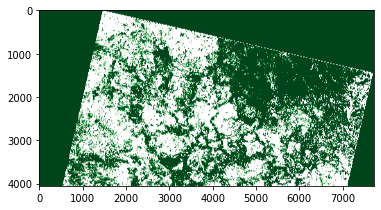

In [7]:
#model = load_model('C:\Data\BasicCNN_model.h5')
#model = tf.keras.models.load_model(b"C:\Data\BasicCNN_model.h5", compile = False)
model = tf.keras.models.load_model(r"C:\Users\Gavin\Models\Thesis Models 2022\Sat\ResNet50\ResNet50_Sat_bestmodel")
#model = tf.saved_model.load(export_dir=r'C:\Data\model', tags=None, options=None) 
model.summary()
predictingNewX(model,data_dir_list,data_path,width=32,height=32,layers=7)
merge_raster_in_folder(output_path,result_path)

In [8]:
print(tf.__version__)

2.7.0
